In [2]:
# Attaching the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.getcwd()

'/content'

In [6]:
# Configuring the environment Variable
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [ ]:
!pip install kaggle

In [7]:
#selecting the particular directory
os.chdir('/content/drive/MyDrive/gdrive')

In [ ]:
#Downloading the div2k-dataset
!kaggle datasets download -d joe1995/div2k-dataset

100% 3.71G/3.71G [03:39<00:00, 19.4MB/s]
100% 3.71G/3.71G [03:39<00:00, 18.2MB/s]


In [10]:
os.listdir()

['div2k-dataset.zip',
 'DIV2K_train_HR',
 'DIV2K_valid_HR',
 '.ipynb_checkpoints',
 'artifacts',
 'original',
 'test',
 'gen_e_10.h5',
 'gen_e_20.h5',
 'gen_e_30.h5']

In [ ]:
zip_path = '/content/drive/MyDrive/gdrive/div2k-dataset.zip'

In [ ]:
#selecting the zip file
!cp {'zip_path'}

cp: missing destination file operand after 'zip_path'
Try 'cp --help' for more information.


In [ ]:
#uniziping
!unzip -q 'div2k-dataset.zip'

In [11]:
#importing pillow
from PIL import Image
import cv2

In [12]:
#Creating the dataset directories
os.makedirs('/content/drive/MyDrive/gdrive/artifacts/train',exist_ok=True)
os.makedirs('/content/drive/MyDrive/gdrive/artifacts/val',exist_ok=True)


os.makedirs('/content/drive/MyDrive/gdrive/original/train',exist_ok=True)
os.makedirs('/content/drive/MyDrive/gdrive/original/val',exist_ok=True)

In [13]:
inp_dir_train = os.path.join('/content/drive/MyDrive/gdrive/DIV2K_train_HR/DIV2K_train_HR')
out_dir_org_train = os.path.join('/content/drive/MyDrive/gdrive/original/train')
out_dir_art_train = os.path.join('/content/drive/MyDrive/gdrive/artifacts/train')

inp_dir_val = os.path.join('/content/drive/MyDrive/gdrive/DIV2K_valid_HR/DIV2K_valid_HR')
out_dir_org_val = os.path.join('/content/drive/MyDrive/gdrive/original/val')
out_dir_art_val = os.path.join('/content/drive/MyDrive/gdrive/artifacts/val')

In [14]:
#code for creating Dataset
def create_datasets(png_file, out_dir_org, out_dir_art):
  try:
    img = Image.open(png_file)
    filename = os.path.basename(png_file)
    out_org_file = os.path.join(out_dir_org, filename)
    out_art_file = os.path.join(out_dir_art, filename)

    img_resized = img.resize((128, 128))
    jpg_img = img_resized.convert('RGB')
    jpg_img.save(out_org_file , "JPEG", quality=100)

    img_artified = img.resize((32, 32))
    jpg_img = img_artified.convert('RGB')
    jpg_img.save(out_art_file, 'JPEG', quality= 70)
    print(f'Image generation successful {png_file}')
  except Exception as e:
    print(f'Image generation failed {e}{png_file}')



In [ ]:
#created dataset for High resolution and Low resolution
folder_inp = [inp_dir_train, inp_dir_val]
folder_out = [[out_dir_org_train, out_dir_art_train], [out_dir_org_val, out_dir_art_val]]
i = 0
for fold in folder_inp:
  if fold == inp_dir_val:
    i += 1
  for filename in os.listdir(fold):
    if filename.lower().endswith(".png"):
      png_file_path = os.path.join(fold, filename)
      create_datasets(png_file_path, folder_out[i][0], folder_out[i][1])


Image generation successful /content/drive/MyDrive/gdrive/DIV2K_train_HR/DIV2K_train_HR/0001.png
Image generation successful /content/drive/MyDrive/gdrive/DIV2K_train_HR/DIV2K_train_HR/0002.png
Image generation successful /content/drive/MyDrive/gdrive/DIV2K_train_HR/DIV2K_train_HR/0003.png
Image generation successful /content/drive/MyDrive/gdrive/DIV2K_train_HR/DIV2K_train_HR/0004.png
Image generation successful /content/drive/MyDrive/gdrive/DIV2K_train_HR/DIV2K_train_HR/0005.png
Image generation successful /content/drive/MyDrive/gdrive/DIV2K_train_HR/DIV2K_train_HR/0006.png
Image generation successful /content/drive/MyDrive/gdrive/DIV2K_train_HR/DIV2K_train_HR/0007.png
Image generation successful /content/drive/MyDrive/gdrive/DIV2K_train_HR/DIV2K_train_HR/0008.png
Image generation successful /content/drive/MyDrive/gdrive/DIV2K_train_HR/DIV2K_train_HR/0009.png
Image generation successful /content/drive/MyDrive/gdrive/DIV2K_train_HR/DIV2K_train_HR/0010.png
Image generation successful /c

In [15]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [16]:
from matplotlib import pyplot as plt

In [17]:
#Importing the required Libraries
import cv2
import numpy as np
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [18]:
#Defining the residual block
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])

In [19]:
#Upscaling Block
def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

In [20]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)


In [21]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model

In [22]:

#Descriminartor
def create_disc(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


In [23]:
# importing the vgg19 model
from keras.applications import VGG19

def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


In [24]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

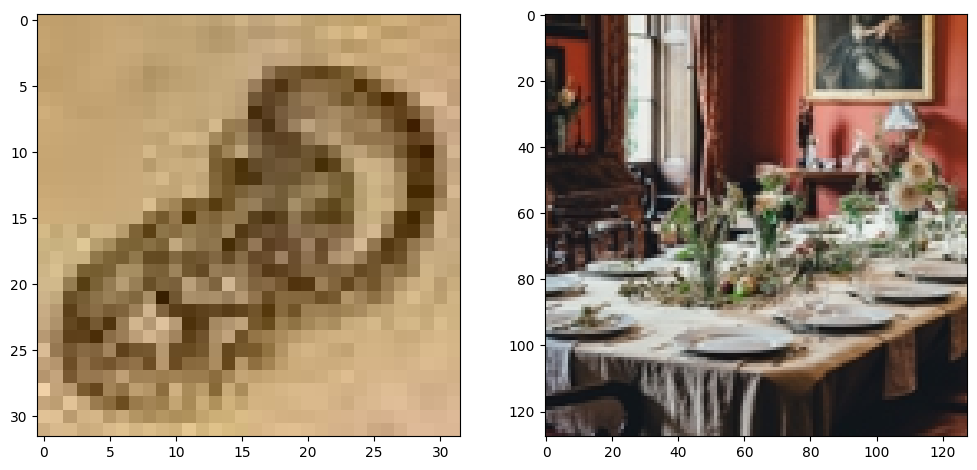

In [28]:
# Alloting the Low and High resolution images to respected lists
lr_images = []
for img in os.listdir(out_dir_art_train):
    img_lr = cv2.imread(out_dir_art_train +'/' + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)


hr_images = []
for img in os.listdir(out_dir_org_train):
    img_hr = cv2.imread(out_dir_org_train +'/' + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

#Visualising few images
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()


In [29]:
#Model Summary

#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_45 (Conv2D)             (None, 32, 32, 64)   15616       ['input_4[0][0]']                
                                                                                                  
 p_re_lu_19 (PReLU)             (None, 32, 32, 64)   64          ['conv2d_45[0][0]']              
                                                                                                  
 conv2d_46 (Conv2D)             (None, 32, 32, 64)   36928       ['p_re_lu_19[0][0]']             
                                                                                            

In [ ]:

#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training.
batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])


epochs = 30
#Enumerate training over epochs
for e in range(epochs):

    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.

    #Create empty lists to populate gen and disc losses.
    g_losses = []
    d_losses = []

    #Enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

        #First, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False

        #Average the discriminator loss, just for reporting purposes.
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)

        #Train the generator via GAN.
        #adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        #Save losses to a list so we can average and report.
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    #Convert the list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    #Report the progress during training.
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving
        #Save the generator after every 10 epochs
        generator.save("gen_e_"+ str(e+1) +".h5")



  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 1s 522ms/step


  0%|          | 1/536 [00:53<8:01:02, 53.95s/it]

1/1 [==============================] - 0s 20ms/step


  0%|          | 2/536 [00:54<3:18:48, 22.34s/it]

1/1 [==============================] - 0s 22ms/step


  1%|          | 3/536 [00:54<1:48:39, 12.23s/it]

1/1 [==============================] - 0s 19ms/step


  1%|          | 4/536 [00:54<1:06:17,  7.48s/it]

1/1 [==============================] - 0s 19ms/step


  1%|          | 5/536 [00:54<42:58,  4.86s/it]  

1/1 [==============================] - 0s 23ms/step


  1%|          | 6/536 [00:54<28:53,  3.27s/it]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 7/536 [00:55<19:57,  2.26s/it]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 8/536 [00:55<14:07,  1.61s/it]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 9/536 [00:55<10:11,  1.16s/it]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 10/536 [00:55<07:31,  1.16it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 11/536 [00:55<05:42,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 12/536 [00:56<04:35,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 13/536 [00:56<03:51,  2.26it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 14/536 [00:56<03:22,  2.58it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 15/536 [00:56<03:03,  2.84it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 16/536 [00:57<02:48,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 17/536 [00:57<02:37,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 18/536 [00:57<02:29,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 19/536 [00:57<02:21,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 20/536 [00:58<02:16,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 21/536 [00:58<02:13,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 22/536 [00:58<02:10,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 23/536 [00:58<02:07,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 24/536 [00:59<02:09,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 25/536 [00:59<02:06,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 26/536 [00:59<02:01,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 27/536 [00:59<01:52,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 28/536 [00:59<01:47,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 29/536 [01:00<01:42,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 30/536 [01:00<01:40,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 31/536 [01:00<01:41,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 32/536 [01:00<01:39,  5.07it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 33/536 [01:00<01:38,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 34/536 [01:01<01:36,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 35/536 [01:01<01:35,  5.27it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 36/536 [01:01<01:37,  5.12it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 37/536 [01:01<01:40,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 38/536 [01:01<01:36,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 39/536 [01:02<01:33,  5.30it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 40/536 [01:02<01:32,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 41/536 [01:02<01:31,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 42/536 [01:02<01:30,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 43/536 [01:02<01:28,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 44/536 [01:02<01:28,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 45/536 [01:03<01:28,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 46/536 [01:03<01:28,  5.53it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 47/536 [01:03<01:33,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 48/536 [01:03<01:33,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 49/536 [01:03<01:31,  5.30it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 50/536 [01:04<01:30,  5.34it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 51/536 [01:04<01:29,  5.42it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 52/536 [01:04<01:27,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 53/536 [01:04<01:26,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 54/536 [01:04<01:24,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 55/536 [01:04<01:25,  5.66it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 56/536 [01:05<01:23,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 57/536 [01:05<01:23,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 58/536 [01:05<01:26,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 59/536 [01:05<01:25,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 60/536 [01:05<01:23,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 61/536 [01:06<01:26,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 62/536 [01:06<01:25,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 63/536 [01:06<01:23,  5.67it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 64/536 [01:06<01:26,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 65/536 [01:06<01:28,  5.33it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 66/536 [01:06<01:26,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 67/536 [01:07<01:24,  5.57it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 68/536 [01:07<01:21,  5.73it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 69/536 [01:07<01:19,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 70/536 [01:07<01:23,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 71/536 [01:07<01:21,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 72/536 [01:07<01:20,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 73/536 [01:08<01:18,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 74/536 [01:08<01:18,  5.90it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▍        | 75/536 [01:08<02:02,  3.78it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 76/536 [01:08<01:48,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 77/536 [01:09<01:38,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 78/536 [01:09<01:38,  4.67it/s]

1/1 [==============================] - 0s 167ms/step


 15%|█▍        | 79/536 [01:10<02:57,  2.57it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 80/536 [01:10<02:48,  2.71it/s]

1/1 [==============================] - 0s 159ms/step


 15%|█▌        | 81/536 [01:11<03:45,  2.02it/s]

1/1 [==============================] - 0s 64ms/step


 15%|█▌        | 82/536 [01:11<04:07,  1.83it/s]

1/1 [==============================] - 0s 83ms/step


 15%|█▌        | 83/536 [01:12<04:15,  1.78it/s]

1/1 [==============================] - 0s 76ms/step


 16%|█▌        | 84/536 [01:13<04:19,  1.74it/s]

1/1 [==============================] - 0s 53ms/step


 16%|█▌        | 85/536 [01:13<03:54,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 86/536 [01:13<03:21,  2.23it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 87/536 [01:14<02:55,  2.55it/s]

1/1 [==============================] - 0s 48ms/step


 16%|█▋        | 88/536 [01:14<02:54,  2.57it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 89/536 [01:14<02:39,  2.80it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 90/536 [01:15<02:27,  3.02it/s]

1/1 [==============================] - 0s 93ms/step


 17%|█▋        | 91/536 [01:15<02:45,  2.68it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 92/536 [01:15<02:22,  3.13it/s]

1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 93/536 [01:16<02:25,  3.04it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 94/536 [01:16<02:20,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 95/536 [01:16<02:15,  3.26it/s]

1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 96/536 [01:16<02:24,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 97/536 [01:17<02:21,  3.10it/s]

1/1 [==============================] - 0s 99ms/step


 18%|█▊        | 98/536 [01:17<02:49,  2.58it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 99/536 [01:18<02:58,  2.45it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▊        | 100/536 [01:18<03:08,  2.31it/s]

1/1 [==============================] - 0s 127ms/step


 19%|█▉        | 101/536 [01:19<03:38,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 102/536 [01:19<03:06,  2.33it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 103/536 [01:19<02:36,  2.76it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 104/536 [01:20<02:13,  3.23it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 105/536 [01:20<01:57,  3.68it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 106/536 [01:20<01:47,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 107/536 [01:20<01:39,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 108/536 [01:20<01:32,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 109/536 [01:21<01:30,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 110/536 [01:21<01:27,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 111/536 [01:21<01:23,  5.06it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 112/536 [01:21<01:22,  5.12it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 113/536 [01:21<01:21,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 114/536 [01:21<01:18,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 115/536 [01:22<01:17,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 116/536 [01:22<01:16,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 117/536 [01:22<01:16,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 118/536 [01:22<01:15,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 119/536 [01:22<01:17,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 120/536 [01:23<01:15,  5.49it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 121/536 [01:23<01:16,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 122/536 [01:23<01:14,  5.57it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 123/536 [01:23<01:20,  5.12it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 124/536 [01:23<01:25,  4.80it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 125/536 [01:24<01:33,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 126/536 [01:24<01:33,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 127/536 [01:24<01:33,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 128/536 [01:24<01:33,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 129/536 [01:25<01:32,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 130/536 [01:25<01:35,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 131/536 [01:25<01:34,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 132/536 [01:25<01:34,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 133/536 [01:26<01:35,  4.23it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 134/536 [01:26<01:38,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 135/536 [01:26<01:36,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 136/536 [01:26<01:35,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 137/536 [01:26<01:30,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 138/536 [01:27<01:26,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 139/536 [01:27<01:23,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 140/536 [01:27<01:19,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 141/536 [01:27<01:18,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 142/536 [01:27<01:15,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 143/536 [01:28<01:13,  5.33it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 144/536 [01:28<01:14,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 145/536 [01:28<01:12,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 146/536 [01:28<01:11,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 147/536 [01:28<01:10,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 148/536 [01:28<01:08,  5.63it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 149/536 [01:29<01:11,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 150/536 [01:29<01:10,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 151/536 [01:29<01:08,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 152/536 [01:29<01:10,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 153/536 [01:29<01:09,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 154/536 [01:30<01:07,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 155/536 [01:30<01:07,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 156/536 [01:30<01:06,  5.70it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 157/536 [01:30<01:06,  5.71it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 158/536 [01:30<01:10,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 159/536 [01:30<01:08,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 160/536 [01:31<01:06,  5.62it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 161/536 [01:31<01:09,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 162/536 [01:31<01:09,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 163/536 [01:31<01:10,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 164/536 [01:31<01:08,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 165/536 [01:32<01:07,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 166/536 [01:32<01:10,  5.26it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 167/536 [01:32<01:08,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 168/536 [01:32<01:07,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 169/536 [01:32<01:06,  5.48it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 170/536 [01:32<01:07,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 171/536 [01:33<01:05,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 172/536 [01:33<01:06,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 173/536 [01:33<01:06,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 174/536 [01:33<01:07,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 175/536 [01:33<01:06,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 176/536 [01:34<01:06,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 177/536 [01:34<01:08,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 178/536 [01:34<01:06,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 179/536 [01:34<01:08,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 180/536 [01:34<01:06,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 181/536 [01:35<01:05,  5.41it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 182/536 [01:35<01:06,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 183/536 [01:35<01:06,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 184/536 [01:35<01:05,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 185/536 [01:35<01:03,  5.49it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 186/536 [01:35<01:03,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 187/536 [01:36<01:01,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 188/536 [01:36<01:01,  5.69it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 189/536 [01:36<01:00,  5.71it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 190/536 [01:36<01:01,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 191/536 [01:36<01:02,  5.53it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 192/536 [01:37<01:07,  5.12it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 193/536 [01:37<01:11,  4.80it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 194/536 [01:37<01:15,  4.56it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 195/536 [01:37<01:15,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 196/536 [01:37<01:15,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 197/536 [01:38<01:16,  4.40it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 198/536 [01:38<01:20,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 199/536 [01:38<01:23,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 200/536 [01:39<01:23,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 201/536 [01:39<01:21,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 202/536 [01:39<01:21,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 203/536 [01:39<01:21,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 204/536 [01:39<01:23,  3.99it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 205/536 [01:40<01:22,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 206/536 [01:40<01:15,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 207/536 [01:40<01:13,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 208/536 [01:40<01:10,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 209/536 [01:41<01:06,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 210/536 [01:41<01:04,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 211/536 [01:41<01:01,  5.24it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 212/536 [01:41<01:02,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 213/536 [01:41<01:00,  5.35it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 214/536 [01:41<01:00,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 215/536 [01:42<00:58,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 216/536 [01:42<01:01,  5.17it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 217/536 [01:42<01:00,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 218/536 [01:42<00:59,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 219/536 [01:42<00:57,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 220/536 [01:43<00:56,  5.58it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 221/536 [01:43<00:55,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 222/536 [01:43<00:55,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 223/536 [01:43<00:55,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 224/536 [01:43<00:55,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 225/536 [01:43<00:56,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 226/536 [01:44<00:56,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 227/536 [01:44<00:55,  5.60it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 228/536 [01:44<00:54,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 229/536 [01:44<00:55,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 230/536 [01:44<00:55,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 231/536 [01:44<00:55,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 232/536 [01:45<00:55,  5.43it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 233/536 [01:45<00:55,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 234/536 [01:45<00:55,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 235/536 [01:45<00:57,  5.25it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 236/536 [01:45<00:56,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 237/536 [01:46<00:55,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 238/536 [01:46<00:56,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 239/536 [01:46<00:55,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 240/536 [01:46<00:54,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 241/536 [01:46<00:55,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 242/536 [01:47<00:54,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 243/536 [01:47<00:53,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 244/536 [01:47<00:52,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 245/536 [01:47<00:51,  5.64it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 246/536 [01:47<00:52,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 247/536 [01:47<00:51,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 248/536 [01:48<00:51,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 249/536 [01:48<00:54,  5.25it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 250/536 [01:48<00:52,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 251/536 [01:48<00:52,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 252/536 [01:48<00:52,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 253/536 [01:49<00:51,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 254/536 [01:49<00:50,  5.57it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 255/536 [01:49<00:50,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 256/536 [01:49<00:49,  5.68it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 257/536 [01:49<00:49,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 258/536 [01:49<00:52,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 259/536 [01:50<00:50,  5.51it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 260/536 [01:50<00:54,  5.04it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 261/536 [01:50<00:59,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 262/536 [01:50<01:01,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 263/536 [01:51<01:01,  4.46it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 264/536 [01:51<01:01,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 265/536 [01:51<01:00,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 266/536 [01:51<01:03,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 267/536 [01:52<01:03,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 268/536 [01:52<01:04,  4.17it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 269/536 [01:52<01:05,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 270/536 [01:52<01:04,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 271/536 [01:53<01:04,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 272/536 [01:53<01:04,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 273/536 [01:53<01:05,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 274/536 [01:53<01:03,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 275/536 [01:53<00:59,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 276/536 [01:54<00:56,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 277/536 [01:54<00:54,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 278/536 [01:54<00:52,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 279/536 [01:54<00:51,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 280/536 [01:54<00:50,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 281/536 [01:55<00:48,  5.23it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 282/536 [01:55<00:51,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 283/536 [01:55<00:50,  5.06it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 284/536 [01:55<00:48,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 285/536 [01:55<00:48,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 286/536 [01:56<00:48,  5.18it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 287/536 [01:56<00:46,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 288/536 [01:56<00:45,  5.41it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 289/536 [01:56<00:44,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 290/536 [01:56<00:45,  5.38it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 291/536 [01:57<00:47,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 292/536 [01:57<00:46,  5.30it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 293/536 [01:57<00:45,  5.38it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 294/536 [01:57<00:44,  5.46it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 295/536 [01:57<00:43,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 296/536 [01:57<00:43,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 297/536 [01:58<00:44,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 298/536 [01:58<00:43,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 299/536 [01:58<00:43,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 300/536 [01:58<00:43,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 301/536 [01:58<00:42,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 302/536 [01:59<00:43,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 303/536 [01:59<00:42,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 304/536 [01:59<00:43,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 305/536 [01:59<00:42,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 306/536 [01:59<00:42,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 307/536 [01:59<00:41,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 308/536 [02:00<00:41,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 309/536 [02:00<00:41,  5.49it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 310/536 [02:00<00:40,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 311/536 [02:00<00:40,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 312/536 [02:00<00:41,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 313/536 [02:01<00:40,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 314/536 [02:01<00:40,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 315/536 [02:01<00:39,  5.56it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 316/536 [02:01<00:41,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 317/536 [02:01<00:42,  5.17it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 318/536 [02:01<00:40,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 319/536 [02:02<00:40,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 320/536 [02:02<00:39,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 321/536 [02:02<00:39,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 322/536 [02:02<00:38,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 323/536 [02:02<00:38,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 324/536 [02:03<00:38,  5.56it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 325/536 [02:03<00:38,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 326/536 [02:03<00:38,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 327/536 [02:03<00:38,  5.39it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 328/536 [02:03<00:42,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 329/536 [02:04<00:45,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 330/536 [02:04<00:45,  4.49it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 331/536 [02:04<00:47,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 332/536 [02:04<00:47,  4.32it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 333/536 [02:05<00:48,  4.23it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 334/536 [02:05<00:48,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 335/536 [02:05<00:47,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 336/536 [02:05<00:48,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 337/536 [02:06<00:48,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 338/536 [02:06<00:50,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 339/536 [02:06<00:48,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 340/536 [02:06<00:49,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 341/536 [02:07<00:49,  3.97it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 342/536 [02:07<00:46,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 343/536 [02:07<00:43,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 344/536 [02:07<00:41,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 345/536 [02:07<00:41,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 346/536 [02:08<00:39,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 347/536 [02:08<00:39,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 348/536 [02:08<00:38,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 349/536 [02:08<00:37,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 350/536 [02:08<00:37,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 351/536 [02:09<00:36,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 352/536 [02:09<00:35,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 353/536 [02:09<00:35,  5.23it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 354/536 [02:09<00:34,  5.26it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 355/536 [02:09<00:33,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 356/536 [02:09<00:33,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 357/536 [02:10<00:33,  5.41it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 358/536 [02:10<00:32,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 359/536 [02:10<00:33,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 360/536 [02:10<00:32,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 361/536 [02:10<00:31,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 362/536 [02:11<00:31,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 363/536 [02:11<00:31,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 364/536 [02:11<00:32,  5.26it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 365/536 [02:11<00:32,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 366/536 [02:11<00:31,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 367/536 [02:12<00:31,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 368/536 [02:12<00:31,  5.31it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 369/536 [02:12<00:31,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 370/536 [02:12<00:32,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 371/536 [02:12<00:31,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 372/536 [02:12<00:30,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 373/536 [02:13<00:29,  5.52it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 374/536 [02:13<00:29,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 375/536 [02:13<00:29,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 376/536 [02:13<00:29,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 377/536 [02:13<00:29,  5.34it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 378/536 [02:14<00:28,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 379/536 [02:14<00:28,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 380/536 [02:14<00:27,  5.58it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 381/536 [02:14<00:28,  5.48it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 382/536 [02:14<00:28,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 383/536 [02:14<00:28,  5.40it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 384/536 [02:15<00:28,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 385/536 [02:15<00:27,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 386/536 [02:15<00:27,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 387/536 [02:15<00:27,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 388/536 [02:15<00:26,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 389/536 [02:16<00:26,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 390/536 [02:16<00:25,  5.62it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 391/536 [02:16<00:26,  5.43it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 392/536 [02:16<00:26,  5.40it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 393/536 [02:16<00:29,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 394/536 [02:17<00:30,  4.63it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▎  | 395/536 [02:17<00:36,  3.84it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 396/536 [02:17<00:40,  3.46it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 397/536 [02:18<00:42,  3.25it/s]

1/1 [==============================] - 0s 55ms/step


 74%|███████▍  | 398/536 [02:18<00:44,  3.09it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 399/536 [02:18<00:45,  3.01it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▍  | 400/536 [02:19<00:45,  3.00it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 401/536 [02:19<00:46,  2.88it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 402/536 [02:19<00:48,  2.75it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 403/536 [02:20<00:47,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 404/536 [02:20<00:45,  2.88it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 405/536 [02:21<00:45,  2.88it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 406/536 [02:21<00:44,  2.92it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 407/536 [02:21<00:41,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 408/536 [02:21<00:38,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 409/536 [02:22<00:37,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 410/536 [02:22<00:35,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 411/536 [02:22<00:34,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 412/536 [02:22<00:31,  3.90it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 413/536 [02:23<00:29,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 414/536 [02:23<00:27,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 415/536 [02:23<00:26,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 416/536 [02:23<00:25,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 417/536 [02:23<00:24,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 418/536 [02:24<00:24,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 419/536 [02:24<00:23,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 420/536 [02:24<00:22,  5.04it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 421/536 [02:24<00:22,  5.17it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 422/536 [02:24<00:21,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 423/536 [02:25<00:21,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 424/536 [02:25<00:21,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 425/536 [02:25<00:21,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 426/536 [02:25<00:21,  5.22it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 427/536 [02:25<00:21,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 428/536 [02:25<00:20,  5.18it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 429/536 [02:26<00:20,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 430/536 [02:26<00:20,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 431/536 [02:26<00:19,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 432/536 [02:26<00:20,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 433/536 [02:26<00:19,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 434/536 [02:27<00:18,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 435/536 [02:27<00:19,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 436/536 [02:27<00:18,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 437/536 [02:27<00:18,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 438/536 [02:27<00:18,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 439/536 [02:28<00:17,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 440/536 [02:28<00:17,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 441/536 [02:28<00:17,  5.52it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 442/536 [02:28<00:17,  5.28it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 443/536 [02:28<00:17,  5.22it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 444/536 [02:28<00:17,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 445/536 [02:29<00:16,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 446/536 [02:29<00:16,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 447/536 [02:29<00:16,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 448/536 [02:29<00:16,  5.49it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 449/536 [02:29<00:15,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 450/536 [02:30<00:15,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 451/536 [02:30<00:15,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 452/536 [02:30<00:15,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 453/536 [02:30<00:15,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 454/536 [02:30<00:14,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 455/536 [02:30<00:14,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 456/536 [02:31<00:14,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 457/536 [02:31<00:14,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 458/536 [02:31<00:13,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 459/536 [02:31<00:13,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 460/536 [02:31<00:13,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 461/536 [02:32<00:13,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 462/536 [02:32<00:13,  5.56it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 463/536 [02:32<00:13,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 464/536 [02:32<00:12,  5.68it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 465/536 [02:32<00:13,  5.39it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 466/536 [02:33<00:14,  4.91it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 467/536 [02:33<00:14,  4.80it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 468/536 [02:33<00:15,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 469/536 [02:33<00:15,  4.33it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 470/536 [02:34<00:15,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 471/536 [02:34<00:16,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 472/536 [02:34<00:16,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 473/536 [02:34<00:16,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 474/536 [02:35<00:16,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 475/536 [02:35<00:15,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 476/536 [02:35<00:15,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 477/536 [02:35<00:15,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 478/536 [02:36<00:14,  3.88it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 479/536 [02:36<00:14,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 480/536 [02:36<00:13,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 481/536 [02:36<00:12,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 482/536 [02:36<00:11,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 483/536 [02:37<00:11,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 484/536 [02:37<00:10,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 485/536 [02:37<00:10,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 486/536 [02:37<00:10,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 487/536 [02:37<00:09,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 488/536 [02:38<00:09,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 489/536 [02:38<00:09,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 490/536 [02:38<00:09,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 491/536 [02:38<00:08,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 492/536 [02:38<00:08,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 493/536 [02:39<00:08,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 494/536 [02:39<00:08,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 495/536 [02:39<00:07,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 496/536 [02:39<00:07,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 497/536 [02:39<00:07,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 498/536 [02:40<00:07,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 499/536 [02:40<00:06,  5.37it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 500/536 [02:40<00:06,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 501/536 [02:40<00:06,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 502/536 [02:40<00:06,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 503/536 [02:40<00:06,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 504/536 [02:41<00:06,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 505/536 [02:41<00:05,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 506/536 [02:41<00:05,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 507/536 [02:41<00:05,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 508/536 [02:41<00:05,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 509/536 [02:42<00:04,  5.52it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 510/536 [02:42<00:04,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 511/536 [02:42<00:04,  5.32it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 512/536 [02:42<00:04,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 513/536 [02:42<00:04,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 514/536 [02:43<00:04,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 515/536 [02:43<00:03,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 516/536 [02:43<00:03,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 517/536 [02:43<00:03,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 518/536 [02:43<00:03,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 519/536 [02:43<00:03,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 520/536 [02:44<00:03,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 521/536 [02:44<00:02,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 522/536 [02:44<00:02,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 523/536 [02:44<00:02,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 524/536 [02:44<00:02,  5.30it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 525/536 [02:45<00:02,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 526/536 [02:45<00:01,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 527/536 [02:45<00:01,  5.27it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 528/536 [02:45<00:01,  5.17it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 529/536 [02:45<00:01,  5.26it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 530/536 [02:46<00:01,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 531/536 [02:46<00:00,  5.16it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 532/536 [02:46<00:00,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 533/536 [02:46<00:00,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 534/536 [02:46<00:00,  4.51it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 535/536 [02:47<00:00,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 536/536 [02:47<00:00,  3.20it/s]


epoch: 1 g_loss: 109.67881695192251 d_loss: [2.619926   0.83768657]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 1/536 [00:00<02:12,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 2/536 [00:00<02:13,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 3/536 [00:00<02:13,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 4/536 [00:01<02:14,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 5/536 [00:01<02:19,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 6/536 [00:01<02:20,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 7/536 [00:01<02:16,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 8/536 [00:02<02:19,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 9/536 [00:02<02:15,  3.89it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 10/536 [00:02<02:08,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 11/536 [00:02<02:00,  4.35it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 12/536 [00:02<01:57,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 13/536 [00:03<01:52,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 14/536 [00:03<01:50,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 15/536 [00:03<01:47,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 16/536 [00:03<01:45,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 17/536 [00:03<01:46,  4.86it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 18/536 [00:04<01:45,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 19/536 [00:04<01:42,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 20/536 [00:04<01:41,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 21/536 [00:04<01:40,  5.12it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 22/536 [00:04<01:39,  5.17it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 23/536 [00:05<01:41,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 24/536 [00:05<01:39,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 25/536 [00:05<01:38,  5.18it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 26/536 [00:05<01:37,  5.24it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 27/536 [00:05<01:37,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 28/536 [00:06<01:38,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 29/536 [00:06<01:37,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 30/536 [00:06<01:36,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 31/536 [00:06<01:34,  5.34it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 32/536 [00:06<01:37,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 33/536 [00:07<01:36,  5.19it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 34/536 [00:07<01:36,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 35/536 [00:07<01:36,  5.20it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 36/536 [00:07<01:36,  5.16it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 37/536 [00:07<01:37,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 38/536 [00:07<01:34,  5.24it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 39/536 [00:08<01:38,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 40/536 [00:08<01:36,  5.11it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 41/536 [00:08<01:35,  5.18it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 42/536 [00:08<01:35,  5.15it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 43/536 [00:08<01:34,  5.24it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 44/536 [00:09<01:33,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 45/536 [00:09<01:34,  5.18it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 46/536 [00:09<01:34,  5.18it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 47/536 [00:09<01:33,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 48/536 [00:09<01:31,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 49/536 [00:10<01:34,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 50/536 [00:10<01:32,  5.23it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 51/536 [00:10<01:33,  5.19it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 52/536 [00:10<01:33,  5.20it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 53/536 [00:10<01:32,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 54/536 [00:11<01:30,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 55/536 [00:11<01:32,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 56/536 [00:11<01:34,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 57/536 [00:11<01:35,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 58/536 [00:11<01:33,  5.14it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 59/536 [00:12<01:31,  5.21it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 60/536 [00:12<01:35,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 61/536 [00:12<01:41,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 62/536 [00:12<01:44,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 63/536 [00:12<01:47,  4.41it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 64/536 [00:13<01:53,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 65/536 [00:13<01:53,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 66/536 [00:13<01:52,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 67/536 [00:13<01:53,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 68/536 [00:14<02:00,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 69/536 [00:14<01:59,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 70/536 [00:14<01:59,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 71/536 [00:15<01:59,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 72/536 [00:15<01:59,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 73/536 [00:15<01:58,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 74/536 [00:15<01:57,  3.92it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 75/536 [00:15<01:50,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 76/536 [00:16<01:45,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 77/536 [00:16<01:42,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 78/536 [00:16<01:41,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 79/536 [00:16<01:38,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 80/536 [00:17<01:35,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 81/536 [00:17<01:34,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 82/536 [00:17<01:33,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 83/536 [00:17<01:34,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 84/536 [00:17<01:33,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 85/536 [00:18<01:32,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 86/536 [00:18<01:30,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 87/536 [00:18<01:30,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 88/536 [00:18<01:29,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 89/536 [00:18<01:28,  5.08it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 90/536 [00:19<01:32,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 91/536 [00:19<01:30,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 92/536 [00:19<01:29,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 93/536 [00:19<01:27,  5.06it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 94/536 [00:19<01:28,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 95/536 [00:20<01:28,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 96/536 [00:20<01:28,  5.00it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 97/536 [00:20<01:28,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 98/536 [00:20<01:25,  5.09it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 99/536 [00:20<01:26,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 100/536 [00:21<01:25,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 101/536 [00:21<01:25,  5.09it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 102/536 [00:21<01:25,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 103/536 [00:21<01:23,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 104/536 [00:21<01:24,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 105/536 [00:21<01:22,  5.20it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 106/536 [00:22<01:23,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 107/536 [00:22<01:22,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 108/536 [00:22<01:22,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 109/536 [00:22<01:23,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 110/536 [00:22<01:23,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 111/536 [00:23<01:23,  5.08it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 112/536 [00:23<01:22,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 113/536 [00:23<01:21,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 114/536 [00:23<01:21,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 115/536 [00:23<01:20,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 116/536 [00:24<01:19,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 117/536 [00:24<01:19,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 118/536 [00:24<01:19,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 119/536 [00:24<01:18,  5.29it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 120/536 [00:24<01:19,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 121/536 [00:25<01:20,  5.19it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 122/536 [00:25<01:21,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 123/536 [00:25<01:22,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 124/536 [00:25<01:21,  5.07it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 125/536 [00:25<01:25,  4.82it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 126/536 [00:26<01:31,  4.49it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 127/536 [00:26<01:34,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 128/536 [00:26<01:38,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 129/536 [00:26<01:39,  4.07it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 130/536 [00:27<01:41,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 131/536 [00:27<01:39,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 132/536 [00:27<01:41,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 133/536 [00:27<01:43,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 134/536 [00:28<01:47,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 135/536 [00:28<01:44,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 136/536 [00:28<01:46,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 137/536 [00:29<01:44,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 138/536 [00:29<01:43,  3.86it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 139/536 [00:29<01:37,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 140/536 [00:29<01:33,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 141/536 [00:29<01:31,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 142/536 [00:30<01:29,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 143/536 [00:30<01:25,  4.58it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 144/536 [00:30<01:24,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 145/536 [00:30<01:22,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 146/536 [00:30<01:20,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 147/536 [00:31<01:19,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 148/536 [00:31<01:17,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 149/536 [00:31<01:16,  5.08it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 150/536 [00:31<01:15,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 151/536 [00:31<01:13,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 152/536 [00:32<01:13,  5.23it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 153/536 [00:32<01:16,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 154/536 [00:32<01:14,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 155/536 [00:32<01:14,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 156/536 [00:32<01:13,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 157/536 [00:33<01:12,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 158/536 [00:33<01:11,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 159/536 [00:33<01:10,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 160/536 [00:33<01:09,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 161/536 [00:33<01:10,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 162/536 [00:34<01:10,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 163/536 [00:34<01:11,  5.22it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 164/536 [00:34<01:09,  5.32it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 165/536 [00:34<01:09,  5.37it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 166/536 [00:34<01:10,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 167/536 [00:34<01:09,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 168/536 [00:35<01:09,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 169/536 [00:35<01:10,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 170/536 [00:35<01:11,  5.11it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 171/536 [00:35<01:10,  5.21it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 172/536 [00:35<01:11,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 173/536 [00:36<01:11,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 174/536 [00:36<01:09,  5.19it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 175/536 [00:36<01:12,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 176/536 [00:36<01:09,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 177/536 [00:36<01:09,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 178/536 [00:37<01:12,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 179/536 [00:37<01:10,  5.08it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 180/536 [00:37<01:11,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 181/536 [00:37<01:08,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 182/536 [00:37<01:08,  5.16it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 183/536 [00:38<01:09,  5.08it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 184/536 [00:38<01:07,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 185/536 [00:38<01:06,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 186/536 [00:38<01:07,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 187/536 [00:38<01:08,  5.11it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 188/536 [00:39<01:08,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 189/536 [00:39<01:07,  5.11it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 190/536 [00:39<01:10,  4.93it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 191/536 [00:39<01:14,  4.65it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 192/536 [00:39<01:19,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 193/536 [00:40<01:20,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 194/536 [00:40<01:23,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 195/536 [00:40<01:24,  4.06it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 196/536 [00:41<01:25,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 197/536 [00:41<01:26,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 198/536 [00:41<01:26,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 199/536 [00:41<01:36,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 200/536 [00:42<01:33,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 201/536 [00:42<01:32,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 202/536 [00:42<01:30,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 203/536 [00:42<01:29,  3.71it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 204/536 [00:43<01:24,  3.92it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 205/536 [00:43<01:19,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 206/536 [00:43<01:14,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 207/536 [00:43<01:11,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 208/536 [00:43<01:09,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 209/536 [00:44<01:07,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 210/536 [00:44<01:05,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 211/536 [00:44<01:04,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 212/536 [00:44<01:04,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 213/536 [00:44<01:03,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 214/536 [00:45<01:03,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 215/536 [00:45<01:02,  5.14it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 216/536 [00:45<01:01,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 217/536 [00:45<01:01,  5.20it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 218/536 [00:45<01:01,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 219/536 [00:46<01:02,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 220/536 [00:46<01:02,  5.04it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 221/536 [00:46<01:02,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 222/536 [00:46<01:01,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 223/536 [00:46<01:03,  4.91it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 224/536 [00:47<01:02,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 225/536 [00:47<01:02,  5.01it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 226/536 [00:47<01:01,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 227/536 [00:47<01:01,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 228/536 [00:47<01:03,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 229/536 [00:48<01:04,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 230/536 [00:48<01:03,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 231/536 [00:48<01:02,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 232/536 [00:48<01:01,  4.98it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 233/536 [00:48<01:00,  4.98it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 234/536 [00:49<01:01,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 235/536 [00:49<01:00,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 236/536 [00:49<01:00,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 237/536 [00:49<00:59,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 238/536 [00:49<00:59,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 239/536 [00:50<01:00,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 240/536 [00:50<00:59,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 241/536 [00:50<00:59,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 242/536 [00:50<00:59,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 243/536 [00:50<00:58,  4.98it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 244/536 [00:51<01:00,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 245/536 [00:51<01:01,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 246/536 [00:51<01:00,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 247/536 [00:51<00:59,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 248/536 [00:51<00:59,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 249/536 [00:52<00:58,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 250/536 [00:52<00:59,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 251/536 [00:52<00:57,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 252/536 [00:52<00:56,  5.00it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 253/536 [00:53<00:59,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 254/536 [00:53<01:03,  4.46it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 255/536 [00:53<01:04,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 256/536 [00:53<01:06,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 257/536 [00:54<01:08,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 258/536 [00:54<01:09,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 259/536 [00:54<01:07,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 260/536 [00:54<01:08,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 261/536 [00:55<01:10,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 262/536 [00:55<01:10,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 263/536 [00:55<01:11,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 264/536 [00:55<01:11,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 265/536 [00:56<01:12,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 266/536 [00:56<01:11,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 267/536 [00:56<01:09,  3.86it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 268/536 [00:56<01:05,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 269/536 [00:57<01:01,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 270/536 [00:57<01:00,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 271/536 [00:57<00:58,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 272/536 [00:57<00:57,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 273/536 [00:57<00:55,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 274/536 [00:58<00:53,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 275/536 [00:58<00:52,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 276/536 [00:58<00:52,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 277/536 [00:58<00:52,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 278/536 [00:58<00:52,  4.90it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 279/536 [00:59<00:52,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 280/536 [00:59<00:51,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 281/536 [00:59<00:51,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 282/536 [00:59<00:51,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 283/536 [00:59<00:50,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 284/536 [01:00<00:49,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 285/536 [01:00<00:49,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 286/536 [01:00<00:49,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 287/536 [01:00<00:49,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 288/536 [01:00<00:48,  5.11it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 289/536 [01:01<00:49,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 290/536 [01:01<00:49,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 291/536 [01:01<00:48,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 292/536 [01:01<00:48,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 293/536 [01:01<00:47,  5.09it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 294/536 [01:02<00:48,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 295/536 [01:02<00:48,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 296/536 [01:02<00:48,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 297/536 [01:02<00:47,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 298/536 [01:02<00:48,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 299/536 [01:03<00:47,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 300/536 [01:03<00:46,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 301/536 [01:03<00:46,  5.08it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 302/536 [01:03<00:45,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 303/536 [01:03<00:45,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 304/536 [01:04<00:45,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 305/536 [01:04<00:45,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 306/536 [01:04<00:45,  5.06it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 307/536 [01:04<00:45,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 308/536 [01:04<00:44,  5.12it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 309/536 [01:05<00:44,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 310/536 [01:05<00:44,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 311/536 [01:05<00:43,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 312/536 [01:05<00:44,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 313/536 [01:05<00:44,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 314/536 [01:06<00:44,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 315/536 [01:06<00:43,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 316/536 [01:06<00:43,  5.09it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 317/536 [01:06<00:44,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 318/536 [01:06<00:47,  4.56it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 319/536 [01:07<00:50,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 320/536 [01:07<00:52,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 321/536 [01:07<00:53,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 322/536 [01:07<00:54,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 323/536 [01:08<00:55,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 324/536 [01:08<00:54,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 325/536 [01:08<00:54,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 326/536 [01:08<00:54,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 327/536 [01:09<00:53,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 328/536 [01:09<00:53,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 329/536 [01:09<00:53,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 330/536 [01:10<00:58,  3.53it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 331/536 [01:10<00:54,  3.76it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 332/536 [01:10<00:50,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 333/536 [01:10<00:47,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 334/536 [01:10<00:45,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 335/536 [01:11<00:43,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 336/536 [01:11<00:43,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 337/536 [01:11<00:42,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 338/536 [01:11<00:41,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 339/536 [01:11<00:40,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 340/536 [01:12<00:40,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 341/536 [01:12<00:39,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 342/536 [01:12<00:39,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 343/536 [01:12<00:39,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 344/536 [01:12<00:39,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 345/536 [01:13<00:39,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 346/536 [01:13<00:38,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 347/536 [01:13<00:38,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 348/536 [01:13<00:37,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 349/536 [01:13<00:37,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 350/536 [01:14<00:37,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 351/536 [01:14<00:36,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 352/536 [01:14<00:36,  5.04it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 353/536 [01:14<00:36,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 354/536 [01:14<00:36,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 355/536 [01:15<00:37,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 356/536 [01:15<00:36,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 357/536 [01:15<00:36,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 358/536 [01:15<00:35,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 359/536 [01:15<00:35,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 360/536 [01:16<00:35,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 361/536 [01:16<00:34,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 362/536 [01:16<00:34,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 363/536 [01:16<00:34,  5.06it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 364/536 [01:16<00:34,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 365/536 [01:17<00:34,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 366/536 [01:17<00:34,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 367/536 [01:17<00:33,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 368/536 [01:17<00:33,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 369/536 [01:17<00:33,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 370/536 [01:18<00:33,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 371/536 [01:18<00:32,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 372/536 [01:18<00:32,  5.04it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 373/536 [01:18<00:32,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 374/536 [01:18<00:32,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 375/536 [01:19<00:32,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 376/536 [01:19<00:32,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 377/536 [01:19<00:32,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 378/536 [01:19<00:32,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 379/536 [01:20<00:32,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 380/536 [01:20<00:33,  4.64it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 381/536 [01:20<00:35,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 382/536 [01:20<00:37,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 383/536 [01:21<00:38,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 384/536 [01:21<00:39,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 385/536 [01:21<00:39,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 386/536 [01:21<00:39,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 387/536 [01:22<00:40,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 388/536 [01:22<00:39,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 389/536 [01:22<00:38,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 390/536 [01:22<00:38,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 391/536 [01:23<00:38,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 392/536 [01:23<00:39,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 393/536 [01:23<00:37,  3.77it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 394/536 [01:24<00:36,  3.89it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 395/536 [01:24<00:33,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 396/536 [01:24<00:31,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 397/536 [01:24<00:30,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 398/536 [01:24<00:29,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 399/536 [01:24<00:28,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 400/536 [01:25<00:28,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 401/536 [01:25<00:28,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 402/536 [01:25<00:27,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 403/536 [01:25<00:27,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 404/536 [01:26<00:27,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 405/536 [01:26<00:26,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 406/536 [01:26<00:26,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 407/536 [01:26<00:26,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 408/536 [01:26<00:25,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 409/536 [01:27<00:25,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 410/536 [01:27<00:25,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 411/536 [01:27<00:24,  5.06it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 412/536 [01:27<00:24,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 413/536 [01:27<00:24,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 414/536 [01:28<00:24,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 415/536 [01:28<00:24,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 416/536 [01:28<00:23,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 417/536 [01:28<00:23,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 418/536 [01:28<00:23,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 419/536 [01:29<00:23,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 420/536 [01:29<00:23,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 421/536 [01:29<00:24,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 422/536 [01:29<00:24,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 423/536 [01:29<00:23,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 424/536 [01:30<00:23,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 425/536 [01:30<00:23,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 426/536 [01:30<00:22,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 427/536 [01:30<00:22,  4.88it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 428/536 [01:30<00:22,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 429/536 [01:31<00:21,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 430/536 [01:31<00:21,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 431/536 [01:31<00:21,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 432/536 [01:31<00:20,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 433/536 [01:31<00:20,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 434/536 [01:32<00:20,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 435/536 [01:32<00:21,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 436/536 [01:32<00:20,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 437/536 [01:32<00:20,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 438/536 [01:32<00:19,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 439/536 [01:33<00:19,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 440/536 [01:33<00:20,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 441/536 [01:33<00:19,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 442/536 [01:33<00:19,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 443/536 [01:33<00:19,  4.76it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 444/536 [01:34<00:20,  4.40it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 445/536 [01:34<00:21,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 446/536 [01:34<00:21,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 447/536 [01:35<00:21,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 448/536 [01:35<00:22,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 449/536 [01:35<00:24,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 450/536 [01:35<00:23,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 451/536 [01:36<00:23,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 452/536 [01:36<00:22,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 453/536 [01:36<00:23,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 454/536 [01:37<00:22,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 455/536 [01:37<00:22,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 456/536 [01:37<00:21,  3.67it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 457/536 [01:37<00:20,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 458/536 [01:38<00:28,  2.78it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 459/536 [01:38<00:24,  3.17it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 460/536 [01:38<00:21,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 461/536 [01:39<00:19,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 462/536 [01:39<00:18,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 463/536 [01:39<00:17,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 464/536 [01:39<00:16,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 465/536 [01:39<00:16,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 466/536 [01:40<00:15,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 467/536 [01:40<00:15,  4.48it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 468/536 [01:40<00:15,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 469/536 [01:40<00:15,  4.36it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 470/536 [01:41<00:14,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 471/536 [01:41<00:14,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 472/536 [01:41<00:14,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 473/536 [01:41<00:14,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 474/536 [01:41<00:14,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 475/536 [01:42<00:13,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 476/536 [01:42<00:13,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 477/536 [01:42<00:13,  4.50it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 478/536 [01:42<00:12,  4.56it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 479/536 [01:43<00:12,  4.57it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 480/536 [01:43<00:12,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 481/536 [01:43<00:11,  4.59it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 482/536 [01:43<00:11,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 483/536 [01:43<00:11,  4.52it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 484/536 [01:44<00:11,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 485/536 [01:44<00:11,  4.50it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 486/536 [01:44<00:11,  4.52it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 487/536 [01:44<00:10,  4.47it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 488/536 [01:45<00:10,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 489/536 [01:45<00:10,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 490/536 [01:45<00:10,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 491/536 [01:45<00:10,  4.49it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 492/536 [01:45<00:09,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 493/536 [01:46<00:09,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 494/536 [01:46<00:09,  4.53it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 495/536 [01:46<00:09,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 496/536 [01:46<00:08,  4.50it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 497/536 [01:47<00:08,  4.56it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 498/536 [01:47<00:08,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 499/536 [01:47<00:08,  4.48it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 500/536 [01:47<00:08,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 501/536 [01:47<00:08,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 502/536 [01:48<00:08,  3.95it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 503/536 [01:48<00:08,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 504/536 [01:48<00:08,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 505/536 [01:49<00:08,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 506/536 [01:49<00:08,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 507/536 [01:49<00:08,  3.52it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 508/536 [01:49<00:07,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 509/536 [01:50<00:07,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 510/536 [01:50<00:07,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 511/536 [01:50<00:07,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 512/536 [01:51<00:06,  3.43it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 513/536 [01:51<00:06,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 514/536 [01:51<00:05,  3.82it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 515/536 [01:51<00:05,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 516/536 [01:52<00:04,  4.09it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 517/536 [01:52<00:04,  4.22it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 518/536 [01:52<00:04,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 519/536 [01:52<00:03,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 520/536 [01:52<00:03,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 521/536 [01:53<00:03,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 522/536 [01:53<00:03,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 523/536 [01:53<00:02,  4.49it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 524/536 [01:53<00:02,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 525/536 [01:54<00:02,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 526/536 [01:54<00:02,  4.57it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 527/536 [01:54<00:01,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 528/536 [01:54<00:01,  4.44it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 529/536 [01:54<00:01,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 530/536 [01:55<00:01,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 531/536 [01:55<00:01,  4.57it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 532/536 [01:55<00:00,  4.38it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 533/536 [01:55<00:00,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 534/536 [01:56<00:00,  4.37it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 535/536 [01:56<00:00,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 536/536 [01:56<00:00,  4.60it/s]


epoch: 2 g_loss: 88.4814672149829 d_loss: [0.93706284 0.87873134]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 1/536 [00:00<02:05,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 2/536 [00:00<01:55,  4.62it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 3/536 [00:00<01:56,  4.57it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 4/536 [00:00<01:54,  4.66it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 5/536 [00:01<01:53,  4.66it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 6/536 [00:01<01:53,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 7/536 [00:01<01:51,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 8/536 [00:01<01:51,  4.76it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 9/536 [00:01<01:49,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 10/536 [00:02<01:50,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 11/536 [00:02<01:50,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 12/536 [00:02<01:49,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 13/536 [00:02<01:52,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 14/536 [00:02<01:52,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 15/536 [00:03<01:54,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 16/536 [00:03<01:53,  4.59it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 17/536 [00:03<01:51,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 18/536 [00:03<01:50,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 19/536 [00:04<01:48,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 20/536 [00:04<01:47,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 21/536 [00:04<01:48,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 22/536 [00:04<01:50,  4.66it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 23/536 [00:04<01:56,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 24/536 [00:05<02:01,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 25/536 [00:05<02:05,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 26/536 [00:05<02:08,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 27/536 [00:05<02:06,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 28/536 [00:06<02:07,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 29/536 [00:06<02:12,  3.82it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 30/536 [00:06<02:15,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 31/536 [00:07<02:18,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 32/536 [00:07<02:19,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 33/536 [00:07<02:20,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 34/536 [00:07<02:16,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 35/536 [00:08<02:13,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 36/536 [00:08<02:13,  3.76it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 37/536 [00:08<02:03,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 38/536 [00:08<01:57,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 39/536 [00:09<01:54,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 40/536 [00:09<01:50,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 41/536 [00:09<01:47,  4.61it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 42/536 [00:09<01:45,  4.68it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 43/536 [00:09<01:45,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 44/536 [00:10<01:42,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 45/536 [00:10<01:41,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 46/536 [00:10<01:42,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 47/536 [00:10<01:40,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 48/536 [00:10<01:44,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 49/536 [00:11<01:42,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 50/536 [00:11<01:40,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 51/536 [00:11<01:40,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 52/536 [00:11<01:44,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 53/536 [00:11<01:43,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 54/536 [00:12<01:42,  4.71it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 55/536 [00:12<01:41,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 56/536 [00:12<01:40,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 57/536 [00:12<01:39,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 58/536 [00:13<01:41,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 59/536 [00:13<01:40,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 60/536 [00:13<01:39,  4.77it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 61/536 [00:13<01:39,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 62/536 [00:13<01:38,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 63/536 [00:14<01:38,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 64/536 [00:14<01:37,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 65/536 [00:14<01:36,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 66/536 [00:14<01:37,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 67/536 [00:14<01:36,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 68/536 [00:15<01:37,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 69/536 [00:15<01:36,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 70/536 [00:15<01:35,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 71/536 [00:15<01:35,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 72/536 [00:15<01:39,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 73/536 [00:16<01:36,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 74/536 [00:16<01:35,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 75/536 [00:16<01:36,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 76/536 [00:16<01:35,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 77/536 [00:16<01:35,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 78/536 [00:17<01:33,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 79/536 [00:17<01:33,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 80/536 [00:17<01:34,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 81/536 [00:17<01:35,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 82/536 [00:18<01:35,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 83/536 [00:18<01:34,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 84/536 [00:18<01:36,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 85/536 [00:18<01:42,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 86/536 [00:18<01:47,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 87/536 [00:19<01:50,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 88/536 [00:19<01:51,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 89/536 [00:19<01:54,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 90/536 [00:20<01:55,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 91/536 [00:20<01:56,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 92/536 [00:20<01:56,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 93/536 [00:20<01:55,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 94/536 [00:21<01:58,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 95/536 [00:21<01:57,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 96/536 [00:21<01:57,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 97/536 [00:21<01:56,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 98/536 [00:22<01:55,  3.81it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 99/536 [00:22<01:49,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 100/536 [00:22<01:43,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 101/536 [00:22<01:39,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 102/536 [00:23<01:37,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 103/536 [00:23<01:35,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 104/536 [00:23<01:33,  4.61it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 105/536 [00:23<01:34,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 106/536 [00:23<01:33,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 107/536 [00:24<01:30,  4.73it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 108/536 [00:24<01:31,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 109/536 [00:24<01:29,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 110/536 [00:24<01:29,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 111/536 [00:24<01:29,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 112/536 [00:25<01:30,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 113/536 [00:25<01:31,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 114/536 [00:25<01:30,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 115/536 [00:25<01:28,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 116/536 [00:25<01:27,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 117/536 [00:26<01:27,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 118/536 [00:26<01:28,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 119/536 [00:26<01:26,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 120/536 [00:26<01:26,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 121/536 [00:27<01:26,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 122/536 [00:27<01:27,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 123/536 [00:27<01:28,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 124/536 [00:27<01:27,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 125/536 [00:27<01:26,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 126/536 [00:28<01:26,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 127/536 [00:28<01:26,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 128/536 [00:28<01:26,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 129/536 [00:28<01:26,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 130/536 [00:28<01:26,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 131/536 [00:29<01:24,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 132/536 [00:29<01:23,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 133/536 [00:29<01:23,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 134/536 [00:29<01:23,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 135/536 [00:29<01:23,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 136/536 [00:30<01:22,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 137/536 [00:30<01:22,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 138/536 [00:30<01:22,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 139/536 [00:30<01:24,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 140/536 [00:30<01:22,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 141/536 [00:31<01:23,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 142/536 [00:31<01:24,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 143/536 [00:31<01:23,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 144/536 [00:31<01:22,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 145/536 [00:32<01:23,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 146/536 [00:32<01:31,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 147/536 [00:32<01:37,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 148/536 [00:32<01:38,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 149/536 [00:33<01:38,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 150/536 [00:33<01:44,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 151/536 [00:33<01:42,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 152/536 [00:33<01:40,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 153/536 [00:34<01:41,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 154/536 [00:34<01:40,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 155/536 [00:34<01:41,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 156/536 [00:35<01:41,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 157/536 [00:35<01:41,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 158/536 [00:35<01:42,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 159/536 [00:35<01:41,  3.72it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 160/536 [00:36<01:34,  3.99it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 161/536 [00:36<01:29,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 162/536 [00:36<01:25,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 163/536 [00:36<01:23,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 164/536 [00:36<01:23,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 165/536 [00:37<01:21,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 166/536 [00:37<01:20,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 167/536 [00:37<01:19,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 168/536 [00:37<01:20,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 169/536 [00:37<01:18,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 170/536 [00:38<01:17,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 171/536 [00:38<01:15,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 172/536 [00:38<01:15,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 173/536 [00:38<01:16,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 174/536 [00:39<01:15,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 175/536 [00:39<01:15,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 176/536 [00:39<01:14,  4.86it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 177/536 [00:39<01:15,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 178/536 [00:39<01:14,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 179/536 [00:40<01:14,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 180/536 [00:40<01:15,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 181/536 [00:40<01:15,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 182/536 [00:40<01:16,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 183/536 [00:40<01:15,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 184/536 [00:41<01:14,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 185/536 [00:41<01:14,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 186/536 [00:41<01:13,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 187/536 [00:41<01:14,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 188/536 [00:41<01:14,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 189/536 [00:42<01:13,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 190/536 [00:42<01:13,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 191/536 [00:42<01:13,  4.68it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 192/536 [00:42<01:12,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 193/536 [00:43<01:12,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 194/536 [00:43<01:11,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 195/536 [00:43<01:11,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 196/536 [00:43<01:10,  4.81it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 197/536 [00:43<01:11,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 198/536 [00:44<01:11,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 199/536 [00:44<01:10,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 200/536 [00:44<01:09,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 201/536 [00:44<01:09,  4.81it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 202/536 [00:44<01:10,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 203/536 [00:45<01:09,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 204/536 [00:45<01:08,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 205/536 [00:45<01:07,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 206/536 [00:45<01:07,  4.86it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 207/536 [00:45<01:11,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 208/536 [00:46<01:18,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 209/536 [00:46<01:21,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 210/536 [00:46<01:21,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 211/536 [00:47<01:22,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 212/536 [00:47<01:22,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 213/536 [00:47<01:22,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 214/536 [00:47<01:25,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 215/536 [00:48<01:26,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 216/536 [00:48<01:28,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 217/536 [00:48<01:26,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 218/536 [00:48<01:23,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 219/536 [00:49<01:23,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 220/536 [00:49<01:23,  3.80it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 221/536 [00:49<01:22,  3.84it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 222/536 [00:49<01:16,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 223/536 [00:50<01:13,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 224/536 [00:50<01:11,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 225/536 [00:50<01:09,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 226/536 [00:50<01:07,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 227/536 [00:50<01:05,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 228/536 [00:51<01:05,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 229/536 [00:51<01:06,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 230/536 [00:51<01:06,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 231/536 [00:51<01:06,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 232/536 [00:52<01:05,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 233/536 [00:52<01:04,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 234/536 [00:52<01:03,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 235/536 [00:52<01:03,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 236/536 [00:52<01:02,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 237/536 [00:53<01:04,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 238/536 [00:53<01:04,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 239/536 [00:53<01:03,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 240/536 [00:53<01:03,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 241/536 [00:53<01:02,  4.69it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 242/536 [00:54<01:03,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 243/536 [00:54<01:02,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 244/536 [00:54<01:01,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 245/536 [00:54<01:01,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 246/536 [00:55<01:02,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 247/536 [00:55<01:03,  4.58it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 248/536 [00:55<01:03,  4.52it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 249/536 [00:55<01:03,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 250/536 [00:55<01:02,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 251/536 [00:56<01:02,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 252/536 [00:56<01:02,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 253/536 [00:56<01:02,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 254/536 [00:56<01:01,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 255/536 [00:57<01:01,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 256/536 [00:57<01:00,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 257/536 [00:57<01:00,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 258/536 [00:57<00:59,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 259/536 [00:57<01:00,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 260/536 [00:58<00:58,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 261/536 [00:58<00:58,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 262/536 [00:58<00:58,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 263/536 [00:58<00:57,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 264/536 [00:58<00:56,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 265/536 [00:59<00:56,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 266/536 [00:59<00:56,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 267/536 [00:59<00:56,  4.73it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 268/536 [00:59<01:00,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 269/536 [01:00<01:01,  4.34it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 270/536 [01:00<01:05,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 271/536 [01:00<01:07,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 272/536 [01:00<01:08,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 273/536 [01:01<01:09,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 274/536 [01:01<01:13,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 275/536 [01:01<01:12,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 276/536 [01:02<01:14,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 277/536 [01:02<01:14,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 278/536 [01:02<01:13,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 279/536 [01:02<01:12,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 280/536 [01:03<01:10,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 281/536 [01:03<01:09,  3.69it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 282/536 [01:03<01:05,  3.88it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 283/536 [01:03<01:01,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 284/536 [01:04<00:59,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 285/536 [01:04<00:59,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 286/536 [01:04<00:57,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 287/536 [01:04<00:56,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 288/536 [01:04<00:54,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 289/536 [01:05<00:53,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 290/536 [01:05<00:52,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 291/536 [01:05<00:52,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 292/536 [01:05<00:52,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 293/536 [01:06<00:52,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 294/536 [01:06<00:51,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 295/536 [01:06<00:51,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 296/536 [01:06<00:50,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 297/536 [01:06<00:50,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 298/536 [01:07<00:51,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 299/536 [01:07<00:50,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 300/536 [01:07<00:50,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 301/536 [01:07<00:49,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 302/536 [01:07<00:49,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 303/536 [01:08<00:48,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 304/536 [01:08<00:48,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 305/536 [01:08<00:49,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 306/536 [01:08<00:48,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 307/536 [01:08<00:48,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 308/536 [01:09<00:47,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 309/536 [01:09<00:46,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 310/536 [01:09<00:46,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 311/536 [01:09<00:46,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 312/536 [01:10<00:46,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 313/536 [01:10<00:45,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 314/536 [01:10<00:45,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 315/536 [01:10<00:46,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 316/536 [01:10<00:46,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 317/536 [01:11<00:45,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 318/536 [01:11<00:44,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 319/536 [01:11<00:44,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 320/536 [01:11<00:45,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 321/536 [01:11<00:44,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 322/536 [01:12<00:43,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 323/536 [01:12<00:43,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 324/536 [01:12<00:43,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 325/536 [01:12<00:44,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 326/536 [01:12<00:43,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 327/536 [01:13<00:43,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 328/536 [01:13<00:42,  4.85it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 329/536 [01:13<00:47,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 330/536 [01:13<00:50,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 331/536 [01:14<00:51,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 332/536 [01:14<00:52,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 333/536 [01:14<00:53,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 334/536 [01:14<00:53,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 335/536 [01:15<00:52,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 336/536 [01:15<00:53,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 337/536 [01:15<00:54,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 338/536 [01:16<00:54,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 339/536 [01:16<00:53,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 340/536 [01:16<00:53,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 341/536 [01:16<00:53,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 342/536 [01:17<00:53,  3.62it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 343/536 [01:17<00:49,  3.90it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 344/536 [01:17<00:46,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 345/536 [01:17<00:44,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 346/536 [01:18<00:43,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 347/536 [01:18<00:41,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 348/536 [01:18<00:40,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 349/536 [01:18<00:40,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 350/536 [01:18<00:40,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 351/536 [01:19<00:39,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 352/536 [01:19<00:39,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 353/536 [01:19<00:39,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 354/536 [01:19<00:39,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 355/536 [01:19<00:38,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 356/536 [01:20<00:37,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 357/536 [01:20<00:37,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 358/536 [01:20<00:37,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 359/536 [01:20<00:36,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 360/536 [01:20<00:37,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 361/536 [01:21<00:36,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 362/536 [01:21<00:36,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 363/536 [01:21<00:36,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 364/536 [01:21<00:36,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 365/536 [01:22<00:35,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 366/536 [01:22<00:35,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 367/536 [01:22<00:35,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 368/536 [01:22<00:35,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 369/536 [01:22<00:34,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 370/536 [01:23<00:34,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 371/536 [01:23<00:34,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 372/536 [01:23<00:34,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 373/536 [01:23<00:33,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 374/536 [01:23<00:34,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 375/536 [01:24<00:33,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 376/536 [01:24<00:34,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 377/536 [01:24<00:33,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 378/536 [01:24<00:33,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 379/536 [01:24<00:33,  4.69it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 380/536 [01:25<00:33,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 381/536 [01:25<00:32,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 382/536 [01:25<00:32,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 383/536 [01:25<00:32,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 384/536 [01:26<00:32,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 385/536 [01:26<00:31,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 386/536 [01:26<00:31,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 387/536 [01:26<00:31,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 388/536 [01:26<00:30,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 389/536 [01:27<00:30,  4.85it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 390/536 [01:27<00:33,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 391/536 [01:27<00:35,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 392/536 [01:27<00:35,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 393/536 [01:28<00:36,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 394/536 [01:28<00:37,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 395/536 [01:28<00:37,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 396/536 [01:28<00:36,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 397/536 [01:29<00:37,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 398/536 [01:29<00:37,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 399/536 [01:29<00:38,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 400/536 [01:30<00:37,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 401/536 [01:30<00:38,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 402/536 [01:30<00:37,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 403/536 [01:30<00:36,  3.69it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 404/536 [01:31<00:33,  3.96it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 405/536 [01:31<00:31,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 406/536 [01:31<00:29,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 407/536 [01:31<00:28,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 408/536 [01:31<00:28,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 409/536 [01:32<00:27,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 410/536 [01:32<00:27,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 411/536 [01:32<00:26,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 412/536 [01:32<00:25,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 413/536 [01:33<00:25,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 414/536 [01:33<00:25,  4.80it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 415/536 [01:33<00:25,  4.75it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 416/536 [01:33<00:25,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 417/536 [01:33<00:24,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 418/536 [01:34<00:24,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 419/536 [01:34<00:24,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 420/536 [01:34<00:24,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 421/536 [01:34<00:24,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 422/536 [01:34<00:23,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 423/536 [01:35<00:23,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 424/536 [01:35<00:23,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 425/536 [01:35<00:23,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 426/536 [01:35<00:23,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 427/536 [01:35<00:23,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 428/536 [01:36<00:23,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 429/536 [01:36<00:22,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 430/536 [01:36<00:23,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 431/536 [01:36<00:22,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 432/536 [01:37<00:22,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 433/536 [01:37<00:21,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 434/536 [01:37<00:21,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 435/536 [01:37<00:21,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 436/536 [01:37<00:21,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 437/536 [01:38<00:20,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 438/536 [01:38<00:20,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 439/536 [01:38<00:20,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 440/536 [01:38<00:20,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 441/536 [01:38<00:20,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 442/536 [01:39<00:20,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 443/536 [01:39<00:20,  4.63it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 444/536 [01:39<00:19,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 445/536 [01:39<00:19,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 446/536 [01:40<00:19,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 447/536 [01:40<00:18,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 448/536 [01:40<00:18,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 449/536 [01:40<00:18,  4.61it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 450/536 [01:40<00:18,  4.55it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 451/536 [01:41<00:20,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 452/536 [01:41<00:20,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 453/536 [01:41<00:21,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 454/536 [01:42<00:21,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 455/536 [01:42<00:21,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 456/536 [01:42<00:21,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 457/536 [01:42<00:21,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 458/536 [01:43<00:22,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 459/536 [01:43<00:21,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 460/536 [01:43<00:21,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 461/536 [01:43<00:20,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 462/536 [01:44<00:20,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 463/536 [01:44<00:19,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 464/536 [01:44<00:19,  3.69it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 465/536 [01:44<00:18,  3.92it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 466/536 [01:45<00:17,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 467/536 [01:45<00:16,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 468/536 [01:45<00:15,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 469/536 [01:45<00:15,  4.45it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 470/536 [01:46<00:14,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 471/536 [01:46<00:14,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 472/536 [01:46<00:13,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 473/536 [01:46<00:13,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 474/536 [01:46<00:13,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 475/536 [01:47<00:12,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 476/536 [01:47<00:12,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 477/536 [01:47<00:12,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 478/536 [01:47<00:12,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 479/536 [01:47<00:12,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 480/536 [01:48<00:11,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 481/536 [01:48<00:11,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 482/536 [01:48<00:11,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 483/536 [01:48<00:11,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 484/536 [01:48<00:10,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 485/536 [01:49<00:10,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 486/536 [01:49<00:10,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 487/536 [01:49<00:10,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 488/536 [01:49<00:10,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 489/536 [01:50<00:10,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 490/536 [01:50<00:09,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 491/536 [01:50<00:09,  4.58it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 492/536 [01:50<00:09,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 493/536 [01:50<00:09,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 494/536 [01:51<00:09,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 495/536 [01:51<00:08,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 496/536 [01:51<00:08,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 497/536 [01:51<00:08,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 498/536 [01:51<00:08,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 499/536 [01:52<00:07,  4.80it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 500/536 [01:52<00:07,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 501/536 [01:52<00:07,  4.78it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 502/536 [01:52<00:07,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 503/536 [01:53<00:07,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 504/536 [01:53<00:06,  4.73it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 505/536 [01:53<00:06,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 506/536 [01:53<00:06,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 507/536 [01:53<00:06,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 508/536 [01:54<00:06,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 509/536 [01:54<00:05,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 510/536 [01:54<00:05,  4.67it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 511/536 [01:54<00:05,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 512/536 [01:55<00:05,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 513/536 [01:55<00:05,  4.06it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 514/536 [01:55<00:05,  3.72it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 515/536 [01:55<00:06,  3.45it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▋| 516/536 [01:56<00:06,  3.20it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▋| 517/536 [01:56<00:06,  3.02it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 518/536 [01:57<00:06,  2.94it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 519/536 [01:57<00:05,  2.93it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 520/536 [01:57<00:05,  2.94it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 521/536 [01:58<00:05,  2.94it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 522/536 [01:58<00:04,  2.96it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 523/536 [01:58<00:04,  2.96it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 524/536 [01:59<00:04,  2.97it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 525/536 [01:59<00:03,  2.94it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 526/536 [01:59<00:03,  2.83it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 527/536 [02:00<00:03,  2.85it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▊| 528/536 [02:00<00:02,  2.80it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▊| 529/536 [02:00<00:02,  2.82it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 530/536 [02:01<00:01,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 531/536 [02:01<00:01,  3.18it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 532/536 [02:01<00:01,  3.40it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 533/536 [02:01<00:00,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 534/536 [02:02<00:00,  3.93it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 535/536 [02:02<00:00,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 536/536 [02:02<00:00,  4.37it/s]


epoch: 3 g_loss: 84.60326883330274 d_loss: [0.85546648 0.93656716]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 1/536 [00:00<02:02,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 2/536 [00:00<01:55,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 3/536 [00:00<01:54,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 4/536 [00:00<01:53,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 5/536 [00:01<01:55,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 6/536 [00:01<01:54,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 7/536 [00:01<01:53,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 8/536 [00:01<01:52,  4.70it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 9/536 [00:01<01:53,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 10/536 [00:02<01:53,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 11/536 [00:02<01:51,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 12/536 [00:02<01:49,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 13/536 [00:02<01:51,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 14/536 [00:02<01:50,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 15/536 [00:03<01:49,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 16/536 [00:03<01:48,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 17/536 [00:03<01:50,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 18/536 [00:03<01:48,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 19/536 [00:04<01:47,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 20/536 [00:04<01:47,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 21/536 [00:04<01:48,  4.76it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 22/536 [00:04<01:51,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 23/536 [00:04<01:48,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 24/536 [00:05<01:48,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 25/536 [00:05<01:46,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 26/536 [00:05<01:48,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 27/536 [00:05<01:47,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 28/536 [00:05<01:50,  4.59it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 29/536 [00:06<01:52,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 30/536 [00:06<01:49,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 31/536 [00:06<01:49,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 32/536 [00:06<01:48,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 33/536 [00:07<01:47,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 34/536 [00:07<01:47,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 35/536 [00:07<01:48,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 36/536 [00:07<01:46,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 37/536 [00:07<01:45,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 38/536 [00:08<01:47,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 39/536 [00:08<01:49,  4.55it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 40/536 [00:08<01:54,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 41/536 [00:08<01:59,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 42/536 [00:09<02:04,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 43/536 [00:09<02:07,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 44/536 [00:09<02:07,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 45/536 [00:09<02:11,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 46/536 [00:10<02:11,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 47/536 [00:10<02:13,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 48/536 [00:10<02:13,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 49/536 [00:11<02:13,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 50/536 [00:11<02:12,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 51/536 [00:11<02:12,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 52/536 [00:11<02:12,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 53/536 [00:12<02:13,  3.62it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 54/536 [00:12<02:08,  3.76it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 55/536 [00:12<02:01,  3.96it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 56/536 [00:12<01:56,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 57/536 [00:13<01:52,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 58/536 [00:13<01:49,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 59/536 [00:13<01:45,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 60/536 [00:13<01:43,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 61/536 [00:13<01:41,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 62/536 [00:14<01:41,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 63/536 [00:14<01:40,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 64/536 [00:14<01:41,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 65/536 [00:14<01:39,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 66/536 [00:14<01:38,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 67/536 [00:15<01:38,  4.74it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 68/536 [00:15<01:42,  4.58it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 69/536 [00:15<01:41,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 70/536 [00:15<01:38,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 71/536 [00:16<01:37,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 72/536 [00:16<01:36,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 73/536 [00:16<01:37,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 74/536 [00:16<01:39,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 75/536 [00:16<01:38,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 76/536 [00:17<01:39,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 77/536 [00:17<01:38,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 78/536 [00:17<01:37,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 79/536 [00:17<01:35,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 80/536 [00:17<01:36,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 81/536 [00:18<01:39,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 82/536 [00:18<01:39,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 83/536 [00:18<01:39,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 84/536 [00:18<01:37,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 85/536 [00:19<01:36,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 86/536 [00:19<01:36,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 87/536 [00:19<01:39,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 88/536 [00:19<01:37,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 89/536 [00:19<01:37,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 90/536 [00:20<01:37,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 91/536 [00:20<01:38,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 92/536 [00:20<01:37,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 93/536 [00:20<01:36,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 94/536 [00:21<01:34,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 95/536 [00:21<01:33,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 96/536 [00:21<01:32,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 97/536 [00:21<01:33,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 98/536 [00:21<01:34,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 99/536 [00:22<01:34,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 100/536 [00:22<01:33,  4.67it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 101/536 [00:22<01:41,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 102/536 [00:22<01:48,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 103/536 [00:23<01:51,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 104/536 [00:23<01:51,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 105/536 [00:23<01:55,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 106/536 [00:23<01:58,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 107/536 [00:24<01:59,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 108/536 [00:24<02:11,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 109/536 [00:24<02:07,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 110/536 [00:25<02:02,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 111/536 [00:25<01:58,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 112/536 [00:25<01:58,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 113/536 [00:26<01:59,  3.53it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 114/536 [00:26<01:54,  3.67it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 115/536 [00:26<01:48,  3.90it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 116/536 [00:26<01:43,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 117/536 [00:26<01:39,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 118/536 [00:27<01:37,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 119/536 [00:27<01:34,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 120/536 [00:27<01:36,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 121/536 [00:27<01:32,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 122/536 [00:28<01:30,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 123/536 [00:28<01:30,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 124/536 [00:28<01:29,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 125/536 [00:28<01:30,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 126/536 [00:28<01:28,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 127/536 [00:29<01:27,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 128/536 [00:29<01:26,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 129/536 [00:29<01:25,  4.73it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 130/536 [00:29<01:24,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 131/536 [00:29<01:26,  4.70it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 132/536 [00:30<01:27,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 133/536 [00:30<01:26,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 134/536 [00:30<01:24,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 135/536 [00:30<01:24,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 136/536 [00:30<01:23,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 137/536 [00:31<01:25,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 138/536 [00:31<01:23,  4.75it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 139/536 [00:31<01:23,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 140/536 [00:31<01:24,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 141/536 [00:32<01:25,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 142/536 [00:32<01:25,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 143/536 [00:32<01:24,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 144/536 [00:32<01:24,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 145/536 [00:32<01:24,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 146/536 [00:33<01:24,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 147/536 [00:33<01:23,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 148/536 [00:33<01:22,  4.70it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 149/536 [00:33<01:24,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 150/536 [00:34<01:25,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 151/536 [00:34<01:23,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 152/536 [00:34<01:22,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 153/536 [00:34<01:22,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 154/536 [00:34<01:21,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 155/536 [00:35<01:20,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 156/536 [00:35<01:20,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 157/536 [00:35<01:21,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 158/536 [00:35<01:21,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 159/536 [00:35<01:23,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 160/536 [00:36<01:22,  4.55it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 161/536 [00:36<01:27,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 162/536 [00:36<01:31,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 163/536 [00:37<01:43,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 164/536 [00:37<01:45,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 165/536 [00:37<01:46,  3.49it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 166/536 [00:37<01:47,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 167/536 [00:38<01:48,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 168/536 [00:38<01:46,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 169/536 [00:38<01:47,  3.42it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 170/536 [00:39<02:01,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 171/536 [00:39<01:57,  3.12it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 172/536 [00:39<01:52,  3.25it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 173/536 [00:40<01:44,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 174/536 [00:40<01:37,  3.71it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 175/536 [00:40<01:31,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 176/536 [00:40<01:27,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 177/536 [00:40<01:24,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 178/536 [00:41<01:21,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 179/536 [00:41<01:20,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 180/536 [00:41<01:18,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 181/536 [00:41<01:18,  4.53it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 182/536 [00:42<01:21,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 183/536 [00:42<01:20,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 184/536 [00:42<01:18,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 185/536 [00:42<01:17,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 186/536 [00:42<01:15,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 187/536 [00:43<01:15,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 188/536 [00:43<01:14,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 189/536 [00:43<01:12,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 190/536 [00:43<01:14,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 191/536 [00:43<01:16,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 192/536 [00:44<01:14,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 193/536 [00:44<01:14,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 194/536 [00:44<01:13,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 195/536 [00:44<01:14,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 196/536 [00:45<01:14,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 197/536 [00:45<01:13,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 198/536 [00:45<01:12,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 199/536 [00:45<01:13,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 200/536 [00:45<01:11,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 201/536 [00:46<01:11,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 202/536 [00:46<01:10,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 203/536 [00:46<01:10,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 204/536 [00:46<01:09,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 205/536 [00:46<01:08,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 206/536 [00:47<01:10,  4.71it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 207/536 [00:47<01:11,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 208/536 [00:47<01:10,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 209/536 [00:47<01:09,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 210/536 [00:48<01:09,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 211/536 [00:48<01:09,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 212/536 [00:48<01:08,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 213/536 [00:48<01:07,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 214/536 [00:48<01:08,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 215/536 [00:49<01:07,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 216/536 [00:49<01:08,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 217/536 [00:49<01:07,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 218/536 [00:49<01:06,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 219/536 [00:49<01:06,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 220/536 [00:50<01:14,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 221/536 [00:50<01:16,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 222/536 [00:50<01:18,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 223/536 [00:51<01:18,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 224/536 [00:51<01:20,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 225/536 [00:51<01:22,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 226/536 [00:51<01:30,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 227/536 [00:52<01:29,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 228/536 [00:52<01:27,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 229/536 [00:52<01:27,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 230/536 [00:53<01:25,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 231/536 [00:53<01:22,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 232/536 [00:53<01:24,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 233/536 [00:53<01:22,  3.68it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 234/536 [00:54<01:16,  3.94it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 235/536 [00:54<01:13,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 236/536 [00:54<01:12,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 237/536 [00:54<01:10,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 238/536 [00:54<01:08,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 239/536 [00:55<01:06,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 240/536 [00:55<01:06,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 241/536 [00:55<01:06,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 242/536 [00:55<01:05,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 243/536 [00:56<01:04,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 244/536 [00:56<01:03,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 245/536 [00:56<01:02,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 246/536 [00:56<01:02,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 247/536 [00:56<01:01,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 248/536 [00:57<01:02,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 249/536 [00:57<01:02,  4.62it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 250/536 [00:57<01:02,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 251/536 [00:57<01:02,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 252/536 [00:57<01:01,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 253/536 [00:58<01:00,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 254/536 [00:58<01:00,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 255/536 [00:58<01:01,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 256/536 [00:58<01:01,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 257/536 [00:59<01:01,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 258/536 [00:59<01:00,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 259/536 [00:59<01:01,  4.47it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 260/536 [00:59<01:02,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 261/536 [00:59<00:59,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 262/536 [01:00<00:59,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 263/536 [01:00<00:58,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 264/536 [01:00<00:58,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 265/536 [01:00<00:58,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 266/536 [01:01<00:58,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 267/536 [01:01<00:57,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 268/536 [01:01<00:58,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 269/536 [01:01<00:59,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 270/536 [01:01<00:58,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 271/536 [01:02<00:57,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 272/536 [01:02<00:57,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 273/536 [01:02<01:03,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 274/536 [01:02<01:01,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 275/536 [01:03<01:01,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 276/536 [01:03<00:58,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 277/536 [01:03<00:57,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 278/536 [01:03<00:56,  4.55it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 279/536 [01:04<01:01,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 280/536 [01:04<01:04,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 281/536 [01:04<01:07,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 282/536 [01:04<01:09,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 283/536 [01:05<01:08,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 284/536 [01:05<01:07,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 285/536 [01:05<01:06,  3.76it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 286/536 [01:05<01:07,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 287/536 [01:06<01:08,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▎    | 288/536 [01:06<01:10,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 289/536 [01:06<01:08,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 290/536 [01:07<01:09,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 291/536 [01:07<01:08,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 292/536 [01:07<01:07,  3.60it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 293/536 [01:07<01:03,  3.81it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 294/536 [01:08<00:59,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 295/536 [01:08<00:57,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 296/536 [01:08<00:56,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 297/536 [01:08<00:54,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 298/536 [01:08<00:53,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 299/536 [01:09<00:52,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 300/536 [01:09<00:52,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 301/536 [01:09<00:51,  4.53it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 302/536 [01:09<00:50,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 303/536 [01:10<00:50,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 304/536 [01:10<00:49,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 305/536 [01:10<00:48,  4.74it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 306/536 [01:10<00:48,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 307/536 [01:10<00:49,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 308/536 [01:11<00:49,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 309/536 [01:11<00:49,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 310/536 [01:11<00:48,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 311/536 [01:11<00:50,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 312/536 [01:12<00:50,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 313/536 [01:12<00:50,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 314/536 [01:12<00:49,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 315/536 [01:12<00:48,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 316/536 [01:12<00:47,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 317/536 [01:13<00:48,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 318/536 [01:13<00:48,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 319/536 [01:13<00:47,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 320/536 [01:13<00:46,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 321/536 [01:13<00:46,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 322/536 [01:14<00:45,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 323/536 [01:14<00:45,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 324/536 [01:14<00:45,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 325/536 [01:14<00:46,  4.54it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 326/536 [01:15<00:46,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 327/536 [01:15<00:45,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 328/536 [01:15<00:44,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 329/536 [01:15<00:43,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 330/536 [01:15<00:42,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 331/536 [01:16<00:44,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 332/536 [01:16<00:44,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 333/536 [01:16<00:43,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 334/536 [01:16<00:43,  4.65it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▎   | 335/536 [01:16<00:42,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 336/536 [01:17<00:42,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 337/536 [01:17<00:41,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 338/536 [01:17<00:42,  4.67it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 339/536 [01:17<00:44,  4.42it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 340/536 [01:18<00:48,  4.05it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 341/536 [01:18<00:49,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 342/536 [01:18<00:50,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 343/536 [01:18<00:51,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 344/536 [01:19<00:52,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 345/536 [01:19<00:51,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 346/536 [01:19<00:56,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 347/536 [01:20<00:54,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 348/536 [01:20<00:53,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 349/536 [01:20<00:53,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 350/536 [01:21<00:53,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 351/536 [01:21<00:52,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 352/536 [01:21<00:50,  3.61it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 353/536 [01:21<00:48,  3.77it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 354/536 [01:22<00:45,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 355/536 [01:22<00:43,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 356/536 [01:22<00:42,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 357/536 [01:22<00:40,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 358/536 [01:22<00:39,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 359/536 [01:23<00:39,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 360/536 [01:23<00:39,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 361/536 [01:23<00:38,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 362/536 [01:23<00:37,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 363/536 [01:23<00:37,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 364/536 [01:24<00:37,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 365/536 [01:24<00:37,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 366/536 [01:24<00:36,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 367/536 [01:24<00:36,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 368/536 [01:25<00:37,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 369/536 [01:25<00:36,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 370/536 [01:25<00:37,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 371/536 [01:25<00:37,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 372/536 [01:25<00:37,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 373/536 [01:26<00:36,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 374/536 [01:26<00:35,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 375/536 [01:26<00:34,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 376/536 [01:26<00:34,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 377/536 [01:27<00:34,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 378/536 [01:27<00:33,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 379/536 [01:27<00:33,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 380/536 [01:27<00:33,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 381/536 [01:27<00:33,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 382/536 [01:28<00:32,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 383/536 [01:28<00:32,  4.68it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 384/536 [01:28<00:32,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 385/536 [01:28<00:32,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 386/536 [01:28<00:32,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 387/536 [01:29<00:31,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 388/536 [01:29<00:31,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 389/536 [01:29<00:31,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 390/536 [01:29<00:31,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 391/536 [01:30<00:31,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 392/536 [01:30<00:30,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 393/536 [01:30<00:30,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 394/536 [01:30<00:30,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 395/536 [01:30<00:30,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 396/536 [01:31<00:30,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 397/536 [01:31<00:30,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 398/536 [01:31<00:30,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 399/536 [01:31<00:30,  4.47it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 400/536 [01:32<00:32,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 401/536 [01:32<00:35,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 402/536 [01:32<00:36,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 403/536 [01:32<00:36,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 404/536 [01:33<00:39,  3.32it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 405/536 [01:33<00:41,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 406/536 [01:33<00:39,  3.33it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 407/536 [01:34<00:38,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 408/536 [01:34<00:35,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 409/536 [01:34<00:36,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 410/536 [01:35<00:36,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 411/536 [01:35<00:35,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 412/536 [01:35<00:34,  3.58it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 413/536 [01:35<00:32,  3.82it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 414/536 [01:36<00:30,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 415/536 [01:36<00:29,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 416/536 [01:36<00:27,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 417/536 [01:36<00:26,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 418/536 [01:36<00:26,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 419/536 [01:37<00:26,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 420/536 [01:37<00:25,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 421/536 [01:37<00:25,  4.56it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 422/536 [01:37<00:24,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 423/536 [01:37<00:24,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 424/536 [01:38<00:24,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 425/536 [01:38<00:23,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 426/536 [01:38<00:24,  4.58it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 427/536 [01:38<00:24,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 428/536 [01:39<00:23,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 429/536 [01:39<00:23,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 430/536 [01:39<00:22,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 431/536 [01:39<00:22,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 432/536 [01:39<00:22,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 433/536 [01:40<00:22,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 434/536 [01:40<00:22,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 435/536 [01:40<00:21,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 436/536 [01:40<00:21,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 437/536 [01:41<00:21,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 438/536 [01:41<00:21,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 439/536 [01:41<00:21,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 440/536 [01:41<00:20,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 441/536 [01:41<00:20,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 442/536 [01:42<00:20,  4.50it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 443/536 [01:42<00:20,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 444/536 [01:42<00:19,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 445/536 [01:42<00:19,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 446/536 [01:42<00:19,  4.59it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 447/536 [01:43<00:19,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 448/536 [01:43<00:18,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 449/536 [01:43<00:18,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 450/536 [01:43<00:18,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 451/536 [01:44<00:18,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 452/536 [01:44<00:18,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 453/536 [01:44<00:18,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 454/536 [01:44<00:17,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 455/536 [01:44<00:18,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 456/536 [01:45<00:17,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 457/536 [01:45<00:17,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 458/536 [01:45<00:17,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 459/536 [01:45<00:18,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 460/536 [01:46<00:19,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 461/536 [01:46<00:19,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 462/536 [01:46<00:19,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 463/536 [01:46<00:19,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 464/536 [01:47<00:19,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 465/536 [01:47<00:18,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 466/536 [01:47<00:18,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 467/536 [01:48<00:19,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 468/536 [01:48<00:20,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 469/536 [01:48<00:19,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 470/536 [01:48<00:18,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 471/536 [01:49<00:19,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 472/536 [01:49<00:19,  3.32it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 473/536 [01:49<00:17,  3.61it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 474/536 [01:50<00:16,  3.79it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 475/536 [01:50<00:15,  3.89it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 476/536 [01:50<00:14,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 477/536 [01:50<00:14,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 478/536 [01:50<00:13,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 479/536 [01:51<00:13,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 480/536 [01:51<00:12,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 481/536 [01:51<00:12,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 482/536 [01:51<00:11,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 483/536 [01:52<00:11,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 484/536 [01:52<00:11,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 485/536 [01:52<00:11,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 486/536 [01:52<00:11,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 487/536 [01:52<00:11,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 488/536 [01:53<00:10,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 489/536 [01:53<00:10,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 490/536 [01:53<00:10,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 491/536 [01:53<00:09,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 492/536 [01:54<00:09,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 493/536 [01:54<00:09,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 494/536 [01:54<00:09,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 495/536 [01:54<00:08,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 496/536 [01:54<00:08,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 497/536 [01:55<00:08,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 498/536 [01:55<00:08,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 499/536 [01:55<00:08,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 500/536 [01:55<00:08,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 501/536 [01:56<00:07,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 502/536 [01:56<00:07,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 503/536 [01:56<00:07,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 504/536 [01:56<00:07,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 505/536 [01:56<00:06,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 506/536 [01:57<00:06,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 507/536 [01:57<00:06,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 508/536 [01:57<00:06,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 509/536 [01:57<00:05,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 510/536 [01:58<00:05,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 511/536 [01:58<00:05,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 512/536 [01:58<00:05,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 513/536 [01:58<00:04,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 514/536 [01:58<00:04,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 515/536 [01:59<00:04,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 516/536 [01:59<00:04,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 517/536 [01:59<00:04,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 518/536 [01:59<00:04,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 519/536 [02:00<00:04,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 520/536 [02:00<00:04,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 521/536 [02:00<00:04,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 522/536 [02:00<00:03,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 523/536 [02:01<00:03,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 524/536 [02:01<00:03,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 525/536 [02:01<00:03,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 526/536 [02:02<00:02,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 527/536 [02:02<00:02,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 528/536 [02:02<00:02,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 529/536 [02:03<00:02,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 530/536 [02:03<00:01,  3.34it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 531/536 [02:03<00:01,  3.32it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 532/536 [02:03<00:01,  3.51it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 533/536 [02:04<00:00,  3.69it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 534/536 [02:04<00:00,  3.89it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 535/536 [02:04<00:00,  4.07it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 536/536 [02:04<00:00,  4.30it/s]


epoch: 4 g_loss: 81.84085877973642 d_loss: [1.01117693 0.91884328]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 1/536 [00:00<02:13,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 2/536 [00:00<02:01,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 3/536 [00:00<01:55,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 4/536 [00:00<01:57,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 5/536 [00:01<01:55,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 6/536 [00:01<01:54,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 7/536 [00:01<01:55,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 8/536 [00:01<01:53,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 9/536 [00:01<01:53,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 10/536 [00:02<01:55,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 11/536 [00:02<01:55,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 12/536 [00:02<01:56,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 13/536 [00:02<01:54,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 14/536 [00:03<01:55,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 15/536 [00:03<01:53,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 16/536 [00:03<01:55,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 17/536 [00:03<01:56,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 18/536 [00:03<01:55,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 19/536 [00:04<01:52,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 20/536 [00:04<01:51,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 21/536 [00:04<01:49,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 22/536 [00:04<01:46,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 23/536 [00:04<01:45,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 24/536 [00:05<01:49,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 25/536 [00:05<01:51,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 26/536 [00:05<01:50,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 27/536 [00:05<01:50,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 28/536 [00:06<01:54,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 29/536 [00:06<01:51,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 30/536 [00:06<01:50,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 31/536 [00:06<01:47,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 32/536 [00:06<01:48,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 33/536 [00:07<01:47,  4.69it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 34/536 [00:07<01:55,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 35/536 [00:07<01:52,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 36/536 [00:07<01:52,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 37/536 [00:08<01:49,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 38/536 [00:08<01:49,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 39/536 [00:08<01:48,  4.59it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 40/536 [00:08<01:49,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 41/536 [00:08<01:51,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 42/536 [00:09<01:58,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 43/536 [00:09<02:01,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 44/536 [00:09<02:05,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 45/536 [00:10<02:10,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 46/536 [00:10<02:13,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 47/536 [00:10<02:14,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 48/536 [00:10<02:15,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 49/536 [00:11<02:23,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 50/536 [00:11<02:20,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 51/536 [00:11<02:17,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 52/536 [00:12<02:23,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 53/536 [00:12<02:24,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 54/536 [00:12<02:22,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 55/536 [00:13<02:17,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 56/536 [00:13<02:09,  3.71it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 57/536 [00:13<02:02,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 58/536 [00:13<01:58,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 59/536 [00:13<01:54,  4.15it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 60/536 [00:14<01:52,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 61/536 [00:14<01:51,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 62/536 [00:14<01:47,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 63/536 [00:14<01:46,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 64/536 [00:15<01:42,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 65/536 [00:15<01:44,  4.50it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 66/536 [00:15<01:45,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 67/536 [00:15<01:43,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 68/536 [00:15<01:40,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 69/536 [00:16<01:40,  4.63it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 70/536 [00:16<01:41,  4.60it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 71/536 [00:16<01:39,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 72/536 [00:16<01:38,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 73/536 [00:16<01:36,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 74/536 [00:17<01:39,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 75/536 [00:17<02:42,  2.84it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 76/536 [00:18<02:25,  3.17it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 77/536 [00:18<02:13,  3.45it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 78/536 [00:18<02:06,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 79/536 [00:18<02:00,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 80/536 [00:18<01:53,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 81/536 [00:19<01:50,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 82/536 [00:19<01:48,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 83/536 [00:19<01:48,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 84/536 [00:19<01:44,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 85/536 [00:20<01:43,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 86/536 [00:20<01:43,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 87/536 [00:20<01:42,  4.36it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 88/536 [00:20<01:44,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 89/536 [00:21<01:47,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 90/536 [00:21<01:48,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 91/536 [00:21<01:48,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 92/536 [00:21<01:47,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 93/536 [00:22<01:47,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 94/536 [00:22<01:45,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 95/536 [00:22<01:42,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 96/536 [00:22<01:41,  4.35it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 97/536 [00:22<01:42,  4.28it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 98/536 [00:23<01:46,  4.10it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 99/536 [00:23<01:57,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▊        | 100/536 [00:23<02:08,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 101/536 [00:24<02:09,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 102/536 [00:24<02:06,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 103/536 [00:24<02:08,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 104/536 [00:25<02:07,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 105/536 [00:25<02:07,  3.39it/s]

1/1 [==============================] - 0s 49ms/step


 20%|█▉        | 106/536 [00:25<02:06,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 107/536 [00:26<02:07,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 108/536 [00:26<02:07,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 109/536 [00:26<02:05,  3.40it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 110/536 [00:26<02:07,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 111/536 [00:27<02:03,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 112/536 [00:27<01:55,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 113/536 [00:27<01:49,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 114/536 [00:27<01:46,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 115/536 [00:28<01:43,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 116/536 [00:28<01:43,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 117/536 [00:28<01:40,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 118/536 [00:28<01:41,  4.13it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 119/536 [00:29<01:39,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 120/536 [00:29<01:37,  4.26it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 121/536 [00:29<01:36,  4.29it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 122/536 [00:29<01:37,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 123/536 [00:29<01:36,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 124/536 [00:30<01:36,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 125/536 [00:30<01:36,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 126/536 [00:30<01:35,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 127/536 [00:30<01:36,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 128/536 [00:31<01:34,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 129/536 [00:31<01:36,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 130/536 [00:31<01:35,  4.24it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 131/536 [00:31<01:35,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 132/536 [00:32<01:36,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 133/536 [00:32<01:36,  4.19it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 134/536 [00:32<01:33,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 135/536 [00:32<01:32,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 136/536 [00:33<01:33,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 137/536 [00:33<01:34,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 138/536 [00:33<01:34,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 139/536 [00:33<01:33,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 140/536 [00:33<01:34,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 141/536 [00:34<01:34,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 142/536 [00:34<01:33,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 143/536 [00:34<01:32,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 144/536 [00:34<01:32,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 145/536 [00:35<01:30,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 146/536 [00:35<01:29,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 147/536 [00:35<01:28,  4.37it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 148/536 [00:35<01:30,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 149/536 [00:36<01:30,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 150/536 [00:36<01:29,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 151/536 [00:36<01:30,  4.25it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 152/536 [00:36<01:29,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 153/536 [00:37<01:28,  4.32it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▊       | 154/536 [00:37<01:38,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 155/536 [00:37<01:42,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 156/536 [00:37<01:48,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 157/536 [00:38<01:50,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 158/536 [00:38<01:52,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 159/536 [00:38<01:55,  3.26it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 160/536 [00:39<01:55,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 161/536 [00:39<01:54,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 162/536 [00:39<01:54,  3.27it/s]

1/1 [==============================] - 0s 49ms/step


 30%|███       | 163/536 [00:40<01:53,  3.28it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 164/536 [00:40<01:53,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 165/536 [00:40<01:53,  3.26it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 166/536 [00:40<01:48,  3.41it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 167/536 [00:41<01:41,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 168/536 [00:41<01:36,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 169/536 [00:41<01:32,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 170/536 [00:41<01:30,  4.02it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 171/536 [00:42<01:30,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 172/536 [00:42<01:28,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 173/536 [00:42<01:27,  4.14it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 174/536 [00:42<01:25,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 175/536 [00:43<01:25,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 176/536 [00:43<01:23,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 177/536 [00:43<01:22,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 178/536 [00:43<01:23,  4.27it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 179/536 [00:44<01:22,  4.31it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 180/536 [00:44<01:22,  4.31it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 181/536 [00:44<01:21,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 182/536 [00:44<01:22,  4.31it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 183/536 [00:44<01:21,  4.34it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 184/536 [00:45<01:20,  4.35it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 185/536 [00:45<01:20,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 186/536 [00:45<01:21,  4.31it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 187/536 [00:45<01:21,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 188/536 [00:46<01:20,  4.30it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 189/536 [00:46<01:20,  4.31it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 190/536 [00:46<01:20,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 191/536 [00:46<01:19,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 192/536 [00:47<01:18,  4.38it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 193/536 [00:47<01:18,  4.35it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 194/536 [00:47<01:18,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 195/536 [00:47<01:16,  4.43it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 196/536 [00:47<01:17,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 197/536 [00:48<01:16,  4.44it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 198/536 [00:48<01:21,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 199/536 [00:48<01:19,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 200/536 [00:48<01:17,  4.32it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 201/536 [00:49<01:16,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 202/536 [00:49<01:16,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 203/536 [00:49<01:15,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 204/536 [00:49<01:13,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 205/536 [00:49<01:12,  4.59it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 206/536 [00:50<01:12,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 207/536 [00:50<01:14,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 208/536 [00:50<01:13,  4.48it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 209/536 [00:50<01:12,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 210/536 [00:51<01:17,  4.20it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 211/536 [00:51<01:24,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 212/536 [00:51<01:27,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 213/536 [00:52<01:31,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 214/536 [00:52<01:35,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 215/536 [00:52<01:35,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 216/536 [00:52<01:35,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 217/536 [00:53<01:36,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 218/536 [00:53<01:44,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 219/536 [00:53<01:39,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 220/536 [00:54<01:41,  3.10it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 221/536 [00:54<01:40,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 222/536 [00:54<01:37,  3.23it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 223/536 [00:55<01:29,  3.48it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 224/536 [00:55<01:22,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 225/536 [00:55<01:18,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 226/536 [00:55<01:15,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 227/536 [00:55<01:11,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 228/536 [00:56<01:10,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 229/536 [00:56<01:08,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 230/536 [00:56<01:07,  4.55it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 231/536 [00:56<01:08,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 232/536 [00:57<01:07,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 233/536 [00:57<01:06,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 234/536 [00:57<01:06,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 235/536 [00:57<01:06,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 236/536 [00:57<01:05,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 237/536 [00:58<01:06,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 238/536 [00:58<01:04,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 239/536 [00:58<01:05,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 240/536 [00:58<01:04,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 241/536 [00:59<01:05,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 242/536 [00:59<01:05,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 243/536 [00:59<01:03,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 244/536 [00:59<01:05,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 245/536 [00:59<01:04,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 246/536 [01:00<01:03,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 247/536 [01:00<01:03,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 248/536 [01:00<01:03,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 249/536 [01:00<01:02,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 250/536 [01:01<01:02,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 251/536 [01:01<01:03,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 252/536 [01:01<01:03,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 253/536 [01:01<01:04,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 254/536 [01:01<01:03,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 255/536 [01:02<01:02,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 256/536 [01:02<01:02,  4.48it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 257/536 [01:02<01:02,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 258/536 [01:02<01:01,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 259/536 [01:03<01:01,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 260/536 [01:03<01:02,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 261/536 [01:03<01:01,  4.48it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 262/536 [01:03<01:01,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 263/536 [01:03<01:01,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 264/536 [01:04<01:02,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 265/536 [01:04<01:01,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 266/536 [01:04<01:01,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 267/536 [01:04<01:00,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 268/536 [01:05<01:12,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 269/536 [01:05<01:10,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 270/536 [01:05<01:14,  3.56it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 271/536 [01:06<01:13,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 272/536 [01:06<01:18,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 273/536 [01:06<01:17,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 274/536 [01:07<01:16,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 275/536 [01:07<01:14,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 276/536 [01:07<01:16,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 277/536 [01:07<01:14,  3.48it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 278/536 [01:08<01:16,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 279/536 [01:08<01:16,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 280/536 [01:08<01:14,  3.42it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 281/536 [01:08<01:09,  3.67it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 282/536 [01:09<01:06,  3.83it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 283/536 [01:09<01:02,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 284/536 [01:09<00:59,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 285/536 [01:09<00:57,  4.35it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 286/536 [01:10<00:56,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 287/536 [01:10<00:56,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 288/536 [01:10<00:54,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 289/536 [01:10<00:55,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 290/536 [01:10<00:55,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 291/536 [01:11<00:54,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 292/536 [01:11<00:54,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 293/536 [01:11<00:52,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 294/536 [01:11<00:53,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 295/536 [01:12<00:53,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 296/536 [01:12<00:54,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 297/536 [01:12<00:52,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 298/536 [01:12<00:52,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 299/536 [01:12<00:52,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 300/536 [01:13<00:51,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 301/536 [01:13<00:51,  4.55it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 302/536 [01:13<00:51,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 303/536 [01:13<00:51,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 304/536 [01:14<00:51,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 305/536 [01:14<00:52,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 306/536 [01:14<00:51,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 307/536 [01:14<00:51,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 308/536 [01:14<00:50,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 309/536 [01:15<00:50,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 310/536 [01:15<00:50,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 311/536 [01:15<00:50,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 312/536 [01:15<00:50,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 313/536 [01:16<00:48,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 314/536 [01:16<00:50,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 315/536 [01:16<00:48,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 316/536 [01:16<00:48,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 317/536 [01:16<00:48,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 318/536 [01:17<00:49,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 319/536 [01:17<00:48,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 320/536 [01:17<00:48,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 321/536 [01:17<00:47,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 322/536 [01:18<00:46,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 323/536 [01:18<00:46,  4.56it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 324/536 [01:18<00:48,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 325/536 [01:18<00:48,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 326/536 [01:19<00:55,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 327/536 [01:19<00:55,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 328/536 [01:19<00:56,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 329/536 [01:20<01:01,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 330/536 [01:20<01:00,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 331/536 [01:20<01:03,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 332/536 [01:20<01:01,  3.31it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 333/536 [01:21<01:03,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 334/536 [01:21<01:02,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▎   | 335/536 [01:21<01:02,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 336/536 [01:22<01:02,  3.20it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 337/536 [01:22<00:59,  3.33it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 338/536 [01:22<00:57,  3.43it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 339/536 [01:22<00:52,  3.75it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 340/536 [01:23<00:49,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 341/536 [01:23<00:48,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 342/536 [01:23<00:46,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 343/536 [01:23<00:44,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 344/536 [01:24<00:43,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 345/536 [01:24<00:42,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 346/536 [01:24<00:41,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 347/536 [01:24<00:40,  4.62it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 348/536 [01:24<00:41,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 349/536 [01:25<00:41,  4.48it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 350/536 [01:25<00:41,  4.47it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 351/536 [01:25<00:41,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 352/536 [01:25<00:40,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 353/536 [01:26<00:40,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 354/536 [01:26<00:40,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 355/536 [01:26<00:38,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 356/536 [01:26<00:38,  4.63it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 357/536 [01:26<00:40,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 358/536 [01:27<00:39,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 359/536 [01:27<00:39,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 360/536 [01:27<00:38,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 361/536 [01:27<00:39,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 362/536 [01:28<00:37,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 363/536 [01:28<00:37,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 364/536 [01:28<00:37,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 365/536 [01:28<00:36,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 366/536 [01:28<00:36,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 367/536 [01:29<00:36,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 368/536 [01:29<00:37,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 369/536 [01:29<00:36,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 370/536 [01:29<00:36,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 371/536 [01:29<00:35,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 372/536 [01:30<00:35,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 373/536 [01:30<00:34,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 374/536 [01:30<00:35,  4.59it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 375/536 [01:30<00:35,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 376/536 [01:31<00:34,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 377/536 [01:31<00:34,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 378/536 [01:31<00:35,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 379/536 [01:31<00:34,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 380/536 [01:31<00:33,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 381/536 [01:32<00:33,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 382/536 [01:32<00:33,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 383/536 [01:32<00:33,  4.54it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 384/536 [01:32<00:37,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 385/536 [01:33<00:38,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 386/536 [01:33<00:39,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 387/536 [01:33<00:39,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 388/536 [01:34<00:40,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 389/536 [01:34<00:41,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 390/536 [01:34<00:39,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 391/536 [01:34<00:41,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 392/536 [01:35<00:40,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 393/536 [01:35<00:40,  3.53it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 394/536 [01:35<00:42,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▎  | 395/536 [01:36<00:41,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 396/536 [01:36<00:40,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 397/536 [01:36<00:40,  3.47it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 398/536 [01:36<00:37,  3.63it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 399/536 [01:37<00:35,  3.89it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 400/536 [01:37<00:33,  4.01it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 401/536 [01:37<00:32,  4.15it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 402/536 [01:37<00:31,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 403/536 [01:37<00:30,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 404/536 [01:38<00:29,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 405/536 [01:38<00:28,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 406/536 [01:38<00:27,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 407/536 [01:38<00:28,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 408/536 [01:39<00:27,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 409/536 [01:39<00:27,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 410/536 [01:39<00:26,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 411/536 [01:39<00:26,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 412/536 [01:39<00:27,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 413/536 [01:40<00:26,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 414/536 [01:40<00:27,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 415/536 [01:40<00:27,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 416/536 [01:40<00:26,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 417/536 [01:41<00:26,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 418/536 [01:41<00:26,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 419/536 [01:41<00:26,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 420/536 [01:41<00:26,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 421/536 [01:41<00:26,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 422/536 [01:42<00:25,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 423/536 [01:42<00:24,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 424/536 [01:42<00:23,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 425/536 [01:42<00:24,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 426/536 [01:43<00:24,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 427/536 [01:43<00:23,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 428/536 [01:43<00:22,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 429/536 [01:43<00:22,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 430/536 [01:43<00:22,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 431/536 [01:44<00:22,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 432/536 [01:44<00:22,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 433/536 [01:44<00:21,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 434/536 [01:44<00:21,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 435/536 [01:44<00:21,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 436/536 [01:45<00:21,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 437/536 [01:45<00:21,  4.68it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 438/536 [01:45<00:20,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 439/536 [01:45<00:20,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 440/536 [01:46<00:20,  4.59it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 441/536 [01:46<00:20,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 442/536 [01:46<00:20,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 443/536 [01:46<00:20,  4.49it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 444/536 [01:46<00:21,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 445/536 [01:47<00:22,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 446/536 [01:47<00:23,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 447/536 [01:47<00:24,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 448/536 [01:48<00:24,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 449/536 [01:48<00:24,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 450/536 [01:48<00:24,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 451/536 [01:49<00:24,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 452/536 [01:49<00:24,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 453/536 [01:49<00:24,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 454/536 [01:49<00:23,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 455/536 [01:50<00:23,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 456/536 [01:50<00:24,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 457/536 [01:50<00:24,  3.26it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 458/536 [01:51<00:23,  3.36it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 459/536 [01:51<00:21,  3.63it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 460/536 [01:51<00:19,  3.84it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 461/536 [01:51<00:18,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 462/536 [01:51<00:17,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 463/536 [01:52<00:17,  4.12it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 464/536 [01:52<00:17,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 465/536 [01:52<00:16,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 466/536 [01:52<00:16,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 467/536 [01:53<00:15,  4.35it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 468/536 [01:53<00:15,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 469/536 [01:53<00:15,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 470/536 [01:53<00:15,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 471/536 [01:54<00:14,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 472/536 [01:54<00:14,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 473/536 [01:54<00:14,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 474/536 [01:54<00:13,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 475/536 [01:54<00:13,  4.39it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 476/536 [01:55<00:13,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 477/536 [01:55<00:13,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 478/536 [01:55<00:13,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 479/536 [01:55<00:12,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 480/536 [01:56<00:12,  4.60it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 481/536 [01:56<00:12,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 482/536 [01:56<00:11,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 483/536 [01:56<00:11,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 484/536 [01:56<00:11,  4.46it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 485/536 [01:57<00:11,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 486/536 [01:57<00:11,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 487/536 [01:57<00:11,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 488/536 [01:57<00:10,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 489/536 [01:58<00:10,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 490/536 [01:58<00:10,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 491/536 [01:58<00:09,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 492/536 [01:58<00:09,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 493/536 [01:58<00:09,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 494/536 [01:59<00:09,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 495/536 [01:59<00:09,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 496/536 [01:59<00:09,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 497/536 [01:59<00:08,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 498/536 [02:00<00:08,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 499/536 [02:00<00:08,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 500/536 [02:00<00:07,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 501/536 [02:00<00:07,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 502/536 [02:00<00:07,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 503/536 [02:01<00:08,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 504/536 [02:01<00:08,  3.79it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 505/536 [02:01<00:08,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 506/536 [02:02<00:08,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 507/536 [02:02<00:08,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 508/536 [02:02<00:08,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 509/536 [02:03<00:07,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 510/536 [02:03<00:07,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 511/536 [02:03<00:07,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 512/536 [02:03<00:07,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 513/536 [02:04<00:06,  3.40it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 514/536 [02:04<00:06,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 515/536 [02:04<00:06,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 516/536 [02:05<00:05,  3.35it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 517/536 [02:05<00:05,  3.62it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 518/536 [02:05<00:04,  3.87it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 519/536 [02:05<00:04,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 520/536 [02:06<00:03,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 521/536 [02:06<00:03,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 522/536 [02:06<00:03,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 523/536 [02:06<00:02,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 524/536 [02:06<00:02,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 525/536 [02:07<00:02,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 526/536 [02:07<00:02,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 527/536 [02:07<00:02,  4.48it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 528/536 [02:07<00:01,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 529/536 [02:08<00:01,  4.37it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 530/536 [02:08<00:01,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 531/536 [02:08<00:01,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 532/536 [02:08<00:00,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 533/536 [02:08<00:00,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 534/536 [02:09<00:00,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 535/536 [02:09<00:00,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 536/536 [02:09<00:00,  4.14it/s]


epoch: 5 g_loss: 80.09691501731304 d_loss: [0.4974995  0.96735075]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 1/536 [00:00<02:23,  3.74it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 2/536 [00:00<02:12,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 3/536 [00:00<02:03,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 4/536 [00:00<02:01,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 5/536 [00:01<01:56,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 6/536 [00:01<01:54,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 7/536 [00:01<01:54,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 8/536 [00:01<01:56,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 9/536 [00:02<01:54,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 10/536 [00:02<01:55,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 11/536 [00:02<01:53,  4.64it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 12/536 [00:02<01:58,  4.43it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 13/536 [00:02<02:10,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 14/536 [00:03<02:19,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 15/536 [00:03<02:21,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 16/536 [00:03<02:25,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 17/536 [00:04<02:25,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 18/536 [00:04<02:26,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 19/536 [00:04<02:25,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 20/536 [00:05<02:24,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 21/536 [00:05<02:33,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 22/536 [00:05<02:35,  3.31it/s]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 23/536 [00:05<02:36,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 24/536 [00:06<02:41,  3.17it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 25/536 [00:06<02:44,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 26/536 [00:06<02:41,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 27/536 [00:07<02:42,  3.13it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▌         | 28/536 [00:07<02:42,  3.13it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 29/536 [00:07<02:40,  3.15it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 30/536 [00:08<02:35,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 31/536 [00:08<02:35,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 32/536 [00:08<02:34,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 33/536 [00:09<02:37,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 34/536 [00:09<02:50,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 35/536 [00:09<02:44,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 36/536 [00:10<02:37,  3.18it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 37/536 [00:10<02:32,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 38/536 [00:10<02:27,  3.37it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 39/536 [00:10<02:16,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 40/536 [00:11<02:09,  3.84it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 41/536 [00:11<02:03,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 42/536 [00:11<01:57,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 43/536 [00:11<01:55,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 44/536 [00:12<01:53,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 45/536 [00:12<01:49,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 46/536 [00:12<01:49,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 47/536 [00:12<01:48,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 48/536 [00:12<01:46,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 49/536 [00:13<01:48,  4.48it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 50/536 [00:13<01:48,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 51/536 [00:13<01:48,  4.48it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 52/536 [00:13<01:47,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 53/536 [00:13<01:44,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 54/536 [00:14<01:44,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 55/536 [00:14<01:43,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 56/536 [00:14<01:43,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 57/536 [00:14<01:44,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 58/536 [00:15<01:43,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 59/536 [00:15<01:44,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 60/536 [00:15<01:46,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 61/536 [00:15<01:43,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 62/536 [00:15<01:43,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 63/536 [00:16<01:41,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 64/536 [00:16<01:40,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 65/536 [00:16<01:40,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 66/536 [00:16<01:39,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 67/536 [00:17<01:41,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 68/536 [00:17<01:41,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 69/536 [00:17<01:43,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 70/536 [00:17<01:42,  4.55it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 71/536 [00:17<01:43,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 72/536 [00:18<01:42,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 73/536 [00:18<01:38,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 74/536 [00:18<01:37,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 75/536 [00:18<01:39,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 76/536 [00:18<01:39,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 77/536 [00:19<01:39,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 78/536 [00:19<01:40,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 79/536 [00:19<01:39,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 80/536 [00:19<01:41,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 81/536 [00:20<01:41,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 82/536 [00:20<01:41,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 83/536 [00:20<01:40,  4.50it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 84/536 [00:20<01:45,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 85/536 [00:21<01:58,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 86/536 [00:21<02:03,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 87/536 [00:21<02:05,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 88/536 [00:22<02:10,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 89/536 [00:22<02:11,  3.39it/s]

1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 90/536 [00:22<02:15,  3.29it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 91/536 [00:22<02:16,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 92/536 [00:23<02:23,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 93/536 [00:23<02:25,  3.05it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 94/536 [00:23<02:21,  3.13it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 95/536 [00:24<02:19,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 96/536 [00:24<02:15,  3.25it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 97/536 [00:24<02:05,  3.49it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 98/536 [00:25<01:54,  3.81it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 99/536 [00:25<01:51,  3.93it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 100/536 [00:25<01:46,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 101/536 [00:25<01:43,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 102/536 [00:25<01:40,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 103/536 [00:26<01:37,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 104/536 [00:26<01:37,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 105/536 [00:26<01:35,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 106/536 [00:26<01:34,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 107/536 [00:26<01:33,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 108/536 [00:27<01:32,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 109/536 [00:27<01:34,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 110/536 [00:27<01:35,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 111/536 [00:27<01:35,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 112/536 [00:28<01:34,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 113/536 [00:28<01:32,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 114/536 [00:28<01:31,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 115/536 [00:28<01:31,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 116/536 [00:28<01:29,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 117/536 [00:29<01:28,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 118/536 [00:29<01:31,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 119/536 [00:29<01:34,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 120/536 [00:29<01:32,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 121/536 [00:30<01:32,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 122/536 [00:30<01:33,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 123/536 [00:30<01:31,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 124/536 [00:30<01:30,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 125/536 [00:30<01:31,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 126/536 [00:31<01:30,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 127/536 [00:31<01:29,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 128/536 [00:31<01:30,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 129/536 [00:31<01:29,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 130/536 [00:32<01:27,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 131/536 [00:32<01:27,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 132/536 [00:32<01:27,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 133/536 [00:32<01:28,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 134/536 [00:32<01:29,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 135/536 [00:33<01:28,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 136/536 [00:33<01:29,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 137/536 [00:33<01:28,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 138/536 [00:33<01:27,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 139/536 [00:34<01:27,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 140/536 [00:34<01:27,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 141/536 [00:34<01:27,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 142/536 [00:34<01:28,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 143/536 [00:35<01:36,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 144/536 [00:35<01:44,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 145/536 [00:35<01:46,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 146/536 [00:35<01:46,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 147/536 [00:36<01:52,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 148/536 [00:36<01:55,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 149/536 [00:36<01:55,  3.35it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 150/536 [00:37<01:52,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 151/536 [00:37<01:54,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 152/536 [00:37<01:56,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 153/536 [00:38<01:54,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 154/536 [00:38<01:53,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 155/536 [00:38<01:55,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 156/536 [00:38<01:54,  3.33it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 157/536 [00:39<01:45,  3.60it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 158/536 [00:39<01:38,  3.84it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 159/536 [00:39<01:32,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 160/536 [00:39<01:31,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 161/536 [00:40<01:27,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 162/536 [00:40<01:25,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 163/536 [00:40<01:23,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 164/536 [00:40<01:23,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 165/536 [00:40<01:20,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 166/536 [00:41<01:20,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 167/536 [00:41<01:20,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 168/536 [00:41<01:20,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 169/536 [00:41<01:21,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 170/536 [00:41<01:20,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 171/536 [00:42<01:19,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 172/536 [00:42<01:19,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 173/536 [00:42<01:20,  4.48it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 174/536 [00:42<01:20,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 175/536 [00:43<01:21,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 176/536 [00:43<01:22,  4.35it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 177/536 [00:43<01:23,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 178/536 [00:43<01:23,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 179/536 [00:44<01:22,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 180/536 [00:44<01:21,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 181/536 [00:44<01:19,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 182/536 [00:44<01:19,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 183/536 [00:44<01:19,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 184/536 [00:45<01:17,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 185/536 [00:45<01:16,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 186/536 [00:45<01:19,  4.42it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 187/536 [00:45<01:20,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 188/536 [00:46<01:19,  4.39it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 189/536 [00:46<01:17,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 190/536 [00:46<01:17,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 191/536 [00:46<01:16,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 192/536 [00:46<01:17,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 193/536 [00:47<01:16,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 194/536 [00:47<01:18,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 195/536 [00:47<01:17,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 196/536 [00:47<01:19,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 197/536 [00:48<01:17,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 198/536 [00:48<01:15,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 199/536 [00:48<01:14,  4.55it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 200/536 [00:48<01:14,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 201/536 [00:49<01:16,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 202/536 [00:49<01:18,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 203/536 [00:49<01:25,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 204/536 [00:49<01:27,  3.79it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 205/536 [00:50<01:31,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 206/536 [00:50<01:38,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 207/536 [00:50<01:39,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 208/536 [00:51<01:37,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 209/536 [00:51<01:38,  3.33it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 210/536 [00:51<01:35,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 211/536 [00:52<01:39,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 212/536 [00:52<01:37,  3.32it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 213/536 [00:52<01:37,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 214/536 [00:52<01:37,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 215/536 [00:53<01:35,  3.37it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 216/536 [00:53<01:31,  3.51it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 217/536 [00:53<01:23,  3.81it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 218/536 [00:53<01:19,  3.99it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 219/536 [00:54<01:17,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 220/536 [00:54<01:15,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 221/536 [00:54<01:13,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 222/536 [00:54<01:10,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 223/536 [00:54<01:08,  4.54it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 224/536 [00:55<01:08,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 225/536 [00:55<01:06,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 226/536 [00:55<01:06,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 227/536 [00:55<01:07,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 228/536 [00:56<01:08,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 229/536 [00:56<01:06,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 230/536 [00:56<01:06,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 231/536 [00:56<01:07,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 232/536 [00:56<01:06,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 233/536 [00:57<01:05,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 234/536 [00:57<01:05,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 235/536 [00:57<01:05,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 236/536 [00:57<01:06,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 237/536 [00:58<01:06,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 238/536 [00:58<01:07,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 239/536 [00:58<01:06,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 240/536 [00:58<01:05,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 241/536 [00:58<01:04,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 242/536 [00:59<01:04,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 243/536 [00:59<01:04,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 244/536 [00:59<01:04,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 245/536 [00:59<01:03,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 246/536 [01:00<01:02,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 247/536 [01:00<01:03,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 248/536 [01:00<01:03,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 249/536 [01:00<01:02,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 250/536 [01:00<01:02,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 251/536 [01:01<01:02,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 252/536 [01:01<01:03,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 253/536 [01:01<01:03,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 254/536 [01:01<01:03,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 255/536 [01:02<01:02,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 256/536 [01:02<01:01,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 257/536 [01:02<01:02,  4.47it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 258/536 [01:02<01:03,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 259/536 [01:02<01:02,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 260/536 [01:03<01:01,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 261/536 [01:03<01:00,  4.52it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 262/536 [01:03<01:05,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 263/536 [01:03<01:11,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 264/536 [01:04<01:13,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 265/536 [01:04<01:12,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 266/536 [01:04<01:17,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 267/536 [01:05<01:17,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 268/536 [01:05<01:20,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 269/536 [01:05<01:21,  3.27it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 270/536 [01:06<01:19,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 271/536 [01:06<01:20,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 272/536 [01:06<01:19,  3.33it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 273/536 [01:06<01:20,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 274/536 [01:07<01:21,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 275/536 [01:07<01:19,  3.30it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 276/536 [01:07<01:16,  3.39it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 277/536 [01:08<01:10,  3.67it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 278/536 [01:08<01:06,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 279/536 [01:08<01:04,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 280/536 [01:08<01:02,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 281/536 [01:08<00:59,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 282/536 [01:09<00:58,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 283/536 [01:09<00:57,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 284/536 [01:09<00:57,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 285/536 [01:09<00:56,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 286/536 [01:10<00:56,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 287/536 [01:10<00:56,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 288/536 [01:10<00:56,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 289/536 [01:10<00:56,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 290/536 [01:10<00:54,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 291/536 [01:11<00:54,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 292/536 [01:11<00:54,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 293/536 [01:11<00:53,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 294/536 [01:11<00:52,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 295/536 [01:12<00:51,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 296/536 [01:12<00:53,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 297/536 [01:12<00:53,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 298/536 [01:12<00:53,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 299/536 [01:12<00:52,  4.52it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 300/536 [01:13<00:51,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 301/536 [01:13<00:50,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 302/536 [01:13<00:52,  4.45it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 303/536 [01:13<00:52,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 304/536 [01:14<00:53,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 305/536 [01:14<00:54,  4.22it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 306/536 [01:14<00:52,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 307/536 [01:14<00:51,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 308/536 [01:15<00:49,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 309/536 [01:15<00:49,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 310/536 [01:15<00:49,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 311/536 [01:15<00:49,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 312/536 [01:15<00:49,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 313/536 [01:16<00:49,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 314/536 [01:16<00:49,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 315/536 [01:16<00:48,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 316/536 [01:16<00:48,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 317/536 [01:16<00:48,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 318/536 [01:17<00:47,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 319/536 [01:17<00:48,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 320/536 [01:17<00:47,  4.52it/s]

1/1 [==============================] - 0s 48ms/step


 60%|█████▉    | 321/536 [01:17<00:53,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 322/536 [01:18<00:55,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 323/536 [01:18<01:02,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 324/536 [01:18<01:00,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 325/536 [01:19<01:01,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 326/536 [01:19<01:01,  3.40it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 327/536 [01:19<01:00,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 328/536 [01:20<01:01,  3.41it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 329/536 [01:20<01:01,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 330/536 [01:20<01:02,  3.30it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 331/536 [01:20<00:59,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 332/536 [01:21<01:01,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 333/536 [01:21<01:01,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 334/536 [01:21<01:02,  3.21it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 335/536 [01:22<00:59,  3.39it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 336/536 [01:22<00:54,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 337/536 [01:22<00:50,  3.92it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 338/536 [01:22<00:47,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 339/536 [01:23<00:45,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 340/536 [01:23<00:44,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 341/536 [01:23<00:44,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 342/536 [01:23<00:44,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 343/536 [01:23<00:43,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 344/536 [01:24<00:43,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 345/536 [01:24<00:43,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 346/536 [01:24<00:43,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 347/536 [01:24<00:42,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 348/536 [01:25<00:41,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 349/536 [01:25<00:41,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 350/536 [01:25<00:40,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 351/536 [01:25<00:41,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 352/536 [01:25<00:40,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 353/536 [01:26<00:40,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 354/536 [01:26<00:39,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 355/536 [01:26<00:41,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 356/536 [01:26<00:41,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 357/536 [01:27<00:40,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 358/536 [01:27<00:42,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 359/536 [01:27<00:41,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 360/536 [01:27<00:41,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 361/536 [01:28<00:40,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 362/536 [01:28<00:39,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 363/536 [01:28<00:40,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 364/536 [01:28<00:38,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 365/536 [01:28<00:38,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 366/536 [01:29<00:37,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 367/536 [01:29<00:36,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 368/536 [01:29<00:36,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 369/536 [01:29<00:35,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 370/536 [01:29<00:34,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 371/536 [01:30<00:34,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 372/536 [01:30<00:34,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 373/536 [01:30<00:35,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 374/536 [01:30<00:34,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 375/536 [01:31<00:35,  4.58it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 376/536 [01:31<00:34,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 377/536 [01:31<00:34,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 378/536 [01:31<00:33,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 379/536 [01:31<00:33,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 380/536 [01:32<00:35,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 381/536 [01:32<00:38,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 382/536 [01:32<00:39,  3.86it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 383/536 [01:33<00:43,  3.55it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 384/536 [01:33<00:43,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 385/536 [01:33<00:44,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 386/536 [01:33<00:44,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 387/536 [01:34<00:44,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 388/536 [01:34<00:46,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 389/536 [01:34<00:46,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 390/536 [01:35<00:45,  3.17it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 391/536 [01:35<00:44,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 392/536 [01:35<00:44,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 393/536 [01:36<00:42,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 394/536 [01:36<00:43,  3.28it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 395/536 [01:36<00:39,  3.56it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 396/536 [01:36<00:37,  3.77it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 397/536 [01:37<00:35,  3.92it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 398/536 [01:37<00:35,  3.88it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 399/536 [01:37<00:34,  3.97it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 400/536 [01:37<00:32,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 401/536 [01:38<00:31,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 402/536 [01:38<00:30,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 403/536 [01:38<00:30,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 404/536 [01:38<00:29,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 405/536 [01:38<00:29,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 406/536 [01:39<00:28,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 407/536 [01:39<00:28,  4.54it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 408/536 [01:39<00:28,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 409/536 [01:39<00:27,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 410/536 [01:40<00:27,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 411/536 [01:40<00:27,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 412/536 [01:40<00:27,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 413/536 [01:40<00:26,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 414/536 [01:40<00:27,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 415/536 [01:41<00:26,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 416/536 [01:41<00:26,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 417/536 [01:41<00:26,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 418/536 [01:41<00:25,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 419/536 [01:42<00:24,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 420/536 [01:42<00:24,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 421/536 [01:42<00:24,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 422/536 [01:42<00:25,  4.50it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 423/536 [01:42<00:25,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 424/536 [01:43<00:25,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 425/536 [01:43<00:24,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 426/536 [01:43<00:23,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 427/536 [01:43<00:23,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 428/536 [01:43<00:23,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 429/536 [01:44<00:24,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 430/536 [01:44<00:24,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 431/536 [01:44<00:24,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 432/536 [01:44<00:23,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 433/536 [01:45<00:23,  4.41it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 434/536 [01:45<00:23,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 435/536 [01:45<00:22,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 436/536 [01:45<00:22,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 437/536 [01:46<00:21,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 438/536 [01:46<00:21,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 439/536 [01:46<00:22,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 440/536 [01:46<00:24,  3.96it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 441/536 [01:47<00:25,  3.74it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 442/536 [01:47<00:26,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 443/536 [01:47<00:26,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 444/536 [01:48<00:26,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 445/536 [01:48<00:25,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 446/536 [01:48<00:26,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 447/536 [01:48<00:27,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 448/536 [01:49<00:25,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 449/536 [01:49<00:26,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 450/536 [01:49<00:24,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 451/536 [01:50<00:24,  3.44it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 452/536 [01:50<00:25,  3.32it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 453/536 [01:50<00:26,  3.18it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 454/536 [01:51<00:24,  3.31it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 455/536 [01:51<00:23,  3.51it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 456/536 [01:51<00:21,  3.68it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 457/536 [01:51<00:20,  3.88it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 458/536 [01:51<00:19,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 459/536 [01:52<00:18,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 460/536 [01:52<00:17,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 461/536 [01:52<00:17,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 462/536 [01:52<00:17,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▋ | 463/536 [01:53<00:16,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 464/536 [01:53<00:16,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 465/536 [01:53<00:16,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 466/536 [01:53<00:15,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 467/536 [01:53<00:15,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 468/536 [01:54<00:15,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 469/536 [01:54<00:14,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 470/536 [01:54<00:14,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 471/536 [01:54<00:14,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 472/536 [01:55<00:14,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 473/536 [01:55<00:14,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 474/536 [01:55<00:13,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 475/536 [01:55<00:13,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 476/536 [01:55<00:13,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 477/536 [01:56<00:13,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 478/536 [01:56<00:12,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 479/536 [01:56<00:12,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 480/536 [01:56<00:12,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 481/536 [01:57<00:12,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 482/536 [01:57<00:12,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 483/536 [01:57<00:12,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 484/536 [01:57<00:11,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 485/536 [01:58<00:11,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 486/536 [01:58<00:10,  4.55it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 487/536 [01:58<00:10,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 488/536 [01:58<00:10,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 489/536 [01:58<00:10,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 490/536 [01:59<00:10,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 491/536 [01:59<00:10,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 492/536 [01:59<00:09,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 493/536 [01:59<00:09,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 494/536 [02:00<00:09,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 495/536 [02:00<00:09,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 496/536 [02:00<00:08,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 497/536 [02:00<00:08,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 498/536 [02:00<00:08,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 499/536 [02:01<00:08,  4.24it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 500/536 [02:01<00:09,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 501/536 [02:01<00:09,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 502/536 [02:02<00:09,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 503/536 [02:02<00:09,  3.45it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 504/536 [02:02<00:09,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 505/536 [02:03<00:09,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 506/536 [02:03<00:08,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 507/536 [02:03<00:08,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 508/536 [02:03<00:08,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 509/536 [02:04<00:08,  3.27it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 510/536 [02:04<00:08,  3.24it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 511/536 [02:04<00:07,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 512/536 [02:05<00:07,  3.25it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 513/536 [02:05<00:06,  3.38it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 514/536 [02:05<00:06,  3.63it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 515/536 [02:05<00:05,  3.87it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 516/536 [02:06<00:04,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 517/536 [02:06<00:04,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 518/536 [02:06<00:04,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 519/536 [02:06<00:03,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 520/536 [02:07<00:03,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 521/536 [02:07<00:03,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 522/536 [02:07<00:03,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 523/536 [02:07<00:02,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 524/536 [02:07<00:02,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 525/536 [02:08<00:02,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 526/536 [02:08<00:02,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 527/536 [02:08<00:02,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 528/536 [02:08<00:01,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 529/536 [02:09<00:01,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 530/536 [02:09<00:01,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 531/536 [02:09<00:01,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 532/536 [02:09<00:00,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 533/536 [02:09<00:00,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 534/536 [02:10<00:00,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 535/536 [02:10<00:00,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 536/536 [02:10<00:00,  4.10it/s]


epoch: 6 g_loss: 79.6842878790044 d_loss: [0.83639874 0.9505597 ]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 1/536 [00:00<02:20,  3.81it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 2/536 [00:00<02:11,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 3/536 [00:00<02:05,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 4/536 [00:00<02:00,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 5/536 [00:01<02:00,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 6/536 [00:01<02:01,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 7/536 [00:01<01:59,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 8/536 [00:01<01:58,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 9/536 [00:02<01:58,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 10/536 [00:02<01:55,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 11/536 [00:02<01:55,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 12/536 [00:02<02:00,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 13/536 [00:02<01:58,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 14/536 [00:03<01:58,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 15/536 [00:03<01:57,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 16/536 [00:03<01:56,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 17/536 [00:03<01:56,  4.47it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 18/536 [00:04<01:56,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 19/536 [00:04<01:52,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 20/536 [00:04<01:52,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 21/536 [00:04<01:58,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 22/536 [00:05<02:03,  4.16it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 23/536 [00:05<02:13,  3.84it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 24/536 [00:05<02:21,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 25/536 [00:05<02:24,  3.54it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 26/536 [00:06<02:28,  3.43it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▌         | 27/536 [00:06<02:37,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 28/536 [00:06<02:38,  3.21it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▌         | 29/536 [00:07<02:44,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 30/536 [00:07<02:43,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 31/536 [00:07<02:45,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 32/536 [00:08<02:40,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 33/536 [00:08<02:41,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 34/536 [00:08<02:42,  3.09it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 35/536 [00:09<02:42,  3.09it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 36/536 [00:09<02:30,  3.33it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 37/536 [00:09<02:20,  3.55it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 38/536 [00:09<02:14,  3.71it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 39/536 [00:10<02:07,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 40/536 [00:10<02:04,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 41/536 [00:10<01:59,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 42/536 [00:10<01:55,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 43/536 [00:11<01:57,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 44/536 [00:11<01:53,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 45/536 [00:11<01:54,  4.30it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 46/536 [00:11<01:55,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 47/536 [00:11<01:52,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 48/536 [00:12<01:50,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 49/536 [00:12<01:47,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 50/536 [00:12<01:47,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 51/536 [00:12<01:46,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 52/536 [00:13<01:43,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 53/536 [00:13<01:46,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 54/536 [00:13<01:48,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 55/536 [00:13<01:46,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 56/536 [00:13<01:46,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 57/536 [00:14<01:46,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 58/536 [00:14<01:46,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 59/536 [00:14<01:44,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 60/536 [00:14<01:44,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 61/536 [00:15<01:47,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 62/536 [00:15<01:46,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 63/536 [00:15<01:45,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 64/536 [00:15<01:45,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 65/536 [00:15<01:45,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 66/536 [00:16<01:43,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▎        | 67/536 [00:16<01:44,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 68/536 [00:16<01:43,  4.50it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 69/536 [00:16<01:43,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 70/536 [00:17<01:41,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 71/536 [00:17<01:42,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 72/536 [00:17<01:41,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 73/536 [00:17<01:43,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 74/536 [00:17<01:44,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 75/536 [00:18<01:44,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 76/536 [00:18<01:46,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 77/536 [00:18<01:43,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 78/536 [00:18<01:45,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 79/536 [00:19<01:47,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 80/536 [00:19<01:54,  3.97it/s]

1/1 [==============================] - 0s 52ms/step


 15%|█▌        | 81/536 [00:19<02:07,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 82/536 [00:20<02:11,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 83/536 [00:20<02:08,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 84/536 [00:20<02:11,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 85/536 [00:20<02:13,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 86/536 [00:21<02:15,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 87/536 [00:21<02:17,  3.26it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▋        | 88/536 [00:21<02:21,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 89/536 [00:22<02:20,  3.19it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 90/536 [00:22<02:18,  3.22it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 91/536 [00:22<02:17,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 92/536 [00:23<02:14,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 93/536 [00:23<02:10,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 94/536 [00:23<02:07,  3.47it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 95/536 [00:23<01:58,  3.72it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 96/536 [00:24<01:54,  3.85it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 97/536 [00:24<01:48,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 98/536 [00:24<01:45,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 99/536 [00:24<01:42,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 100/536 [00:25<01:40,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 101/536 [00:25<01:38,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 102/536 [00:25<01:38,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 103/536 [00:25<01:35,  4.56it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 104/536 [00:25<01:36,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 105/536 [00:26<01:36,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 106/536 [00:26<01:36,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 107/536 [00:26<01:36,  4.46it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 108/536 [00:26<01:34,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 109/536 [00:27<01:37,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 110/536 [00:27<01:35,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 111/536 [00:27<01:35,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 112/536 [00:27<01:36,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 113/536 [00:27<01:35,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 114/536 [00:28<01:36,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 115/536 [00:28<01:33,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 116/536 [00:28<01:34,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 117/536 [00:28<01:34,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 118/536 [00:29<01:33,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 119/536 [00:29<01:32,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 120/536 [00:29<01:33,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 121/536 [00:29<01:32,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 122/536 [00:29<01:33,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 123/536 [00:30<01:32,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 124/536 [00:30<01:33,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 125/536 [00:30<01:31,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 126/536 [00:30<01:30,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 127/536 [00:31<01:33,  4.40it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 128/536 [00:31<01:31,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 129/536 [00:31<01:29,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 130/536 [00:31<01:37,  4.18it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 131/536 [00:32<01:37,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 132/536 [00:32<01:36,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 133/536 [00:32<01:33,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 134/536 [00:32<01:32,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 135/536 [00:32<01:31,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 136/536 [00:33<01:29,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 137/536 [00:33<01:29,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 138/536 [00:33<01:30,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 139/536 [00:33<01:33,  4.23it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 140/536 [00:34<01:40,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 141/536 [00:34<01:48,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 142/536 [00:34<01:49,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 143/536 [00:35<01:49,  3.60it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 144/536 [00:35<01:56,  3.36it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 145/536 [00:35<01:57,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 146/536 [00:35<01:54,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 147/536 [00:36<01:54,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 148/536 [00:36<01:53,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 149/536 [00:36<01:58,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 150/536 [00:37<02:00,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 151/536 [00:37<02:01,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 152/536 [00:37<01:57,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 153/536 [00:38<02:00,  3.17it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 154/536 [00:38<01:54,  3.34it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 155/536 [00:38<01:46,  3.58it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 156/536 [00:38<01:39,  3.81it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 157/536 [00:39<01:35,  3.95it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 158/536 [00:39<01:33,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 159/536 [00:39<01:30,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 160/536 [00:39<01:31,  4.09it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 161/536 [00:40<01:29,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 162/536 [00:40<01:26,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 163/536 [00:40<01:23,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 164/536 [00:40<01:25,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 165/536 [00:40<01:24,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 166/536 [00:41<01:24,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 167/536 [00:41<01:23,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 168/536 [00:41<01:23,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 169/536 [00:41<01:23,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 170/536 [00:42<01:24,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 171/536 [00:42<01:27,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 172/536 [00:42<01:23,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 173/536 [00:42<01:22,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 174/536 [00:43<01:23,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 175/536 [00:43<01:22,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 176/536 [00:43<01:21,  4.43it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 177/536 [00:43<01:24,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 178/536 [00:43<01:22,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 179/536 [00:44<01:23,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 180/536 [00:44<01:22,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 181/536 [00:44<01:21,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 182/536 [00:44<01:22,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 183/536 [00:45<01:23,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 184/536 [00:45<01:22,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 185/536 [00:45<01:19,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 186/536 [00:45<01:21,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 187/536 [00:46<01:19,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 188/536 [00:46<01:18,  4.43it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 189/536 [00:46<01:18,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 190/536 [00:46<01:17,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 191/536 [00:46<01:20,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 192/536 [00:47<01:18,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 193/536 [00:47<01:18,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 194/536 [00:47<01:17,  4.41it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 195/536 [00:47<01:17,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 196/536 [00:48<01:16,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 197/536 [00:48<01:15,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 198/536 [00:48<01:19,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 199/536 [00:48<01:28,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 200/536 [00:49<01:32,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 201/536 [00:49<01:39,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 202/536 [00:49<01:40,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 203/536 [00:50<01:43,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 204/536 [00:50<01:39,  3.33it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 205/536 [00:50<01:41,  3.25it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 206/536 [00:51<01:42,  3.23it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▊      | 207/536 [00:51<01:47,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 208/536 [00:51<01:47,  3.06it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 209/536 [00:52<01:47,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 210/536 [00:52<01:51,  2.93it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 211/536 [00:52<01:44,  3.11it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 212/536 [00:52<01:33,  3.45it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 213/536 [00:53<01:28,  3.64it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 214/536 [00:53<01:23,  3.86it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 215/536 [00:53<01:18,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 216/536 [00:53<01:17,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 217/536 [00:54<01:16,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 218/536 [00:54<01:15,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 219/536 [00:54<01:14,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 220/536 [00:54<01:13,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 221/536 [00:55<01:12,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 222/536 [00:55<01:12,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 223/536 [00:55<01:11,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 224/536 [00:55<01:09,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 225/536 [00:55<01:10,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 226/536 [00:56<01:09,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 227/536 [00:56<01:09,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 228/536 [00:56<01:09,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 229/536 [00:56<01:10,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 230/536 [00:57<01:09,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 231/536 [00:57<01:10,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 232/536 [00:57<01:08,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 233/536 [00:57<01:08,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 234/536 [00:57<01:07,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 235/536 [00:58<01:06,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 236/536 [00:58<01:07,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 237/536 [00:58<01:08,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 238/536 [00:58<01:07,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 239/536 [00:59<01:06,  4.43it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 240/536 [00:59<01:07,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 241/536 [00:59<01:05,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 242/536 [00:59<01:06,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 243/536 [01:00<01:06,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 244/536 [01:00<01:05,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 245/536 [01:00<01:05,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 246/536 [01:00<01:06,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 247/536 [01:00<01:06,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 248/536 [01:01<01:06,  4.35it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 249/536 [01:01<01:06,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 250/536 [01:01<01:04,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 251/536 [01:01<01:04,  4.40it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 252/536 [01:02<01:03,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 253/536 [01:02<01:03,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 254/536 [01:02<01:03,  4.45it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 255/536 [01:02<01:05,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 256/536 [01:03<01:11,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 257/536 [01:03<01:19,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 258/536 [01:03<01:19,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 259/536 [01:04<01:20,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 260/536 [01:04<01:23,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 261/536 [01:04<01:23,  3.28it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 262/536 [01:04<01:24,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 263/536 [01:05<01:26,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 264/536 [01:05<01:22,  3.29it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 265/536 [01:05<01:21,  3.31it/s]

1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 266/536 [01:06<01:23,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 267/536 [01:06<01:25,  3.15it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 268/536 [01:07<02:08,  2.09it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 269/536 [01:07<01:48,  2.46it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 270/536 [01:07<01:36,  2.77it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 271/536 [01:08<01:26,  3.06it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 272/536 [01:08<01:19,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 273/536 [01:08<01:14,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 274/536 [01:08<01:10,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 275/536 [01:09<01:07,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 276/536 [01:09<01:05,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 277/536 [01:09<01:04,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 278/536 [01:09<01:04,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 279/536 [01:10<01:04,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 280/536 [01:10<01:03,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 281/536 [01:10<01:02,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 282/536 [01:10<01:02,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 283/536 [01:11<01:01,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 284/536 [01:11<01:02,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 285/536 [01:11<01:01,  4.06it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 286/536 [01:11<01:00,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 287/536 [01:12<01:00,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 288/536 [01:12<01:00,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 289/536 [01:12<01:00,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 290/536 [01:12<00:59,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 291/536 [01:12<00:58,  4.22it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 292/536 [01:13<00:57,  4.21it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 293/536 [01:13<00:57,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 294/536 [01:13<00:57,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 295/536 [01:13<00:57,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 296/536 [01:14<00:56,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 297/536 [01:14<00:59,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 298/536 [01:14<00:58,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 299/536 [01:14<00:57,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 300/536 [01:15<00:58,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 301/536 [01:15<00:57,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 302/536 [01:15<00:56,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 303/536 [01:15<00:55,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 304/536 [01:16<00:56,  4.14it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 305/536 [01:16<00:57,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 306/536 [01:16<00:55,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 307/536 [01:16<00:55,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 308/536 [01:17<00:55,  4.10it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 309/536 [01:17<01:01,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 310/536 [01:17<01:03,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 311/536 [01:18<01:08,  3.29it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 312/536 [01:18<01:08,  3.28it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 313/536 [01:18<01:07,  3.30it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▊    | 314/536 [01:19<01:11,  3.11it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 315/536 [01:19<01:13,  2.99it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 316/536 [01:19<01:12,  3.02it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 317/536 [01:20<01:19,  2.76it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 318/536 [01:20<01:16,  2.84it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 319/536 [01:20<01:20,  2.70it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 320/536 [01:21<01:16,  2.83it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 321/536 [01:21<01:09,  3.09it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 322/536 [01:21<01:03,  3.35it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 323/536 [01:21<00:59,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 324/536 [01:22<00:56,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 325/536 [01:22<00:54,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 326/536 [01:22<00:53,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 327/536 [01:22<00:52,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 328/536 [01:23<00:52,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 329/536 [01:23<00:51,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 330/536 [01:23<00:50,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 331/536 [01:23<00:50,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 332/536 [01:24<00:49,  4.16it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 333/536 [01:24<00:48,  4.18it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 334/536 [01:24<00:47,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▎   | 335/536 [01:24<00:47,  4.24it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 336/536 [01:25<00:48,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 337/536 [01:25<00:47,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 338/536 [01:25<00:46,  4.24it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 339/536 [01:25<00:46,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 340/536 [01:26<00:46,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 341/536 [01:26<00:46,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 342/536 [01:26<00:47,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 343/536 [01:26<00:46,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 344/536 [01:26<00:44,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 345/536 [01:27<00:46,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 346/536 [01:27<00:44,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 347/536 [01:27<00:43,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 348/536 [01:27<00:43,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 349/536 [01:28<00:44,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 350/536 [01:28<00:44,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 351/536 [01:28<00:44,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 352/536 [01:28<00:43,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 353/536 [01:29<00:42,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 354/536 [01:29<00:43,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 355/536 [01:29<00:44,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 356/536 [01:29<00:43,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 357/536 [01:30<00:43,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 358/536 [01:30<00:43,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 359/536 [01:30<00:42,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 360/536 [01:30<00:42,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 361/536 [01:31<00:41,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 362/536 [01:31<00:42,  4.10it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 363/536 [01:31<00:45,  3.80it/s]

1/1 [==============================] - 0s 74ms/step


 68%|██████▊   | 364/536 [01:31<00:50,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 365/536 [01:32<00:50,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 366/536 [01:32<00:53,  3.19it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 367/536 [01:32<00:54,  3.10it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 368/536 [01:33<00:53,  3.17it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 369/536 [01:33<00:56,  2.97it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 370/536 [01:34<00:57,  2.88it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 371/536 [01:34<00:56,  2.94it/s]

1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 372/536 [01:34<00:56,  2.88it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 373/536 [01:35<00:55,  2.96it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 374/536 [01:35<00:53,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 375/536 [01:35<00:53,  3.01it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 376/536 [01:35<00:51,  3.13it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 377/536 [01:36<00:47,  3.35it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 378/536 [01:36<00:44,  3.57it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 379/536 [01:36<00:42,  3.69it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 380/536 [01:36<00:42,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 381/536 [01:37<00:40,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 382/536 [01:37<00:39,  3.87it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 383/536 [01:37<00:39,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 384/536 [01:37<00:38,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 385/536 [01:38<00:37,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 386/536 [01:38<00:36,  4.11it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 387/536 [01:38<00:36,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 388/536 [01:38<00:35,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 389/536 [01:39<00:34,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 390/536 [01:39<00:34,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 391/536 [01:39<00:34,  4.26it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 392/536 [01:39<00:34,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 393/536 [01:40<00:33,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 394/536 [01:40<00:32,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 395/536 [01:40<00:32,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 396/536 [01:40<00:32,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 397/536 [01:40<00:31,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 398/536 [01:41<00:31,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 399/536 [01:41<00:30,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 400/536 [01:41<00:30,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 401/536 [01:41<00:30,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 402/536 [01:42<00:31,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 403/536 [01:42<00:30,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 404/536 [01:42<00:30,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 405/536 [01:42<00:30,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 406/536 [01:43<00:29,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 407/536 [01:43<00:29,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 408/536 [01:43<00:29,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 409/536 [01:43<00:29,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 410/536 [01:43<00:29,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 411/536 [01:44<00:29,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 412/536 [01:44<00:28,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 413/536 [01:44<00:27,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 414/536 [01:44<00:27,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 415/536 [01:45<00:27,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 416/536 [01:45<00:27,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 417/536 [01:45<00:26,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 418/536 [01:45<00:29,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 419/536 [01:46<00:30,  3.89it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 420/536 [01:46<00:33,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 421/536 [01:46<00:33,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 422/536 [01:47<00:34,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 423/536 [01:47<00:35,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 424/536 [01:47<00:35,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 425/536 [01:48<00:35,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 426/536 [01:48<00:35,  3.08it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 427/536 [01:48<00:36,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 428/536 [01:49<00:35,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 429/536 [01:49<00:35,  3.04it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 430/536 [01:49<00:34,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 431/536 [01:50<00:35,  2.99it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 432/536 [01:50<00:32,  3.17it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 433/536 [01:50<00:30,  3.41it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 434/536 [01:50<00:28,  3.60it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 435/536 [01:51<00:26,  3.84it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 436/536 [01:51<00:24,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 437/536 [01:51<00:23,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 438/536 [01:51<00:22,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 439/536 [01:51<00:22,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 440/536 [01:52<00:22,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 441/536 [01:52<00:21,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 442/536 [01:52<00:22,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 443/536 [01:52<00:21,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 444/536 [01:53<00:21,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 445/536 [01:53<00:20,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 446/536 [01:53<00:20,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 447/536 [01:53<00:19,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 448/536 [01:54<00:19,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 449/536 [01:54<00:19,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 450/536 [01:54<00:19,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 451/536 [01:54<00:18,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 452/536 [01:54<00:18,  4.52it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 453/536 [01:55<00:19,  4.32it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 454/536 [01:55<00:18,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 455/536 [01:55<00:18,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 456/536 [01:55<00:17,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 457/536 [01:56<00:17,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 458/536 [01:56<00:17,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 459/536 [01:56<00:17,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 460/536 [01:56<00:16,  4.50it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 461/536 [01:56<00:16,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 462/536 [01:57<00:16,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 463/536 [01:57<00:16,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 464/536 [01:57<00:16,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 465/536 [01:57<00:15,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 466/536 [01:58<00:16,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 467/536 [01:58<00:16,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 468/536 [01:58<00:16,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 469/536 [01:58<00:15,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 470/536 [01:59<00:15,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 471/536 [01:59<00:15,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 472/536 [01:59<00:14,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 473/536 [01:59<00:14,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 474/536 [01:59<00:13,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 475/536 [02:00<00:13,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 476/536 [02:00<00:14,  4.26it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 477/536 [02:00<00:15,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 478/536 [02:01<00:15,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 479/536 [02:01<00:15,  3.63it/s]

1/1 [==============================] - 0s 60ms/step


 90%|████████▉ | 480/536 [02:01<00:16,  3.45it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 481/536 [02:01<00:16,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 482/536 [02:02<00:16,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 483/536 [02:02<00:17,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 484/536 [02:02<00:16,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 485/536 [02:03<00:15,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 486/536 [02:03<00:15,  3.18it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 487/536 [02:03<00:15,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 488/536 [02:04<00:15,  3.17it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 489/536 [02:04<00:14,  3.27it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 490/536 [02:04<00:13,  3.32it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 491/536 [02:05<00:12,  3.55it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 492/536 [02:05<00:11,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 493/536 [02:05<00:10,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 494/536 [02:05<00:10,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 495/536 [02:05<00:09,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 496/536 [02:06<00:09,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 497/536 [02:06<00:09,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 498/536 [02:06<00:08,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 499/536 [02:06<00:08,  4.40it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 500/536 [02:07<00:08,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 501/536 [02:07<00:07,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 502/536 [02:07<00:07,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 503/536 [02:07<00:07,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 504/536 [02:07<00:07,  4.34it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 505/536 [02:08<00:07,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 506/536 [02:08<00:06,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 507/536 [02:08<00:06,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 508/536 [02:08<00:06,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 509/536 [02:09<00:06,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 510/536 [02:09<00:05,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 511/536 [02:09<00:05,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 512/536 [02:09<00:05,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 513/536 [02:10<00:05,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 514/536 [02:10<00:05,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 515/536 [02:10<00:04,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 516/536 [02:10<00:04,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 517/536 [02:10<00:04,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 518/536 [02:11<00:04,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 519/536 [02:11<00:03,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 520/536 [02:11<00:03,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 521/536 [02:11<00:03,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 522/536 [02:12<00:03,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 523/536 [02:12<00:02,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 524/536 [02:12<00:02,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 525/536 [02:12<00:02,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 526/536 [02:12<00:02,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 527/536 [02:13<00:02,  4.35it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 528/536 [02:13<00:01,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 529/536 [02:13<00:01,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 530/536 [02:13<00:01,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 531/536 [02:14<00:01,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 532/536 [02:14<00:00,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 533/536 [02:14<00:00,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 534/536 [02:14<00:00,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 535/536 [02:15<00:00,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 536/536 [02:15<00:00,  3.95it/s]


epoch: 7 g_loss: 77.77936261447508 d_loss: [0.63119149 0.96735075]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 1/536 [00:00<02:42,  3.29it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 2/536 [00:00<03:00,  2.96it/s]

1/1 [==============================] - 0s 49ms/step


  1%|          | 3/536 [00:01<03:18,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 4/536 [00:01<03:19,  2.67it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 5/536 [00:01<03:17,  2.69it/s]

1/1 [==============================] - 0s 45ms/step


  1%|          | 6/536 [00:02<03:18,  2.67it/s]

1/1 [==============================] - 0s 42ms/step


  1%|▏         | 7/536 [00:02<03:19,  2.65it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▏         | 8/536 [00:03<03:26,  2.56it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 9/536 [00:03<03:22,  2.60it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 10/536 [00:03<03:16,  2.68it/s]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 11/536 [00:04<03:06,  2.81it/s]

1/1 [==============================] - 0s 58ms/step


  2%|▏         | 12/536 [00:04<03:02,  2.88it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 13/536 [00:04<03:08,  2.78it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 14/536 [00:05<03:06,  2.80it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 15/536 [00:05<02:57,  2.93it/s]

1/1 [==============================] - 0s 70ms/step


  3%|▎         | 16/536 [00:05<03:13,  2.69it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 17/536 [00:06<03:07,  2.77it/s]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 18/536 [00:06<03:07,  2.76it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 19/536 [00:06<02:58,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 20/536 [00:07<02:44,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 21/536 [00:07<02:31,  3.40it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 22/536 [00:07<02:29,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 23/536 [00:07<02:22,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 24/536 [00:08<02:19,  3.67it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 25/536 [00:08<02:11,  3.89it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 26/536 [00:08<02:05,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 27/536 [00:08<02:03,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 28/536 [00:09<01:56,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 29/536 [00:09<01:55,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 30/536 [00:09<01:58,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 31/536 [00:09<01:57,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 32/536 [00:09<01:56,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 33/536 [00:10<01:54,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 34/536 [00:10<01:54,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 35/536 [00:10<01:51,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 36/536 [00:10<01:52,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 37/536 [00:11<01:52,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 38/536 [00:11<01:53,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 39/536 [00:11<01:55,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 40/536 [00:11<01:55,  4.31it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 41/536 [00:12<01:55,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 42/536 [00:12<01:53,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 43/536 [00:12<01:52,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 44/536 [00:12<01:51,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 45/536 [00:12<01:51,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 46/536 [00:13<01:50,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 47/536 [00:13<01:49,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 48/536 [00:13<01:50,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 49/536 [00:13<01:51,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 50/536 [00:14<01:49,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 51/536 [00:14<01:49,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 52/536 [00:14<01:48,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 53/536 [00:14<01:54,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 54/536 [00:14<01:54,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 55/536 [00:15<01:52,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 56/536 [00:15<01:52,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 57/536 [00:15<02:03,  3.89it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 58/536 [00:15<01:59,  3.99it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 59/536 [00:16<01:55,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 60/536 [00:16<02:00,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 61/536 [00:16<02:12,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 62/536 [00:17<02:17,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 63/536 [00:17<02:17,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 64/536 [00:17<02:20,  3.37it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 65/536 [00:18<02:17,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 66/536 [00:18<02:24,  3.26it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 67/536 [00:18<02:23,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 68/536 [00:19<02:30,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 69/536 [00:19<02:27,  3.16it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 70/536 [00:19<02:29,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 71/536 [00:19<02:26,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 72/536 [00:20<02:33,  3.02it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 73/536 [00:20<02:32,  3.04it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 74/536 [00:20<02:21,  3.27it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 75/536 [00:21<02:11,  3.51it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 76/536 [00:21<02:03,  3.72it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 77/536 [00:21<01:57,  3.91it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 78/536 [00:21<01:51,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 79/536 [00:22<01:48,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 80/536 [00:22<01:52,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 81/536 [00:22<01:49,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 82/536 [00:22<01:53,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 83/536 [00:23<01:49,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 84/536 [00:23<01:48,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 85/536 [00:23<01:44,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 86/536 [00:23<01:44,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 87/536 [00:23<01:43,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 88/536 [00:24<01:43,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 89/536 [00:24<01:42,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 90/536 [00:24<01:42,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 91/536 [00:24<01:42,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 92/536 [00:25<01:42,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 93/536 [00:25<01:42,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 94/536 [00:25<01:41,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 95/536 [00:25<01:40,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 96/536 [00:26<01:39,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 97/536 [00:26<01:42,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 98/536 [00:26<01:41,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 99/536 [00:26<01:39,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 100/536 [00:26<01:40,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 101/536 [00:27<01:37,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 102/536 [00:27<01:41,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 103/536 [00:27<01:40,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 104/536 [00:27<01:40,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 105/536 [00:28<01:37,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 106/536 [00:28<01:39,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 107/536 [00:28<01:40,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 108/536 [00:28<01:41,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 109/536 [00:29<01:38,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 110/536 [00:29<01:36,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 111/536 [00:29<01:37,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 112/536 [00:29<01:35,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 113/536 [00:29<01:34,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 114/536 [00:30<01:35,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 115/536 [00:30<01:34,  4.48it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 116/536 [00:30<01:33,  4.48it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 117/536 [00:30<01:38,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 118/536 [00:31<01:51,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 119/536 [00:31<01:55,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 120/536 [00:31<02:02,  3.40it/s]

1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 121/536 [00:32<02:05,  3.32it/s]

1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 122/536 [00:32<02:13,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 123/536 [00:32<02:08,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 124/536 [00:33<02:11,  3.13it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 125/536 [00:33<02:11,  3.11it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 126/536 [00:33<02:13,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 127/536 [00:34<02:07,  3.20it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 128/536 [00:34<02:17,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 129/536 [00:34<02:09,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 130/536 [00:35<02:16,  2.98it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 131/536 [00:35<02:13,  3.04it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 132/536 [00:35<02:00,  3.35it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 133/536 [00:35<01:54,  3.52it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 134/536 [00:36<01:46,  3.78it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 135/536 [00:36<01:41,  3.95it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 136/536 [00:36<01:38,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 137/536 [00:36<01:36,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 138/536 [00:37<01:31,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 139/536 [00:37<01:31,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 140/536 [00:37<01:29,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 141/536 [00:37<01:29,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 142/536 [00:37<01:29,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 143/536 [00:38<01:33,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 144/536 [00:38<01:32,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 145/536 [00:38<01:34,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 146/536 [00:38<01:30,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 147/536 [00:39<01:30,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 148/536 [00:39<01:29,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 149/536 [00:39<01:31,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 150/536 [00:39<01:30,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 151/536 [00:40<01:28,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 152/536 [00:40<01:28,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 153/536 [00:40<01:29,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 154/536 [00:40<01:29,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 155/536 [00:40<01:28,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 156/536 [00:41<01:28,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 157/536 [00:41<01:26,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 158/536 [00:41<01:30,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 159/536 [00:41<01:28,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 160/536 [00:42<01:26,  4.33it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 161/536 [00:42<01:25,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 162/536 [00:42<01:26,  4.31it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 163/536 [00:42<01:24,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 164/536 [00:43<01:27,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 165/536 [00:43<01:25,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 166/536 [00:43<01:25,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 167/536 [00:43<01:25,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 168/536 [00:43<01:24,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 169/536 [00:44<01:24,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 170/536 [00:44<01:24,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 171/536 [00:44<01:23,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 172/536 [00:44<01:22,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 173/536 [00:45<01:20,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 174/536 [00:45<01:20,  4.51it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 175/536 [00:45<01:25,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 176/536 [00:45<01:31,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 177/536 [00:46<01:35,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 178/536 [00:46<01:43,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 179/536 [00:46<01:44,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▎      | 180/536 [00:47<01:44,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 181/536 [00:47<01:52,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 182/536 [00:47<01:53,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 183/536 [00:48<01:51,  3.15it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 184/536 [00:48<01:55,  3.04it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 185/536 [00:48<01:57,  2.99it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 186/536 [00:49<01:51,  3.14it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 187/536 [00:49<01:49,  3.19it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 188/536 [00:49<01:49,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 189/536 [00:50<01:56,  2.97it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 190/536 [00:50<01:44,  3.30it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 191/536 [00:50<01:36,  3.56it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 192/536 [00:50<01:31,  3.76it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 193/536 [00:51<01:25,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 194/536 [00:51<01:25,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 195/536 [00:51<01:23,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 196/536 [00:51<01:21,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 197/536 [00:51<01:20,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 198/536 [00:52<01:18,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 199/536 [00:52<01:18,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 200/536 [00:52<01:17,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 201/536 [00:52<01:17,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 202/536 [00:53<01:16,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 203/536 [00:53<01:17,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 204/536 [00:53<01:16,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 205/536 [00:53<01:16,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 206/536 [00:54<01:15,  4.39it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 207/536 [00:54<01:15,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 208/536 [00:54<01:15,  4.35it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 209/536 [00:54<01:16,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 210/536 [00:54<01:16,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 211/536 [00:55<01:15,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 212/536 [00:55<01:15,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 213/536 [00:55<01:14,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 214/536 [00:55<01:13,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 215/536 [00:56<01:12,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 216/536 [00:56<01:11,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 217/536 [00:56<01:12,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 218/536 [00:56<01:10,  4.52it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 219/536 [00:56<01:11,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 220/536 [00:57<01:11,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 221/536 [00:57<01:11,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 222/536 [00:57<01:10,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 223/536 [00:57<01:11,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 224/536 [00:58<01:09,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 225/536 [00:58<01:08,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 226/536 [00:58<01:10,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 227/536 [00:58<01:11,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 228/536 [00:59<01:13,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 229/536 [00:59<01:11,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 230/536 [00:59<01:10,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 231/536 [00:59<01:11,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 232/536 [00:59<01:08,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 233/536 [01:00<01:18,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 234/536 [01:00<01:21,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 235/536 [01:00<01:27,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 236/536 [01:01<01:28,  3.38it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 237/536 [01:01<01:33,  3.18it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 238/536 [01:02<01:42,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 239/536 [01:02<01:43,  2.87it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 240/536 [01:02<01:44,  2.84it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 241/536 [01:03<01:39,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 242/536 [01:03<01:36,  3.05it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 243/536 [01:03<01:40,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 244/536 [01:04<01:35,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 245/536 [01:04<01:38,  2.97it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 246/536 [01:04<01:34,  3.06it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 247/536 [01:04<01:26,  3.33it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 248/536 [01:05<01:18,  3.66it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 249/536 [01:05<01:14,  3.87it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 250/536 [01:05<01:10,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 251/536 [01:05<01:10,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 252/536 [01:06<01:07,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 253/536 [01:06<01:07,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 254/536 [01:06<01:05,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 255/536 [01:06<01:05,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 256/536 [01:06<01:04,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 257/536 [01:07<01:04,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 258/536 [01:07<01:03,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 259/536 [01:07<01:03,  4.35it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 260/536 [01:07<01:04,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 261/536 [01:08<01:02,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 262/536 [01:08<01:02,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 263/536 [01:08<01:01,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 264/536 [01:08<01:02,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 265/536 [01:08<01:02,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 266/536 [01:09<01:00,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 267/536 [01:09<01:00,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 268/536 [01:09<01:01,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 269/536 [01:09<01:01,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 270/536 [01:10<01:03,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 271/536 [01:10<01:03,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 272/536 [01:10<01:03,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 273/536 [01:10<01:04,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 274/536 [01:11<01:03,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 275/536 [01:11<01:02,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 276/536 [01:11<01:00,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 277/536 [01:11<01:00,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 278/536 [01:12<01:00,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 279/536 [01:12<00:59,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 280/536 [01:12<00:58,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 281/536 [01:12<00:57,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 282/536 [01:12<01:00,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 283/536 [01:13<00:59,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 284/536 [01:13<00:57,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 285/536 [01:13<00:56,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 286/536 [01:13<00:56,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 287/536 [01:14<00:56,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 288/536 [01:14<00:56,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 289/536 [01:14<00:57,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 290/536 [01:14<01:03,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 291/536 [01:15<01:08,  3.59it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 292/536 [01:15<01:14,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 293/536 [01:15<01:12,  3.36it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▍    | 294/536 [01:16<01:17,  3.10it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 295/536 [01:16<01:17,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 296/536 [01:16<01:16,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 297/536 [01:17<01:16,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 298/536 [01:17<01:17,  3.05it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 299/536 [01:17<01:19,  2.98it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 300/536 [01:18<01:17,  3.05it/s]

1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 301/536 [01:18<01:17,  3.02it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▋    | 302/536 [01:18<01:18,  2.97it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 303/536 [01:19<01:17,  3.02it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 304/536 [01:19<01:10,  3.29it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 305/536 [01:19<01:05,  3.52it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 306/536 [01:19<01:01,  3.73it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 307/536 [01:20<00:58,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 308/536 [01:20<00:55,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 309/536 [01:20<00:55,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 310/536 [01:20<00:53,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 311/536 [01:21<00:52,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 312/536 [01:21<00:52,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 313/536 [01:21<00:51,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 314/536 [01:21<00:49,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 315/536 [01:21<00:49,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 316/536 [01:22<00:49,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 317/536 [01:22<00:49,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 318/536 [01:22<00:49,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 319/536 [01:22<00:48,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 320/536 [01:23<00:47,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 321/536 [01:23<00:48,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 322/536 [01:23<00:49,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 323/536 [01:23<00:47,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 324/536 [01:24<00:48,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 325/536 [01:24<00:49,  4.29it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 326/536 [01:24<00:49,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 327/536 [01:24<00:49,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 328/536 [01:24<00:47,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 329/536 [01:25<00:47,  4.38it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 330/536 [01:25<00:46,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 331/536 [01:25<00:46,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 332/536 [01:25<00:44,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 333/536 [01:26<00:45,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 334/536 [01:26<00:46,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 335/536 [01:26<00:46,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 336/536 [01:26<00:46,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 337/536 [01:26<00:45,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 338/536 [01:27<00:45,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 339/536 [01:27<00:45,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 340/536 [01:27<00:45,  4.35it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 341/536 [01:27<00:43,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 342/536 [01:28<00:44,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 343/536 [01:28<00:44,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 344/536 [01:28<00:44,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 345/536 [01:28<00:44,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 346/536 [01:29<00:44,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 347/536 [01:29<00:46,  4.08it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 348/536 [01:29<00:49,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 349/536 [01:29<00:51,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 350/536 [01:30<00:54,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 351/536 [01:30<00:55,  3.31it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 352/536 [01:30<00:56,  3.24it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 353/536 [01:31<00:58,  3.11it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 354/536 [01:31<00:59,  3.08it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 355/536 [01:31<00:58,  3.10it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▋   | 356/536 [01:32<01:00,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 357/536 [01:32<00:59,  3.00it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 358/536 [01:32<00:57,  3.07it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 359/536 [01:33<00:57,  3.10it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 360/536 [01:33<00:56,  3.14it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 361/536 [01:33<00:54,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 362/536 [01:34<00:51,  3.38it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 363/536 [01:34<00:48,  3.59it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 364/536 [01:34<00:45,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 365/536 [01:34<00:43,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 366/536 [01:35<00:41,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 367/536 [01:35<00:40,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 368/536 [01:35<00:39,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 369/536 [01:35<00:39,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 370/536 [01:35<00:38,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 371/536 [01:36<00:37,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 372/536 [01:36<00:37,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 373/536 [01:36<00:37,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 374/536 [01:36<00:36,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 375/536 [01:37<00:36,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 376/536 [01:37<00:36,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 377/536 [01:37<00:36,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 378/536 [01:37<00:35,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 379/536 [01:37<00:35,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 380/536 [01:38<00:35,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 381/536 [01:38<00:35,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 382/536 [01:38<00:34,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 383/536 [01:38<00:35,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 384/536 [01:39<00:36,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 385/536 [01:39<00:37,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 386/536 [01:39<00:36,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 387/536 [01:39<00:36,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 388/536 [01:40<00:35,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 389/536 [01:40<00:34,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 390/536 [01:40<00:33,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 391/536 [01:40<00:32,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 392/536 [01:41<00:33,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 393/536 [01:41<00:32,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 394/536 [01:41<00:32,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 395/536 [01:41<00:31,  4.41it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 396/536 [01:41<00:31,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 397/536 [01:42<00:31,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 398/536 [01:42<00:30,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 399/536 [01:42<00:30,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 400/536 [01:42<00:30,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 401/536 [01:43<00:32,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 402/536 [01:43<00:31,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 403/536 [01:43<00:31,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 404/536 [01:43<00:30,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 405/536 [01:44<00:31,  4.17it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 406/536 [01:44<00:34,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 407/536 [01:44<00:35,  3.63it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 408/536 [01:44<00:37,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 409/536 [01:45<00:39,  3.22it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▋  | 410/536 [01:45<00:39,  3.16it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 411/536 [01:46<00:41,  3.02it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 412/536 [01:46<00:40,  3.09it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 413/536 [01:46<00:39,  3.09it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 414/536 [01:46<00:39,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 415/536 [01:47<00:42,  2.82it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 416/536 [01:47<00:40,  2.99it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 417/536 [01:48<00:40,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 418/536 [01:48<00:40,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 419/536 [01:48<00:38,  3.01it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 420/536 [01:48<00:36,  3.19it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 421/536 [01:49<00:35,  3.27it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 422/536 [01:49<00:35,  3.19it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 423/536 [01:49<00:33,  3.42it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 424/536 [01:50<00:30,  3.64it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 425/536 [01:50<00:30,  3.70it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 426/536 [01:50<00:28,  3.87it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 427/536 [01:50<00:27,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 428/536 [01:51<00:26,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 429/536 [01:51<00:25,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 430/536 [01:51<00:25,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 431/536 [01:51<00:24,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 432/536 [01:51<00:23,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 433/536 [01:52<00:23,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 434/536 [01:52<00:23,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 435/536 [01:52<00:23,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 436/536 [01:52<00:23,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 437/536 [01:53<00:23,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 438/536 [01:53<00:22,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 439/536 [01:53<00:21,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 440/536 [01:53<00:21,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 441/536 [01:53<00:21,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 442/536 [01:54<00:21,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 443/536 [01:54<00:21,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 444/536 [01:54<00:21,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 445/536 [01:54<00:21,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 446/536 [01:55<00:20,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 447/536 [01:55<00:20,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 448/536 [01:55<00:21,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 449/536 [01:55<00:20,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 450/536 [01:56<00:19,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 451/536 [01:56<00:19,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 452/536 [01:56<00:19,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 453/536 [01:56<00:19,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 454/536 [01:57<00:19,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 455/536 [01:57<00:18,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 456/536 [01:57<00:18,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 457/536 [01:57<00:18,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 458/536 [01:57<00:17,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 459/536 [01:58<00:17,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 460/536 [01:58<00:18,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 461/536 [01:58<00:17,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 462/536 [01:58<00:18,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 463/536 [01:59<00:23,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 464/536 [01:59<00:22,  3.20it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 465/536 [02:00<00:21,  3.29it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 466/536 [02:00<00:22,  3.11it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 467/536 [02:00<00:22,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 468/536 [02:00<00:21,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 469/536 [02:01<00:21,  3.14it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 470/536 [02:01<00:20,  3.18it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 471/536 [02:01<00:20,  3.16it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 472/536 [02:02<00:20,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 473/536 [02:02<00:19,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 474/536 [02:02<00:19,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 475/536 [02:03<00:19,  3.19it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 476/536 [02:03<00:18,  3.21it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 477/536 [02:03<00:18,  3.28it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 478/536 [02:04<00:16,  3.49it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 479/536 [02:04<00:15,  3.71it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 480/536 [02:04<00:14,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 481/536 [02:04<00:13,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 482/536 [02:04<00:13,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 483/536 [02:05<00:12,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 484/536 [02:05<00:12,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 485/536 [02:05<00:12,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 486/536 [02:05<00:11,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 487/536 [02:06<00:11,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 488/536 [02:06<00:11,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 489/536 [02:06<00:12,  3.84it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 490/536 [02:06<00:11,  3.91it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 491/536 [02:07<00:11,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 492/536 [02:07<00:10,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 493/536 [02:07<00:10,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 494/536 [02:07<00:10,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 495/536 [02:08<00:09,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 496/536 [02:08<00:09,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 497/536 [02:08<00:08,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 498/536 [02:08<00:08,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 499/536 [02:09<00:08,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 500/536 [02:09<00:08,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 501/536 [02:09<00:08,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 502/536 [02:09<00:07,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 503/536 [02:09<00:07,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 504/536 [02:10<00:07,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 505/536 [02:10<00:07,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 506/536 [02:10<00:06,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 507/536 [02:10<00:06,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 508/536 [02:11<00:06,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 509/536 [02:11<00:06,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 510/536 [02:11<00:06,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 511/536 [02:11<00:05,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 512/536 [02:11<00:05,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 513/536 [02:12<00:05,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 514/536 [02:12<00:05,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 515/536 [02:12<00:04,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 516/536 [02:12<00:04,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 517/536 [02:13<00:04,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 518/536 [02:13<00:04,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 519/536 [02:13<00:04,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 520/536 [02:13<00:03,  4.02it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 521/536 [02:14<00:04,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 522/536 [02:14<00:04,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 523/536 [02:14<00:04,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 524/536 [02:15<00:03,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 525/536 [02:15<00:03,  3.18it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 526/536 [02:15<00:03,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 527/536 [02:16<00:02,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 528/536 [02:16<00:02,  2.99it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 529/536 [02:16<00:02,  2.99it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 530/536 [02:17<00:02,  2.96it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 531/536 [02:17<00:01,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 532/536 [02:17<00:01,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 533/536 [02:18<00:00,  3.12it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 534/536 [02:18<00:00,  3.24it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 535/536 [02:18<00:00,  3.47it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 536/536 [02:19<00:00,  3.86it/s]


epoch: 8 g_loss: 77.51881062806542 d_loss: [0.23204268 0.98414179]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 1/536 [00:00<02:18,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 2/536 [00:00<02:14,  3.96it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 3/536 [00:00<02:09,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 4/536 [00:00<02:04,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 5/536 [00:01<02:04,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 6/536 [00:01<02:05,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 7/536 [00:01<02:01,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 8/536 [00:01<02:02,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 9/536 [00:02<02:03,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 10/536 [00:02<02:01,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 11/536 [00:02<02:03,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 12/536 [00:02<02:04,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 13/536 [00:03<02:01,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 14/536 [00:03<01:58,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 15/536 [00:03<01:58,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 16/536 [00:03<02:00,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 17/536 [00:03<01:59,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 18/536 [00:04<01:56,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 19/536 [00:04<01:58,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 20/536 [00:04<01:56,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 21/536 [00:04<01:56,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 22/536 [00:05<01:57,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 23/536 [00:05<02:00,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 24/536 [00:05<02:01,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 25/536 [00:05<02:03,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 26/536 [00:06<02:04,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 27/536 [00:06<02:08,  3.97it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 28/536 [00:06<02:06,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 29/536 [00:06<02:03,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 30/536 [00:07<02:00,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 31/536 [00:07<01:57,  4.31it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 32/536 [00:07<01:57,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 33/536 [00:07<01:57,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 34/536 [00:07<01:56,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 35/536 [00:08<01:55,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 36/536 [00:08<01:54,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 37/536 [00:08<02:02,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 38/536 [00:08<01:58,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 39/536 [00:09<01:56,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 40/536 [00:09<01:55,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 41/536 [00:09<02:01,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 42/536 [00:09<02:13,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 43/536 [00:10<02:20,  3.52it/s]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 44/536 [00:10<02:28,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 45/536 [00:10<02:30,  3.27it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▊         | 46/536 [00:11<02:29,  3.27it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 47/536 [00:11<02:34,  3.17it/s]

1/1 [==============================] - 0s 62ms/step


  9%|▉         | 48/536 [00:11<02:38,  3.07it/s]

1/1 [==============================] - 0s 58ms/step


  9%|▉         | 49/536 [00:12<02:48,  2.90it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▉         | 50/536 [00:12<02:49,  2.87it/s]

1/1 [==============================] - 0s 46ms/step


 10%|▉         | 51/536 [00:13<02:45,  2.93it/s]

1/1 [==============================] - 0s 64ms/step


 10%|▉         | 52/536 [00:13<02:45,  2.92it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 53/536 [00:13<02:43,  2.96it/s]

1/1 [==============================] - 0s 48ms/step


 10%|█         | 54/536 [00:14<02:49,  2.85it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 55/536 [00:14<02:42,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 56/536 [00:14<02:29,  3.21it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 57/536 [00:14<02:17,  3.48it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 58/536 [00:15<02:08,  3.73it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 59/536 [00:15<02:03,  3.87it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 60/536 [00:15<02:01,  3.92it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 61/536 [00:15<01:58,  4.01it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 62/536 [00:16<01:56,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 63/536 [00:16<01:55,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 64/536 [00:16<01:52,  4.19it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 65/536 [00:16<01:51,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 66/536 [00:16<01:52,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 67/536 [00:17<01:51,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 68/536 [00:17<01:51,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 69/536 [00:17<01:51,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 70/536 [00:17<01:53,  4.12it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 71/536 [00:18<01:51,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 72/536 [00:18<01:49,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 73/536 [00:18<01:51,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 74/536 [00:18<01:50,  4.18it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 75/536 [00:19<01:48,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 76/536 [00:19<01:49,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 77/536 [00:19<01:46,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 78/536 [00:19<01:47,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 79/536 [00:20<01:48,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 80/536 [00:20<01:47,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 81/536 [00:20<01:45,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 82/536 [00:20<01:45,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 83/536 [00:21<01:50,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 84/536 [00:21<01:48,  4.17it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 85/536 [00:21<01:49,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 86/536 [00:21<01:48,  4.16it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 87/536 [00:22<01:51,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 88/536 [00:22<01:50,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 89/536 [00:22<01:48,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 90/536 [00:22<01:50,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 91/536 [00:22<01:48,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 92/536 [00:23<01:46,  4.15it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 93/536 [00:23<01:47,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 94/536 [00:23<01:45,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 95/536 [00:23<01:44,  4.21it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 96/536 [00:24<01:47,  4.09it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 97/536 [00:24<01:52,  3.90it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 98/536 [00:24<02:06,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 99/536 [00:25<02:10,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 100/536 [00:25<02:16,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 101/536 [00:25<02:24,  3.01it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 102/536 [00:26<02:23,  3.03it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 103/536 [00:26<02:32,  2.85it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 104/536 [00:26<02:26,  2.96it/s]

1/1 [==============================] - 0s 46ms/step


 20%|█▉        | 105/536 [00:27<02:23,  2.99it/s]

1/1 [==============================] - 0s 60ms/step


 20%|█▉        | 106/536 [00:27<02:26,  2.94it/s]

1/1 [==============================] - 0s 42ms/step


 20%|█▉        | 107/536 [00:27<02:25,  2.96it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 108/536 [00:28<02:19,  3.06it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 109/536 [00:28<02:20,  3.04it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 110/536 [00:28<02:23,  2.96it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 111/536 [00:29<02:19,  3.06it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 112/536 [00:29<02:07,  3.34it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 113/536 [00:29<01:59,  3.53it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 114/536 [00:29<01:52,  3.74it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 115/536 [00:30<01:49,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 116/536 [00:30<01:47,  3.91it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 117/536 [00:30<01:43,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 118/536 [00:30<01:39,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 119/536 [00:31<01:39,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 120/536 [00:31<01:36,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 121/536 [00:31<01:36,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 122/536 [00:31<01:36,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 123/536 [00:32<01:35,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 124/536 [00:32<01:35,  4.30it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 125/536 [00:32<01:34,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 126/536 [00:32<01:36,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 127/536 [00:32<01:33,  4.39it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 128/536 [00:33<01:31,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 129/536 [00:33<01:30,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 130/536 [00:33<01:38,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 131/536 [00:33<01:35,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 132/536 [00:34<01:32,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 133/536 [00:34<01:32,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 134/536 [00:34<01:33,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 135/536 [00:34<01:33,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 136/536 [00:35<01:32,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 137/536 [00:35<01:33,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 138/536 [00:35<01:32,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 139/536 [00:35<01:33,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 140/536 [00:35<01:33,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 141/536 [00:36<01:32,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 142/536 [00:36<01:31,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 143/536 [00:36<01:33,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 144/536 [00:36<01:32,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 145/536 [00:37<01:31,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 146/536 [00:37<01:30,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 147/536 [00:37<01:29,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 148/536 [00:37<01:27,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 149/536 [00:38<01:27,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 150/536 [00:38<01:27,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 151/536 [00:38<01:26,  4.46it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 152/536 [00:38<01:27,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 153/536 [00:38<01:27,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 154/536 [00:39<01:35,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 155/536 [00:39<01:42,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 156/536 [00:39<01:54,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 157/536 [00:40<01:54,  3.31it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▉       | 158/536 [00:40<01:57,  3.22it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 159/536 [00:40<02:00,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 160/536 [00:41<01:58,  3.17it/s]

1/1 [==============================] - 0s 64ms/step


 30%|███       | 161/536 [00:41<02:01,  3.08it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 162/536 [00:41<02:00,  3.10it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 163/536 [00:42<02:00,  3.09it/s]

1/1 [==============================] - 0s 61ms/step


 31%|███       | 164/536 [00:42<02:01,  3.07it/s]

1/1 [==============================] - 0s 51ms/step


 31%|███       | 165/536 [00:42<02:04,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 166/536 [00:43<02:01,  3.05it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███       | 167/536 [00:43<02:01,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 168/536 [00:43<02:02,  3.01it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 169/536 [00:44<01:52,  3.26it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 170/536 [00:44<01:44,  3.52it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 171/536 [00:44<01:37,  3.75it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 172/536 [00:44<01:31,  3.97it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 173/536 [00:45<01:29,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 174/536 [00:45<01:27,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 175/536 [00:45<01:28,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 176/536 [00:45<01:26,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 177/536 [00:46<01:27,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 178/536 [00:46<01:28,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 179/536 [00:46<01:27,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 180/536 [00:46<01:26,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 181/536 [00:46<01:25,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 182/536 [00:47<01:23,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 183/536 [00:47<01:22,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 184/536 [00:47<01:23,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 185/536 [00:47<01:21,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 186/536 [00:48<01:21,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 187/536 [00:48<01:20,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 188/536 [00:48<01:18,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 189/536 [00:48<01:20,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 190/536 [00:49<01:21,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 191/536 [00:49<01:25,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 192/536 [00:49<01:22,  4.19it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 193/536 [00:49<01:20,  4.26it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 194/536 [00:50<01:20,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 195/536 [00:50<01:18,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 196/536 [00:50<01:19,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 197/536 [00:50<01:17,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 198/536 [00:50<01:18,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 199/536 [00:51<01:17,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 200/536 [00:51<01:17,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 201/536 [00:51<01:18,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 202/536 [00:51<01:17,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 203/536 [00:52<01:16,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 204/536 [00:52<01:15,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 205/536 [00:52<01:15,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 206/536 [00:52<01:15,  4.37it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 207/536 [00:52<01:13,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 208/536 [00:53<01:12,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 209/536 [00:53<01:14,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 210/536 [00:53<01:14,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 211/536 [00:53<01:15,  4.31it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 212/536 [00:54<01:20,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 213/536 [00:54<01:22,  3.92it/s]

1/1 [==============================] - 0s 56ms/step


 40%|███▉      | 214/536 [00:54<01:28,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 215/536 [00:55<01:39,  3.22it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 216/536 [00:55<01:42,  3.13it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 217/536 [00:55<01:39,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 218/536 [00:56<01:41,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 219/536 [00:56<01:42,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 220/536 [00:56<01:43,  3.05it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 221/536 [00:57<01:41,  3.09it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████▏     | 222/536 [00:57<01:42,  3.05it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 223/536 [00:57<01:43,  3.01it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 224/536 [00:58<01:43,  3.02it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 225/536 [00:58<01:43,  3.00it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 226/536 [00:58<01:42,  3.02it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 227/536 [00:59<01:33,  3.31it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 228/536 [00:59<01:26,  3.56it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 229/536 [00:59<01:22,  3.72it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 230/536 [00:59<01:19,  3.87it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 231/536 [00:59<01:17,  3.96it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 232/536 [01:00<01:14,  4.10it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 233/536 [01:00<01:11,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 234/536 [01:00<01:11,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 235/536 [01:00<01:10,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 236/536 [01:01<01:08,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 237/536 [01:01<01:09,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 238/536 [01:01<01:08,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 239/536 [01:01<01:07,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 240/536 [01:02<01:07,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 241/536 [01:02<01:06,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 242/536 [01:02<01:07,  4.37it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 243/536 [01:02<01:08,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 244/536 [01:02<01:06,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 245/536 [01:03<01:11,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 246/536 [01:03<01:09,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 247/536 [01:03<01:09,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 248/536 [01:03<01:08,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 249/536 [01:04<01:06,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 250/536 [01:04<01:05,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 251/536 [01:04<01:09,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 252/536 [01:04<01:07,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 253/536 [01:05<01:07,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 254/536 [01:05<01:06,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 255/536 [01:05<01:06,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 256/536 [01:05<01:06,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 257/536 [01:06<01:06,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 258/536 [01:06<01:05,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 259/536 [01:06<01:07,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 260/536 [01:06<01:06,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 261/536 [01:07<01:06,  4.15it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 262/536 [01:07<01:05,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 263/536 [01:07<01:05,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 264/536 [01:07<01:06,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 265/536 [01:07<01:04,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 266/536 [01:08<01:04,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 267/536 [01:08<01:04,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 268/536 [01:08<01:03,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 269/536 [01:08<01:06,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 270/536 [01:09<01:10,  3.76it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 271/536 [01:09<01:18,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 272/536 [01:09<01:18,  3.38it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 273/536 [01:10<01:15,  3.49it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 274/536 [01:10<01:20,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 275/536 [01:10<01:20,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████▏    | 276/536 [01:11<01:20,  3.22it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 277/536 [01:11<01:23,  3.09it/s]

1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 278/536 [01:11<01:24,  3.04it/s]

1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 279/536 [01:12<01:24,  3.05it/s]

1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 280/536 [01:12<01:26,  2.95it/s]

1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 281/536 [01:12<01:28,  2.87it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 282/536 [01:13<01:30,  2.82it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 283/536 [01:13<01:27,  2.89it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 284/536 [01:13<01:23,  3.02it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 285/536 [01:14<01:17,  3.25it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 286/536 [01:14<01:11,  3.49it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 287/536 [01:14<01:07,  3.67it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 288/536 [01:14<01:04,  3.87it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 289/536 [01:15<01:02,  3.94it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 290/536 [01:15<01:01,  3.97it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 291/536 [01:15<01:01,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 292/536 [01:15<00:58,  4.15it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 293/536 [01:16<00:59,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 294/536 [01:16<00:57,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 295/536 [01:16<00:57,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 296/536 [01:16<00:56,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 297/536 [01:17<00:55,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 298/536 [01:17<00:55,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 299/536 [01:17<00:53,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 300/536 [01:17<00:53,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 301/536 [01:17<00:56,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 302/536 [01:18<00:55,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 303/536 [01:18<00:55,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 304/536 [01:18<00:55,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 305/536 [01:18<00:53,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 306/536 [01:19<00:53,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 307/536 [01:19<00:52,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 308/536 [01:19<00:51,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 309/536 [01:19<00:53,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 310/536 [01:20<00:53,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 311/536 [01:20<00:53,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 312/536 [01:20<00:52,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 313/536 [01:20<00:50,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 314/536 [01:20<00:50,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 315/536 [01:21<00:50,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 316/536 [01:21<00:49,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 317/536 [01:21<00:49,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 318/536 [01:21<00:49,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 319/536 [01:22<00:50,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 320/536 [01:22<00:48,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 321/536 [01:22<00:50,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 322/536 [01:22<00:49,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 323/536 [01:23<00:48,  4.41it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 324/536 [01:23<00:48,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 325/536 [01:23<00:48,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 326/536 [01:23<00:47,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 327/536 [01:23<00:50,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 328/536 [01:24<00:56,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 329/536 [01:24<00:58,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 330/536 [01:24<01:02,  3.30it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 331/536 [01:25<01:02,  3.30it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 332/536 [01:25<01:01,  3.31it/s]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 333/536 [01:25<01:03,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 334/536 [01:26<01:03,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▎   | 335/536 [01:26<01:08,  2.93it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 336/536 [01:26<01:09,  2.89it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 337/536 [01:27<01:07,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 338/536 [01:27<01:04,  3.05it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 339/536 [01:27<01:03,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 340/536 [01:28<01:02,  3.16it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▎   | 341/536 [01:28<01:00,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 342/536 [01:28<00:58,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 343/536 [01:29<00:56,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 344/536 [01:29<00:56,  3.40it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 345/536 [01:29<00:53,  3.58it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 346/536 [01:29<00:50,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 347/536 [01:30<00:48,  3.86it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 348/536 [01:30<00:47,  3.97it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 349/536 [01:30<00:46,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 350/536 [01:30<00:44,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 351/536 [01:31<00:44,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 352/536 [01:31<00:44,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 353/536 [01:31<00:43,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 354/536 [01:31<00:43,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 355/536 [01:31<00:42,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 356/536 [01:32<00:41,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 357/536 [01:32<00:41,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 358/536 [01:32<00:42,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 359/536 [01:32<00:42,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 360/536 [01:33<00:42,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 361/536 [01:33<00:40,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 362/536 [01:33<00:42,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 363/536 [01:33<00:40,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 364/536 [01:34<00:40,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 365/536 [01:34<00:39,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 366/536 [01:34<00:38,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 367/536 [01:34<00:38,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 368/536 [01:35<00:39,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 369/536 [01:35<00:39,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 370/536 [01:35<00:39,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 371/536 [01:35<00:39,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 372/536 [01:35<00:38,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 373/536 [01:36<00:38,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 374/536 [01:36<00:37,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 375/536 [01:36<00:38,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 376/536 [01:36<00:40,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 377/536 [01:37<00:39,  4.01it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 378/536 [01:37<00:38,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 379/536 [01:37<00:38,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 380/536 [01:37<00:37,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 381/536 [01:38<00:37,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 382/536 [01:38<00:35,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 383/536 [01:38<00:35,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 384/536 [01:38<00:38,  3.92it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 385/536 [01:39<00:42,  3.54it/s]

1/1 [==============================] - 0s 62ms/step


 72%|███████▏  | 386/536 [01:39<00:46,  3.25it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 387/536 [01:39<00:46,  3.19it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 388/536 [01:40<00:45,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 389/536 [01:40<00:45,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 390/536 [01:40<00:49,  2.94it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 391/536 [01:41<00:48,  2.97it/s]

1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 392/536 [01:41<00:50,  2.86it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 393/536 [01:42<00:49,  2.89it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▎  | 394/536 [01:42<00:53,  2.68it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 395/536 [01:42<00:50,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 396/536 [01:43<00:48,  2.86it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 397/536 [01:43<00:51,  2.72it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 398/536 [01:43<00:45,  3.03it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 399/536 [01:44<00:41,  3.28it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 400/536 [01:44<00:38,  3.56it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 401/536 [01:44<00:35,  3.79it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 402/536 [01:44<00:35,  3.77it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 403/536 [01:44<00:34,  3.90it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 404/536 [01:45<00:33,  3.96it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 405/536 [01:45<00:31,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 406/536 [01:45<00:31,  4.18it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 407/536 [01:45<00:30,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 408/536 [01:46<00:30,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 409/536 [01:46<00:29,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 410/536 [01:46<00:29,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 411/536 [01:46<00:29,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 412/536 [01:47<00:30,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 413/536 [01:47<00:29,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 414/536 [01:47<00:29,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 415/536 [01:47<00:30,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 416/536 [01:48<00:29,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 417/536 [01:48<00:28,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 418/536 [01:48<00:28,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 419/536 [01:48<00:28,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 420/536 [01:48<00:26,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 421/536 [01:49<00:27,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 422/536 [01:49<00:26,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 423/536 [01:49<00:26,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 424/536 [01:49<00:26,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 425/536 [01:50<00:25,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 426/536 [01:50<00:26,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 427/536 [01:50<00:25,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 428/536 [01:51<00:40,  2.64it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 429/536 [01:51<00:37,  2.86it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 430/536 [01:52<00:37,  2.80it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 431/536 [01:52<00:34,  3.04it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 432/536 [01:52<00:31,  3.27it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 433/536 [01:52<00:30,  3.40it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 434/536 [01:53<00:28,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 435/536 [01:53<00:27,  3.62it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████▏ | 436/536 [01:53<00:28,  3.56it/s]

1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 437/536 [01:53<00:30,  3.28it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 438/536 [01:54<00:31,  3.16it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 439/536 [01:54<00:30,  3.14it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 440/536 [01:54<00:31,  3.08it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 441/536 [01:55<00:32,  2.90it/s]

1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 442/536 [01:55<00:33,  2.84it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████▎ | 443/536 [01:56<00:34,  2.71it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 444/536 [01:56<00:33,  2.74it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 445/536 [01:56<00:32,  2.77it/s]

1/1 [==============================] - 0s 61ms/step


 83%|████████▎ | 446/536 [01:57<00:32,  2.78it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 447/536 [01:57<00:32,  2.74it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▎ | 448/536 [01:57<00:31,  2.76it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 449/536 [01:58<00:29,  2.91it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 450/536 [01:58<00:27,  3.14it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 451/536 [01:58<00:25,  3.36it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 452/536 [01:59<00:24,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 453/536 [01:59<00:22,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 454/536 [01:59<00:21,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 455/536 [01:59<00:21,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 456/536 [02:00<00:20,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 457/536 [02:00<00:19,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 458/536 [02:00<00:19,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 459/536 [02:00<00:19,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 460/536 [02:01<00:19,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 461/536 [02:01<00:19,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 462/536 [02:01<00:19,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 463/536 [02:01<00:19,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 464/536 [02:02<00:18,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 465/536 [02:02<00:18,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 466/536 [02:02<00:17,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 467/536 [02:02<00:17,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 468/536 [02:03<00:17,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 469/536 [02:03<00:17,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 470/536 [02:03<00:17,  3.83it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 471/536 [02:03<00:17,  3.63it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 472/536 [02:04<00:20,  3.14it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 473/536 [02:04<00:20,  3.07it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 474/536 [02:05<00:21,  2.90it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 475/536 [02:05<00:20,  3.02it/s]

1/1 [==============================] - 0s 70ms/step


 89%|████████▉ | 476/536 [02:05<00:20,  2.89it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 477/536 [02:06<00:21,  2.81it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 478/536 [02:06<00:20,  2.80it/s]

1/1 [==============================] - 0s 83ms/step


 89%|████████▉ | 479/536 [02:06<00:21,  2.71it/s]

1/1 [==============================] - 0s 56ms/step


 90%|████████▉ | 480/536 [02:07<00:20,  2.73it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 481/536 [02:07<00:19,  2.79it/s]

1/1 [==============================] - 0s 54ms/step


 90%|████████▉ | 482/536 [02:07<00:19,  2.75it/s]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 483/536 [02:08<00:18,  2.81it/s]

1/1 [==============================] - 0s 75ms/step


 90%|█████████ | 484/536 [02:08<00:18,  2.77it/s]

1/1 [==============================] - 0s 55ms/step


 90%|█████████ | 485/536 [02:09<00:18,  2.68it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 486/536 [02:09<00:17,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 487/536 [02:09<00:17,  2.83it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 488/536 [02:10<00:17,  2.72it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 489/536 [02:10<00:17,  2.70it/s]

1/1 [==============================] - 0s 71ms/step


 91%|█████████▏| 490/536 [02:10<00:17,  2.67it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 491/536 [02:11<00:17,  2.63it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 492/536 [02:11<00:16,  2.73it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 493/536 [02:11<00:15,  2.74it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 494/536 [02:12<00:15,  2.73it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 495/536 [02:12<00:14,  2.77it/s]

1/1 [==============================] - 0s 70ms/step


 93%|█████████▎| 496/536 [02:13<00:14,  2.81it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 497/536 [02:13<00:12,  3.03it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 498/536 [02:13<00:11,  3.26it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 499/536 [02:13<00:10,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 500/536 [02:14<00:10,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 501/536 [02:14<00:09,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 502/536 [02:14<00:09,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 503/536 [02:14<00:08,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 504/536 [02:15<00:08,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 505/536 [02:15<00:07,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 506/536 [02:15<00:07,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 507/536 [02:15<00:07,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 508/536 [02:16<00:07,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 509/536 [02:16<00:06,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 510/536 [02:16<00:06,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 511/536 [02:16<00:06,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 512/536 [02:17<00:06,  3.96it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 513/536 [02:17<00:05,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 514/536 [02:17<00:05,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 515/536 [02:17<00:05,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 516/536 [02:18<00:05,  3.99it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 517/536 [02:18<00:04,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 518/536 [02:18<00:04,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 519/536 [02:18<00:04,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 520/536 [02:19<00:03,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 521/536 [02:19<00:03,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 522/536 [02:19<00:03,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 523/536 [02:19<00:03,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 524/536 [02:20<00:03,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 525/536 [02:20<00:02,  3.99it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 526/536 [02:20<00:02,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 527/536 [02:20<00:02,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 528/536 [02:21<00:01,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 529/536 [02:21<00:01,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 530/536 [02:21<00:01,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 531/536 [02:21<00:01,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 532/536 [02:22<00:00,  4.16it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 533/536 [02:22<00:00,  4.13it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 534/536 [02:22<00:00,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 535/536 [02:22<00:00,  4.04it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████| 536/536 [02:23<00:00,  3.74it/s]


epoch: 9 g_loss: 76.63676401750365 d_loss: [0.91730621 0.9608209 ]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  0%|          | 1/536 [00:00<03:08,  2.84it/s]

1/1 [==============================] - 0s 66ms/step


  0%|          | 2/536 [00:00<03:18,  2.70it/s]

1/1 [==============================] - 0s 50ms/step


  1%|          | 3/536 [00:01<03:13,  2.76it/s]

1/1 [==============================] - 0s 56ms/step


  1%|          | 4/536 [00:01<03:02,  2.91it/s]

1/1 [==============================] - 0s 44ms/step


  1%|          | 5/536 [00:01<03:07,  2.83it/s]

1/1 [==============================] - 0s 50ms/step


  1%|          | 6/536 [00:02<03:09,  2.80it/s]

1/1 [==============================] - 0s 51ms/step


  1%|▏         | 7/536 [00:02<03:10,  2.77it/s]

1/1 [==============================] - 0s 49ms/step


  1%|▏         | 8/536 [00:02<03:10,  2.77it/s]

1/1 [==============================] - 0s 64ms/step


  2%|▏         | 9/536 [00:03<03:11,  2.75it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 10/536 [00:03<03:08,  2.79it/s]

1/1 [==============================] - 0s 68ms/step


  2%|▏         | 11/536 [00:04<03:19,  2.63it/s]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 12/536 [00:04<03:12,  2.72it/s]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 13/536 [00:04<03:01,  2.89it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 14/536 [00:04<02:45,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 15/536 [00:05<02:40,  3.25it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 16/536 [00:05<02:29,  3.47it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 17/536 [00:05<02:25,  3.58it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 18/536 [00:05<02:20,  3.69it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 19/536 [00:06<02:13,  3.87it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 20/536 [00:06<02:08,  4.01it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 21/536 [00:06<02:06,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 22/536 [00:06<02:04,  4.14it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 23/536 [00:07<02:06,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 24/536 [00:07<02:02,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 25/536 [00:07<02:03,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 26/536 [00:07<02:02,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 27/536 [00:08<02:06,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 28/536 [00:08<02:04,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 29/536 [00:08<02:03,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 30/536 [00:08<02:00,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 31/536 [00:09<02:01,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 32/536 [00:09<02:01,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 33/536 [00:09<02:00,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 34/536 [00:09<02:03,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 35/536 [00:10<02:02,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 36/536 [00:10<02:00,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 37/536 [00:10<02:02,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 38/536 [00:10<02:02,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 39/536 [00:10<02:00,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 40/536 [00:11<01:59,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 41/536 [00:11<01:56,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 42/536 [00:11<01:59,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 43/536 [00:11<01:56,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 44/536 [00:12<01:58,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 45/536 [00:12<01:59,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 46/536 [00:12<01:56,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 47/536 [00:12<01:59,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 48/536 [00:13<01:56,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 49/536 [00:13<01:56,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 50/536 [00:13<01:55,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 51/536 [00:13<01:56,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 52/536 [00:14<01:55,  4.21it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 53/536 [00:14<01:55,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 54/536 [00:14<01:56,  4.14it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 55/536 [00:14<02:10,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 56/536 [00:15<02:18,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 57/536 [00:15<02:30,  3.19it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 58/536 [00:15<02:31,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 59/536 [00:16<02:31,  3.14it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 60/536 [00:16<02:40,  2.96it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 61/536 [00:16<02:37,  3.01it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 62/536 [00:17<02:33,  3.08it/s]

1/1 [==============================] - 0s 59ms/step


 12%|█▏        | 63/536 [00:17<02:36,  3.03it/s]

1/1 [==============================] - 0s 63ms/step


 12%|█▏        | 64/536 [00:18<02:42,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 65/536 [00:18<02:50,  2.75it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 66/536 [00:18<02:42,  2.89it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▎        | 67/536 [00:19<02:40,  2.93it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 68/536 [00:19<02:36,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 69/536 [00:19<02:30,  3.09it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 70/536 [00:19<02:22,  3.26it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 71/536 [00:20<02:13,  3.49it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 72/536 [00:20<02:04,  3.71it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 73/536 [00:20<01:59,  3.89it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 74/536 [00:20<01:55,  4.01it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 75/536 [00:21<01:52,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 76/536 [00:21<01:48,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 77/536 [00:21<01:46,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 78/536 [00:21<01:45,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 79/536 [00:22<01:46,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 80/536 [00:22<01:44,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 81/536 [00:22<01:46,  4.28it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 82/536 [00:22<01:46,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 83/536 [00:22<01:50,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 84/536 [00:23<01:48,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 85/536 [00:23<01:44,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 86/536 [00:23<01:45,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 87/536 [00:23<01:45,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 88/536 [00:24<01:48,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 89/536 [00:24<01:46,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 90/536 [00:24<01:47,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 91/536 [00:24<01:47,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 92/536 [00:25<01:44,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 93/536 [00:25<01:44,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 94/536 [00:25<01:43,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 95/536 [00:25<01:44,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 96/536 [00:26<01:41,  4.31it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 97/536 [00:26<01:44,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 98/536 [00:26<01:43,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 99/536 [00:26<01:43,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 100/536 [00:27<01:47,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 101/536 [00:27<01:44,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 102/536 [00:27<01:44,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 103/536 [00:27<01:43,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 104/536 [00:27<01:42,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 105/536 [00:28<01:46,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 106/536 [00:28<01:44,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 107/536 [00:28<01:43,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 108/536 [00:28<01:47,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 109/536 [00:29<01:45,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 110/536 [00:29<01:41,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 111/536 [00:29<01:42,  4.14it/s]

1/1 [==============================] - 0s 58ms/step


 21%|██        | 112/536 [00:30<01:54,  3.69it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 113/536 [00:30<02:00,  3.51it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██▏       | 114/536 [00:30<02:03,  3.41it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██▏       | 115/536 [00:31<02:18,  3.03it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 116/536 [00:31<02:20,  2.98it/s]

1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 117/536 [00:31<02:22,  2.94it/s]

1/1 [==============================] - 0s 60ms/step


 22%|██▏       | 118/536 [00:32<02:21,  2.96it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 119/536 [00:32<02:15,  3.07it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 120/536 [00:32<02:13,  3.13it/s]

1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 121/536 [00:33<02:21,  2.93it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 122/536 [00:33<02:19,  2.97it/s]

1/1 [==============================] - 0s 62ms/step


 23%|██▎       | 123/536 [00:33<02:30,  2.75it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 124/536 [00:34<02:25,  2.84it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 125/536 [00:34<02:14,  3.06it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 126/536 [00:34<02:03,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 127/536 [00:34<01:56,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 128/536 [00:35<01:49,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 129/536 [00:35<01:44,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 130/536 [00:35<01:44,  3.87it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 131/536 [00:35<01:44,  3.88it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 132/536 [00:36<01:40,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 133/536 [00:36<01:37,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 134/536 [00:36<01:36,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 135/536 [00:36<01:34,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 136/536 [00:37<01:33,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 137/536 [00:37<01:34,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 138/536 [00:37<01:33,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 139/536 [00:37<01:33,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 140/536 [00:37<01:33,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 141/536 [00:38<01:32,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 142/536 [00:38<01:31,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 143/536 [00:38<01:29,  4.37it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 144/536 [00:38<01:33,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 145/536 [00:39<01:33,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 146/536 [00:39<01:32,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 147/536 [00:39<01:34,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 148/536 [00:39<01:34,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 149/536 [00:40<01:33,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 150/536 [00:40<01:29,  4.30it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 151/536 [00:40<01:30,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 152/536 [00:40<01:31,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 153/536 [00:41<01:31,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 154/536 [00:41<01:31,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 155/536 [00:41<01:31,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 156/536 [00:41<01:29,  4.24it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 157/536 [00:42<01:30,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 158/536 [00:42<01:31,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 159/536 [00:42<01:27,  4.30it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 160/536 [00:42<01:27,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 161/536 [00:42<01:27,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 162/536 [00:43<01:28,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 163/536 [00:43<01:27,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 164/536 [00:43<01:28,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 165/536 [00:43<01:37,  3.80it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 166/536 [00:44<01:39,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 167/536 [00:44<01:43,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 168/536 [00:44<01:42,  3.59it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 169/536 [00:45<01:55,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 170/536 [00:45<01:56,  3.13it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 171/536 [00:45<01:56,  3.13it/s]

1/1 [==============================] - 0s 64ms/step


 32%|███▏      | 172/536 [00:46<02:05,  2.91it/s]

1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 173/536 [00:46<02:04,  2.91it/s]

1/1 [==============================] - 0s 60ms/step


 32%|███▏      | 174/536 [00:47<02:13,  2.71it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 175/536 [00:47<02:07,  2.84it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 176/536 [00:47<02:04,  2.88it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 177/536 [00:48<02:00,  2.99it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 178/536 [00:48<01:59,  3.00it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 179/536 [00:48<02:05,  2.84it/s]

1/1 [==============================] - 0s 52ms/step


 34%|███▎      | 180/536 [00:49<02:04,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 181/536 [00:49<01:56,  3.05it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 182/536 [00:49<01:45,  3.35it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 183/536 [00:49<01:40,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 184/536 [00:50<01:37,  3.63it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 185/536 [00:50<01:32,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 186/536 [00:50<01:29,  3.93it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 187/536 [00:50<01:26,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 188/536 [00:51<01:23,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 189/536 [00:51<01:22,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 190/536 [00:51<01:21,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 191/536 [00:51<01:22,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 192/536 [00:51<01:22,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 193/536 [00:52<01:21,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 194/536 [00:52<01:21,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 195/536 [00:52<01:21,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 196/536 [00:52<01:20,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 197/536 [00:53<01:19,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 198/536 [00:53<01:22,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 199/536 [00:53<01:23,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 200/536 [00:53<01:21,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 201/536 [00:54<01:18,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 202/536 [00:54<01:20,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 203/536 [00:54<01:18,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 204/536 [00:54<01:17,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 205/536 [00:55<01:17,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 206/536 [00:55<01:17,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 207/536 [00:55<01:18,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 208/536 [00:55<01:21,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 209/536 [00:56<01:21,  4.03it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 210/536 [00:56<01:19,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 211/536 [00:56<01:18,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 212/536 [00:56<01:17,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 213/536 [00:57<01:15,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 214/536 [00:57<01:16,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 215/536 [00:57<01:16,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 216/536 [00:57<01:14,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 217/536 [00:57<01:15,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 218/536 [00:58<01:14,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 219/536 [00:58<01:13,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 220/536 [00:58<01:14,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 221/536 [00:58<01:13,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 222/536 [00:59<01:15,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 223/536 [00:59<01:27,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 224/536 [00:59<01:31,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 225/536 [01:00<01:34,  3.29it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 226/536 [01:00<01:37,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 227/536 [01:00<01:42,  3.02it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 228/536 [01:01<01:38,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 229/536 [01:01<01:39,  3.10it/s]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 230/536 [01:01<01:44,  2.91it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 231/536 [01:02<01:48,  2.81it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 232/536 [01:02<01:48,  2.81it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 233/536 [01:02<01:42,  2.96it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▎     | 234/536 [01:03<01:41,  2.97it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 235/536 [01:03<01:38,  3.06it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 236/536 [01:03<01:38,  3.06it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 237/536 [01:04<01:37,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 238/536 [01:04<01:31,  3.26it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 239/536 [01:04<01:24,  3.50it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 240/536 [01:04<01:21,  3.65it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 241/536 [01:05<01:17,  3.82it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 242/536 [01:05<01:13,  4.01it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 243/536 [01:05<01:12,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 244/536 [01:05<01:10,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 245/536 [01:06<01:09,  4.18it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 246/536 [01:06<01:09,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 247/536 [01:06<01:12,  4.01it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 248/536 [01:06<01:11,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 249/536 [01:07<01:10,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 250/536 [01:07<01:11,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 251/536 [01:07<01:09,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 252/536 [01:07<01:07,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 253/536 [01:08<01:11,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 254/536 [01:08<01:09,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 255/536 [01:08<01:08,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 256/536 [01:08<01:08,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 257/536 [01:09<01:09,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 258/536 [01:09<01:07,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 259/536 [01:09<01:06,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 260/536 [01:09<01:06,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 261/536 [01:10<01:06,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 262/536 [01:10<01:05,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 263/536 [01:10<01:04,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 264/536 [01:10<01:04,  4.23it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 265/536 [01:10<01:04,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 266/536 [01:11<01:05,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 267/536 [01:11<01:04,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 268/536 [01:11<01:04,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 269/536 [01:11<01:04,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 270/536 [01:12<01:03,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 271/536 [01:12<01:02,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 272/536 [01:12<01:02,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 273/536 [01:12<01:01,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 274/536 [01:13<01:04,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 275/536 [01:13<01:03,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 276/536 [01:13<01:02,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 277/536 [01:13<01:00,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 278/536 [01:14<00:59,  4.30it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 279/536 [01:14<01:03,  4.07it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 280/536 [01:14<01:06,  3.83it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 281/536 [01:15<01:13,  3.45it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 282/536 [01:15<01:19,  3.18it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 283/536 [01:15<01:22,  3.05it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 284/536 [01:16<01:21,  3.11it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 285/536 [01:16<01:22,  3.05it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 286/536 [01:16<01:22,  3.01it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 287/536 [01:17<01:21,  3.06it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▎    | 288/536 [01:17<01:24,  2.93it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 289/536 [01:17<01:21,  3.05it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 290/536 [01:18<01:22,  2.98it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 291/536 [01:18<01:20,  3.06it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 292/536 [01:18<01:19,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 293/536 [01:18<01:16,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 294/536 [01:19<01:14,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 295/536 [01:19<01:10,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 296/536 [01:19<01:07,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 297/536 [01:20<01:08,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 298/536 [01:20<01:07,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 299/536 [01:20<01:05,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 300/536 [01:20<01:03,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 301/536 [01:21<01:02,  3.79it/s]

1/1 [==============================] - 0s 53ms/step


 56%|█████▋    | 302/536 [01:21<01:02,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 303/536 [01:21<01:01,  3.80it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 304/536 [01:21<00:59,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 305/536 [01:22<00:58,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 306/536 [01:22<00:57,  3.99it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 307/536 [01:22<00:57,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 308/536 [01:22<00:57,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 309/536 [01:23<00:55,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 310/536 [01:23<00:54,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 311/536 [01:23<00:55,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 312/536 [01:23<00:54,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 313/536 [01:24<00:54,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 314/536 [01:24<00:53,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 315/536 [01:24<00:54,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 316/536 [01:24<00:53,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 317/536 [01:25<00:53,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 318/536 [01:25<00:52,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 319/536 [01:25<00:54,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 320/536 [01:25<00:53,  4.02it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 321/536 [01:26<00:52,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 322/536 [01:26<00:52,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 323/536 [01:26<00:53,  3.99it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 324/536 [01:26<00:51,  4.12it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 325/536 [01:27<00:51,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 326/536 [01:27<00:51,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 327/536 [01:27<00:51,  4.10it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 328/536 [01:27<00:51,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 329/536 [01:28<00:51,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 330/536 [01:28<00:50,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 331/536 [01:28<00:49,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 332/536 [01:28<00:49,  4.08it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 333/536 [01:28<00:48,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 334/536 [01:29<00:49,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 335/536 [01:29<00:52,  3.82it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 336/536 [01:29<00:56,  3.55it/s]

1/1 [==============================] - 0s 57ms/step


 63%|██████▎   | 337/536 [01:30<00:59,  3.36it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 338/536 [01:30<00:59,  3.30it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 339/536 [01:30<01:00,  3.27it/s]

1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 340/536 [01:31<01:04,  3.06it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▎   | 341/536 [01:31<01:03,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 342/536 [01:31<01:02,  3.13it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 343/536 [01:32<01:02,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 344/536 [01:32<01:00,  3.17it/s]

1/1 [==============================] - 0s 60ms/step


 64%|██████▍   | 345/536 [01:32<01:06,  2.89it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 346/536 [01:33<01:07,  2.81it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 347/536 [01:33<01:05,  2.89it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 348/536 [01:33<01:02,  3.00it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 349/536 [01:34<00:57,  3.25it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 350/536 [01:34<00:55,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 351/536 [01:34<00:52,  3.56it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 352/536 [01:34<00:51,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 353/536 [01:35<00:50,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 354/536 [01:35<00:48,  3.77it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 355/536 [01:35<00:47,  3.80it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 356/536 [01:35<00:46,  3.87it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 357/536 [01:36<00:44,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 358/536 [01:36<00:44,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 359/536 [01:36<00:42,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 360/536 [01:36<00:42,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 361/536 [01:37<00:41,  4.17it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 362/536 [01:37<00:41,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 363/536 [01:37<00:41,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 364/536 [01:37<00:40,  4.22it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 365/536 [01:38<00:40,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 366/536 [01:38<00:40,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 367/536 [01:38<00:39,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 368/536 [01:38<00:40,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 369/536 [01:39<00:44,  3.76it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 370/536 [01:39<00:41,  3.96it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 371/536 [01:39<00:40,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 372/536 [01:39<00:39,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 373/536 [01:40<00:38,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 374/536 [01:40<00:39,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 375/536 [01:40<00:38,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 376/536 [01:40<00:38,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 377/536 [01:40<00:37,  4.25it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 378/536 [01:41<00:36,  4.28it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 379/536 [01:41<00:36,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 380/536 [01:41<00:36,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 381/536 [01:41<00:37,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 382/536 [01:42<00:36,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 383/536 [01:42<00:37,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 384/536 [01:42<00:36,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 385/536 [01:42<00:35,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 386/536 [01:43<00:35,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 387/536 [01:43<00:35,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 388/536 [01:43<00:34,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 389/536 [01:43<00:36,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 390/536 [01:44<00:40,  3.64it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 391/536 [01:44<00:41,  3.53it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 392/536 [01:44<00:43,  3.29it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 393/536 [01:45<00:44,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 394/536 [01:45<00:43,  3.27it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 395/536 [01:45<00:42,  3.35it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 396/536 [01:46<00:44,  3.14it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 397/536 [01:46<00:46,  2.96it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 398/536 [01:46<00:47,  2.92it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 399/536 [01:47<00:47,  2.86it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 400/536 [01:47<00:46,  2.93it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 401/536 [01:47<00:45,  2.96it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 402/536 [01:48<00:44,  2.99it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 403/536 [01:48<00:44,  2.98it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▌  | 404/536 [01:48<00:45,  2.88it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 405/536 [01:49<00:42,  3.09it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 406/536 [01:49<00:39,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 407/536 [01:49<00:38,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 408/536 [01:50<00:37,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 409/536 [01:50<00:35,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 410/536 [01:50<00:33,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 411/536 [01:50<00:33,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 412/536 [01:50<00:32,  3.87it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 413/536 [01:51<00:31,  3.92it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 414/536 [01:51<00:30,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 415/536 [01:51<00:29,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 416/536 [01:51<00:28,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 417/536 [01:52<00:28,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 418/536 [01:52<00:28,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 419/536 [01:52<00:28,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 420/536 [01:52<00:28,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 421/536 [01:53<00:28,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 422/536 [01:53<00:27,  4.13it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 423/536 [01:53<00:27,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 424/536 [01:53<00:26,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 425/536 [01:54<00:26,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 426/536 [01:54<00:25,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 427/536 [01:54<00:25,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 428/536 [01:54<00:25,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 429/536 [01:55<00:25,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 430/536 [01:55<00:25,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 431/536 [01:55<00:24,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 432/536 [01:55<00:24,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 433/536 [01:55<00:24,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 434/536 [01:56<00:24,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 435/536 [01:56<00:24,  4.20it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 436/536 [01:56<00:23,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 437/536 [01:56<00:23,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 438/536 [01:57<00:22,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 439/536 [01:57<00:22,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 440/536 [01:57<00:22,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 441/536 [01:57<00:23,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 442/536 [01:58<00:22,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 443/536 [01:58<00:22,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 444/536 [01:58<00:21,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 445/536 [01:58<00:21,  4.18it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 446/536 [01:59<00:22,  3.95it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 447/536 [01:59<00:24,  3.59it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▎ | 448/536 [01:59<00:25,  3.43it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 449/536 [02:00<00:27,  3.13it/s]

1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 450/536 [02:00<00:28,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 451/536 [02:00<00:29,  2.89it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 452/536 [02:01<00:28,  2.91it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 453/536 [02:01<00:28,  2.90it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▍ | 454/536 [02:01<00:27,  2.97it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 455/536 [02:02<00:26,  3.09it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 456/536 [02:02<00:25,  3.19it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▌ | 457/536 [02:02<00:25,  3.09it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 458/536 [02:03<00:26,  3.00it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 459/536 [02:03<00:26,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 460/536 [02:03<00:25,  2.99it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 461/536 [02:04<00:25,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 462/536 [02:04<00:23,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 463/536 [02:04<00:21,  3.38it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 464/536 [02:05<00:20,  3.51it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 465/536 [02:05<00:19,  3.58it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 466/536 [02:05<00:19,  3.56it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 467/536 [02:05<00:19,  3.58it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 468/536 [02:06<00:18,  3.71it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 469/536 [02:06<00:17,  3.83it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 470/536 [02:06<00:16,  3.97it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 471/536 [02:06<00:15,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 472/536 [02:07<00:15,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 473/536 [02:07<00:15,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 474/536 [02:07<00:14,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 475/536 [02:07<00:14,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 476/536 [02:07<00:14,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 477/536 [02:08<00:13,  4.23it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 478/536 [02:08<00:13,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 479/536 [02:08<00:13,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 480/536 [02:08<00:13,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 481/536 [02:09<00:13,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 482/536 [02:09<00:13,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 483/536 [02:09<00:12,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 484/536 [02:09<00:12,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 485/536 [02:10<00:12,  4.13it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 486/536 [02:10<00:12,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 487/536 [02:10<00:11,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 488/536 [02:10<00:12,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 489/536 [02:11<00:12,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 490/536 [02:11<00:11,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 491/536 [02:11<00:11,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 492/536 [02:11<00:11,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 493/536 [02:12<00:10,  4.02it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 494/536 [02:12<00:10,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 495/536 [02:12<00:09,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 496/536 [02:12<00:09,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 497/536 [02:13<00:10,  3.79it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 498/536 [02:13<00:09,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 499/536 [02:13<00:09,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 500/536 [02:13<00:09,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 501/536 [02:14<00:09,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 502/536 [02:14<00:09,  3.51it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▍| 503/536 [02:14<00:09,  3.39it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 504/536 [02:15<00:09,  3.26it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 505/536 [02:15<00:10,  2.92it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 506/536 [02:16<00:11,  2.72it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▍| 507/536 [02:16<00:10,  2.71it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 508/536 [02:16<00:10,  2.79it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 509/536 [02:17<00:10,  2.68it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 510/536 [02:17<00:09,  2.79it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 511/536 [02:17<00:08,  2.87it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 512/536 [02:18<00:08,  2.84it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 513/536 [02:18<00:07,  2.89it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 514/536 [02:18<00:07,  2.85it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 515/536 [02:19<00:07,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 516/536 [02:19<00:06,  3.08it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 517/536 [02:19<00:05,  3.20it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 518/536 [02:19<00:05,  3.40it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 519/536 [02:20<00:04,  3.55it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 520/536 [02:20<00:04,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 521/536 [02:20<00:03,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 522/536 [02:20<00:03,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 523/536 [02:21<00:03,  3.97it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 524/536 [02:21<00:02,  4.09it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 525/536 [02:21<00:02,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 526/536 [02:21<00:02,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 527/536 [02:22<00:02,  4.06it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 528/536 [02:22<00:01,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 529/536 [02:22<00:01,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 530/536 [02:22<00:01,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 531/536 [02:23<00:01,  4.15it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 532/536 [02:23<00:00,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 533/536 [02:23<00:00,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 534/536 [02:23<00:00,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 535/536 [02:24<00:00,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 536/536 [02:24<00:00,  3.71it/s]


epoch: 10 g_loss: 75.75692214182953 d_loss: [0.49233049 0.97761194]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 1/536 [00:00<02:13,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 2/536 [00:00<02:15,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 3/536 [00:00<02:13,  3.99it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 4/536 [00:01<02:12,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 5/536 [00:01<02:11,  4.03it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 6/536 [00:01<02:11,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 7/536 [00:01<02:08,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 8/536 [00:01<02:07,  4.14it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 9/536 [00:02<02:08,  4.09it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 10/536 [00:02<02:09,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 11/536 [00:02<02:08,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 12/536 [00:02<02:08,  4.08it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 13/536 [00:03<02:08,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 14/536 [00:03<02:17,  3.80it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 15/536 [00:03<02:12,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 16/536 [00:03<02:10,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 17/536 [00:04<02:08,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 18/536 [00:04<02:13,  3.89it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▎         | 19/536 [00:04<02:21,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 20/536 [00:05<02:29,  3.44it/s]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 21/536 [00:05<02:40,  3.20it/s]

1/1 [==============================] - 0s 56ms/step


  4%|▍         | 22/536 [00:05<02:44,  3.12it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 23/536 [00:06<02:46,  3.08it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 24/536 [00:06<02:40,  3.19it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▍         | 25/536 [00:06<02:46,  3.08it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 26/536 [00:07<02:46,  3.06it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 27/536 [00:07<02:42,  3.13it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▌         | 28/536 [00:07<02:47,  3.04it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 29/536 [00:08<02:48,  3.01it/s]

1/1 [==============================] - 0s 52ms/step


  6%|▌         | 30/536 [00:08<03:01,  2.79it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 31/536 [00:08<02:57,  2.85it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 32/536 [00:09<02:51,  2.93it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 33/536 [00:09<02:43,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 34/536 [00:09<02:35,  3.22it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 35/536 [00:10<02:25,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 36/536 [00:10<02:18,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 37/536 [00:10<02:14,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 38/536 [00:10<02:17,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 39/536 [00:11<02:16,  3.64it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 40/536 [00:11<02:13,  3.73it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 41/536 [00:11<02:05,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 42/536 [00:11<02:06,  3.89it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 43/536 [00:12<02:03,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 44/536 [00:12<02:00,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 45/536 [00:12<01:57,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 46/536 [00:12<02:02,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 47/536 [00:13<02:01,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 48/536 [00:13<01:58,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 49/536 [00:13<01:58,  4.12it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 50/536 [00:13<01:56,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 51/536 [00:13<01:57,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 52/536 [00:14<01:58,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 53/536 [00:14<01:59,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 54/536 [00:14<02:02,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 55/536 [00:15<02:00,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 56/536 [00:15<01:56,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 57/536 [00:15<01:56,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 58/536 [00:15<01:55,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 59/536 [00:15<01:54,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 60/536 [00:16<01:55,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 61/536 [00:16<01:53,  4.19it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 62/536 [00:16<01:55,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 63/536 [00:16<01:53,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 64/536 [00:17<01:56,  4.07it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 65/536 [00:17<01:54,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 66/536 [00:17<01:53,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 67/536 [00:17<01:52,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 68/536 [00:18<01:51,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 69/536 [00:18<01:52,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 70/536 [00:18<01:54,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 71/536 [00:18<01:57,  3.94it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 72/536 [00:19<01:54,  4.06it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 73/536 [00:19<01:54,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 74/536 [00:19<01:57,  3.95it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 75/536 [00:19<02:04,  3.69it/s]

1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 76/536 [00:20<02:08,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 77/536 [00:20<02:16,  3.35it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 78/536 [00:20<02:23,  3.19it/s]

1/1 [==============================] - 0s 60ms/step


 15%|█▍        | 79/536 [00:21<02:33,  2.97it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 80/536 [00:21<02:34,  2.95it/s]

1/1 [==============================] - 0s 65ms/step


 15%|█▌        | 81/536 [00:22<02:39,  2.85it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 82/536 [00:22<02:33,  2.96it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 83/536 [00:22<02:32,  2.97it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 84/536 [00:23<02:31,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 85/536 [00:23<02:24,  3.12it/s]

1/1 [==============================] - 0s 47ms/step


 16%|█▌        | 86/536 [00:23<02:27,  3.05it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 87/536 [00:23<02:28,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▋        | 88/536 [00:24<02:30,  2.99it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 89/536 [00:24<02:18,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 90/536 [00:24<02:11,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 91/536 [00:25<02:09,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 92/536 [00:25<02:03,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 93/536 [00:25<01:57,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 94/536 [00:25<01:57,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 95/536 [00:26<01:54,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 96/536 [00:26<01:50,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 97/536 [00:26<01:53,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 98/536 [00:26<01:52,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 99/536 [00:27<01:48,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 100/536 [00:27<01:52,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 101/536 [00:27<01:49,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 102/536 [00:27<01:48,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 103/536 [00:28<01:46,  4.07it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 104/536 [00:28<01:44,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 105/536 [00:28<01:45,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 106/536 [00:28<01:44,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 107/536 [00:29<01:44,  4.11it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 108/536 [00:29<01:43,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 109/536 [00:29<01:43,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 110/536 [00:29<01:42,  4.16it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 111/536 [00:30<01:46,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 112/536 [00:30<01:43,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 113/536 [00:30<01:44,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 114/536 [00:30<01:44,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 115/536 [00:31<01:42,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 116/536 [00:31<01:42,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 117/536 [00:31<01:42,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 118/536 [00:31<01:41,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 119/536 [00:32<01:40,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 120/536 [00:32<01:40,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 121/536 [00:32<01:40,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 122/536 [00:32<01:40,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 123/536 [00:32<01:40,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 124/536 [00:33<01:39,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 125/536 [00:33<01:39,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 126/536 [00:33<01:38,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 127/536 [00:33<01:36,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 128/536 [00:34<01:34,  4.32it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 129/536 [00:34<01:37,  4.16it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 130/536 [00:34<01:48,  3.73it/s]

1/1 [==============================] - 0s 46ms/step


 24%|██▍       | 131/536 [00:35<02:01,  3.33it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 132/536 [00:35<02:04,  3.25it/s]

1/1 [==============================] - 0s 55ms/step


 25%|██▍       | 133/536 [00:35<02:09,  3.12it/s]

1/1 [==============================] - 0s 59ms/step


 25%|██▌       | 134/536 [00:36<02:13,  3.01it/s]

1/1 [==============================] - 0s 57ms/step


 25%|██▌       | 135/536 [00:36<02:17,  2.91it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 136/536 [00:36<02:10,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 137/536 [00:37<02:11,  3.02it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 138/536 [00:37<02:22,  2.79it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 139/536 [00:37<02:21,  2.80it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 140/536 [00:38<02:19,  2.83it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▋       | 141/536 [00:38<02:17,  2.87it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▋       | 142/536 [00:39<02:21,  2.78it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 143/536 [00:39<02:15,  2.91it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 144/536 [00:39<02:05,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 145/536 [00:39<01:57,  3.33it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 146/536 [00:40<01:50,  3.53it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 147/536 [00:40<01:46,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 148/536 [00:40<01:44,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 149/536 [00:40<01:42,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 150/536 [00:41<01:38,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 151/536 [00:41<01:36,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 152/536 [00:41<01:37,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 153/536 [00:41<01:39,  3.86it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 154/536 [00:42<01:36,  3.94it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 155/536 [00:42<01:35,  4.00it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 156/536 [00:42<01:35,  3.99it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 157/536 [00:42<01:33,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 158/536 [00:43<01:34,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 159/536 [00:43<01:32,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 160/536 [00:43<01:30,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 161/536 [00:43<01:32,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 162/536 [00:44<01:33,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 163/536 [00:44<01:31,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 164/536 [00:44<01:31,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 165/536 [00:44<01:29,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 166/536 [00:45<01:30,  4.08it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 167/536 [00:45<01:30,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 168/536 [00:45<01:27,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 169/536 [00:45<01:28,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 170/536 [00:45<01:30,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 171/536 [00:46<01:28,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 172/536 [00:46<01:27,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 173/536 [00:46<01:27,  4.13it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 174/536 [00:46<01:30,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 175/536 [00:47<01:32,  3.90it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 176/536 [00:47<01:30,  3.97it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 177/536 [00:47<01:27,  4.09it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 178/536 [00:47<01:27,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 179/536 [00:48<01:28,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 180/536 [00:48<01:27,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 181/536 [00:48<01:26,  4.09it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 182/536 [00:48<01:26,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 183/536 [00:49<01:25,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 184/536 [00:49<01:25,  4.10it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 185/536 [00:49<01:35,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 186/536 [00:50<01:41,  3.44it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 187/536 [00:50<01:45,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 188/536 [00:50<01:46,  3.28it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███▌      | 189/536 [00:51<01:51,  3.12it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 190/536 [00:51<01:49,  3.15it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 191/536 [00:51<01:49,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 192/536 [00:52<01:56,  2.96it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 193/536 [00:52<01:52,  3.06it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 194/536 [00:52<01:53,  3.01it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▋      | 195/536 [00:53<01:52,  3.04it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 196/536 [00:53<01:53,  3.01it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 197/536 [00:53<01:53,  2.98it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 198/536 [00:54<01:52,  3.01it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 199/536 [00:54<01:59,  2.82it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 200/536 [00:54<01:50,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 201/536 [00:55<01:43,  3.23it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 202/536 [00:55<01:37,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 203/536 [00:55<01:33,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 204/536 [00:55<01:29,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 205/536 [00:56<01:26,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 206/536 [00:56<01:23,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 207/536 [00:56<01:23,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 208/536 [00:56<01:23,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 209/536 [00:57<01:22,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 210/536 [00:57<01:21,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 211/536 [00:57<01:20,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 212/536 [00:57<01:19,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 213/536 [00:57<01:19,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 214/536 [00:58<01:18,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 215/536 [00:58<01:20,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 216/536 [00:58<01:17,  4.13it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 217/536 [00:58<01:17,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 218/536 [00:59<01:16,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 219/536 [00:59<01:19,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 220/536 [00:59<01:19,  3.99it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 221/536 [00:59<01:18,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 222/536 [01:00<01:20,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 223/536 [01:00<01:22,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 224/536 [01:00<01:20,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 225/536 [01:01<01:22,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 226/536 [01:01<01:20,  3.84it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 227/536 [01:01<01:21,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 228/536 [01:01<01:18,  3.90it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 229/536 [01:02<01:17,  3.95it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 230/536 [01:02<01:15,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 231/536 [01:02<01:17,  3.96it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 232/536 [01:02<01:17,  3.94it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 233/536 [01:03<01:16,  3.95it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 234/536 [01:03<01:15,  4.01it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 235/536 [01:03<01:16,  3.95it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 236/536 [01:03<01:14,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 237/536 [01:04<01:11,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 238/536 [01:04<01:10,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 239/536 [01:04<01:13,  4.05it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 240/536 [01:04<01:22,  3.59it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▍     | 241/536 [01:05<01:24,  3.51it/s]

1/1 [==============================] - 0s 62ms/step


 45%|████▌     | 242/536 [01:05<01:29,  3.27it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 243/536 [01:05<01:29,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 244/536 [01:06<01:31,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 245/536 [01:06<01:30,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 246/536 [01:06<01:34,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 247/536 [01:07<01:33,  3.08it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 248/536 [01:07<01:35,  3.03it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▋     | 249/536 [01:07<01:34,  3.05it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 250/536 [01:08<01:33,  3.05it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 251/536 [01:08<01:38,  2.89it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 252/536 [01:08<01:37,  2.92it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 253/536 [01:09<01:36,  2.93it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 254/536 [01:09<01:36,  2.93it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 255/536 [01:09<01:29,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 256/536 [01:10<01:22,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 257/536 [01:10<01:17,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 258/536 [01:10<01:14,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 259/536 [01:10<01:13,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 260/536 [01:11<01:11,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 261/536 [01:11<01:09,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 262/536 [01:11<01:10,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 263/536 [01:11<01:08,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 264/536 [01:12<01:06,  4.07it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 265/536 [01:12<01:06,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 266/536 [01:12<01:07,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 267/536 [01:12<01:08,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 268/536 [01:13<01:07,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 269/536 [01:13<01:06,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 270/536 [01:13<01:06,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 271/536 [01:13<01:06,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 272/536 [01:14<01:08,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 273/536 [01:14<01:08,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 274/536 [01:14<01:07,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 275/536 [01:14<01:05,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 276/536 [01:15<01:04,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 277/536 [01:15<01:03,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 278/536 [01:15<01:03,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 279/536 [01:15<01:04,  4.00it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 280/536 [01:16<01:04,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 281/536 [01:16<01:04,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 282/536 [01:16<01:02,  4.08it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 283/536 [01:16<01:03,  3.97it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 284/536 [01:17<01:04,  3.92it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 285/536 [01:17<01:01,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 286/536 [01:17<01:00,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 287/536 [01:17<01:01,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 288/536 [01:18<01:00,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 289/536 [01:18<00:59,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 290/536 [01:18<00:59,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 291/536 [01:18<00:58,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 292/536 [01:18<00:59,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 293/536 [01:19<01:05,  3.70it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 294/536 [01:19<01:14,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 295/536 [01:20<01:18,  3.07it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 296/536 [01:20<01:16,  3.14it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 297/536 [01:20<01:14,  3.22it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 298/536 [01:20<01:15,  3.17it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▌    | 299/536 [01:21<01:16,  3.11it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 300/536 [01:21<01:18,  3.01it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 301/536 [01:21<01:15,  3.10it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▋    | 302/536 [01:22<01:19,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 303/536 [01:22<01:13,  3.16it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 304/536 [01:22<01:13,  3.14it/s]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 305/536 [01:23<01:14,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 306/536 [01:23<01:15,  3.03it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 307/536 [01:23<01:15,  3.04it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 308/536 [01:24<01:15,  3.02it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 309/536 [01:24<01:14,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 310/536 [01:24<01:11,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 311/536 [01:25<01:06,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 312/536 [01:25<01:06,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 313/536 [01:25<01:03,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 314/536 [01:25<00:59,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 315/536 [01:26<00:56,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 316/536 [01:26<00:56,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 317/536 [01:26<00:55,  3.97it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 318/536 [01:26<00:55,  3.94it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 319/536 [01:27<00:56,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 320/536 [01:27<00:55,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 321/536 [01:27<00:54,  3.92it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 322/536 [01:27<00:54,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 323/536 [01:28<00:55,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 324/536 [01:28<00:53,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 325/536 [01:28<00:53,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 326/536 [01:28<00:52,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 327/536 [01:29<00:52,  3.97it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 328/536 [01:29<00:53,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 329/536 [01:29<00:52,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 330/536 [01:29<00:51,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 331/536 [01:30<00:51,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 332/536 [01:30<00:51,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 333/536 [01:30<00:50,  3.99it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 334/536 [01:30<00:50,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▎   | 335/536 [01:31<00:50,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 336/536 [01:31<00:49,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 337/536 [01:31<00:52,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 338/536 [01:31<00:50,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 339/536 [01:32<00:49,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 340/536 [01:32<00:49,  3.96it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 341/536 [01:32<00:49,  3.97it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 342/536 [01:32<00:48,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 343/536 [01:33<00:48,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 344/536 [01:33<00:47,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 345/536 [01:33<00:46,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 346/536 [01:33<00:46,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 347/536 [01:34<00:46,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 348/536 [01:34<00:48,  3.88it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 349/536 [01:34<00:53,  3.49it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▌   | 350/536 [01:35<00:56,  3.28it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▌   | 351/536 [01:35<00:58,  3.17it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 352/536 [01:35<01:01,  3.00it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 353/536 [01:36<01:03,  2.89it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 354/536 [01:36<01:05,  2.77it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 355/536 [01:37<01:04,  2.82it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▋   | 356/536 [01:37<01:03,  2.84it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 357/536 [01:37<01:00,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 358/536 [01:37<00:57,  3.07it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 359/536 [01:38<01:00,  2.93it/s]

1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 360/536 [01:38<01:00,  2.91it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 361/536 [01:38<00:57,  3.04it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 362/536 [01:39<00:54,  3.17it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 363/536 [01:39<00:55,  3.11it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 364/536 [01:39<00:56,  3.02it/s]

1/1 [==============================] - 0s 70ms/step


 68%|██████▊   | 365/536 [01:40<01:01,  2.79it/s]

1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 366/536 [01:40<01:00,  2.79it/s]

1/1 [==============================] - 0s 54ms/step


 68%|██████▊   | 367/536 [01:41<01:00,  2.79it/s]

1/1 [==============================] - 0s 55ms/step


 69%|██████▊   | 368/536 [01:41<00:59,  2.82it/s]

1/1 [==============================] - 0s 64ms/step


 69%|██████▉   | 369/536 [01:41<00:59,  2.81it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 370/536 [01:42<00:57,  2.89it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 371/536 [01:42<00:58,  2.81it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 372/536 [01:42<00:59,  2.78it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 373/536 [01:43<00:53,  3.03it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 374/536 [01:43<00:50,  3.24it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 375/536 [01:43<00:47,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 376/536 [01:43<00:45,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 377/536 [01:44<00:43,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 378/536 [01:44<00:44,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 379/536 [01:44<00:42,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 380/536 [01:44<00:41,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 381/536 [01:45<00:42,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 382/536 [01:45<00:41,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 383/536 [01:45<00:40,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 384/536 [01:46<00:39,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 385/536 [01:46<00:40,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 386/536 [01:46<00:39,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 387/536 [01:46<00:39,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 388/536 [01:47<00:38,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 389/536 [01:47<00:38,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 390/536 [01:47<00:38,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 391/536 [01:47<00:37,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 392/536 [01:48<00:37,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 393/536 [01:48<00:37,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 394/536 [01:48<00:36,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 395/536 [01:48<00:36,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 396/536 [01:49<00:36,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 397/536 [01:49<00:36,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 398/536 [01:49<00:35,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 399/536 [01:49<00:35,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 400/536 [01:50<00:34,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 401/536 [01:50<00:33,  4.03it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 402/536 [01:50<00:37,  3.62it/s]

1/1 [==============================] - 0s 60ms/step


 75%|███████▌  | 403/536 [01:51<00:40,  3.28it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 404/536 [01:51<00:41,  3.18it/s]

1/1 [==============================] - 0s 61ms/step


 76%|███████▌  | 405/536 [01:51<00:42,  3.12it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 406/536 [01:52<00:42,  3.03it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 407/536 [01:52<00:42,  3.03it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 408/536 [01:52<00:42,  2.99it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▋  | 409/536 [01:53<00:42,  2.98it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▋  | 410/536 [01:53<00:43,  2.91it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 411/536 [01:53<00:43,  2.86it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 412/536 [01:54<00:43,  2.85it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 413/536 [01:54<00:41,  2.94it/s]

1/1 [==============================] - 0s 71ms/step


 77%|███████▋  | 414/536 [01:54<00:43,  2.79it/s]

1/1 [==============================] - 0s 57ms/step


 77%|███████▋  | 415/536 [01:55<00:42,  2.82it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 416/536 [01:55<00:41,  2.91it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 417/536 [01:55<00:38,  3.10it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 418/536 [01:56<00:34,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 419/536 [01:56<00:33,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 420/536 [01:56<00:31,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 421/536 [01:56<00:30,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 422/536 [01:57<00:31,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 423/536 [01:57<00:29,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 424/536 [01:57<00:29,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 425/536 [01:57<00:28,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 426/536 [01:58<00:28,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 427/536 [01:58<00:27,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 428/536 [01:58<00:27,  3.98it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 429/536 [01:58<00:27,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 430/536 [01:59<00:26,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 431/536 [01:59<00:25,  4.06it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 432/536 [01:59<00:25,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 433/536 [01:59<00:25,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 434/536 [02:00<00:24,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 435/536 [02:00<00:24,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 436/536 [02:00<00:24,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 437/536 [02:00<00:25,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 438/536 [02:01<00:25,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 439/536 [02:01<00:24,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 440/536 [02:01<00:23,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 441/536 [02:01<00:23,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 442/536 [02:02<00:22,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 443/536 [02:02<00:22,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 444/536 [02:02<00:22,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 445/536 [02:02<00:22,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 446/536 [02:03<00:23,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 447/536 [02:03<00:22,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 448/536 [02:03<00:22,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 449/536 [02:03<00:22,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 450/536 [02:04<00:22,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 451/536 [02:04<00:22,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 452/536 [02:04<00:21,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 453/536 [02:04<00:21,  3.93it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 454/536 [02:05<00:20,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 455/536 [02:05<00:20,  3.93it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 456/536 [02:05<00:21,  3.74it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▌ | 457/536 [02:06<00:22,  3.45it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▌ | 458/536 [02:06<00:24,  3.20it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 459/536 [02:06<00:23,  3.26it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 460/536 [02:07<00:24,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 461/536 [02:07<00:24,  3.03it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▌ | 462/536 [02:07<00:24,  2.98it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 463/536 [02:08<00:24,  3.01it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 464/536 [02:08<00:23,  3.07it/s]

1/1 [==============================] - 0s 71ms/step


 87%|████████▋ | 465/536 [02:08<00:24,  2.94it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 466/536 [02:09<00:24,  2.87it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 467/536 [02:09<00:23,  2.90it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 468/536 [02:09<00:23,  2.85it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 469/536 [02:10<00:22,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 470/536 [02:10<00:20,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 471/536 [02:10<00:18,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 472/536 [02:10<00:17,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 473/536 [02:11<00:18,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 474/536 [02:11<00:17,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 475/536 [02:11<00:16,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 476/536 [02:12<00:16,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 477/536 [02:12<00:15,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 478/536 [02:12<00:15,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 479/536 [02:12<00:14,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 480/536 [02:13<00:14,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 481/536 [02:13<00:13,  3.93it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 482/536 [02:13<00:13,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 483/536 [02:13<00:13,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 484/536 [02:14<00:13,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 485/536 [02:14<00:13,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 486/536 [02:14<00:13,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 487/536 [02:14<00:12,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 488/536 [02:15<00:12,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 489/536 [02:15<00:12,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 490/536 [02:15<00:11,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 491/536 [02:15<00:11,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 492/536 [02:16<00:10,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 493/536 [02:16<00:10,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 494/536 [02:16<00:10,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 495/536 [02:16<00:10,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 496/536 [02:17<00:09,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 497/536 [02:17<00:09,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 498/536 [02:17<00:09,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 499/536 [02:17<00:09,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 500/536 [02:18<00:09,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 501/536 [02:18<00:08,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 502/536 [02:18<00:09,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 503/536 [02:18<00:08,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 504/536 [02:19<00:08,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 505/536 [02:19<00:08,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 506/536 [02:19<00:07,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 507/536 [02:20<00:07,  3.84it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▍| 508/536 [02:20<00:07,  3.57it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 509/536 [02:20<00:08,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 510/536 [02:21<00:08,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 511/536 [02:21<00:07,  3.13it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 512/536 [02:21<00:07,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 513/536 [02:22<00:07,  3.04it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 514/536 [02:22<00:07,  2.87it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 515/536 [02:22<00:07,  2.88it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▋| 516/536 [02:23<00:06,  2.99it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▋| 517/536 [02:23<00:06,  3.01it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 518/536 [02:23<00:05,  3.01it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 519/536 [02:24<00:05,  3.06it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 520/536 [02:24<00:05,  2.97it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 521/536 [02:24<00:05,  2.94it/s]

1/1 [==============================] - 0s 67ms/step


 97%|█████████▋| 522/536 [02:25<00:04,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 523/536 [02:25<00:04,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 524/536 [02:25<00:03,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 525/536 [02:25<00:03,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 526/536 [02:26<00:02,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 527/536 [02:26<00:02,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 528/536 [02:26<00:02,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 529/536 [02:26<00:01,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 530/536 [02:27<00:01,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 531/536 [02:27<00:01,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 532/536 [02:27<00:01,  3.90it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 533/536 [02:27<00:00,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 534/536 [02:28<00:00,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 535/536 [02:28<00:00,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 536/536 [02:28<00:00,  3.61it/s]


epoch: 11 g_loss: 75.66309653467206 d_loss: [0.30990834 0.98227612]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 1/536 [00:00<02:20,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 2/536 [00:00<02:17,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 3/536 [00:00<02:14,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 4/536 [00:01<02:14,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 5/536 [00:01<02:12,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 6/536 [00:01<02:12,  3.99it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 7/536 [00:01<02:13,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 8/536 [00:02<02:14,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 9/536 [00:02<02:12,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 10/536 [00:02<02:10,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 11/536 [00:02<02:11,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 12/536 [00:03<02:08,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 13/536 [00:03<02:08,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 14/536 [00:03<02:06,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 15/536 [00:03<02:04,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 16/536 [00:03<02:04,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 17/536 [00:04<02:07,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 18/536 [00:04<02:10,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 19/536 [00:04<02:12,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 20/536 [00:04<02:09,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 21/536 [00:05<02:09,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 22/536 [00:05<02:09,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 23/536 [00:05<02:10,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 24/536 [00:05<02:08,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 25/536 [00:06<02:06,  4.05it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 26/536 [00:06<02:09,  3.94it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 27/536 [00:06<02:21,  3.59it/s]

1/1 [==============================] - 0s 58ms/step


  5%|▌         | 28/536 [00:07<02:33,  3.31it/s]

1/1 [==============================] - 0s 59ms/step


  5%|▌         | 29/536 [00:07<02:39,  3.17it/s]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 30/536 [00:07<02:42,  3.11it/s]

1/1 [==============================] - 0s 57ms/step


  6%|▌         | 31/536 [00:08<02:43,  3.09it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▌         | 32/536 [00:08<02:44,  3.07it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 33/536 [00:08<02:45,  3.05it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 34/536 [00:09<02:45,  3.03it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 35/536 [00:09<02:44,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 36/536 [00:09<02:39,  3.13it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 37/536 [00:10<02:37,  3.17it/s]

1/1 [==============================] - 0s 51ms/step


  7%|▋         | 38/536 [00:10<02:39,  3.12it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 39/536 [00:10<02:49,  2.93it/s]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 40/536 [00:11<02:45,  3.00it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 41/536 [00:11<02:32,  3.24it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 42/536 [00:11<02:21,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 43/536 [00:11<02:13,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 44/536 [00:12<02:13,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 45/536 [00:12<02:10,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 46/536 [00:12<02:09,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 47/536 [00:12<02:10,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 48/536 [00:13<02:05,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 49/536 [00:13<02:07,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 50/536 [00:13<02:07,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 51/536 [00:13<02:06,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 52/536 [00:14<02:04,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 53/536 [00:14<02:01,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 54/536 [00:14<02:01,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 55/536 [00:14<02:00,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 56/536 [00:15<02:02,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 57/536 [00:15<02:01,  3.95it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 58/536 [00:15<02:01,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 59/536 [00:15<02:00,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 60/536 [00:16<02:04,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 61/536 [00:16<02:03,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 62/536 [00:16<02:03,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 63/536 [00:17<02:00,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 64/536 [00:17<01:56,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 65/536 [00:17<01:55,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 66/536 [00:17<01:54,  4.10it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▎        | 67/536 [00:18<02:01,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 68/536 [00:18<02:02,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 69/536 [00:18<02:01,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 70/536 [00:18<01:59,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 71/536 [00:19<01:56,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 72/536 [00:19<01:56,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 73/536 [00:19<01:53,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 74/536 [00:19<01:54,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 75/536 [00:20<01:54,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 76/536 [00:20<01:52,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 77/536 [00:20<01:52,  4.09it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 78/536 [00:20<01:54,  3.98it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▍        | 79/536 [00:21<01:53,  4.01it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▍        | 80/536 [00:21<02:02,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 81/536 [00:21<02:05,  3.62it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▌        | 82/536 [00:21<02:12,  3.42it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▌        | 83/536 [00:22<02:20,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 84/536 [00:22<02:20,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 85/536 [00:22<02:21,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 86/536 [00:23<02:22,  3.17it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 87/536 [00:23<02:28,  3.02it/s]

1/1 [==============================] - 0s 58ms/step


 16%|█▋        | 88/536 [00:23<02:31,  2.96it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 89/536 [00:24<02:21,  3.16it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 90/536 [00:24<02:18,  3.22it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 91/536 [00:24<02:25,  3.05it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 92/536 [00:25<02:25,  3.05it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 93/536 [00:25<02:24,  3.06it/s]

1/1 [==============================] - 0s 69ms/step


 18%|█▊        | 94/536 [00:25<02:28,  2.98it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 95/536 [00:26<03:43,  1.97it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 96/536 [00:27<03:15,  2.25it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 97/536 [00:27<02:53,  2.53it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 98/536 [00:27<02:39,  2.75it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 99/536 [00:27<02:26,  2.98it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▊        | 100/536 [00:28<02:21,  3.08it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 101/536 [00:28<02:13,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 102/536 [00:28<02:11,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 103/536 [00:29<02:06,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 104/536 [00:29<02:00,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 105/536 [00:29<02:00,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 106/536 [00:29<01:59,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 107/536 [00:30<01:57,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 108/536 [00:30<01:56,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 109/536 [00:30<01:54,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 110/536 [00:30<01:53,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 111/536 [00:31<01:52,  3.79it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 112/536 [00:31<01:54,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 113/536 [00:31<01:53,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 114/536 [00:32<01:52,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██▏       | 115/536 [00:32<01:53,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 116/536 [00:32<01:55,  3.64it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 117/536 [00:32<01:56,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 118/536 [00:33<01:54,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 119/536 [00:33<01:54,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 120/536 [00:33<01:53,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 121/536 [00:34<01:59,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 122/536 [00:34<01:58,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 123/536 [00:34<01:54,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 124/536 [00:34<01:52,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 125/536 [00:35<01:52,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 126/536 [00:35<01:50,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 127/536 [00:35<01:49,  3.72it/s]

1/1 [==============================] - 0s 48ms/step


 24%|██▍       | 128/536 [00:35<01:51,  3.66it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 129/536 [00:36<01:53,  3.58it/s]

1/1 [==============================] - 0s 63ms/step


 24%|██▍       | 130/536 [00:36<02:03,  3.30it/s]

1/1 [==============================] - 0s 76ms/step


 24%|██▍       | 131/536 [00:36<02:15,  2.99it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 132/536 [00:37<02:17,  2.93it/s]

1/1 [==============================] - 0s 52ms/step


 25%|██▍       | 133/536 [00:37<02:28,  2.72it/s]

1/1 [==============================] - 0s 62ms/step


 25%|██▌       | 134/536 [00:38<02:28,  2.71it/s]

1/1 [==============================] - 0s 60ms/step


 25%|██▌       | 135/536 [00:38<02:28,  2.69it/s]

1/1 [==============================] - 0s 55ms/step


 25%|██▌       | 136/536 [00:38<02:27,  2.71it/s]

1/1 [==============================] - 0s 77ms/step


 26%|██▌       | 137/536 [00:39<02:31,  2.64it/s]

1/1 [==============================] - 0s 68ms/step


 26%|██▌       | 138/536 [00:39<02:31,  2.63it/s]

1/1 [==============================] - 0s 75ms/step


 26%|██▌       | 139/536 [00:40<02:34,  2.57it/s]

1/1 [==============================] - 0s 55ms/step


 26%|██▌       | 140/536 [00:40<02:28,  2.66it/s]

1/1 [==============================] - 0s 67ms/step


 26%|██▋       | 141/536 [00:40<02:31,  2.61it/s]

1/1 [==============================] - 0s 55ms/step


 26%|██▋       | 142/536 [00:41<02:26,  2.68it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 143/536 [00:41<02:15,  2.90it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 144/536 [00:41<02:04,  3.14it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 145/536 [00:41<01:58,  3.30it/s]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 146/536 [00:42<01:52,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 147/536 [00:42<01:48,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 148/536 [00:42<01:46,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 149/536 [00:43<01:49,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 150/536 [00:43<01:47,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 151/536 [00:43<01:46,  3.61it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 152/536 [00:43<01:46,  3.60it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▊       | 153/536 [00:44<01:45,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 154/536 [00:44<01:43,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 155/536 [00:44<01:41,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 156/536 [00:44<01:42,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 157/536 [00:45<01:38,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 158/536 [00:45<01:38,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 159/536 [00:45<01:37,  3.86it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 160/536 [00:45<01:40,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 161/536 [00:46<01:42,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 162/536 [00:46<01:40,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 163/536 [00:46<01:41,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 164/536 [00:47<01:39,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 165/536 [00:47<01:39,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 166/536 [00:47<01:39,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 167/536 [00:47<01:38,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 168/536 [00:48<01:38,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 169/536 [00:48<01:38,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 170/536 [00:48<01:39,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 171/536 [00:48<01:38,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 172/536 [00:49<01:35,  3.80it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 173/536 [00:49<01:38,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 174/536 [00:49<01:35,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 175/536 [00:49<01:35,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 176/536 [00:50<01:34,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 177/536 [00:50<01:34,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 178/536 [00:50<01:33,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 179/536 [00:51<01:32,  3.85it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▎      | 180/536 [00:51<01:35,  3.75it/s]

1/1 [==============================] - 0s 68ms/step


 34%|███▍      | 181/536 [00:51<01:44,  3.40it/s]

1/1 [==============================] - 0s 63ms/step


 34%|███▍      | 182/536 [00:51<01:50,  3.20it/s]

1/1 [==============================] - 0s 52ms/step


 34%|███▍      | 183/536 [00:52<01:54,  3.08it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 184/536 [00:52<02:00,  2.93it/s]

1/1 [==============================] - 0s 72ms/step


 35%|███▍      | 185/536 [00:53<02:05,  2.80it/s]

1/1 [==============================] - 0s 54ms/step


 35%|███▍      | 186/536 [00:53<02:01,  2.88it/s]

1/1 [==============================] - 0s 74ms/step


 35%|███▍      | 187/536 [00:53<02:04,  2.81it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 188/536 [00:54<02:08,  2.70it/s]

1/1 [==============================] - 0s 74ms/step


 35%|███▌      | 189/536 [00:54<02:10,  2.67it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 190/536 [00:54<02:07,  2.71it/s]

1/1 [==============================] - 0s 53ms/step


 36%|███▌      | 191/536 [00:55<02:03,  2.80it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 192/536 [00:55<02:00,  2.85it/s]

1/1 [==============================] - 0s 70ms/step


 36%|███▌      | 193/536 [00:55<02:00,  2.84it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 194/536 [00:56<01:54,  2.98it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 195/536 [00:56<01:49,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 196/536 [00:56<01:42,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 197/536 [00:57<01:38,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 198/536 [00:57<01:37,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 199/536 [00:57<01:35,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 200/536 [00:57<01:35,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 201/536 [00:58<01:34,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 202/536 [00:58<01:32,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 203/536 [00:58<01:29,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 204/536 [00:58<01:26,  3.84it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 205/536 [00:59<01:26,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 206/536 [00:59<01:25,  3.88it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 207/536 [00:59<01:24,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 208/536 [00:59<01:23,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 209/536 [01:00<01:24,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 210/536 [01:00<01:22,  3.95it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 211/536 [01:00<01:25,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 212/536 [01:01<01:24,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 213/536 [01:01<01:22,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 214/536 [01:01<01:21,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 215/536 [01:01<01:21,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 216/536 [01:02<01:22,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 217/536 [01:02<01:21,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 218/536 [01:02<01:20,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 219/536 [01:02<01:19,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 220/536 [01:03<01:19,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 221/536 [01:03<01:17,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 222/536 [01:03<01:17,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 223/536 [01:03<01:17,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 224/536 [01:04<01:19,  3.95it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 225/536 [01:04<01:19,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 226/536 [01:04<01:19,  3.91it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 227/536 [01:04<01:17,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 228/536 [01:05<01:17,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 229/536 [01:05<01:16,  4.03it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 230/536 [01:05<01:16,  4.02it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 231/536 [01:05<01:16,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 232/536 [01:06<01:16,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 233/536 [01:06<01:21,  3.73it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▎     | 234/536 [01:06<01:28,  3.43it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 235/536 [01:07<01:39,  3.02it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 236/536 [01:07<01:42,  2.93it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 237/536 [01:07<01:40,  2.97it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 238/536 [01:08<01:39,  3.01it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 239/536 [01:08<01:39,  2.98it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 240/536 [01:08<01:40,  2.94it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▍     | 241/536 [01:09<01:41,  2.92it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 242/536 [01:09<01:42,  2.88it/s]

1/1 [==============================] - 0s 58ms/step


 45%|████▌     | 243/536 [01:10<01:51,  2.62it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 244/536 [01:10<01:46,  2.74it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 245/536 [01:10<01:44,  2.79it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 246/536 [01:11<01:43,  2.80it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 247/536 [01:11<01:37,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 248/536 [01:11<01:33,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 249/536 [01:11<01:26,  3.30it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 250/536 [01:12<01:22,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 251/536 [01:12<01:19,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 252/536 [01:12<01:16,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 253/536 [01:12<01:13,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 254/536 [01:13<01:12,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 255/536 [01:13<01:15,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 256/536 [01:13<01:13,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 257/536 [01:13<01:12,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 258/536 [01:14<01:11,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 259/536 [01:14<01:10,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 260/536 [01:14<01:09,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 261/536 [01:14<01:09,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 262/536 [01:15<01:07,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 263/536 [01:15<01:07,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 264/536 [01:15<01:06,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 265/536 [01:15<01:08,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 266/536 [01:16<01:08,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 267/536 [01:16<01:06,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 268/536 [01:16<01:08,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 269/536 [01:16<01:06,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 270/536 [01:17<01:05,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 271/536 [01:17<01:05,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 272/536 [01:17<01:05,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 273/536 [01:17<01:04,  4.05it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 274/536 [01:18<01:06,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 275/536 [01:18<01:04,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 276/536 [01:18<01:04,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 277/536 [01:18<01:04,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 278/536 [01:19<01:04,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 279/536 [01:19<01:04,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 280/536 [01:19<01:06,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 281/536 [01:19<01:05,  3.90it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 282/536 [01:20<01:05,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 283/536 [01:20<01:04,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 284/536 [01:20<01:04,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 285/536 [01:20<01:05,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 286/536 [01:21<01:06,  3.79it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▎    | 287/536 [01:21<01:11,  3.50it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▎    | 288/536 [01:21<01:14,  3.31it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 289/536 [01:22<01:14,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 290/536 [01:22<01:17,  3.18it/s]

1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 291/536 [01:22<01:21,  3.00it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 292/536 [01:23<01:20,  3.04it/s]

1/1 [==============================] - 0s 57ms/step


 55%|█████▍    | 293/536 [01:23<01:21,  2.99it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 294/536 [01:23<01:21,  2.96it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▌    | 295/536 [01:24<01:21,  2.97it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 296/536 [01:24<01:20,  2.99it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 297/536 [01:24<01:20,  2.97it/s]

1/1 [==============================] - 0s 61ms/step


 56%|█████▌    | 298/536 [01:25<01:22,  2.89it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 299/536 [01:25<01:21,  2.91it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 300/536 [01:25<01:18,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 301/536 [01:26<01:16,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 302/536 [01:26<01:11,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 303/536 [01:26<01:07,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 304/536 [01:27<01:03,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 305/536 [01:27<01:00,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 306/536 [01:27<00:59,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 307/536 [01:27<00:58,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 308/536 [01:28<00:59,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 309/536 [01:28<00:57,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 310/536 [01:28<00:56,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 311/536 [01:28<00:56,  4.00it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 312/536 [01:29<00:57,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 313/536 [01:29<00:56,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 314/536 [01:29<00:55,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 315/536 [01:29<00:55,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 316/536 [01:30<00:55,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 317/536 [01:30<00:54,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 318/536 [01:30<00:53,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 319/536 [01:30<00:53,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 320/536 [01:31<00:54,  3.94it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 321/536 [01:31<00:53,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 322/536 [01:31<00:54,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 323/536 [01:31<00:52,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 324/536 [01:32<00:52,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 325/536 [01:32<00:52,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 326/536 [01:32<00:52,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 327/536 [01:32<00:52,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 328/536 [01:33<00:51,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 329/536 [01:33<00:51,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 330/536 [01:33<00:51,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 331/536 [01:33<00:50,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 332/536 [01:34<00:51,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 333/536 [01:34<00:50,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 334/536 [01:34<00:51,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▎   | 335/536 [01:34<00:49,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 336/536 [01:35<00:48,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 337/536 [01:35<00:48,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 338/536 [01:35<00:48,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 339/536 [01:35<00:47,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 340/536 [01:35<00:48,  4.08it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▎   | 341/536 [01:36<00:50,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 342/536 [01:36<00:53,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 343/536 [01:36<00:56,  3.44it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 344/536 [01:37<00:59,  3.25it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████▍   | 345/536 [01:37<01:02,  3.04it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 346/536 [01:37<01:02,  3.05it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▍   | 347/536 [01:38<01:03,  2.96it/s]

1/1 [==============================] - 0s 53ms/step


 65%|██████▍   | 348/536 [01:38<01:03,  2.96it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 349/536 [01:38<01:02,  2.98it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 350/536 [01:39<01:02,  2.98it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▌   | 351/536 [01:39<01:02,  2.97it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 352/536 [01:39<01:01,  3.00it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 353/536 [01:40<00:59,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 354/536 [01:40<00:58,  3.13it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 355/536 [01:40<00:56,  3.18it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 356/536 [01:41<00:53,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 357/536 [01:41<00:50,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 358/536 [01:41<00:48,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 359/536 [01:41<00:46,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 360/536 [01:42<00:46,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 361/536 [01:42<00:44,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 362/536 [01:42<00:44,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 363/536 [01:42<00:44,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 364/536 [01:43<00:43,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 365/536 [01:43<00:43,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 366/536 [01:43<00:43,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 367/536 [01:43<00:42,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 368/536 [01:44<00:41,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 369/536 [01:44<00:42,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 370/536 [01:44<00:41,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 371/536 [01:44<00:43,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 372/536 [01:45<00:42,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 373/536 [01:45<00:42,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 374/536 [01:45<00:43,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 375/536 [01:46<00:44,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 376/536 [01:46<00:42,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 377/536 [01:46<00:41,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 378/536 [01:46<00:41,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 379/536 [01:47<00:40,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 380/536 [01:47<00:40,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 381/536 [01:47<00:39,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 382/536 [01:47<00:39,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 383/536 [01:48<00:38,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 384/536 [01:48<00:37,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 385/536 [01:48<00:36,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 386/536 [01:48<00:37,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 387/536 [01:49<00:36,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 388/536 [01:49<00:35,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 389/536 [01:49<00:36,  4.05it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 390/536 [01:49<00:36,  3.95it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 391/536 [01:50<00:36,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 392/536 [01:50<00:35,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 393/536 [01:50<00:35,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 394/536 [01:50<00:34,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 395/536 [01:51<00:37,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 396/536 [01:51<00:38,  3.62it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 397/536 [01:51<00:41,  3.36it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 398/536 [01:52<00:46,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 399/536 [01:52<00:44,  3.10it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 400/536 [01:52<00:44,  3.07it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 401/536 [01:53<00:46,  2.89it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 402/536 [01:53<00:44,  3.01it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 403/536 [01:53<00:45,  2.92it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 404/536 [01:54<00:45,  2.88it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 405/536 [01:54<00:45,  2.87it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 406/536 [01:54<00:43,  2.95it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 407/536 [01:55<00:43,  2.98it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 408/536 [01:55<00:42,  3.03it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 409/536 [01:55<00:41,  3.04it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 410/536 [01:56<00:38,  3.29it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 411/536 [01:56<00:35,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 412/536 [01:56<00:34,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 413/536 [01:56<00:32,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 414/536 [01:57<00:32,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 415/536 [01:57<00:31,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 416/536 [01:57<00:30,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 417/536 [01:57<00:29,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 418/536 [01:58<00:30,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 419/536 [01:58<00:29,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 420/536 [01:58<00:29,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 421/536 [01:58<00:28,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 422/536 [01:59<00:28,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 423/536 [01:59<00:27,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 424/536 [01:59<00:27,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 425/536 [01:59<00:27,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 426/536 [02:00<00:26,  4.10it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 427/536 [02:00<00:26,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 428/536 [02:00<00:26,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 429/536 [02:00<00:27,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 430/536 [02:01<00:26,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 431/536 [02:01<00:26,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 432/536 [02:01<00:26,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 433/536 [02:01<00:26,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 434/536 [02:02<00:25,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 435/536 [02:02<00:25,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 436/536 [02:02<00:25,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 437/536 [02:02<00:25,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 438/536 [02:03<00:26,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 439/536 [02:03<00:25,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 440/536 [02:03<00:24,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 441/536 [02:03<00:24,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 442/536 [02:04<00:23,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 443/536 [02:04<00:23,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 444/536 [02:04<00:22,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 445/536 [02:04<00:22,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 446/536 [02:05<00:22,  4.00it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 447/536 [02:05<00:22,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 448/536 [02:05<00:22,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 449/536 [02:05<00:21,  4.03it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 450/536 [02:06<00:23,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 451/536 [02:06<00:24,  3.41it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 452/536 [02:06<00:25,  3.28it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▍ | 453/536 [02:07<00:26,  3.08it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 454/536 [02:07<00:26,  3.05it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 455/536 [02:07<00:25,  3.16it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 456/536 [02:08<00:25,  3.13it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 457/536 [02:08<00:25,  3.06it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 458/536 [02:08<00:25,  3.00it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 459/536 [02:09<00:25,  3.06it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 460/536 [02:09<00:25,  3.01it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 461/536 [02:09<00:25,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 462/536 [02:10<00:24,  3.06it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 463/536 [02:10<00:23,  3.12it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 464/536 [02:10<00:23,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 465/536 [02:11<00:21,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 466/536 [02:11<00:20,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 467/536 [02:11<00:18,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 468/536 [02:11<00:18,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 469/536 [02:12<00:17,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 470/536 [02:12<00:16,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 471/536 [02:12<00:16,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 472/536 [02:12<00:15,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 473/536 [02:13<00:15,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 474/536 [02:13<00:15,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 475/536 [02:13<00:15,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 476/536 [02:13<00:15,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 477/536 [02:14<00:15,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 478/536 [02:14<00:14,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 479/536 [02:14<00:14,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 480/536 [02:14<00:13,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 481/536 [02:15<00:13,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 482/536 [02:15<00:13,  4.15it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 483/536 [02:15<00:12,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 484/536 [02:15<00:12,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 485/536 [02:16<00:12,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 486/536 [02:16<00:11,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 487/536 [02:16<00:11,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 488/536 [02:16<00:11,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 489/536 [02:17<00:11,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 490/536 [02:17<00:11,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 491/536 [02:17<00:11,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 492/536 [02:17<00:11,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 493/536 [02:18<00:10,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 494/536 [02:18<00:10,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 495/536 [02:18<00:10,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 496/536 [02:18<00:09,  4.07it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 497/536 [02:19<00:09,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 498/536 [02:19<00:09,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 499/536 [02:19<00:09,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 500/536 [02:19<00:09,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 501/536 [02:20<00:08,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 502/536 [02:20<00:08,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 503/536 [02:20<00:08,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 504/536 [02:20<00:07,  4.20it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 505/536 [02:21<00:07,  3.90it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 506/536 [02:21<00:08,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 507/536 [02:21<00:08,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 508/536 [02:22<00:08,  3.27it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 509/536 [02:22<00:08,  3.10it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 510/536 [02:22<00:08,  3.10it/s]

1/1 [==============================] - 0s 58ms/step


 95%|█████████▌| 511/536 [02:23<00:08,  3.05it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 512/536 [02:23<00:07,  3.01it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 513/536 [02:23<00:07,  2.98it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 514/536 [02:24<00:07,  2.94it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 515/536 [02:24<00:07,  2.89it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 516/536 [02:24<00:07,  2.79it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▋| 517/536 [02:25<00:06,  2.82it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 518/536 [02:25<00:06,  2.86it/s]

1/1 [==============================] - 0s 66ms/step


 97%|█████████▋| 519/536 [02:25<00:05,  2.84it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 520/536 [02:26<00:05,  2.87it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 521/536 [02:26<00:04,  3.08it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 522/536 [02:26<00:04,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 523/536 [02:26<00:03,  3.51it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 524/536 [02:27<00:03,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 525/536 [02:27<00:02,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 526/536 [02:27<00:02,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 527/536 [02:27<00:02,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 528/536 [02:28<00:02,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 529/536 [02:28<00:01,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 530/536 [02:28<00:01,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 531/536 [02:28<00:01,  3.94it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 532/536 [02:29<00:01,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 533/536 [02:29<00:00,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 534/536 [02:29<00:00,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 535/536 [02:29<00:00,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 536/536 [02:30<00:00,  3.57it/s]


epoch: 12 g_loss: 75.20020308779247 d_loss: [0.8105312  0.96641791]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 1/536 [00:00<02:17,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 2/536 [00:00<02:14,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 3/536 [00:00<02:07,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 4/536 [00:00<02:09,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 5/536 [00:01<02:12,  4.00it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 6/536 [00:01<02:14,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 7/536 [00:01<02:13,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 8/536 [00:01<02:09,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 9/536 [00:02<02:10,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 10/536 [00:02<02:10,  4.04it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 11/536 [00:02<02:10,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 12/536 [00:02<02:06,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 13/536 [00:03<02:05,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 14/536 [00:03<02:05,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 15/536 [00:03<02:11,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 16/536 [00:03<02:07,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 17/536 [00:04<02:06,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 18/536 [00:04<02:04,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 19/536 [00:04<02:07,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 20/536 [00:04<02:06,  4.09it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 21/536 [00:05<02:11,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 22/536 [00:05<02:09,  3.98it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 23/536 [00:05<02:07,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 24/536 [00:05<02:05,  4.07it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 25/536 [00:06<02:07,  4.01it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 26/536 [00:06<02:19,  3.65it/s]

1/1 [==============================] - 0s 57ms/step


  5%|▌         | 27/536 [00:06<02:34,  3.30it/s]

1/1 [==============================] - 0s 56ms/step


  5%|▌         | 28/536 [00:07<02:38,  3.20it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 29/536 [00:07<02:32,  3.32it/s]

1/1 [==============================] - 0s 53ms/step


  6%|▌         | 30/536 [00:07<02:40,  3.16it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 31/536 [00:08<02:40,  3.15it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 32/536 [00:08<02:47,  3.01it/s]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 33/536 [00:08<02:48,  2.99it/s]

1/1 [==============================] - 0s 58ms/step


  6%|▋         | 34/536 [00:09<02:50,  2.95it/s]

1/1 [==============================] - 0s 60ms/step


  7%|▋         | 35/536 [00:09<02:55,  2.85it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 36/536 [00:09<02:54,  2.87it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 37/536 [00:10<02:54,  2.85it/s]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 38/536 [00:10<02:55,  2.84it/s]

1/1 [==============================] - 0s 53ms/step


  7%|▋         | 39/536 [00:11<02:54,  2.84it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 40/536 [00:11<02:44,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 41/536 [00:11<02:34,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 42/536 [00:11<02:23,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 43/536 [00:12<02:25,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 44/536 [00:12<02:19,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 45/536 [00:12<02:11,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 46/536 [00:12<02:08,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 47/536 [00:13<02:07,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 48/536 [00:13<02:09,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 49/536 [00:13<02:10,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 50/536 [00:13<02:07,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 51/536 [00:14<02:02,  3.95it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 52/536 [00:14<02:04,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 53/536 [00:14<02:03,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 54/536 [00:14<02:02,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 55/536 [00:15<02:04,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 56/536 [00:15<02:03,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 57/536 [00:15<02:02,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 58/536 [00:15<02:02,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 59/536 [00:16<02:01,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 60/536 [00:16<02:00,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 61/536 [00:16<01:58,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 62/536 [00:16<01:58,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 63/536 [00:17<01:58,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 64/536 [00:17<01:56,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 65/536 [00:17<01:56,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 66/536 [00:17<02:03,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▎        | 67/536 [00:18<02:02,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 68/536 [00:18<02:03,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 69/536 [00:18<01:58,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 70/536 [00:18<01:55,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 71/536 [00:19<02:01,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 72/536 [00:19<01:59,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 73/536 [00:19<01:57,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 74/536 [00:20<01:58,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 75/536 [00:20<01:59,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 76/536 [00:20<02:00,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 77/536 [00:20<01:59,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 78/536 [00:21<01:58,  3.88it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▍        | 79/536 [00:21<02:03,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 80/536 [00:21<02:06,  3.60it/s]

1/1 [==============================] - 0s 56ms/step


 15%|█▌        | 81/536 [00:21<02:17,  3.32it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▌        | 82/536 [00:22<02:22,  3.18it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▌        | 83/536 [00:22<02:29,  3.04it/s]

1/1 [==============================] - 0s 59ms/step


 16%|█▌        | 84/536 [00:23<02:34,  2.92it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 85/536 [00:23<02:32,  2.95it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 86/536 [00:23<02:31,  2.97it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 87/536 [00:24<02:29,  2.99it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 88/536 [00:24<02:26,  3.06it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 89/536 [00:24<02:33,  2.91it/s]

1/1 [==============================] - 0s 63ms/step


 17%|█▋        | 90/536 [00:25<02:39,  2.79it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 91/536 [00:25<02:38,  2.81it/s]

1/1 [==============================] - 0s 53ms/step


 17%|█▋        | 92/536 [00:25<02:37,  2.82it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 93/536 [00:26<02:33,  2.89it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 94/536 [00:26<02:31,  2.91it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 95/536 [00:26<02:24,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 96/536 [00:27<02:12,  3.33it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 97/536 [00:27<02:05,  3.50it/s]

1/1 [==============================] - 0s 57ms/step


 18%|█▊        | 98/536 [00:27<02:04,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 99/536 [00:27<01:58,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 100/536 [00:28<01:58,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 101/536 [00:28<01:56,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 102/536 [00:28<01:53,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 103/536 [00:28<01:53,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 104/536 [00:29<01:52,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 105/536 [00:29<01:52,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 106/536 [00:29<01:51,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 107/536 [00:29<01:49,  3.90it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 108/536 [00:30<01:49,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 109/536 [00:30<01:48,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 110/536 [00:30<01:49,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 111/536 [00:30<01:47,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 112/536 [00:31<01:45,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 113/536 [00:31<01:43,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 114/536 [00:31<01:44,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 115/536 [00:31<01:44,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 116/536 [00:32<01:45,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 117/536 [00:32<01:46,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 118/536 [00:32<01:46,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 119/536 [00:32<01:47,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 120/536 [00:33<01:44,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 121/536 [00:33<01:44,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 122/536 [00:33<01:44,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 123/536 [00:33<01:41,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 124/536 [00:34<01:40,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 125/536 [00:34<01:39,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 126/536 [00:34<01:41,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 127/536 [00:34<01:46,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 128/536 [00:35<01:44,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 129/536 [00:35<01:44,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 130/536 [00:35<01:44,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 131/536 [00:35<01:44,  3.89it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 132/536 [00:36<01:43,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 133/536 [00:36<01:43,  3.89it/s]

1/1 [==============================] - 0s 65ms/step


 25%|██▌       | 134/536 [00:36<01:55,  3.49it/s]

1/1 [==============================] - 0s 59ms/step


 25%|██▌       | 135/536 [00:37<01:58,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 136/536 [00:37<01:57,  3.41it/s]

1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 137/536 [00:37<02:02,  3.26it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 138/536 [00:38<02:08,  3.10it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 139/536 [00:38<02:07,  3.11it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 140/536 [00:38<02:07,  3.11it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 141/536 [00:39<02:12,  2.98it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 142/536 [00:39<02:11,  2.99it/s]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 143/536 [00:39<02:17,  2.85it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 144/536 [00:40<02:16,  2.88it/s]

1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 145/536 [00:40<02:16,  2.87it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 146/536 [00:40<02:18,  2.82it/s]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 147/536 [00:41<02:16,  2.85it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 148/536 [00:41<02:12,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 149/536 [00:41<02:00,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 150/536 [00:42<01:55,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 151/536 [00:42<01:50,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 152/536 [00:42<01:47,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 153/536 [00:42<01:56,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 154/536 [00:43<02:03,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 155/536 [00:43<01:55,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 156/536 [00:43<01:50,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 157/536 [00:44<01:48,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 158/536 [00:44<01:44,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 159/536 [00:44<01:42,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 160/536 [00:44<01:43,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 161/536 [00:45<01:41,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 162/536 [00:45<01:46,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 163/536 [00:45<01:45,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 164/536 [00:46<01:42,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 165/536 [00:46<01:42,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 166/536 [00:46<01:41,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 167/536 [00:46<01:39,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 168/536 [00:47<01:38,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 169/536 [00:47<01:39,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 170/536 [00:47<01:35,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 171/536 [00:47<01:33,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 172/536 [00:48<01:33,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 173/536 [00:48<01:34,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 174/536 [00:48<01:34,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 175/536 [00:48<01:33,  3.87it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 176/536 [00:49<01:33,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 177/536 [00:49<01:33,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 178/536 [00:49<01:34,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 179/536 [00:49<01:34,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 180/536 [00:50<01:32,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 181/536 [00:50<01:31,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 182/536 [00:50<01:30,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 183/536 [00:50<01:29,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 184/536 [00:51<01:30,  3.90it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 185/536 [00:51<01:37,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 186/536 [00:51<01:51,  3.14it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███▍      | 187/536 [00:52<01:55,  3.02it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 188/536 [00:52<01:57,  2.96it/s]

1/1 [==============================] - 0s 72ms/step


 35%|███▌      | 189/536 [00:53<02:03,  2.81it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▌      | 190/536 [00:53<02:03,  2.81it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 191/536 [00:53<02:02,  2.81it/s]

1/1 [==============================] - 0s 64ms/step


 36%|███▌      | 192/536 [00:54<02:03,  2.79it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 193/536 [00:54<02:04,  2.76it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▌      | 194/536 [00:54<02:02,  2.78it/s]

1/1 [==============================] - 0s 71ms/step


 36%|███▋      | 195/536 [00:55<02:05,  2.72it/s]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 196/536 [00:55<02:05,  2.71it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 197/536 [00:55<02:01,  2.79it/s]

1/1 [==============================] - 0s 62ms/step


 37%|███▋      | 198/536 [00:56<02:01,  2.77it/s]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 199/536 [00:56<02:02,  2.76it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 200/536 [00:56<01:53,  2.95it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 201/536 [00:57<01:45,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 202/536 [00:57<01:48,  3.08it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 203/536 [00:57<01:45,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 204/536 [00:58<01:42,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 205/536 [00:58<01:38,  3.37it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 206/536 [00:58<01:37,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 207/536 [00:59<01:35,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 208/536 [00:59<01:35,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 209/536 [00:59<01:33,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 210/536 [00:59<01:35,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 211/536 [01:00<01:37,  3.34it/s]

1/1 [==============================] - 0s 47ms/step


 40%|███▉      | 212/536 [01:00<01:37,  3.32it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███▉      | 213/536 [01:00<01:44,  3.09it/s]

1/1 [==============================] - 0s 65ms/step


 40%|███▉      | 214/536 [01:01<01:50,  2.91it/s]

1/1 [==============================] - 0s 52ms/step


 40%|████      | 215/536 [01:01<01:50,  2.89it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 216/536 [01:01<01:51,  2.87it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 217/536 [01:02<01:52,  2.82it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████      | 218/536 [01:02<01:50,  2.87it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 219/536 [01:03<01:50,  2.87it/s]

1/1 [==============================] - 0s 67ms/step


 41%|████      | 220/536 [01:03<01:52,  2.80it/s]

1/1 [==============================] - 0s 63ms/step


 41%|████      | 221/536 [01:03<01:53,  2.77it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████▏     | 222/536 [01:04<01:55,  2.71it/s]

1/1 [==============================] - 0s 69ms/step


 42%|████▏     | 223/536 [01:04<01:58,  2.64it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 224/536 [01:04<01:56,  2.69it/s]

1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 225/536 [01:05<02:04,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 226/536 [01:05<01:59,  2.60it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 227/536 [01:06<01:49,  2.82it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 228/536 [01:06<01:41,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 229/536 [01:06<01:39,  3.10it/s]

1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 230/536 [01:06<01:39,  3.06it/s]

1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 231/536 [01:07<01:46,  2.86it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 232/536 [01:07<01:46,  2.85it/s]

1/1 [==============================] - 0s 70ms/step


 43%|████▎     | 233/536 [01:08<01:53,  2.67it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▎     | 234/536 [01:08<01:54,  2.65it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 235/536 [01:08<01:54,  2.64it/s]

1/1 [==============================] - 0s 66ms/step


 44%|████▍     | 236/536 [01:09<01:55,  2.60it/s]

1/1 [==============================] - 0s 71ms/step


 44%|████▍     | 237/536 [01:09<01:58,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 238/536 [01:10<01:58,  2.51it/s]

1/1 [==============================] - 0s 79ms/step


 45%|████▍     | 239/536 [01:10<02:02,  2.43it/s]

1/1 [==============================] - 0s 66ms/step


 45%|████▍     | 240/536 [01:11<02:04,  2.37it/s]

1/1 [==============================] - 0s 63ms/step


 45%|████▍     | 241/536 [01:11<02:03,  2.39it/s]

1/1 [==============================] - 0s 70ms/step


 45%|████▌     | 242/536 [01:11<02:05,  2.34it/s]

1/1 [==============================] - 0s 51ms/step


 45%|████▌     | 243/536 [01:12<02:02,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 244/536 [01:12<01:58,  2.47it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 245/536 [01:12<01:45,  2.75it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 246/536 [01:13<01:42,  2.82it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 247/536 [01:13<01:42,  2.83it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 248/536 [01:13<01:34,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 249/536 [01:14<01:29,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 250/536 [01:14<01:27,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 251/536 [01:14<01:23,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 252/536 [01:14<01:21,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 253/536 [01:15<01:19,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 254/536 [01:15<01:17,  3.64it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 255/536 [01:15<01:18,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 256/536 [01:16<01:16,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 257/536 [01:16<01:17,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 258/536 [01:16<01:16,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 259/536 [01:16<01:18,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 260/536 [01:17<01:16,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▊     | 261/536 [01:17<01:13,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 262/536 [01:17<01:13,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 263/536 [01:17<01:13,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 264/536 [01:18<01:12,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 265/536 [01:18<01:11,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 266/536 [01:18<01:10,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 267/536 [01:18<01:09,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 268/536 [01:19<01:08,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 269/536 [01:19<01:07,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 270/536 [01:19<01:07,  3.97it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 271/536 [01:19<01:08,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 272/536 [01:20<01:12,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 273/536 [01:20<01:10,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 274/536 [01:20<01:09,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 275/536 [01:21<01:09,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 276/536 [01:21<01:09,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 277/536 [01:21<01:06,  3.88it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 278/536 [01:21<01:06,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 279/536 [01:22<01:07,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 280/536 [01:22<01:09,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 281/536 [01:22<01:14,  3.41it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 282/536 [01:23<01:21,  3.13it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 283/536 [01:23<01:22,  3.05it/s]

1/1 [==============================] - 0s 66ms/step


 53%|█████▎    | 284/536 [01:23<01:28,  2.85it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 285/536 [01:24<01:30,  2.78it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 286/536 [01:24<01:28,  2.82it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 287/536 [01:24<01:28,  2.81it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 288/536 [01:25<01:29,  2.78it/s]

1/1 [==============================] - 0s 68ms/step


 54%|█████▍    | 289/536 [01:25<01:32,  2.68it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 290/536 [01:26<01:33,  2.63it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 291/536 [01:26<01:30,  2.72it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▍    | 292/536 [01:26<01:30,  2.68it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▍    | 293/536 [01:27<01:27,  2.76it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 294/536 [01:27<01:22,  2.93it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 295/536 [01:27<01:17,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 296/536 [01:28<01:13,  3.27it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 297/536 [01:28<01:11,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 298/536 [01:28<01:07,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 299/536 [01:28<01:03,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 300/536 [01:29<01:01,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 301/536 [01:29<01:02,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 302/536 [01:29<01:05,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 303/536 [01:29<01:03,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 304/536 [01:30<01:01,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 305/536 [01:30<01:02,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 306/536 [01:30<01:01,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 307/536 [01:30<01:01,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 308/536 [01:31<00:59,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 309/536 [01:31<00:57,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 310/536 [01:31<00:57,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 311/536 [01:31<00:56,  3.96it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 312/536 [01:32<00:57,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 313/536 [01:32<00:59,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 314/536 [01:32<01:00,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 315/536 [01:33<00:58,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 316/536 [01:33<00:58,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 317/536 [01:33<00:57,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 318/536 [01:33<00:57,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 319/536 [01:34<00:56,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 320/536 [01:34<00:56,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 321/536 [01:34<00:56,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 322/536 [01:34<00:55,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 323/536 [01:35<00:55,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 324/536 [01:35<00:54,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 325/536 [01:35<00:55,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 326/536 [01:35<00:54,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 327/536 [01:36<00:52,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 328/536 [01:36<00:52,  3.98it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 329/536 [01:36<00:53,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 330/536 [01:36<00:54,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 331/536 [01:37<00:54,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 332/536 [01:37<00:57,  3.56it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 333/536 [01:37<01:00,  3.35it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 334/536 [01:38<01:05,  3.09it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▎   | 335/536 [01:38<01:06,  3.00it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 336/536 [01:38<01:10,  2.85it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 337/536 [01:39<01:08,  2.90it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 338/536 [01:39<01:09,  2.87it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 339/536 [01:40<01:07,  2.90it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 340/536 [01:40<01:07,  2.91it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 341/536 [01:40<01:06,  2.93it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 342/536 [01:41<01:07,  2.87it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 343/536 [01:41<01:07,  2.85it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 344/536 [01:41<01:06,  2.87it/s]

1/1 [==============================] - 0s 60ms/step


 64%|██████▍   | 345/536 [01:42<01:10,  2.72it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 346/536 [01:42<01:07,  2.80it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 347/536 [01:42<01:03,  2.99it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 348/536 [01:43<00:58,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 349/536 [01:43<00:56,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 350/536 [01:43<00:53,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 351/536 [01:43<00:51,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 352/536 [01:44<00:53,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 353/536 [01:44<00:50,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 354/536 [01:44<00:49,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 355/536 [01:44<00:48,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 356/536 [01:45<00:48,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 357/536 [01:45<00:48,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 358/536 [01:45<00:47,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 359/536 [01:45<00:46,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 360/536 [01:46<00:45,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 361/536 [01:46<00:44,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 362/536 [01:46<00:44,  3.94it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 363/536 [01:46<00:44,  3.88it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 364/536 [01:47<00:49,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 365/536 [01:47<00:46,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 366/536 [01:47<00:44,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 367/536 [01:48<00:44,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 368/536 [01:48<00:43,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 369/536 [01:48<00:43,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 370/536 [01:48<00:43,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 371/536 [01:49<00:44,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 372/536 [01:49<00:44,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 373/536 [01:49<00:42,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 374/536 [01:49<00:42,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 375/536 [01:50<00:41,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 376/536 [01:50<00:40,  3.92it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 377/536 [01:50<00:40,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 378/536 [01:50<00:39,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 379/536 [01:51<00:39,  4.02it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 380/536 [01:51<00:40,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 381/536 [01:51<00:40,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 382/536 [01:51<00:39,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 383/536 [01:52<00:40,  3.80it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 384/536 [01:52<00:46,  3.26it/s]

1/1 [==============================] - 0s 65ms/step


 72%|███████▏  | 385/536 [01:52<00:48,  3.11it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 386/536 [01:53<00:50,  2.95it/s]

1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 387/536 [01:53<00:52,  2.85it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 388/536 [01:54<00:53,  2.77it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 389/536 [01:54<00:53,  2.74it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 390/536 [01:54<00:51,  2.85it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 391/536 [01:55<00:49,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 392/536 [01:55<00:48,  2.95it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 393/536 [01:55<00:48,  2.93it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▎  | 394/536 [01:56<00:50,  2.83it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 395/536 [01:56<00:51,  2.74it/s]

1/1 [==============================] - 0s 65ms/step


 74%|███████▍  | 396/536 [01:56<00:50,  2.78it/s]

1/1 [==============================] - 0s 66ms/step


 74%|███████▍  | 397/536 [01:57<00:50,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 398/536 [01:57<00:49,  2.80it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 399/536 [01:57<00:45,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 400/536 [01:58<00:42,  3.20it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 401/536 [01:58<00:39,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 402/536 [01:58<00:38,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 403/536 [01:59<00:37,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 404/536 [01:59<00:35,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 405/536 [01:59<00:35,  3.73it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 406/536 [01:59<00:34,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 407/536 [02:00<00:34,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 408/536 [02:00<00:33,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 409/536 [02:00<00:32,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 410/536 [02:00<00:32,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 411/536 [02:01<00:32,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 412/536 [02:01<00:31,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 413/536 [02:01<00:31,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 414/536 [02:01<00:32,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 415/536 [02:02<00:31,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 416/536 [02:02<00:30,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 417/536 [02:02<00:31,  3.84it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 418/536 [02:02<00:31,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 419/536 [02:03<00:32,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 420/536 [02:03<00:31,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 421/536 [02:03<00:32,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 422/536 [02:04<00:31,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 423/536 [02:04<00:30,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 424/536 [02:04<00:29,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 425/536 [02:04<00:30,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 426/536 [02:05<00:30,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 427/536 [02:05<00:29,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 428/536 [02:05<00:29,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 429/536 [02:05<00:28,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 430/536 [02:06<00:28,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 431/536 [02:06<00:28,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 432/536 [02:06<00:27,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 433/536 [02:06<00:27,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 434/536 [02:07<00:26,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 435/536 [02:07<00:26,  3.81it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████▏ | 436/536 [02:07<00:27,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 437/536 [02:08<00:28,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 438/536 [02:08<00:30,  3.20it/s]

1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 439/536 [02:08<00:31,  3.04it/s]

1/1 [==============================] - 0s 68ms/step


 82%|████████▏ | 440/536 [02:09<00:33,  2.88it/s]

1/1 [==============================] - 0s 63ms/step


 82%|████████▏ | 441/536 [02:09<00:33,  2.83it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 442/536 [02:09<00:33,  2.84it/s]

1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 443/536 [02:10<00:33,  2.78it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 444/536 [02:10<00:33,  2.76it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 445/536 [02:11<00:33,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 446/536 [02:11<00:33,  2.71it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 447/536 [02:11<00:32,  2.76it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 448/536 [02:12<00:30,  2.90it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 449/536 [02:12<00:29,  2.98it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 450/536 [02:12<00:28,  2.99it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 451/536 [02:13<00:27,  3.04it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 452/536 [02:13<00:26,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 453/536 [02:13<00:23,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 454/536 [02:13<00:23,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 455/536 [02:14<00:22,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 456/536 [02:14<00:22,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 457/536 [02:14<00:21,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 458/536 [02:14<00:20,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 459/536 [02:15<00:20,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 460/536 [02:15<00:20,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 461/536 [02:15<00:19,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 462/536 [02:15<00:19,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 463/536 [02:16<00:19,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 464/536 [02:16<00:18,  3.84it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 465/536 [02:16<00:18,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 466/536 [02:17<00:18,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 467/536 [02:17<00:19,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 468/536 [02:17<00:18,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 469/536 [02:17<00:18,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 470/536 [02:18<00:17,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 471/536 [02:18<00:16,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 472/536 [02:18<00:18,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 473/536 [02:18<00:17,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 474/536 [02:19<00:16,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 475/536 [02:19<00:15,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 476/536 [02:19<00:15,  3.92it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 477/536 [02:19<00:15,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 478/536 [02:20<00:14,  3.94it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 479/536 [02:20<00:14,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 480/536 [02:20<00:15,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 481/536 [02:20<00:14,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 482/536 [02:21<00:14,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 483/536 [02:21<00:13,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 484/536 [02:21<00:13,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 485/536 [02:22<00:13,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 486/536 [02:22<00:13,  3.70it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 487/536 [02:22<00:13,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 488/536 [02:22<00:12,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 489/536 [02:23<00:13,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 490/536 [02:23<00:14,  3.19it/s]

1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 491/536 [02:23<00:14,  3.01it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 492/536 [02:24<00:15,  2.93it/s]

1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 493/536 [02:24<00:15,  2.83it/s]

1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 494/536 [02:25<00:15,  2.70it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 495/536 [02:25<00:14,  2.77it/s]

1/1 [==============================] - 0s 63ms/step


 93%|█████████▎| 496/536 [02:25<00:14,  2.70it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 497/536 [02:26<00:14,  2.75it/s]

1/1 [==============================] - 0s 62ms/step


 93%|█████████▎| 498/536 [02:26<00:13,  2.72it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 499/536 [02:26<00:13,  2.68it/s]

1/1 [==============================] - 0s 61ms/step


 93%|█████████▎| 500/536 [02:27<00:13,  2.69it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 501/536 [02:27<00:12,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 502/536 [02:28<00:12,  2.80it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 503/536 [02:28<00:11,  2.86it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 504/536 [02:28<00:10,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 505/536 [02:28<00:09,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 506/536 [02:29<00:09,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 507/536 [02:29<00:08,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 508/536 [02:29<00:07,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 509/536 [02:29<00:07,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 510/536 [02:30<00:06,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 511/536 [02:30<00:06,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 512/536 [02:30<00:06,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 513/536 [02:30<00:06,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 514/536 [02:31<00:05,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 515/536 [02:31<00:05,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 516/536 [02:31<00:05,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 517/536 [02:32<00:05,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 518/536 [02:32<00:04,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 519/536 [02:32<00:04,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 520/536 [02:32<00:04,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 521/536 [02:33<00:03,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 522/536 [02:33<00:03,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 523/536 [02:33<00:03,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 524/536 [02:33<00:03,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 525/536 [02:34<00:02,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 526/536 [02:34<00:02,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 527/536 [02:34<00:02,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 528/536 [02:34<00:02,  3.76it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 529/536 [02:35<00:01,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 530/536 [02:35<00:01,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 531/536 [02:35<00:01,  3.93it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 532/536 [02:35<00:01,  3.69it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 533/536 [02:36<00:00,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 534/536 [02:36<00:00,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 535/536 [02:36<00:00,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 536/536 [02:37<00:00,  3.41it/s]


epoch: 13 g_loss: 74.79853938230828 d_loss: [0.14554127 0.98973881]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 1/536 [00:00<02:13,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 2/536 [00:00<02:30,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 3/536 [00:00<02:26,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 4/536 [00:01<02:21,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 5/536 [00:01<02:19,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 6/536 [00:01<02:31,  3.50it/s]

1/1 [==============================] - 0s 64ms/step


  1%|▏         | 7/536 [00:02<02:47,  3.16it/s]

1/1 [==============================] - 0s 58ms/step


  1%|▏         | 8/536 [00:02<02:52,  3.06it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 9/536 [00:02<02:55,  3.00it/s]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 10/536 [00:03<03:07,  2.80it/s]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 11/536 [00:03<03:15,  2.69it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 12/536 [00:03<03:09,  2.76it/s]

1/1 [==============================] - 0s 55ms/step


  2%|▏         | 13/536 [00:04<03:07,  2.78it/s]

1/1 [==============================] - 0s 55ms/step


  3%|▎         | 14/536 [00:04<03:15,  2.66it/s]

1/1 [==============================] - 0s 61ms/step


  3%|▎         | 15/536 [00:05<03:22,  2.57it/s]

1/1 [==============================] - 0s 57ms/step


  3%|▎         | 16/536 [00:05<03:26,  2.52it/s]

1/1 [==============================] - 0s 56ms/step


  3%|▎         | 17/536 [00:05<03:21,  2.58it/s]

1/1 [==============================] - 0s 60ms/step


  3%|▎         | 18/536 [00:06<03:27,  2.50it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▎         | 19/536 [00:06<03:26,  2.50it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 20/536 [00:07<03:15,  2.64it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 21/536 [00:07<02:54,  2.94it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 22/536 [00:07<02:44,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 23/536 [00:07<02:37,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 24/536 [00:08<02:33,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 25/536 [00:08<02:26,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 26/536 [00:08<02:21,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 27/536 [00:08<02:17,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 28/536 [00:09<02:21,  3.59it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▌         | 29/536 [00:09<02:18,  3.65it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 30/536 [00:09<02:18,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 31/536 [00:09<02:15,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 32/536 [00:10<02:11,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 33/536 [00:10<02:07,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 34/536 [00:10<02:05,  3.99it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 35/536 [00:10<02:04,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 36/536 [00:11<02:05,  3.97it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 37/536 [00:11<02:09,  3.85it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 38/536 [00:11<02:16,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 39/536 [00:12<02:12,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 40/536 [00:12<02:08,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 41/536 [00:12<02:07,  3.89it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 42/536 [00:12<02:11,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 43/536 [00:13<02:10,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 44/536 [00:13<02:09,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 45/536 [00:13<02:08,  3.83it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▊         | 46/536 [00:13<02:12,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 47/536 [00:14<02:07,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 48/536 [00:14<02:07,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 49/536 [00:14<02:07,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 50/536 [00:14<02:07,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 51/536 [00:15<02:03,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 52/536 [00:15<02:02,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 53/536 [00:15<02:03,  3.90it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 54/536 [00:15<02:04,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 55/536 [00:16<02:05,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 56/536 [00:16<02:06,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 57/536 [00:16<02:03,  3.87it/s]

1/1 [==============================] - 0s 54ms/step


 11%|█         | 58/536 [00:17<02:20,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 59/536 [00:17<02:20,  3.40it/s]

1/1 [==============================] - 0s 49ms/step


 11%|█         | 60/536 [00:17<02:24,  3.29it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█▏        | 61/536 [00:18<02:31,  3.14it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 62/536 [00:18<02:30,  3.15it/s]

1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 63/536 [00:18<02:30,  3.15it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 64/536 [00:18<02:27,  3.20it/s]

1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 65/536 [00:19<02:29,  3.15it/s]

1/1 [==============================] - 0s 53ms/step


 12%|█▏        | 66/536 [00:19<02:32,  3.09it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▎        | 67/536 [00:20<02:36,  2.99it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 68/536 [00:20<02:34,  3.02it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 69/536 [00:20<02:37,  2.97it/s]

1/1 [==============================] - 0s 64ms/step


 13%|█▎        | 70/536 [00:21<02:44,  2.84it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 71/536 [00:21<02:43,  2.84it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 72/536 [00:21<02:38,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 73/536 [00:21<02:23,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 74/536 [00:22<02:17,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 75/536 [00:22<02:12,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 76/536 [00:22<02:09,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 77/536 [00:23<02:09,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 78/536 [00:23<02:10,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 79/536 [00:23<02:09,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 80/536 [00:23<02:11,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 81/536 [00:24<02:04,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 82/536 [00:24<02:06,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 83/536 [00:24<02:01,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 84/536 [00:24<01:59,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 85/536 [00:25<01:57,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 86/536 [00:25<01:59,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 87/536 [00:25<01:57,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 88/536 [00:26<01:57,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 89/536 [00:26<01:55,  3.86it/s]

1/1 [==============================] - 0s 58ms/step


 17%|█▋        | 90/536 [00:26<01:59,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 91/536 [00:26<01:56,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 92/536 [00:27<01:56,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 93/536 [00:27<01:58,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 94/536 [00:27<01:55,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 95/536 [00:27<01:53,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 96/536 [00:28<01:56,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 97/536 [00:28<01:57,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 98/536 [00:28<01:54,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 99/536 [00:28<01:53,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 100/536 [00:29<01:53,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 101/536 [00:29<01:55,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 102/536 [00:29<01:55,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 103/536 [00:29<01:55,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 104/536 [00:30<01:53,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 105/536 [00:30<01:54,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 106/536 [00:30<01:53,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 107/536 [00:30<01:51,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 108/536 [00:31<01:51,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 109/536 [00:31<01:52,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 110/536 [00:31<01:59,  3.56it/s]

1/1 [==============================] - 0s 68ms/step


 21%|██        | 111/536 [00:32<02:17,  3.10it/s]

1/1 [==============================] - 0s 61ms/step


 21%|██        | 112/536 [00:32<02:24,  2.94it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 113/536 [00:33<02:26,  2.89it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██▏       | 114/536 [00:33<02:29,  2.82it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██▏       | 115/536 [00:33<02:27,  2.85it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 116/536 [00:34<02:32,  2.75it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 117/536 [00:34<02:31,  2.77it/s]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 118/536 [00:34<02:30,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 119/536 [00:35<02:36,  2.67it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 120/536 [00:35<02:28,  2.80it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 121/536 [00:35<02:24,  2.87it/s]

1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 122/536 [00:36<02:22,  2.91it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 123/536 [00:36<02:22,  2.90it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 124/536 [00:36<02:23,  2.88it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 125/536 [00:37<02:13,  3.09it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 126/536 [00:37<02:05,  3.27it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 127/536 [00:37<02:01,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 128/536 [00:37<01:56,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 129/536 [00:38<01:52,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 130/536 [00:38<01:50,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 131/536 [00:38<01:49,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 132/536 [00:39<01:54,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 133/536 [00:39<01:50,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 134/536 [00:39<01:48,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 135/536 [00:39<01:48,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 136/536 [00:40<01:48,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 137/536 [00:40<01:44,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 138/536 [00:40<01:44,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 139/536 [00:40<01:44,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 140/536 [00:41<01:45,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 141/536 [00:41<01:41,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 142/536 [00:41<01:40,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 143/536 [00:41<01:41,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 144/536 [00:42<01:42,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 145/536 [00:42<01:45,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 146/536 [00:42<01:43,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 147/536 [00:42<01:41,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 148/536 [00:43<01:43,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 149/536 [00:43<01:46,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 150/536 [00:43<01:45,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 151/536 [00:44<01:45,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 152/536 [00:44<01:41,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 153/536 [00:44<01:43,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 154/536 [00:44<01:42,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 155/536 [00:45<01:40,  3.79it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 156/536 [00:45<01:40,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 157/536 [00:45<01:38,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 158/536 [00:45<01:37,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 159/536 [00:46<01:36,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 160/536 [00:46<01:36,  3.88it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 161/536 [00:46<01:37,  3.83it/s]

1/1 [==============================] - 0s 62ms/step


 30%|███       | 162/536 [00:47<01:41,  3.68it/s]

1/1 [==============================] - 0s 62ms/step


 30%|███       | 163/536 [00:47<01:52,  3.32it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 164/536 [00:47<01:56,  3.19it/s]

1/1 [==============================] - 0s 49ms/step


 31%|███       | 165/536 [00:48<02:02,  3.04it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 166/536 [00:48<02:03,  3.00it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 167/536 [00:48<02:05,  2.93it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███▏      | 168/536 [00:49<02:05,  2.93it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 169/536 [00:49<02:09,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 170/536 [00:49<02:11,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 171/536 [00:50<02:09,  2.82it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 172/536 [00:50<02:08,  2.83it/s]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 173/536 [00:50<02:08,  2.82it/s]

1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 174/536 [00:51<02:13,  2.72it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 175/536 [00:51<02:13,  2.71it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 176/536 [00:52<02:07,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 177/536 [00:52<01:57,  3.05it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 178/536 [00:52<01:56,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 179/536 [00:52<01:49,  3.25it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 180/536 [00:53<01:46,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 181/536 [00:53<01:41,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 182/536 [00:53<01:39,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 183/536 [00:53<01:35,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 184/536 [00:54<01:36,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 185/536 [00:54<01:35,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 186/536 [00:54<01:34,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 187/536 [00:54<01:32,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 188/536 [00:55<01:32,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 189/536 [00:55<01:30,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 190/536 [00:55<01:31,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 191/536 [00:56<01:30,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 192/536 [00:56<01:29,  3.85it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 193/536 [00:56<01:28,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 194/536 [00:56<01:35,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 195/536 [00:57<01:34,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 196/536 [00:57<01:33,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 197/536 [00:57<01:28,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 198/536 [00:57<01:26,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 199/536 [00:58<01:25,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 200/536 [00:58<01:25,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 201/536 [00:58<01:25,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 202/536 [00:58<01:24,  3.94it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 203/536 [00:59<01:25,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 204/536 [00:59<01:34,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 205/536 [00:59<01:28,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 206/536 [01:00<01:27,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 207/536 [01:00<01:26,  3.82it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 208/536 [01:00<01:25,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 209/536 [01:00<01:23,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 210/536 [01:01<01:26,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 211/536 [01:01<01:23,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 212/536 [01:01<01:23,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 213/536 [01:01<01:22,  3.92it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 214/536 [01:02<01:27,  3.70it/s]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 215/536 [01:02<01:35,  3.36it/s]

1/1 [==============================] - 0s 60ms/step


 40%|████      | 216/536 [01:02<01:45,  3.04it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 217/536 [01:03<01:49,  2.91it/s]

1/1 [==============================] - 0s 61ms/step


 41%|████      | 218/536 [01:03<01:53,  2.80it/s]

1/1 [==============================] - 0s 62ms/step


 41%|████      | 219/536 [01:04<02:01,  2.62it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 220/536 [01:04<01:58,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 221/536 [01:04<01:55,  2.72it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 222/536 [01:05<01:53,  2.77it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 223/536 [01:05<01:51,  2.80it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████▏     | 224/536 [01:05<01:54,  2.73it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 225/536 [01:06<01:51,  2.78it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 226/536 [01:06<01:49,  2.83it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 227/536 [01:06<01:43,  3.00it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 228/536 [01:07<01:51,  2.75it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 229/536 [01:07<01:45,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 230/536 [01:07<01:37,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 231/536 [01:08<01:32,  3.29it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 232/536 [01:08<01:28,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 233/536 [01:08<01:24,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 234/536 [01:08<01:22,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 235/536 [01:09<01:18,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 236/536 [01:09<01:18,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 237/536 [01:09<01:19,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 238/536 [01:09<01:18,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 239/536 [01:10<01:18,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 240/536 [01:10<01:17,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 241/536 [01:10<01:15,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 242/536 [01:10<01:13,  4.03it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 243/536 [01:11<01:14,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 244/536 [01:11<01:15,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 245/536 [01:11<01:15,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 246/536 [01:12<01:20,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 247/536 [01:12<01:19,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 248/536 [01:12<01:17,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 249/536 [01:12<01:19,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 250/536 [01:13<01:17,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 251/536 [01:13<01:15,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 252/536 [01:13<01:18,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 253/536 [01:13<01:18,  3.60it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 254/536 [01:14<01:18,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 255/536 [01:14<01:16,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 256/536 [01:14<01:18,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 257/536 [01:15<01:15,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 258/536 [01:15<01:12,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 259/536 [01:15<01:11,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 260/536 [01:15<01:11,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 261/536 [01:16<01:10,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 262/536 [01:16<01:09,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 263/536 [01:16<01:10,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 264/536 [01:16<01:09,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 265/536 [01:17<01:11,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 266/536 [01:17<01:07,  3.98it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 267/536 [01:17<01:12,  3.69it/s]

1/1 [==============================] - 0s 61ms/step


 50%|█████     | 268/536 [01:17<01:19,  3.36it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 269/536 [01:18<01:25,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 270/536 [01:18<01:33,  2.86it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 271/536 [01:19<01:33,  2.84it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████     | 272/536 [01:19<01:33,  2.84it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 273/536 [01:19<01:30,  2.89it/s]

1/1 [==============================] - 0s 61ms/step


 51%|█████     | 274/536 [01:20<01:32,  2.82it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 275/536 [01:20<01:28,  2.96it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████▏    | 276/536 [01:20<01:29,  2.91it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 277/536 [01:21<01:29,  2.90it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 278/536 [01:21<01:30,  2.87it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 279/536 [01:21<01:27,  2.94it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 280/536 [01:22<01:25,  2.99it/s]

1/1 [==============================] - 0s 71ms/step


 52%|█████▏    | 281/536 [01:23<02:16,  1.87it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 282/536 [01:23<01:57,  2.17it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 283/536 [01:23<01:43,  2.45it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 284/536 [01:24<01:33,  2.68it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 285/536 [01:24<01:26,  2.89it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 286/536 [01:24<01:22,  3.01it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▎    | 287/536 [01:24<01:19,  3.13it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 288/536 [01:25<01:16,  3.23it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 289/536 [01:25<01:16,  3.24it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 290/536 [01:25<01:14,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 291/536 [01:26<01:11,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 292/536 [01:26<01:10,  3.48it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 293/536 [01:26<01:10,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 294/536 [01:26<01:09,  3.46it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▌    | 295/536 [01:27<01:10,  3.43it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 296/536 [01:27<01:10,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 297/536 [01:27<01:10,  3.38it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 298/536 [01:28<01:10,  3.36it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 299/536 [01:28<01:09,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 300/536 [01:28<01:05,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 301/536 [01:28<01:07,  3.51it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▋    | 302/536 [01:29<01:08,  3.41it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 303/536 [01:29<01:08,  3.40it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 304/536 [01:29<01:06,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 305/536 [01:30<01:05,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 306/536 [01:30<01:03,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 307/536 [01:30<01:05,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 308/536 [01:30<01:03,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 309/536 [01:31<01:08,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 310/536 [01:31<01:05,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 311/536 [01:31<01:07,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 312/536 [01:32<01:04,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 313/536 [01:32<01:05,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▊    | 314/536 [01:32<01:04,  3.46it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 315/536 [01:33<01:07,  3.26it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 316/536 [01:33<01:12,  3.05it/s]

1/1 [==============================] - 0s 69ms/step


 59%|█████▉    | 317/536 [01:33<01:15,  2.90it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 318/536 [01:34<01:14,  2.93it/s]

1/1 [==============================] - 0s 54ms/step


 60%|█████▉    | 319/536 [01:34<01:19,  2.72it/s]

1/1 [==============================] - 0s 61ms/step


 60%|█████▉    | 320/536 [01:34<01:20,  2.67it/s]

1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 321/536 [01:35<01:20,  2.69it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 322/536 [01:35<01:17,  2.76it/s]

1/1 [==============================] - 0s 52ms/step


 60%|██████    | 323/536 [01:36<01:21,  2.63it/s]

1/1 [==============================] - 0s 78ms/step


 60%|██████    | 324/536 [01:36<01:23,  2.54it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 325/536 [01:36<01:22,  2.57it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████    | 326/536 [01:37<01:23,  2.53it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 327/536 [01:37<01:24,  2.47it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 328/536 [01:38<01:16,  2.70it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 329/536 [01:38<01:12,  2.86it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 330/536 [01:38<01:11,  2.86it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 331/536 [01:38<01:07,  3.03it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 332/536 [01:39<01:04,  3.17it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 333/536 [01:39<01:04,  3.15it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 334/536 [01:39<01:02,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▎   | 335/536 [01:40<01:00,  3.33it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 336/536 [01:40<00:59,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 337/536 [01:40<00:58,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 338/536 [01:40<00:57,  3.44it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 339/536 [01:41<00:55,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 340/536 [01:41<00:55,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 341/536 [01:41<00:55,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 342/536 [01:42<00:54,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 343/536 [01:42<00:53,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 344/536 [01:42<00:53,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 345/536 [01:42<00:54,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 346/536 [01:43<00:54,  3.46it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 347/536 [01:43<00:54,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 348/536 [01:43<00:53,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 349/536 [01:44<00:52,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 350/536 [01:44<00:53,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 351/536 [01:44<00:52,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 352/536 [01:44<00:50,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 353/536 [01:45<00:50,  3.62it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 354/536 [01:45<00:50,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 355/536 [01:45<00:52,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▋   | 356/536 [01:46<00:52,  3.45it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 357/536 [01:46<00:51,  3.48it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 358/536 [01:46<00:52,  3.40it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 359/536 [01:46<00:51,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 360/536 [01:47<00:50,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 361/536 [01:47<00:50,  3.46it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 362/536 [01:47<00:51,  3.41it/s]

1/1 [==============================] - 0s 60ms/step


 68%|██████▊   | 363/536 [01:48<00:53,  3.21it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 364/536 [01:48<00:56,  3.07it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 365/536 [01:48<01:01,  2.79it/s]

1/1 [==============================] - 0s 74ms/step


 68%|██████▊   | 366/536 [01:49<01:02,  2.71it/s]

1/1 [==============================] - 0s 88ms/step


 68%|██████▊   | 367/536 [01:49<01:06,  2.55it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▊   | 368/536 [01:50<01:04,  2.60it/s]

1/1 [==============================] - 0s 90ms/step


 69%|██████▉   | 369/536 [01:50<01:06,  2.51it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 370/536 [01:51<01:05,  2.53it/s]

1/1 [==============================] - 0s 59ms/step


 69%|██████▉   | 371/536 [01:51<01:06,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 372/536 [01:51<01:06,  2.47it/s]

1/1 [==============================] - 0s 83ms/step


 70%|██████▉   | 373/536 [01:52<01:04,  2.54it/s]

1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 374/536 [01:52<01:02,  2.58it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 375/536 [01:52<01:00,  2.64it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 376/536 [01:53<00:56,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 377/536 [01:53<00:51,  3.06it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 378/536 [01:53<00:49,  3.17it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 379/536 [01:54<00:47,  3.28it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 380/536 [01:54<00:46,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 381/536 [01:54<00:45,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 382/536 [01:54<00:43,  3.58it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 383/536 [01:55<00:42,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 384/536 [01:55<00:42,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 385/536 [01:55<00:42,  3.52it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 386/536 [01:56<00:42,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 387/536 [01:56<00:42,  3.53it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 388/536 [01:56<00:43,  3.44it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 389/536 [01:56<00:44,  3.33it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 390/536 [01:57<00:42,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 391/536 [01:57<00:42,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 392/536 [01:57<00:40,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 393/536 [01:58<00:40,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 394/536 [01:58<00:40,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▎  | 395/536 [01:58<00:39,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 396/536 [01:58<00:38,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 397/536 [01:59<00:38,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 398/536 [01:59<00:37,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 399/536 [01:59<00:37,  3.66it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 400/536 [01:59<00:36,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 401/536 [02:00<00:35,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 402/536 [02:00<00:35,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 403/536 [02:00<00:35,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 404/536 [02:00<00:34,  3.85it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 405/536 [02:01<00:36,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 406/536 [02:01<00:36,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 407/536 [02:01<00:35,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 408/536 [02:02<00:35,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 409/536 [02:02<00:34,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 410/536 [02:02<00:33,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 411/536 [02:02<00:33,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 412/536 [02:03<00:34,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 413/536 [02:03<00:37,  3.27it/s]

1/1 [==============================] - 0s 62ms/step


 77%|███████▋  | 414/536 [02:03<00:40,  3.04it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 415/536 [02:04<00:40,  2.97it/s]

1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 416/536 [02:04<00:42,  2.85it/s]

1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 417/536 [02:05<00:44,  2.70it/s]

1/1 [==============================] - 0s 66ms/step


 78%|███████▊  | 418/536 [02:05<00:43,  2.73it/s]

1/1 [==============================] - 0s 61ms/step


 78%|███████▊  | 419/536 [02:05<00:43,  2.66it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 420/536 [02:06<00:42,  2.73it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▊  | 421/536 [02:06<00:42,  2.69it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▊  | 422/536 [02:06<00:42,  2.71it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 423/536 [02:07<00:39,  2.83it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 424/536 [02:07<00:40,  2.78it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 425/536 [02:07<00:39,  2.82it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 426/536 [02:08<00:36,  3.05it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 427/536 [02:08<00:34,  3.15it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 428/536 [02:08<00:32,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 429/536 [02:09<00:30,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 430/536 [02:09<00:29,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 431/536 [02:09<00:28,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 432/536 [02:09<00:29,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 433/536 [02:10<00:29,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 434/536 [02:10<00:28,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 435/536 [02:10<00:27,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 436/536 [02:10<00:27,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 437/536 [02:11<00:26,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 438/536 [02:11<00:26,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 439/536 [02:11<00:26,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 440/536 [02:12<00:26,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 441/536 [02:12<00:26,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 442/536 [02:12<00:25,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 443/536 [02:12<00:24,  3.79it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 444/536 [02:13<00:24,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 445/536 [02:13<00:24,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 446/536 [02:13<00:23,  3.76it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 447/536 [02:13<00:23,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 448/536 [02:14<00:23,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 449/536 [02:14<00:23,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 450/536 [02:14<00:22,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 451/536 [02:14<00:22,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 452/536 [02:15<00:21,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 453/536 [02:15<00:22,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 454/536 [02:15<00:21,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 455/536 [02:16<00:21,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 456/536 [02:16<00:21,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 457/536 [02:16<00:20,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 458/536 [02:16<00:20,  3.75it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 459/536 [02:17<00:20,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 460/536 [02:17<00:20,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 461/536 [02:17<00:20,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 462/536 [02:17<00:19,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 463/536 [02:18<00:20,  3.49it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 464/536 [02:18<00:21,  3.32it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 465/536 [02:18<00:22,  3.18it/s]

1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 466/536 [02:19<00:22,  3.04it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 467/536 [02:19<00:21,  3.20it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 468/536 [02:19<00:22,  3.02it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 469/536 [02:20<00:22,  3.02it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 470/536 [02:20<00:21,  3.05it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 471/536 [02:20<00:22,  2.93it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 472/536 [02:21<00:22,  2.84it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 473/536 [02:21<00:22,  2.82it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 474/536 [02:22<00:22,  2.81it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▊ | 475/536 [02:22<00:22,  2.76it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 476/536 [02:22<00:21,  2.78it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 477/536 [02:23<00:20,  2.84it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 478/536 [02:23<00:18,  3.09it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 479/536 [02:23<00:17,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 480/536 [02:23<00:16,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 481/536 [02:24<00:15,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 482/536 [02:24<00:14,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 483/536 [02:24<00:14,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 484/536 [02:24<00:13,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 485/536 [02:25<00:12,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 486/536 [02:25<00:12,  3.97it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 487/536 [02:25<00:12,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 488/536 [02:25<00:12,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 489/536 [02:26<00:12,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 490/536 [02:26<00:12,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 491/536 [02:26<00:11,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 492/536 [02:27<00:11,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 493/536 [02:27<00:11,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 494/536 [02:27<00:10,  3.90it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 495/536 [02:27<00:10,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 496/536 [02:28<00:10,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 497/536 [02:28<00:09,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 498/536 [02:28<00:09,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 499/536 [02:28<00:09,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 500/536 [02:29<00:09,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 501/536 [02:29<00:08,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 502/536 [02:29<00:08,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 503/536 [02:29<00:08,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 504/536 [02:30<00:08,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 505/536 [02:30<00:08,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 506/536 [02:30<00:08,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 507/536 [02:30<00:07,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 508/536 [02:31<00:07,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 509/536 [02:31<00:07,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 510/536 [02:31<00:06,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 511/536 [02:31<00:06,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 512/536 [02:32<00:06,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 513/536 [02:32<00:05,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 514/536 [02:32<00:05,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 515/536 [02:32<00:05,  3.78it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 516/536 [02:33<00:05,  3.72it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▋| 517/536 [02:33<00:05,  3.48it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 518/536 [02:33<00:05,  3.38it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 519/536 [02:34<00:05,  3.26it/s]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 520/536 [02:34<00:05,  3.10it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 521/536 [02:34<00:04,  3.02it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 522/536 [02:35<00:04,  2.94it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 523/536 [02:35<00:04,  2.94it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 524/536 [02:35<00:04,  2.96it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 525/536 [02:36<00:03,  2.99it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 526/536 [02:36<00:03,  2.96it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 527/536 [02:37<00:03,  2.94it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▊| 528/536 [02:37<00:02,  2.83it/s]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▊| 529/536 [02:37<00:02,  2.85it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 530/536 [02:38<00:02,  2.87it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 531/536 [02:38<00:01,  3.05it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 532/536 [02:38<00:01,  3.23it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 533/536 [02:38<00:00,  3.44it/s]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 534/536 [02:39<00:00,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 535/536 [02:39<00:00,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 536/536 [02:39<00:00,  3.36it/s]


epoch: 14 g_loss: 74.21383102616268 d_loss: [0.11104524 0.99440299]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 1/536 [00:00<02:21,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 2/536 [00:00<02:26,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 3/536 [00:00<02:23,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 4/536 [00:01<02:23,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 5/536 [00:01<02:25,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 6/536 [00:01<02:25,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 7/536 [00:01<02:23,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 8/536 [00:02<02:22,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 9/536 [00:02<02:25,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 10/536 [00:02<02:24,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 11/536 [00:02<02:22,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 12/536 [00:03<02:22,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 13/536 [00:03<02:18,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 14/536 [00:03<02:16,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 15/536 [00:04<02:15,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 16/536 [00:04<02:14,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 17/536 [00:04<02:17,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 18/536 [00:04<02:16,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 19/536 [00:05<02:15,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 20/536 [00:05<02:16,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 21/536 [00:05<02:11,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 22/536 [00:05<02:10,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 23/536 [00:06<02:14,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 24/536 [00:06<02:15,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 25/536 [00:06<02:16,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 26/536 [00:06<02:17,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 27/536 [00:07<02:19,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 28/536 [00:07<02:16,  3.73it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▌         | 29/536 [00:07<02:19,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 30/536 [00:08<02:18,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 31/536 [00:08<02:16,  3.71it/s]

1/1 [==============================] - 0s 50ms/step


  6%|▌         | 32/536 [00:08<02:22,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 33/536 [00:08<02:29,  3.36it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▋         | 34/536 [00:09<02:41,  3.11it/s]

1/1 [==============================] - 0s 60ms/step


  7%|▋         | 35/536 [00:09<02:57,  2.82it/s]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 36/536 [00:10<02:57,  2.82it/s]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 37/536 [00:10<03:01,  2.75it/s]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 38/536 [00:10<03:07,  2.65it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 39/536 [00:11<03:08,  2.64it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 40/536 [00:11<02:56,  2.81it/s]

1/1 [==============================] - 0s 48ms/step


  8%|▊         | 41/536 [00:11<02:54,  2.84it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 42/536 [00:12<02:54,  2.83it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 43/536 [00:12<02:51,  2.88it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 44/536 [00:13<02:55,  2.80it/s]

1/1 [==============================] - 0s 48ms/step


  8%|▊         | 45/536 [00:13<03:03,  2.68it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▊         | 46/536 [00:13<02:58,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 47/536 [00:14<02:52,  2.83it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 48/536 [00:14<02:56,  2.77it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 49/536 [00:14<02:48,  2.89it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 50/536 [00:15<02:48,  2.89it/s]

1/1 [==============================] - 0s 46ms/step


 10%|▉         | 51/536 [00:15<02:50,  2.85it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 52/536 [00:15<02:46,  2.91it/s]

1/1 [==============================] - 0s 62ms/step


 10%|▉         | 53/536 [00:16<02:48,  2.87it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 54/536 [00:16<02:35,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 55/536 [00:16<02:28,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 56/536 [00:16<02:20,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 57/536 [00:17<02:15,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 58/536 [00:17<02:12,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 59/536 [00:17<02:12,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 60/536 [00:18<02:11,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 61/536 [00:18<02:08,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 62/536 [00:18<02:09,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 63/536 [00:18<02:07,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 64/536 [00:19<02:01,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 65/536 [00:19<02:07,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 66/536 [00:19<02:06,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▎        | 67/536 [00:19<02:03,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 68/536 [00:20<02:03,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 69/536 [00:20<02:05,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 70/536 [00:20<02:03,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 71/536 [00:20<02:01,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 72/536 [00:21<01:57,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 73/536 [00:21<02:02,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 74/536 [00:21<02:01,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 75/536 [00:22<02:03,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 76/536 [00:22<02:02,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 77/536 [00:22<02:00,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 78/536 [00:22<01:59,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 79/536 [00:23<01:59,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 80/536 [00:23<01:55,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 81/536 [00:23<02:04,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 82/536 [00:23<02:02,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 83/536 [00:24<02:06,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 84/536 [00:24<02:04,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 85/536 [00:24<02:00,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 86/536 [00:24<01:53,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 87/536 [00:25<01:52,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 88/536 [00:25<01:50,  4.05it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 89/536 [00:25<01:52,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 90/536 [00:25<01:49,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 91/536 [00:26<01:50,  4.03it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 92/536 [00:26<01:55,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 93/536 [00:26<02:02,  3.61it/s]

1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 94/536 [00:27<02:16,  3.24it/s]

1/1 [==============================] - 0s 73ms/step


 18%|█▊        | 95/536 [00:27<02:23,  3.08it/s]

1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 96/536 [00:27<02:27,  2.98it/s]

1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 97/536 [00:28<02:31,  2.90it/s]

1/1 [==============================] - 0s 61ms/step


 18%|█▊        | 98/536 [00:28<02:34,  2.83it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 99/536 [00:28<02:29,  2.92it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▊        | 100/536 [00:29<02:30,  2.90it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 101/536 [00:29<02:28,  2.93it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 102/536 [00:29<02:25,  2.99it/s]

1/1 [==============================] - 0s 61ms/step


 19%|█▉        | 103/536 [00:30<02:27,  2.93it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 104/536 [00:30<02:29,  2.89it/s]

1/1 [==============================] - 0s 56ms/step


 20%|█▉        | 105/536 [00:31<02:36,  2.76it/s]

1/1 [==============================] - 0s 53ms/step


 20%|█▉        | 106/536 [00:31<02:36,  2.74it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 107/536 [00:31<02:31,  2.83it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 108/536 [00:31<02:19,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 109/536 [00:32<02:12,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 110/536 [00:32<02:05,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 111/536 [00:32<01:57,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 112/536 [00:32<01:54,  3.71it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 113/536 [00:33<01:52,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 114/536 [00:33<01:53,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 115/536 [00:33<01:51,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 116/536 [00:34<01:52,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 117/536 [00:34<01:50,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 118/536 [00:34<01:51,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 119/536 [00:34<01:51,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 120/536 [00:35<01:51,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 121/536 [00:35<01:50,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 122/536 [00:35<01:49,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 123/536 [00:35<01:51,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 124/536 [00:36<01:51,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 125/536 [00:36<01:51,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 126/536 [00:36<01:49,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 127/536 [00:37<01:54,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 128/536 [00:37<01:53,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 129/536 [00:37<01:51,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 130/536 [00:37<01:49,  3.72it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 131/536 [00:38<01:48,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 132/536 [00:38<01:47,  3.77it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 133/536 [00:38<01:48,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 134/536 [00:38<01:49,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 135/536 [00:39<01:50,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 136/536 [00:39<01:50,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 137/536 [00:39<01:50,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 138/536 [00:39<01:47,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 139/536 [00:40<01:46,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 140/536 [00:40<01:46,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 141/536 [00:40<01:44,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 142/536 [00:41<01:44,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 143/536 [00:41<01:45,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 144/536 [00:41<01:42,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 145/536 [00:41<01:43,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 146/536 [00:42<01:49,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 147/536 [00:42<01:55,  3.37it/s]

1/1 [==============================] - 0s 64ms/step


 28%|██▊       | 148/536 [00:42<02:05,  3.10it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 149/536 [00:43<02:08,  3.02it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 150/536 [00:43<02:08,  3.00it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 151/536 [00:43<02:12,  2.90it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 152/536 [00:44<02:16,  2.81it/s]

1/1 [==============================] - 0s 69ms/step


 29%|██▊       | 153/536 [00:44<02:17,  2.78it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▊       | 154/536 [00:45<02:20,  2.71it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▉       | 155/536 [00:45<02:20,  2.70it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▉       | 156/536 [00:45<02:20,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 157/536 [00:46<02:18,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 158/536 [00:46<02:17,  2.74it/s]

1/1 [==============================] - 0s 62ms/step


 30%|██▉       | 159/536 [00:46<02:15,  2.78it/s]

1/1 [==============================] - 0s 63ms/step


 30%|██▉       | 160/536 [00:47<02:15,  2.78it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 161/536 [00:47<02:09,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 162/536 [00:47<02:04,  3.01it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 163/536 [00:48<01:56,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 164/536 [00:48<01:53,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 165/536 [00:48<01:48,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 166/536 [00:48<01:46,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 167/536 [00:49<01:49,  3.38it/s]

1/1 [==============================] - 0s 52ms/step


 31%|███▏      | 168/536 [00:49<01:46,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 169/536 [00:49<01:40,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 170/536 [00:50<01:37,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 171/536 [00:50<01:38,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 172/536 [00:50<01:39,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 173/536 [00:50<01:38,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 174/536 [00:51<01:39,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 175/536 [00:51<01:38,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 176/536 [00:51<01:36,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 177/536 [00:51<01:36,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 178/536 [00:52<01:34,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 179/536 [00:52<01:37,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 180/536 [00:52<01:40,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 181/536 [00:53<01:41,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 182/536 [00:53<01:37,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 183/536 [00:53<01:34,  3.74it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 184/536 [00:53<01:34,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 185/536 [00:54<01:33,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 186/536 [00:54<01:31,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 187/536 [00:54<01:34,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 188/536 [00:54<01:34,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 189/536 [00:55<01:32,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 190/536 [00:55<01:31,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 191/536 [00:55<01:30,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 192/536 [00:55<01:28,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 193/536 [00:56<01:30,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 194/536 [00:56<01:29,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 195/536 [00:56<01:29,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 196/536 [00:57<01:31,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 197/536 [00:57<01:29,  3.79it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 198/536 [00:57<01:35,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 199/536 [00:57<01:38,  3.42it/s]

1/1 [==============================] - 0s 66ms/step


 37%|███▋      | 200/536 [00:58<01:45,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 201/536 [00:58<01:46,  3.13it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 202/536 [00:58<01:49,  3.06it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 203/536 [00:59<01:49,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 204/536 [00:59<01:54,  2.89it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 205/536 [01:00<01:55,  2.88it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 206/536 [01:00<01:54,  2.88it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 207/536 [01:00<01:54,  2.88it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 208/536 [01:01<01:53,  2.88it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▉      | 209/536 [01:01<01:55,  2.84it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 210/536 [01:01<01:52,  2.91it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 211/536 [01:02<01:52,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 212/536 [01:02<01:44,  3.10it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 213/536 [01:02<01:36,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 214/536 [01:02<01:38,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 215/536 [01:03<01:33,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 216/536 [01:03<01:29,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 217/536 [01:03<01:28,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 218/536 [01:04<01:27,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 219/536 [01:04<01:26,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 220/536 [01:04<01:24,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 221/536 [01:04<01:22,  3.84it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████▏     | 222/536 [01:05<01:22,  3.80it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 223/536 [01:05<01:23,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 224/536 [01:05<01:20,  3.90it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 225/536 [01:05<01:20,  3.86it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 226/536 [01:06<01:21,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 227/536 [01:06<01:23,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 228/536 [01:06<01:21,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 229/536 [01:06<01:25,  3.58it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 230/536 [01:07<01:26,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 231/536 [01:07<01:23,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 232/536 [01:07<01:21,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 233/536 [01:08<01:26,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 234/536 [01:08<01:25,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 235/536 [01:08<01:24,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 236/536 [01:08<01:22,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 237/536 [01:09<01:21,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 238/536 [01:09<01:21,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 239/536 [01:09<01:18,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 240/536 [01:09<01:17,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 241/536 [01:10<01:16,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 242/536 [01:10<01:15,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 243/536 [01:10<01:13,  3.98it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 244/536 [01:10<01:15,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 245/536 [01:11<01:16,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 246/536 [01:11<01:17,  3.75it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 247/536 [01:11<01:15,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 248/536 [01:11<01:13,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 249/536 [01:12<01:12,  3.95it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 250/536 [01:12<01:23,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 251/536 [01:12<01:26,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 252/536 [01:13<01:27,  3.24it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 253/536 [01:13<01:30,  3.12it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 254/536 [01:13<01:30,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 255/536 [01:14<01:30,  3.12it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 256/536 [01:14<01:30,  3.08it/s]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 257/536 [01:14<01:32,  3.01it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 258/536 [01:15<01:33,  2.97it/s]

1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 259/536 [01:15<01:37,  2.85it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▊     | 260/536 [01:15<01:35,  2.88it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 261/536 [01:16<01:35,  2.89it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 262/536 [01:16<01:34,  2.89it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 263/536 [01:17<01:37,  2.81it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▉     | 264/536 [01:17<01:36,  2.83it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 265/536 [01:17<01:27,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 266/536 [01:17<01:22,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 267/536 [01:18<01:21,  3.29it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 268/536 [01:18<01:17,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 269/536 [01:18<01:16,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 270/536 [01:19<01:13,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 271/536 [01:19<01:13,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 272/536 [01:19<01:14,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 273/536 [01:19<01:14,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 274/536 [01:20<01:12,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 275/536 [01:20<01:10,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 276/536 [01:20<01:08,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 277/536 [01:20<01:07,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 278/536 [01:21<01:05,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 279/536 [01:21<01:05,  3.93it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 280/536 [01:21<01:05,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 281/536 [01:21<01:05,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 282/536 [01:22<01:03,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 283/536 [01:22<01:04,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 284/536 [01:22<01:04,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 285/536 [01:22<01:04,  3.91it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 286/536 [01:23<01:03,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 287/536 [01:23<01:03,  3.92it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 288/536 [01:23<01:02,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 289/536 [01:23<01:04,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 290/536 [01:24<01:04,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 291/536 [01:24<01:06,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 292/536 [01:24<01:07,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 293/536 [01:25<01:10,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 294/536 [01:25<01:09,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 295/536 [01:25<01:07,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 296/536 [01:25<01:07,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 297/536 [01:26<01:07,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 298/536 [01:26<01:06,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 299/536 [01:26<01:04,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 300/536 [01:27<01:04,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 301/536 [01:27<01:03,  3.71it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▋    | 302/536 [01:27<01:04,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 303/536 [01:27<01:12,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 304/536 [01:28<01:14,  3.09it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 305/536 [01:28<01:14,  3.12it/s]

1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 306/536 [01:29<01:16,  3.01it/s]

1/1 [==============================] - 0s 54ms/step


 57%|█████▋    | 307/536 [01:29<01:15,  3.04it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 308/536 [01:29<01:15,  3.01it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 309/536 [01:30<01:21,  2.79it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 310/536 [01:30<01:20,  2.79it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 311/536 [01:30<01:18,  2.87it/s]

1/1 [==============================] - 0s 64ms/step


 58%|█████▊    | 312/536 [01:31<01:17,  2.88it/s]

1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 313/536 [01:31<01:20,  2.79it/s]

1/1 [==============================] - 0s 54ms/step


 59%|█████▊    | 314/536 [01:31<01:18,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 315/536 [01:32<01:18,  2.82it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 316/536 [01:32<01:13,  3.00it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 317/536 [01:32<01:08,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 318/536 [01:33<01:04,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 319/536 [01:33<01:02,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 320/536 [01:33<01:00,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 321/536 [01:33<00:59,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 322/536 [01:34<01:00,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 323/536 [01:34<00:59,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 324/536 [01:34<00:56,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 325/536 [01:34<00:55,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 326/536 [01:35<00:55,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 327/536 [01:35<00:55,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 328/536 [01:35<00:53,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 329/536 [01:35<00:52,  3.95it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 330/536 [01:36<00:52,  3.90it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 331/536 [01:36<00:52,  3.92it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 332/536 [01:36<00:51,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 333/536 [01:36<00:51,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 334/536 [01:37<00:49,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 335/536 [01:37<00:48,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 336/536 [01:37<00:49,  4.02it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 337/536 [01:37<00:50,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 338/536 [01:38<00:51,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 339/536 [01:38<00:51,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 340/536 [01:38<00:51,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 341/536 [01:38<00:51,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 342/536 [01:39<00:49,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 343/536 [01:39<00:49,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 344/536 [01:39<00:53,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 345/536 [01:40<00:51,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 346/536 [01:40<00:52,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 347/536 [01:40<00:51,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 348/536 [01:40<00:51,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 349/536 [01:41<00:50,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 350/536 [01:41<00:49,  3.76it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 351/536 [01:41<00:49,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 352/536 [01:41<00:48,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 353/536 [01:42<00:47,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 354/536 [01:42<00:51,  3.55it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 355/536 [01:42<00:53,  3.38it/s]

1/1 [==============================] - 0s 65ms/step


 66%|██████▋   | 356/536 [01:43<00:56,  3.17it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 357/536 [01:43<00:57,  3.09it/s]

1/1 [==============================] - 0s 57ms/step


 67%|██████▋   | 358/536 [01:43<01:00,  2.96it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 359/536 [01:44<01:00,  2.93it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 360/536 [01:44<01:00,  2.92it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 361/536 [01:44<00:58,  2.99it/s]

1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 362/536 [01:45<01:00,  2.87it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 363/536 [01:45<00:58,  2.96it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 364/536 [01:45<00:59,  2.89it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 365/536 [01:46<01:00,  2.84it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 366/536 [01:46<00:59,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 367/536 [01:47<00:59,  2.83it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▊   | 368/536 [01:47<00:57,  2.91it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 369/536 [01:47<01:01,  2.71it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 370/536 [01:48<00:57,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 371/536 [01:48<00:52,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 372/536 [01:48<00:50,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 373/536 [01:48<00:48,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 374/536 [01:49<00:46,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 375/536 [01:49<00:45,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 376/536 [01:49<00:44,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 377/536 [01:49<00:43,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 378/536 [01:50<00:45,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 379/536 [01:50<00:45,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 380/536 [01:50<00:43,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 381/536 [01:51<00:42,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 382/536 [01:51<00:41,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████▏  | 383/536 [01:51<00:40,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 384/536 [01:51<00:39,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 385/536 [01:52<00:39,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 386/536 [01:52<00:38,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 387/536 [01:52<00:37,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 388/536 [01:52<00:37,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 389/536 [01:53<00:40,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 390/536 [01:53<00:39,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 391/536 [01:53<00:39,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 392/536 [01:53<00:38,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 393/536 [01:54<00:38,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 394/536 [01:54<00:38,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 395/536 [01:54<00:38,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 396/536 [01:55<00:37,  3.69it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 397/536 [01:55<00:38,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 398/536 [01:55<00:38,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 399/536 [01:55<00:37,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 400/536 [01:56<00:36,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 401/536 [01:56<00:36,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 402/536 [01:56<00:36,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 403/536 [01:56<00:35,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 404/536 [01:57<00:35,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 405/536 [01:57<00:34,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 406/536 [01:57<00:34,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 407/536 [01:58<00:35,  3.60it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 408/536 [01:58<00:40,  3.15it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 409/536 [01:58<00:42,  3.02it/s]

1/1 [==============================] - 0s 60ms/step


 76%|███████▋  | 410/536 [01:59<00:42,  2.94it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 411/536 [01:59<00:44,  2.83it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 412/536 [02:00<00:46,  2.66it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 413/536 [02:00<00:45,  2.70it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 414/536 [02:00<00:44,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 415/536 [02:01<00:43,  2.79it/s]

1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 416/536 [02:01<00:43,  2.78it/s]

1/1 [==============================] - 0s 62ms/step


 78%|███████▊  | 417/536 [02:01<00:42,  2.78it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 418/536 [02:02<00:40,  2.94it/s]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 419/536 [02:02<00:40,  2.86it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 420/536 [02:02<00:38,  3.00it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▊  | 421/536 [02:03<00:37,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 422/536 [02:03<00:35,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 423/536 [02:03<00:33,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 424/536 [02:03<00:33,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 425/536 [02:04<00:31,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 426/536 [02:04<00:30,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 80%|███████▉  | 427/536 [02:04<00:30,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 428/536 [02:05<00:30,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 429/536 [02:05<00:30,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 430/536 [02:05<00:29,  3.62it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 431/536 [02:05<00:28,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 432/536 [02:06<00:27,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 433/536 [02:06<00:27,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 434/536 [02:06<00:27,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 435/536 [02:06<00:26,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████▏ | 436/536 [02:07<00:26,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 437/536 [02:07<00:26,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 438/536 [02:07<00:26,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 439/536 [02:07<00:26,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 440/536 [02:08<00:25,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 441/536 [02:08<00:25,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 442/536 [02:08<00:25,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 443/536 [02:09<00:25,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 444/536 [02:09<00:24,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 445/536 [02:09<00:24,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 446/536 [02:09<00:26,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 447/536 [02:10<00:25,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 448/536 [02:10<00:25,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 449/536 [02:10<00:24,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 450/536 [02:11<00:24,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 451/536 [02:11<00:23,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 452/536 [02:11<00:22,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 453/536 [02:11<00:22,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 454/536 [02:12<00:21,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 455/536 [02:12<00:20,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 456/536 [02:12<00:20,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 457/536 [02:12<00:20,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 458/536 [02:13<00:21,  3.67it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 459/536 [02:13<00:22,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 460/536 [02:13<00:23,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 461/536 [02:14<00:23,  3.15it/s]

1/1 [==============================] - 0s 60ms/step


 86%|████████▌ | 462/536 [02:14<00:24,  3.07it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 463/536 [02:14<00:24,  3.01it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 464/536 [02:15<00:23,  3.04it/s]

1/1 [==============================] - 0s 63ms/step


 87%|████████▋ | 465/536 [02:15<00:24,  2.95it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 466/536 [02:15<00:24,  2.85it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 467/536 [02:16<00:24,  2.84it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 468/536 [02:16<00:23,  2.88it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 469/536 [02:16<00:23,  2.87it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 470/536 [02:17<00:23,  2.80it/s]

1/1 [==============================] - 0s 61ms/step


 88%|████████▊ | 471/536 [02:17<00:23,  2.80it/s]

1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 472/536 [02:17<00:22,  2.82it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 473/536 [02:18<00:22,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 474/536 [02:18<00:21,  2.86it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 475/536 [02:18<00:20,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 476/536 [02:19<00:18,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 477/536 [02:19<00:17,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 478/536 [02:19<00:16,  3.48it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 479/536 [02:20<00:16,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 480/536 [02:20<00:15,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 481/536 [02:20<00:15,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 482/536 [02:20<00:14,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 483/536 [02:21<00:13,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 484/536 [02:21<00:13,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 485/536 [02:21<00:13,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 486/536 [02:21<00:13,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 487/536 [02:22<00:13,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 488/536 [02:22<00:13,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 489/536 [02:22<00:12,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 490/536 [02:22<00:12,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 491/536 [02:23<00:12,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 492/536 [02:23<00:11,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 493/536 [02:23<00:11,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 494/536 [02:23<00:10,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 495/536 [02:24<00:10,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 496/536 [02:24<00:10,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 497/536 [02:24<00:09,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 498/536 [02:24<00:09,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 499/536 [02:25<00:09,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 500/536 [02:25<00:08,  4.09it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 501/536 [02:25<00:08,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 502/536 [02:25<00:08,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 503/536 [02:26<00:08,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 504/536 [02:26<00:08,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 505/536 [02:26<00:07,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 506/536 [02:26<00:07,  3.84it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 507/536 [02:27<00:07,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 508/536 [02:27<00:07,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 509/536 [02:27<00:06,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 510/536 [02:28<00:06,  3.96it/s]

1/1 [==============================] - 0s 58ms/step


 95%|█████████▌| 511/536 [02:28<00:06,  3.70it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 512/536 [02:28<00:06,  3.50it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 513/536 [02:29<00:07,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 514/536 [02:29<00:07,  3.11it/s]

1/1 [==============================] - 0s 67ms/step


 96%|█████████▌| 515/536 [02:29<00:07,  2.76it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▋| 516/536 [02:30<00:07,  2.78it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▋| 517/536 [02:30<00:06,  2.81it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 518/536 [02:30<00:06,  2.87it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 519/536 [02:31<00:05,  2.84it/s]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 520/536 [02:31<00:05,  2.84it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 521/536 [02:31<00:05,  2.83it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 522/536 [02:32<00:05,  2.76it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 523/536 [02:32<00:04,  2.77it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 524/536 [02:32<00:04,  2.93it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 525/536 [02:33<00:03,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 526/536 [02:33<00:03,  2.95it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 527/536 [02:33<00:02,  3.08it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 528/536 [02:34<00:02,  2.98it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 529/536 [02:34<00:02,  3.18it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 530/536 [02:34<00:01,  3.32it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 531/536 [02:35<00:01,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 532/536 [02:35<00:01,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 533/536 [02:35<00:00,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 534/536 [02:35<00:00,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 535/536 [02:36<00:00,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


100%|██████████| 536/536 [02:36<00:00,  3.43it/s]


epoch: 15 g_loss: 73.96797947029569 d_loss: [0.23276366 0.99067164]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 1/536 [00:00<02:19,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 2/536 [00:00<02:17,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 3/536 [00:00<02:15,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 4/536 [00:01<02:15,  3.94it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 5/536 [00:01<02:16,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 6/536 [00:01<02:18,  3.82it/s]

1/1 [==============================] - 0s 46ms/step


  1%|▏         | 7/536 [00:01<02:20,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 8/536 [00:02<02:17,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 9/536 [00:02<02:14,  3.92it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 10/536 [00:02<02:14,  3.91it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 11/536 [00:02<02:16,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 12/536 [00:03<02:20,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 13/536 [00:03<02:18,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 14/536 [00:03<02:18,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 15/536 [00:03<02:20,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 16/536 [00:04<02:18,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 17/536 [00:04<02:15,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 18/536 [00:04<02:16,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▎         | 19/536 [00:04<02:18,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 20/536 [00:05<02:15,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 21/536 [00:05<02:13,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 22/536 [00:05<02:21,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 23/536 [00:06<02:16,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 24/536 [00:06<02:19,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 25/536 [00:06<02:16,  3.75it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▍         | 26/536 [00:06<02:17,  3.71it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▌         | 27/536 [00:07<02:35,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 28/536 [00:07<02:40,  3.17it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▌         | 29/536 [00:07<02:42,  3.12it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 30/536 [00:08<02:45,  3.05it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▌         | 31/536 [00:08<02:55,  2.88it/s]

1/1 [==============================] - 0s 61ms/step


  6%|▌         | 32/536 [00:09<03:03,  2.75it/s]

1/1 [==============================] - 0s 66ms/step


  6%|▌         | 33/536 [00:09<03:08,  2.67it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▋         | 34/536 [00:09<02:59,  2.80it/s]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 35/536 [00:10<02:58,  2.81it/s]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 36/536 [00:10<03:02,  2.74it/s]

1/1 [==============================] - 0s 58ms/step


  7%|▋         | 37/536 [00:10<03:01,  2.75it/s]

1/1 [==============================] - 0s 69ms/step


  7%|▋         | 38/536 [00:11<03:02,  2.72it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 39/536 [00:11<02:55,  2.83it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 40/536 [00:11<02:52,  2.87it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 41/536 [00:12<02:40,  3.08it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 42/536 [00:12<02:30,  3.29it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 43/536 [00:12<02:21,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 44/536 [00:12<02:17,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 45/536 [00:13<02:13,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▊         | 46/536 [00:13<02:17,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 47/536 [00:13<02:12,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 48/536 [00:14<02:13,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 49/536 [00:14<02:12,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 50/536 [00:14<02:12,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 51/536 [00:14<02:11,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 52/536 [00:15<02:09,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 53/536 [00:15<02:11,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 54/536 [00:15<02:12,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 55/536 [00:15<02:10,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 56/536 [00:16<02:07,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 57/536 [00:16<02:05,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 58/536 [00:16<02:06,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 59/536 [00:16<02:07,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 60/536 [00:17<02:06,  3.77it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█▏        | 61/536 [00:17<02:08,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 62/536 [00:17<02:06,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 63/536 [00:18<02:07,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 64/536 [00:18<02:03,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 65/536 [00:18<02:10,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 66/536 [00:18<02:06,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▎        | 67/536 [00:19<02:02,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 68/536 [00:19<02:04,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 69/536 [00:19<02:08,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 70/536 [00:19<02:03,  3.76it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 71/536 [00:20<02:02,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 72/536 [00:20<02:04,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▎        | 73/536 [00:20<02:01,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 74/536 [00:20<02:01,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 75/536 [00:21<02:01,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 76/536 [00:21<02:15,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 77/536 [00:21<02:10,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 78/536 [00:22<02:08,  3.55it/s]

1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 79/536 [00:22<02:28,  3.07it/s]

1/1 [==============================] - 0s 62ms/step


 15%|█▍        | 80/536 [00:22<02:35,  2.94it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 81/536 [00:23<02:36,  2.91it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▌        | 82/536 [00:23<02:37,  2.89it/s]

1/1 [==============================] - 0s 56ms/step


 15%|█▌        | 83/536 [00:23<02:33,  2.95it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 84/536 [00:24<02:29,  3.02it/s]

1/1 [==============================] - 0s 59ms/step


 16%|█▌        | 85/536 [00:24<02:33,  2.94it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 86/536 [00:24<02:32,  2.94it/s]

1/1 [==============================] - 0s 51ms/step


 16%|█▌        | 87/536 [00:25<02:34,  2.91it/s]

1/1 [==============================] - 0s 51ms/step


 16%|█▋        | 88/536 [00:25<02:33,  2.91it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 89/536 [00:26<02:33,  2.91it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 90/536 [00:26<02:30,  2.96it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 91/536 [00:26<02:32,  2.92it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 92/536 [00:27<02:27,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 93/536 [00:27<02:18,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 94/536 [00:27<02:11,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 95/536 [00:27<02:03,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 96/536 [00:28<02:00,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 97/536 [00:28<02:02,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 98/536 [00:28<02:01,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 99/536 [00:28<02:00,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 100/536 [00:29<01:58,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 101/536 [00:29<01:57,  3.70it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 102/536 [00:29<01:55,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 103/536 [00:29<01:53,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 104/536 [00:30<01:52,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 105/536 [00:30<01:54,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 106/536 [00:30<01:51,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 107/536 [00:30<01:50,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 108/536 [00:31<01:48,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 109/536 [00:31<01:47,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 110/536 [00:31<01:48,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 111/536 [00:31<01:50,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 112/536 [00:32<01:48,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 113/536 [00:32<01:48,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 114/536 [00:32<01:49,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 115/536 [00:32<01:48,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 116/536 [00:33<01:49,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 117/536 [00:33<01:50,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 118/536 [00:33<01:49,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 119/536 [00:34<01:51,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 120/536 [00:34<01:48,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 121/536 [00:34<01:51,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 122/536 [00:34<01:49,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 123/536 [00:35<01:49,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 124/536 [00:35<01:47,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 125/536 [00:35<01:47,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 126/536 [00:35<01:45,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 127/536 [00:36<01:46,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 128/536 [00:36<01:44,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 129/536 [00:36<01:45,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 130/536 [00:36<01:44,  3.89it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 131/536 [00:37<01:47,  3.76it/s]

1/1 [==============================] - 0s 53ms/step


 25%|██▍       | 132/536 [00:37<02:02,  3.29it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 133/536 [00:37<02:05,  3.20it/s]

1/1 [==============================] - 0s 62ms/step


 25%|██▌       | 134/536 [00:38<02:12,  3.04it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 135/536 [00:38<02:12,  3.02it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 136/536 [00:38<02:13,  3.00it/s]

1/1 [==============================] - 0s 70ms/step


 26%|██▌       | 137/536 [00:39<02:17,  2.91it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 138/536 [00:39<02:16,  2.92it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 139/536 [00:40<02:13,  2.97it/s]

1/1 [==============================] - 0s 65ms/step


 26%|██▌       | 140/536 [00:40<02:18,  2.85it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 141/536 [00:40<02:13,  2.96it/s]

1/1 [==============================] - 0s 58ms/step


 26%|██▋       | 142/536 [00:41<02:19,  2.83it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 143/536 [00:41<02:19,  2.82it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 144/536 [00:41<02:18,  2.83it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 145/536 [00:42<02:14,  2.90it/s]

1/1 [==============================] - 0s 58ms/step


 27%|██▋       | 146/536 [00:42<02:15,  2.88it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 147/536 [00:42<02:03,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 148/536 [00:43<02:02,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 149/536 [00:43<01:54,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 150/536 [00:43<01:49,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 151/536 [00:43<01:45,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 152/536 [00:44<01:44,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 153/536 [00:44<01:43,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 154/536 [00:44<01:43,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 155/536 [00:44<01:44,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 156/536 [00:45<01:47,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 157/536 [00:45<01:46,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 158/536 [00:45<01:44,  3.63it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 159/536 [00:46<01:44,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 160/536 [00:46<01:45,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 161/536 [00:46<01:43,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 162/536 [00:46<01:47,  3.49it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 163/536 [00:47<01:47,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 164/536 [00:47<01:41,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 165/536 [00:47<01:43,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 166/536 [00:47<01:41,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 167/536 [00:48<01:39,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 168/536 [00:48<01:36,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 169/536 [00:48<01:34,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 170/536 [00:48<01:33,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 171/536 [00:49<01:34,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 172/536 [00:49<01:36,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 173/536 [00:49<01:37,  3.71it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 174/536 [00:50<01:38,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 175/536 [00:50<01:39,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 176/536 [00:50<01:35,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 177/536 [00:50<01:36,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 178/536 [00:51<01:32,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 179/536 [00:51<01:37,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 180/536 [00:51<01:36,  3.67it/s]

1/1 [==============================] - 0s 53ms/step


 34%|███▍      | 181/536 [00:51<01:38,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 182/536 [00:52<01:38,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 183/536 [00:52<01:36,  3.66it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▍      | 184/536 [00:52<01:41,  3.48it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▍      | 185/536 [00:53<01:47,  3.26it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 186/536 [00:53<01:49,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 187/536 [00:53<01:48,  3.23it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 188/536 [00:54<01:51,  3.13it/s]

1/1 [==============================] - 0s 59ms/step


 35%|███▌      | 189/536 [00:54<01:54,  3.03it/s]

1/1 [==============================] - 0s 63ms/step


 35%|███▌      | 190/536 [00:54<02:00,  2.88it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 191/536 [00:55<01:57,  2.94it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 192/536 [00:55<01:57,  2.94it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 193/536 [00:55<01:54,  3.00it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 194/536 [00:56<01:52,  3.03it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▋      | 195/536 [00:56<01:53,  2.99it/s]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 196/536 [00:56<01:55,  2.95it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 197/536 [00:57<01:52,  3.00it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 198/536 [00:57<01:48,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 199/536 [00:57<01:43,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 200/536 [00:58<01:39,  3.38it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 201/536 [00:58<01:35,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 202/536 [00:58<01:38,  3.41it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 203/536 [00:58<01:34,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 204/536 [00:59<01:31,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 205/536 [00:59<01:29,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 206/536 [00:59<01:29,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 207/536 [00:59<01:29,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 208/536 [01:00<01:29,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 209/536 [01:00<01:28,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 210/536 [01:00<01:28,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 211/536 [01:01<01:28,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 212/536 [01:01<01:25,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 213/536 [01:01<01:26,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 214/536 [01:01<01:26,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 215/536 [01:02<01:25,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 216/536 [01:02<01:27,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 217/536 [01:02<01:24,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 218/536 [01:02<01:22,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 219/536 [01:03<01:22,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 220/536 [01:03<01:20,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 221/536 [01:03<01:20,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 222/536 [01:03<01:20,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 223/536 [01:04<01:25,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 224/536 [01:04<01:23,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 225/536 [01:04<01:25,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 226/536 [01:05<01:24,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 227/536 [01:05<01:24,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 228/536 [01:05<01:23,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 229/536 [01:05<01:22,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 230/536 [01:06<01:22,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 231/536 [01:06<01:26,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 232/536 [01:06<01:28,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 233/536 [01:06<01:25,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▎     | 234/536 [01:07<01:23,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 235/536 [01:07<01:20,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 236/536 [01:07<01:23,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 237/536 [01:08<01:26,  3.47it/s]

1/1 [==============================] - 0s 61ms/step


 44%|████▍     | 238/536 [01:08<01:32,  3.23it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▍     | 239/536 [01:08<01:41,  2.92it/s]

1/1 [==============================] - 0s 65ms/step


 45%|████▍     | 240/536 [01:09<01:44,  2.82it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▍     | 241/536 [01:09<01:51,  2.65it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 242/536 [01:10<01:47,  2.74it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 243/536 [01:10<01:44,  2.80it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████▌     | 244/536 [01:10<01:42,  2.85it/s]

1/1 [==============================] - 0s 62ms/step


 46%|████▌     | 245/536 [01:11<01:46,  2.74it/s]

1/1 [==============================] - 0s 68ms/step


 46%|████▌     | 246/536 [01:11<01:47,  2.70it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 247/536 [01:11<01:43,  2.78it/s]

1/1 [==============================] - 0s 68ms/step


 46%|████▋     | 248/536 [01:12<01:49,  2.62it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▋     | 249/536 [01:12<01:45,  2.73it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 250/536 [01:12<01:35,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 251/536 [01:13<01:29,  3.17it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 252/536 [01:13<01:25,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 253/536 [01:13<01:22,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 254/536 [01:13<01:19,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 255/536 [01:14<01:16,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 256/536 [01:14<01:14,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 257/536 [01:14<01:14,  3.76it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 258/536 [01:14<01:18,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 259/536 [01:15<01:22,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 260/536 [01:15<01:19,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 261/536 [01:15<01:16,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 262/536 [01:16<01:15,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 263/536 [01:16<01:12,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 264/536 [01:16<01:12,  3.77it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 265/536 [01:16<01:13,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 266/536 [01:17<01:14,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 267/536 [01:17<01:12,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 268/536 [01:17<01:10,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 269/536 [01:17<01:09,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 270/536 [01:18<01:10,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 271/536 [01:18<01:11,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 272/536 [01:18<01:16,  3.46it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 273/536 [01:19<01:14,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 274/536 [01:19<01:13,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 275/536 [01:19<01:10,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 276/536 [01:19<01:09,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 277/536 [01:20<01:08,  3.81it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 278/536 [01:20<01:07,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 279/536 [01:20<01:07,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 280/536 [01:20<01:08,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 281/536 [01:21<01:07,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 282/536 [01:21<01:06,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 283/536 [01:21<01:07,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 284/536 [01:21<01:06,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 285/536 [01:22<01:04,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 286/536 [01:22<01:04,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 287/536 [01:22<01:08,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 288/536 [01:23<01:11,  3.47it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 289/536 [01:23<01:23,  2.96it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 290/536 [01:24<01:28,  2.77it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 291/536 [01:24<01:30,  2.71it/s]

1/1 [==============================] - 0s 60ms/step


 54%|█████▍    | 292/536 [01:24<01:37,  2.49it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 293/536 [01:25<01:35,  2.56it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 294/536 [01:25<01:28,  2.75it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 295/536 [01:25<01:25,  2.81it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 296/536 [01:26<01:26,  2.78it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 297/536 [01:26<01:26,  2.77it/s]

1/1 [==============================] - 0s 53ms/step


 56%|█████▌    | 298/536 [01:26<01:26,  2.77it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▌    | 299/536 [01:27<01:26,  2.74it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 300/536 [01:27<01:28,  2.67it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 301/536 [01:28<01:22,  2.85it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 302/536 [01:28<01:17,  3.03it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 303/536 [01:28<01:13,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 304/536 [01:28<01:10,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 305/536 [01:29<01:08,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 306/536 [01:29<01:12,  3.16it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 307/536 [01:29<01:09,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 308/536 [01:30<01:08,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 309/536 [01:30<01:06,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 310/536 [01:30<01:04,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 311/536 [01:30<01:03,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 312/536 [01:31<01:02,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 313/536 [01:31<01:01,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 314/536 [01:31<01:02,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 315/536 [01:31<01:00,  3.65it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 316/536 [01:32<01:01,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 317/536 [01:32<01:00,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 318/536 [01:32<00:59,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 319/536 [01:33<00:59,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 320/536 [01:33<00:57,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 321/536 [01:33<00:56,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 322/536 [01:33<00:57,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 323/536 [01:34<00:59,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 324/536 [01:34<00:58,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 325/536 [01:34<00:57,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 326/536 [01:35<00:57,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 327/536 [01:35<00:56,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 328/536 [01:35<00:57,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 329/536 [01:35<00:55,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 330/536 [01:36<00:54,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 331/536 [01:36<00:54,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 332/536 [01:36<00:55,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 333/536 [01:36<00:55,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 334/536 [01:37<00:54,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▎   | 335/536 [01:37<00:55,  3.60it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 336/536 [01:37<00:59,  3.35it/s]

1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 337/536 [01:38<01:01,  3.21it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 338/536 [01:38<01:04,  3.07it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 339/536 [01:38<01:06,  2.95it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 340/536 [01:39<01:09,  2.83it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▎   | 341/536 [01:39<01:09,  2.80it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 342/536 [01:40<01:12,  2.68it/s]

1/1 [==============================] - 0s 63ms/step


 64%|██████▍   | 343/536 [01:40<01:12,  2.67it/s]

1/1 [==============================] - 0s 63ms/step


 64%|██████▍   | 344/536 [01:40<01:12,  2.64it/s]

1/1 [==============================] - 0s 59ms/step


 64%|██████▍   | 345/536 [01:41<01:12,  2.65it/s]

1/1 [==============================] - 0s 63ms/step


 65%|██████▍   | 346/536 [01:41<01:12,  2.62it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 347/536 [01:41<01:12,  2.62it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▍   | 348/536 [01:42<01:12,  2.61it/s]

1/1 [==============================] - 0s 63ms/step


 65%|██████▌   | 349/536 [01:42<01:10,  2.65it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 350/536 [01:43<01:09,  2.68it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 351/536 [01:43<01:03,  2.93it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 352/536 [01:43<01:01,  3.00it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 353/536 [01:43<00:57,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 354/536 [01:44<00:54,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 355/536 [01:44<00:52,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▋   | 356/536 [01:44<00:50,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 357/536 [01:44<00:50,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 358/536 [01:45<00:49,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 359/536 [01:45<00:48,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 360/536 [01:45<00:47,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 361/536 [01:46<00:46,  3.74it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 362/536 [01:46<00:47,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 363/536 [01:46<00:46,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 364/536 [01:46<00:45,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 365/536 [01:47<00:44,  3.83it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 366/536 [01:47<00:45,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 367/536 [01:47<00:45,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 368/536 [01:47<00:44,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 369/536 [01:48<00:44,  3.77it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 370/536 [01:48<00:44,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 371/536 [01:48<00:43,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 372/536 [01:48<00:43,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 373/536 [01:49<00:44,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 374/536 [01:49<00:45,  3.56it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 375/536 [01:49<00:46,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 376/536 [01:50<00:44,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 377/536 [01:50<00:47,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 378/536 [01:50<00:45,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 379/536 [01:50<00:44,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 380/536 [01:51<00:42,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 381/536 [01:51<00:42,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 382/536 [01:51<00:42,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 383/536 [01:52<00:42,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 384/536 [01:52<00:41,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 385/536 [01:52<00:41,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 386/536 [01:52<00:40,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 387/536 [01:53<00:41,  3.61it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 388/536 [01:53<00:42,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 389/536 [01:53<00:44,  3.28it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 390/536 [01:54<00:46,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 391/536 [01:54<00:47,  3.07it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 392/536 [01:54<00:49,  2.89it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 393/536 [01:55<00:49,  2.91it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▎  | 394/536 [01:55<00:48,  2.92it/s]

1/1 [==============================] - 0s 63ms/step


 74%|███████▎  | 395/536 [01:55<00:48,  2.90it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 396/536 [01:56<00:47,  2.97it/s]

1/1 [==============================] - 0s 71ms/step


 74%|███████▍  | 397/536 [01:56<00:49,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 398/536 [01:56<00:48,  2.87it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 399/536 [01:57<00:46,  2.95it/s]

1/1 [==============================] - 0s 63ms/step


 75%|███████▍  | 400/536 [01:57<00:46,  2.92it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 401/536 [01:58<00:48,  2.77it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 402/536 [01:58<00:48,  2.77it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 403/536 [01:58<00:47,  2.81it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 404/536 [01:59<00:44,  2.94it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 405/536 [01:59<00:44,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 406/536 [01:59<00:42,  3.03it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 407/536 [02:00<00:42,  3.01it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 408/536 [02:00<00:40,  3.15it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 409/536 [02:00<00:40,  3.16it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▋  | 410/536 [02:00<00:41,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 411/536 [02:01<00:39,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 412/536 [02:01<00:37,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 413/536 [02:01<00:35,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 414/536 [02:02<00:34,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 415/536 [02:02<00:33,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 416/536 [02:02<00:31,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 417/536 [02:02<00:30,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 418/536 [02:03<00:31,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 419/536 [02:03<00:31,  3.69it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 420/536 [02:03<00:32,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 421/536 [02:03<00:30,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 422/536 [02:04<00:29,  3.83it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 423/536 [02:04<00:30,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 424/536 [02:04<00:29,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 425/536 [02:04<00:29,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 426/536 [02:05<00:29,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 427/536 [02:05<00:29,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 428/536 [02:05<00:29,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 429/536 [02:06<00:28,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 430/536 [02:06<00:26,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 431/536 [02:06<00:26,  4.02it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 432/536 [02:06<00:25,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 433/536 [02:07<00:25,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 434/536 [02:07<00:24,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 435/536 [02:07<00:26,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 436/536 [02:07<00:25,  3.86it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 437/536 [02:08<00:25,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 438/536 [02:08<00:26,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 439/536 [02:08<00:28,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 440/536 [02:08<00:26,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 441/536 [02:09<00:26,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 442/536 [02:09<00:25,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 443/536 [02:09<00:26,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 444/536 [02:10<00:25,  3.56it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 445/536 [02:10<00:25,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 446/536 [02:10<00:25,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 447/536 [02:10<00:24,  3.56it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▎ | 448/536 [02:11<00:26,  3.28it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 449/536 [02:11<00:30,  2.89it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 450/536 [02:12<00:31,  2.77it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 451/536 [02:12<00:31,  2.66it/s]

1/1 [==============================] - 0s 63ms/step


 84%|████████▍ | 452/536 [02:12<00:33,  2.54it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 453/536 [02:13<00:32,  2.59it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▍ | 454/536 [02:13<00:30,  2.65it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 455/536 [02:14<00:30,  2.64it/s]

1/1 [==============================] - 0s 64ms/step


 85%|████████▌ | 456/536 [02:14<00:30,  2.61it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 457/536 [02:14<00:29,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 458/536 [02:15<00:28,  2.70it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 459/536 [02:15<00:28,  2.74it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 460/536 [02:15<00:29,  2.59it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 461/536 [02:16<00:28,  2.60it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 462/536 [02:16<00:27,  2.68it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 463/536 [02:16<00:25,  2.88it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 464/536 [02:17<00:22,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 465/536 [02:17<00:21,  3.30it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 466/536 [02:17<00:20,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 467/536 [02:18<00:19,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 468/536 [02:18<00:19,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 469/536 [02:18<00:19,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 470/536 [02:18<00:19,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 471/536 [02:19<00:18,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 472/536 [02:19<00:18,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 473/536 [02:19<00:17,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 474/536 [02:20<00:17,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 475/536 [02:20<00:16,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 476/536 [02:20<00:16,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 477/536 [02:20<00:16,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 478/536 [02:21<00:16,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 479/536 [02:21<00:15,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 480/536 [02:21<00:14,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 481/536 [02:21<00:14,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 482/536 [02:22<00:14,  3.71it/s]

1/1 [==============================] - 0s 48ms/step


 90%|█████████ | 483/536 [02:22<00:14,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 484/536 [02:22<00:14,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 485/536 [02:23<00:14,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 486/536 [02:23<00:13,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 487/536 [02:23<00:13,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 488/536 [02:23<00:13,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 489/536 [02:24<00:12,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 490/536 [02:24<00:12,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 491/536 [02:24<00:12,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 492/536 [02:24<00:12,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 493/536 [02:25<00:11,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 494/536 [02:25<00:11,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 495/536 [02:25<00:11,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 496/536 [02:26<00:10,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 497/536 [02:26<00:10,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 498/536 [02:26<00:10,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 499/536 [02:26<00:10,  3.41it/s]

1/1 [==============================] - 0s 76ms/step


 93%|█████████▎| 500/536 [02:27<00:11,  3.11it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 501/536 [02:27<00:11,  3.02it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▎| 502/536 [02:28<00:11,  2.88it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 503/536 [02:28<00:11,  2.82it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 504/536 [02:28<00:10,  2.92it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 505/536 [02:29<00:10,  3.02it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 506/536 [02:29<00:10,  2.93it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 507/536 [02:29<00:10,  2.79it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 508/536 [02:30<00:10,  2.80it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 509/536 [02:30<00:09,  2.80it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 510/536 [02:30<00:09,  2.85it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 511/536 [02:31<00:08,  2.88it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 512/536 [02:31<00:08,  2.89it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 513/536 [02:31<00:07,  2.93it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 514/536 [02:32<00:07,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 515/536 [02:32<00:06,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 516/536 [02:32<00:05,  3.41it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 517/536 [02:32<00:05,  3.45it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 518/536 [02:33<00:05,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 519/536 [02:33<00:04,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 520/536 [02:33<00:04,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 521/536 [02:34<00:04,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 522/536 [02:34<00:03,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 523/536 [02:34<00:03,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 524/536 [02:34<00:03,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 525/536 [02:35<00:02,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 526/536 [02:35<00:02,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 527/536 [02:35<00:02,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 528/536 [02:35<00:02,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 529/536 [02:36<00:01,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 530/536 [02:36<00:01,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 531/536 [02:36<00:01,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 532/536 [02:36<00:01,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 533/536 [02:37<00:00,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 534/536 [02:37<00:00,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 535/536 [02:37<00:00,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 536/536 [02:38<00:00,  3.39it/s]


epoch: 16 g_loss: 77.50799832771074 d_loss: [0.42760583 0.98600746]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 1/536 [00:00<02:42,  3.29it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 2/536 [00:00<02:22,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 3/536 [00:00<02:22,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 4/536 [00:01<02:23,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 5/536 [00:01<02:23,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 6/536 [00:01<02:24,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▏         | 7/536 [00:01<02:27,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏         | 8/536 [00:02<02:27,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 9/536 [00:03<04:11,  2.09it/s]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 10/536 [00:03<03:42,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 11/536 [00:03<03:30,  2.50it/s]

1/1 [==============================] - 0s 54ms/step


  2%|▏         | 12/536 [00:04<03:30,  2.49it/s]

1/1 [==============================] - 0s 77ms/step


  2%|▏         | 13/536 [00:04<03:30,  2.48it/s]

1/1 [==============================] - 0s 54ms/step


  3%|▎         | 14/536 [00:04<03:26,  2.53it/s]

1/1 [==============================] - 0s 74ms/step


  3%|▎         | 15/536 [00:05<03:24,  2.55it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 16/536 [00:05<03:20,  2.60it/s]

1/1 [==============================] - 0s 51ms/step


  3%|▎         | 17/536 [00:06<03:15,  2.66it/s]

1/1 [==============================] - 0s 68ms/step


  3%|▎         | 18/536 [00:06<03:16,  2.63it/s]

1/1 [==============================] - 0s 59ms/step


  4%|▎         | 19/536 [00:06<03:19,  2.59it/s]

1/1 [==============================] - 0s 54ms/step


  4%|▎         | 20/536 [00:07<03:17,  2.61it/s]

1/1 [==============================] - 0s 50ms/step


  4%|▍         | 21/536 [00:07<03:19,  2.59it/s]

1/1 [==============================] - 0s 83ms/step


  4%|▍         | 22/536 [00:08<03:24,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 23/536 [00:08<03:17,  2.59it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 24/536 [00:08<03:09,  2.70it/s]

1/1 [==============================] - 0s 53ms/step


  5%|▍         | 25/536 [00:09<03:12,  2.66it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 26/536 [00:09<02:58,  2.86it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 27/536 [00:09<02:47,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 28/536 [00:09<02:41,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 29/536 [00:10<02:38,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 30/536 [00:10<02:31,  3.34it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 31/536 [00:10<02:25,  3.47it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 32/536 [00:11<02:24,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 33/536 [00:11<02:22,  3.53it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▋         | 34/536 [00:11<02:21,  3.55it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 35/536 [00:11<02:22,  3.52it/s]

1/1 [==============================] - 0s 58ms/step


  7%|▋         | 36/536 [00:12<02:22,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 37/536 [00:12<02:23,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 38/536 [00:12<02:31,  3.28it/s]

1/1 [==============================] - 0s 53ms/step


  7%|▋         | 39/536 [00:13<02:32,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 40/536 [00:13<02:28,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 41/536 [00:13<02:28,  3.34it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 42/536 [00:14<02:26,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 43/536 [00:14<02:29,  3.30it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 44/536 [00:14<02:28,  3.31it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 45/536 [00:14<02:28,  3.30it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 46/536 [00:15<02:26,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 47/536 [00:15<02:25,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 48/536 [00:15<02:22,  3.41it/s]

1/1 [==============================] - 0s 54ms/step


  9%|▉         | 49/536 [00:16<02:23,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 50/536 [00:16<02:33,  3.17it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 51/536 [00:16<02:29,  3.24it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 52/536 [00:17<02:23,  3.38it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 53/536 [00:17<02:20,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 54/536 [00:17<02:18,  3.48it/s]

1/1 [==============================] - 0s 50ms/step


 10%|█         | 55/536 [00:17<02:22,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 56/536 [00:18<02:17,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 57/536 [00:18<02:20,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 58/536 [00:18<02:21,  3.38it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 59/536 [00:19<02:19,  3.42it/s]

1/1 [==============================] - 0s 62ms/step


 11%|█         | 60/536 [00:19<02:36,  3.04it/s]

1/1 [==============================] - 0s 79ms/step


 11%|█▏        | 61/536 [00:19<02:53,  2.73it/s]

1/1 [==============================] - 0s 71ms/step


 12%|█▏        | 62/536 [00:20<02:52,  2.75it/s]

1/1 [==============================] - 0s 75ms/step


 12%|█▏        | 63/536 [00:20<02:59,  2.64it/s]

1/1 [==============================] - 0s 74ms/step


 12%|█▏        | 64/536 [00:21<03:03,  2.57it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 65/536 [00:21<02:56,  2.67it/s]

1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 66/536 [00:21<02:56,  2.66it/s]

1/1 [==============================] - 0s 61ms/step


 12%|█▎        | 67/536 [00:22<03:00,  2.60it/s]

1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 68/536 [00:22<02:59,  2.61it/s]

1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 69/536 [00:23<02:57,  2.63it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 70/536 [00:23<02:54,  2.67it/s]

1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 71/536 [00:23<02:56,  2.64it/s]

1/1 [==============================] - 0s 79ms/step


 13%|█▎        | 72/536 [00:24<03:00,  2.57it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 73/536 [00:24<02:54,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 74/536 [00:24<02:42,  2.85it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 75/536 [00:25<02:33,  3.00it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 76/536 [00:25<02:34,  2.97it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 77/536 [00:25<02:26,  3.14it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 78/536 [00:26<02:22,  3.21it/s]

1/1 [==============================] - 0s 59ms/step


 15%|█▍        | 79/536 [00:26<02:21,  3.23it/s]

1/1 [==============================] - 0s 49ms/step


 15%|█▍        | 80/536 [00:26<02:17,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 81/536 [00:26<02:24,  3.15it/s]

1/1 [==============================] - 0s 52ms/step


 15%|█▌        | 82/536 [00:27<02:19,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 83/536 [00:27<02:30,  3.02it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 84/536 [00:28<02:35,  2.90it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 85/536 [00:28<02:23,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 86/536 [00:28<02:19,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 87/536 [00:28<02:15,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▋        | 88/536 [00:29<02:14,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 89/536 [00:29<02:11,  3.41it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 90/536 [00:29<02:15,  3.29it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 91/536 [00:30<02:12,  3.35it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 92/536 [00:30<02:12,  3.34it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 93/536 [00:30<02:11,  3.36it/s]

1/1 [==============================] - 0s 52ms/step


 18%|█▊        | 94/536 [00:30<02:08,  3.43it/s]

1/1 [==============================] - 0s 52ms/step


 18%|█▊        | 95/536 [00:31<02:06,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 96/536 [00:31<02:13,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 97/536 [00:31<02:15,  3.23it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 98/536 [00:32<02:14,  3.26it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 99/536 [00:32<02:09,  3.37it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▊        | 100/536 [00:32<02:07,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 101/536 [00:33<02:06,  3.43it/s]

1/1 [==============================] - 0s 53ms/step


 19%|█▉        | 102/536 [00:33<02:06,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 103/536 [00:33<02:02,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 104/536 [00:33<02:03,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 105/536 [00:34<02:00,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 106/536 [00:34<02:00,  3.57it/s]

1/1 [==============================] - 0s 71ms/step


 20%|█▉        | 107/536 [00:34<02:14,  3.20it/s]

1/1 [==============================] - 0s 73ms/step


 20%|██        | 108/536 [00:35<02:26,  2.93it/s]

1/1 [==============================] - 0s 56ms/step


 20%|██        | 109/536 [00:35<02:35,  2.75it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 110/536 [00:35<02:33,  2.77it/s]

1/1 [==============================] - 0s 57ms/step


 21%|██        | 111/536 [00:36<02:41,  2.62it/s]

1/1 [==============================] - 0s 57ms/step


 21%|██        | 112/536 [00:36<02:41,  2.62it/s]

1/1 [==============================] - 0s 64ms/step


 21%|██        | 113/536 [00:37<02:42,  2.61it/s]

1/1 [==============================] - 0s 62ms/step


 21%|██▏       | 114/536 [00:37<02:43,  2.57it/s]

1/1 [==============================] - 0s 51ms/step


 21%|██▏       | 115/536 [00:37<02:41,  2.60it/s]

1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 116/536 [00:38<02:38,  2.65it/s]

1/1 [==============================] - 0s 64ms/step


 22%|██▏       | 117/536 [00:38<02:39,  2.62it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 118/536 [00:39<02:37,  2.65it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 119/536 [00:39<02:38,  2.63it/s]

1/1 [==============================] - 0s 71ms/step


 22%|██▏       | 120/536 [00:39<02:43,  2.54it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 121/536 [00:40<02:31,  2.74it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 122/536 [00:40<02:17,  3.00it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 123/536 [00:40<02:12,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 124/536 [00:41<02:14,  3.06it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 125/536 [00:41<02:09,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▎       | 126/536 [00:41<02:06,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 127/536 [00:41<02:02,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 128/536 [00:42<02:06,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 129/536 [00:42<02:02,  3.33it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 130/536 [00:42<02:02,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 131/536 [00:43<01:57,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 132/536 [00:43<01:55,  3.50it/s]

1/1 [==============================] - 0s 50ms/step


 25%|██▍       | 133/536 [00:43<01:54,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 134/536 [00:43<01:54,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 135/536 [00:44<02:00,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 136/536 [00:44<01:55,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 137/536 [00:44<01:51,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 138/536 [00:45<01:55,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 139/536 [00:45<01:52,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 140/536 [00:45<02:02,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 141/536 [00:46<01:58,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 142/536 [00:46<01:57,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 143/536 [00:46<01:58,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 144/536 [00:46<01:54,  3.41it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 145/536 [00:47<01:56,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 146/536 [00:47<01:52,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 147/536 [00:47<01:48,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 148/536 [00:47<01:46,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 149/536 [00:48<01:46,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 150/536 [00:48<01:50,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 151/536 [00:48<01:49,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 152/536 [00:49<01:46,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▊       | 153/536 [00:49<01:45,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 154/536 [00:49<01:43,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 155/536 [00:49<01:44,  3.66it/s]

1/1 [==============================] - 0s 54ms/step


 29%|██▉       | 156/536 [00:50<01:54,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 157/536 [00:50<01:57,  3.22it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██▉       | 158/536 [00:51<02:02,  3.07it/s]

1/1 [==============================] - 0s 51ms/step


 30%|██▉       | 159/536 [00:51<02:04,  3.03it/s]

1/1 [==============================] - 0s 50ms/step


 30%|██▉       | 160/536 [00:51<02:07,  2.95it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 161/536 [00:52<02:05,  2.99it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 162/536 [00:52<02:12,  2.82it/s]

1/1 [==============================] - 0s 60ms/step


 30%|███       | 163/536 [00:52<02:16,  2.73it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 164/536 [00:53<02:15,  2.75it/s]

1/1 [==============================] - 0s 54ms/step


 31%|███       | 165/536 [00:53<02:14,  2.77it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███       | 166/536 [00:53<02:12,  2.78it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 167/536 [00:54<02:10,  2.83it/s]

1/1 [==============================] - 0s 70ms/step


 31%|███▏      | 168/536 [00:54<02:16,  2.70it/s]

1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 169/536 [00:54<02:13,  2.75it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 170/536 [00:55<02:08,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 171/536 [00:55<01:58,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 172/536 [00:55<01:52,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 173/536 [00:56<01:52,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 174/536 [00:56<01:49,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 175/536 [00:56<01:52,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 176/536 [00:57<01:46,  3.38it/s]

1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 177/536 [00:57<01:46,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 178/536 [00:57<01:43,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 179/536 [00:57<01:40,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 180/536 [00:58<01:40,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 181/536 [00:58<01:39,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 182/536 [00:58<01:38,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 183/536 [00:58<01:39,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 184/536 [00:59<01:39,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 185/536 [00:59<01:39,  3.51it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 186/536 [00:59<01:41,  3.44it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▍      | 187/536 [01:00<01:42,  3.42it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 188/536 [01:00<01:45,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 189/536 [01:00<01:41,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 190/536 [01:01<01:38,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 191/536 [01:01<01:40,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 192/536 [01:01<01:39,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 193/536 [01:01<01:37,  3.53it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 194/536 [01:02<01:40,  3.40it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 195/536 [01:02<01:49,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 196/536 [01:02<01:44,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 197/536 [01:03<01:39,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 198/536 [01:03<01:37,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 199/536 [01:03<01:35,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 200/536 [01:03<01:34,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 201/536 [01:04<01:32,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 202/536 [01:04<01:31,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 203/536 [01:04<01:32,  3.59it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 204/536 [01:05<01:32,  3.58it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 205/536 [01:05<01:38,  3.37it/s]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 206/536 [01:05<01:43,  3.19it/s]

1/1 [==============================] - 0s 61ms/step


 39%|███▊      | 207/536 [01:06<01:49,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 208/536 [01:06<01:48,  3.02it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 209/536 [01:06<01:52,  2.91it/s]

1/1 [==============================] - 0s 62ms/step


 39%|███▉      | 210/536 [01:07<01:58,  2.75it/s]

1/1 [==============================] - 0s 72ms/step


 39%|███▉      | 211/536 [01:07<02:01,  2.67it/s]

1/1 [==============================] - 0s 53ms/step


 40%|███▉      | 212/536 [01:07<01:58,  2.73it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 213/536 [01:08<01:59,  2.71it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 214/536 [01:08<01:57,  2.75it/s]

1/1 [==============================] - 0s 64ms/step


 40%|████      | 215/536 [01:09<02:00,  2.66it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 216/536 [01:09<02:00,  2.66it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 217/536 [01:09<01:59,  2.67it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 218/536 [01:10<01:59,  2.65it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 219/536 [01:10<01:53,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 220/536 [01:10<01:43,  3.05it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 221/536 [01:11<01:39,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 222/536 [01:11<01:35,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 223/536 [01:11<01:32,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 224/536 [01:11<01:33,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 225/536 [01:12<01:32,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 226/536 [01:12<01:31,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 227/536 [01:12<01:30,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 228/536 [01:13<01:31,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 229/536 [01:13<01:27,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 230/536 [01:13<01:28,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 231/536 [01:13<01:28,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 232/536 [01:14<01:27,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 233/536 [01:14<01:25,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 234/536 [01:14<01:25,  3.55it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 235/536 [01:15<01:26,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 236/536 [01:15<01:26,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 237/536 [01:15<01:24,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 238/536 [01:16<01:29,  3.35it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 239/536 [01:16<01:27,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 240/536 [01:16<01:25,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 241/536 [01:16<01:21,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 242/536 [01:17<01:22,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 243/536 [01:17<01:23,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 244/536 [01:17<01:23,  3.51it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 245/536 [01:17<01:23,  3.49it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 246/536 [01:18<01:22,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 247/536 [01:18<01:22,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 248/536 [01:18<01:22,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 249/536 [01:19<01:19,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 250/536 [01:19<01:21,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 251/536 [01:19<01:21,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 252/536 [01:19<01:22,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 253/536 [01:20<01:21,  3.46it/s]

1/1 [==============================] - 0s 48ms/step


 47%|████▋     | 254/536 [01:20<01:25,  3.32it/s]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 255/536 [01:20<01:29,  3.14it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 256/536 [01:21<01:30,  3.08it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 257/536 [01:21<01:35,  2.93it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 258/536 [01:22<01:39,  2.78it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 259/536 [01:22<01:42,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▊     | 260/536 [01:22<01:42,  2.70it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▊     | 261/536 [01:23<01:39,  2.77it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 262/536 [01:23<01:40,  2.73it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 263/536 [01:23<01:40,  2.72it/s]

1/1 [==============================] - 0s 65ms/step


 49%|████▉     | 264/536 [01:24<01:41,  2.69it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 265/536 [01:24<01:39,  2.73it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 266/536 [01:24<01:34,  2.86it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 267/536 [01:25<01:34,  2.84it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 268/536 [01:25<01:32,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 269/536 [01:25<01:24,  3.18it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 270/536 [01:26<01:19,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 271/536 [01:26<01:16,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 272/536 [01:26<01:12,  3.63it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 273/536 [01:26<01:13,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 274/536 [01:27<01:12,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 275/536 [01:27<01:11,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████▏    | 276/536 [01:27<01:10,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 277/536 [01:28<01:09,  3.73it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 278/536 [01:28<01:11,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 279/536 [01:28<01:10,  3.67it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 280/536 [01:28<01:12,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 281/536 [01:29<01:12,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 282/536 [01:29<01:11,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 283/536 [01:29<01:09,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 284/536 [01:30<01:09,  3.62it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 285/536 [01:30<01:10,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 286/536 [01:30<01:09,  3.59it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▎    | 287/536 [01:30<01:14,  3.34it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▎    | 288/536 [01:31<01:11,  3.47it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 289/536 [01:31<01:11,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 290/536 [01:31<01:15,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 291/536 [01:32<01:13,  3.33it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 292/536 [01:32<01:14,  3.27it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 293/536 [01:32<01:11,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 294/536 [01:32<01:09,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 295/536 [01:33<01:09,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 296/536 [01:33<01:08,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 297/536 [01:33<01:06,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 298/536 [01:34<01:06,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 299/536 [01:34<01:05,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 300/536 [01:34<01:04,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 301/536 [01:34<01:02,  3.75it/s]

1/1 [==============================] - 0s 57ms/step


 56%|█████▋    | 302/536 [01:35<01:04,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 303/536 [01:35<01:03,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 304/536 [01:35<01:01,  3.75it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 305/536 [01:36<01:07,  3.45it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 306/536 [01:36<01:10,  3.26it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 307/536 [01:36<01:11,  3.18it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 308/536 [01:37<01:15,  3.03it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 309/536 [01:37<01:14,  3.04it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 310/536 [01:37<01:12,  3.10it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 311/536 [01:38<01:12,  3.09it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 312/536 [01:38<01:15,  2.95it/s]

1/1 [==============================] - 0s 62ms/step


 58%|█████▊    | 313/536 [01:38<01:18,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▊    | 314/536 [01:39<01:18,  2.84it/s]

1/1 [==============================] - 0s 63ms/step


 59%|█████▉    | 315/536 [01:39<01:18,  2.80it/s]

1/1 [==============================] - 0s 59ms/step


 59%|█████▉    | 316/536 [01:39<01:20,  2.73it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 317/536 [01:40<01:19,  2.76it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 318/536 [01:40<01:17,  2.80it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 319/536 [01:40<01:14,  2.89it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 320/536 [01:41<01:13,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 321/536 [01:41<01:10,  3.06it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 322/536 [01:41<01:06,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 323/536 [01:42<01:02,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 324/536 [01:42<00:59,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 325/536 [01:42<00:59,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 326/536 [01:42<00:58,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 327/536 [01:43<00:57,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 328/536 [01:43<00:59,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 329/536 [01:43<00:59,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 330/536 [01:43<00:57,  3.55it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 331/536 [01:44<00:56,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 332/536 [01:44<00:55,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 333/536 [01:44<00:54,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 334/536 [01:45<00:54,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 335/536 [01:45<00:53,  3.75it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 336/536 [01:45<00:53,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 337/536 [01:45<00:54,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 338/536 [01:46<00:54,  3.65it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 339/536 [01:46<00:53,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 340/536 [01:46<00:53,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 341/536 [01:46<00:53,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 342/536 [01:47<00:53,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 343/536 [01:47<00:51,  3.73it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 344/536 [01:47<00:53,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 345/536 [01:48<00:54,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 346/536 [01:48<00:52,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 347/536 [01:48<00:51,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 348/536 [01:48<00:52,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 349/536 [01:49<00:51,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 350/536 [01:49<00:52,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 351/536 [01:49<00:52,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 352/536 [01:50<00:52,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 353/536 [01:50<00:52,  3.49it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 354/536 [01:50<00:53,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 355/536 [01:50<00:52,  3.43it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 356/536 [01:51<00:52,  3.41it/s]

1/1 [==============================] - 0s 67ms/step


 67%|██████▋   | 357/536 [01:51<01:00,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 358/536 [01:51<00:58,  3.02it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 359/536 [01:52<00:58,  3.00it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 360/536 [01:52<00:58,  3.00it/s]

1/1 [==============================] - 0s 63ms/step


 67%|██████▋   | 361/536 [01:53<01:01,  2.85it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 362/536 [01:53<01:01,  2.81it/s]

1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 363/536 [01:53<01:02,  2.76it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 364/536 [01:54<01:03,  2.73it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 365/536 [01:54<01:01,  2.76it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 366/536 [01:54<01:01,  2.78it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 367/536 [01:55<01:01,  2.76it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 368/536 [01:55<00:58,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 369/536 [01:55<00:56,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 370/536 [01:56<00:53,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 371/536 [01:56<00:51,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 372/536 [01:56<00:49,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 373/536 [01:56<00:46,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 374/536 [01:57<00:45,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 375/536 [01:57<00:43,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 376/536 [01:57<00:43,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 377/536 [01:58<00:42,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 378/536 [01:58<00:41,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 379/536 [01:58<00:42,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 380/536 [01:58<00:42,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 381/536 [01:59<00:41,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 382/536 [01:59<00:42,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 383/536 [01:59<00:41,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 384/536 [01:59<00:43,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 385/536 [02:00<00:43,  3.47it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 386/536 [02:00<00:42,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 387/536 [02:00<00:41,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 388/536 [02:01<00:41,  3.54it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 389/536 [02:01<00:41,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 390/536 [02:01<00:40,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 391/536 [02:01<00:38,  3.77it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 392/536 [02:02<00:38,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 393/536 [02:02<00:38,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 394/536 [02:02<00:38,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 395/536 [02:02<00:38,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 396/536 [02:03<00:38,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 397/536 [02:03<00:38,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 398/536 [02:03<00:38,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 399/536 [02:04<00:38,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 400/536 [02:04<00:39,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 401/536 [02:04<00:38,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 402/536 [02:04<00:37,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 403/536 [02:05<00:36,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 404/536 [02:05<00:36,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 405/536 [02:05<00:37,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 406/536 [02:06<00:37,  3.50it/s]

1/1 [==============================] - 0s 62ms/step


 76%|███████▌  | 407/536 [02:06<00:40,  3.18it/s]

1/1 [==============================] - 0s 67ms/step


 76%|███████▌  | 408/536 [02:06<00:42,  3.01it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 409/536 [02:07<00:42,  3.02it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▋  | 410/536 [02:07<00:41,  3.01it/s]

1/1 [==============================] - 0s 62ms/step


 77%|███████▋  | 411/536 [02:07<00:43,  2.85it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 412/536 [02:08<00:42,  2.89it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 413/536 [02:08<00:43,  2.81it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 414/536 [02:08<00:43,  2.81it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 415/536 [02:09<00:45,  2.67it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 416/536 [02:09<00:45,  2.65it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 417/536 [02:10<00:43,  2.72it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 418/536 [02:10<00:42,  2.75it/s]

1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 419/536 [02:10<00:43,  2.67it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 420/536 [02:11<00:43,  2.67it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 421/536 [02:11<00:41,  2.78it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 422/536 [02:11<00:38,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 423/536 [02:12<00:35,  3.19it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 424/536 [02:12<00:33,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 425/536 [02:12<00:32,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 426/536 [02:12<00:30,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 427/536 [02:13<00:29,  3.64it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 428/536 [02:13<00:30,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 429/536 [02:13<00:30,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 430/536 [02:14<00:29,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 431/536 [02:14<00:30,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 432/536 [02:14<00:29,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 433/536 [02:14<00:29,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 434/536 [02:15<00:28,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 435/536 [02:15<00:27,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 436/536 [02:15<00:26,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 437/536 [02:15<00:26,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 438/536 [02:16<00:26,  3.70it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 439/536 [02:16<00:26,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 440/536 [02:16<00:27,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 441/536 [02:17<00:26,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 442/536 [02:17<00:26,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 443/536 [02:17<00:26,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 444/536 [02:17<00:26,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 445/536 [02:18<00:25,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 446/536 [02:18<00:25,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 447/536 [02:18<00:25,  3.49it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 448/536 [02:19<00:24,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 449/536 [02:19<00:24,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 450/536 [02:19<00:23,  3.65it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 451/536 [02:19<00:23,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 452/536 [02:20<00:23,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 453/536 [02:20<00:23,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 454/536 [02:20<00:23,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 455/536 [02:21<00:22,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 456/536 [02:21<00:22,  3.57it/s]

1/1 [==============================] - 0s 64ms/step


 85%|████████▌ | 457/536 [02:21<00:23,  3.39it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 458/536 [02:22<00:24,  3.20it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 459/536 [02:22<00:25,  2.97it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 460/536 [02:22<00:26,  2.85it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 461/536 [02:23<00:26,  2.86it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 462/536 [02:23<00:26,  2.76it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▋ | 463/536 [02:23<00:27,  2.62it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 464/536 [02:24<00:26,  2.70it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 465/536 [02:24<00:25,  2.77it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 466/536 [02:24<00:24,  2.81it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 467/536 [02:25<00:24,  2.78it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 468/536 [02:25<00:24,  2.73it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 469/536 [02:26<00:24,  2.70it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 470/536 [02:26<00:24,  2.69it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 471/536 [02:26<00:22,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 472/536 [02:27<00:21,  3.02it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 473/536 [02:27<00:19,  3.16it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 474/536 [02:27<00:18,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 475/536 [02:27<00:17,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 476/536 [02:28<00:17,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 477/536 [02:28<00:16,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 478/536 [02:28<00:16,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 479/536 [02:29<00:15,  3.59it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 480/536 [02:29<00:15,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 481/536 [02:29<00:16,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 482/536 [02:29<00:15,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 483/536 [02:30<00:15,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 484/536 [02:30<00:14,  3.61it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 485/536 [02:30<00:14,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 486/536 [02:31<00:14,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 487/536 [02:31<00:13,  3.62it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 488/536 [02:31<00:13,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 489/536 [02:31<00:12,  3.69it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████▏| 490/536 [02:32<00:12,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 491/536 [02:32<00:13,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 492/536 [02:32<00:12,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 493/536 [02:32<00:12,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 494/536 [02:33<00:11,  3.59it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 495/536 [02:33<00:11,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 496/536 [02:33<00:11,  3.35it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 497/536 [02:34<00:11,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 498/536 [02:34<00:11,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 499/536 [02:34<00:10,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 500/536 [02:35<00:10,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 501/536 [02:35<00:10,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 502/536 [02:35<00:10,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 503/536 [02:35<00:10,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 504/536 [02:36<00:09,  3.32it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 505/536 [02:36<00:09,  3.38it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 506/536 [02:36<00:09,  3.23it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 507/536 [02:37<00:09,  3.08it/s]

1/1 [==============================] - 0s 69ms/step


 95%|█████████▍| 508/536 [02:37<00:09,  2.90it/s]

1/1 [==============================] - 0s 63ms/step


 95%|█████████▍| 509/536 [02:38<00:09,  2.82it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 510/536 [02:38<00:09,  2.79it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▌| 511/536 [02:38<00:08,  2.79it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 512/536 [02:39<00:08,  2.80it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 513/536 [02:39<00:08,  2.81it/s]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▌| 514/536 [02:39<00:07,  2.77it/s]

1/1 [==============================] - 0s 66ms/step


 96%|█████████▌| 515/536 [02:40<00:07,  2.68it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▋| 516/536 [02:40<00:07,  2.65it/s]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▋| 517/536 [02:40<00:07,  2.71it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 518/536 [02:41<00:06,  2.69it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 519/536 [02:41<00:06,  2.70it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 520/536 [02:41<00:05,  2.92it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 521/536 [02:42<00:04,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 522/536 [02:42<00:04,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 523/536 [02:42<00:03,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 524/536 [02:43<00:03,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 525/536 [02:43<00:03,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 526/536 [02:43<00:02,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 527/536 [02:43<00:02,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 528/536 [02:44<00:02,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 529/536 [02:44<00:01,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 530/536 [02:44<00:01,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 531/536 [02:44<00:01,  3.69it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 532/536 [02:45<00:01,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 533/536 [02:45<00:00,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 534/536 [02:45<00:00,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 535/536 [02:46<00:00,  3.74it/s]

1/1 [==============================] - 0s 45ms/step


100%|██████████| 536/536 [02:46<00:00,  3.22it/s]


epoch: 17 g_loss: 72.05469468458375 d_loss: [1.27249748e-09 1.00000000e+00]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 1/536 [00:00<02:29,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 2/536 [00:00<02:34,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 3/536 [00:00<02:29,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 4/536 [00:01<02:28,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 5/536 [00:01<02:29,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 6/536 [00:01<02:24,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 7/536 [00:01<02:21,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 8/536 [00:02<02:23,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 9/536 [00:02<02:22,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 10/536 [00:02<02:21,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 11/536 [00:03<02:22,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 12/536 [00:03<02:21,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 13/536 [00:03<02:22,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 14/536 [00:03<02:26,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 15/536 [00:04<02:27,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 16/536 [00:04<02:26,  3.55it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 17/536 [00:04<02:31,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 18/536 [00:05<02:29,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 19/536 [00:05<02:25,  3.56it/s]

1/1 [==============================] - 0s 46ms/step


  4%|▎         | 20/536 [00:05<02:26,  3.51it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 21/536 [00:05<02:35,  3.31it/s]

1/1 [==============================] - 0s 63ms/step


  4%|▍         | 22/536 [00:06<02:46,  3.08it/s]

1/1 [==============================] - 0s 60ms/step


  4%|▍         | 23/536 [00:06<02:51,  2.98it/s]

1/1 [==============================] - 0s 58ms/step


  4%|▍         | 24/536 [00:06<02:52,  2.97it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▍         | 25/536 [00:07<02:55,  2.92it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▍         | 26/536 [00:07<02:56,  2.88it/s]

1/1 [==============================] - 0s 51ms/step


  5%|▌         | 27/536 [00:08<02:54,  2.92it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 28/536 [00:08<02:52,  2.94it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▌         | 29/536 [00:08<02:54,  2.90it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 30/536 [00:09<02:57,  2.85it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▌         | 31/536 [00:09<02:58,  2.82it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 32/536 [00:09<02:51,  2.94it/s]

1/1 [==============================] - 0s 49ms/step


  6%|▌         | 33/536 [00:10<03:01,  2.78it/s]

1/1 [==============================] - 0s 50ms/step


  6%|▋         | 34/536 [00:10<03:01,  2.77it/s]

1/1 [==============================] - 0s 48ms/step


  7%|▋         | 35/536 [00:10<02:58,  2.81it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 36/536 [00:11<02:40,  3.11it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 37/536 [00:11<02:33,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 38/536 [00:11<02:29,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 39/536 [00:11<02:23,  3.46it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 40/536 [00:12<02:20,  3.54it/s]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 41/536 [00:12<02:26,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 42/536 [00:12<02:22,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 43/536 [00:13<02:21,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 44/536 [00:13<02:17,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 45/536 [00:13<02:16,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 46/536 [00:13<02:14,  3.65it/s]

1/1 [==============================] - 0s 48ms/step


  9%|▉         | 47/536 [00:14<02:15,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 48/536 [00:14<02:16,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 49/536 [00:14<02:21,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 50/536 [00:15<02:14,  3.60it/s]

1/1 [==============================] - 0s 44ms/step


 10%|▉         | 51/536 [00:15<02:14,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 52/536 [00:15<02:13,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 53/536 [00:15<02:11,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 54/536 [00:16<02:19,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 55/536 [00:16<02:16,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 56/536 [00:16<02:13,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█         | 57/536 [00:16<02:11,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 58/536 [00:17<02:17,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 59/536 [00:17<02:17,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 60/536 [00:17<02:14,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 61/536 [00:18<02:12,  3.58it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 62/536 [00:18<02:07,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 63/536 [00:18<02:08,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 64/536 [00:18<02:03,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 65/536 [00:19<02:03,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 66/536 [00:19<02:03,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 67/536 [00:19<02:02,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 68/536 [00:20<02:13,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 69/536 [00:20<02:14,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 70/536 [00:20<02:09,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 71/536 [00:20<02:12,  3.51it/s]

1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 72/536 [00:21<02:17,  3.38it/s]

1/1 [==============================] - 0s 50ms/step


 14%|█▎        | 73/536 [00:21<02:17,  3.38it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▍        | 74/536 [00:21<02:27,  3.13it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 75/536 [00:22<02:29,  3.09it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 76/536 [00:22<02:32,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 77/536 [00:22<02:31,  3.03it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▍        | 78/536 [00:23<02:38,  2.90it/s]

1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 79/536 [00:23<02:35,  2.94it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 80/536 [00:23<02:42,  2.81it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 81/536 [00:24<02:36,  2.90it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▌        | 82/536 [00:24<02:42,  2.80it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 83/536 [00:25<02:43,  2.78it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 84/536 [00:25<02:39,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 85/536 [00:25<02:33,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 86/536 [00:26<02:36,  2.88it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 87/536 [00:26<02:37,  2.85it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 88/536 [00:26<02:25,  3.08it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 89/536 [00:26<02:20,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 90/536 [00:27<02:15,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 91/536 [00:27<02:09,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 92/536 [00:27<02:04,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 93/536 [00:28<02:03,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 94/536 [00:28<02:04,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 95/536 [00:28<02:01,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 96/536 [00:28<01:59,  3.70it/s]

1/1 [==============================] - 0s 48ms/step


 18%|█▊        | 97/536 [00:29<02:00,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 98/536 [00:29<02:01,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 99/536 [00:29<02:00,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 100/536 [00:29<01:59,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 101/536 [00:30<01:57,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 102/536 [00:30<01:55,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 103/536 [00:30<01:58,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 104/536 [00:31<01:59,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 105/536 [00:31<01:58,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 106/536 [00:31<01:56,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 107/536 [00:31<01:56,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 108/536 [00:32<01:55,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 109/536 [00:32<01:53,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 110/536 [00:32<01:54,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 111/536 [00:32<01:55,  3.68it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██        | 112/536 [00:33<01:55,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 113/536 [00:33<01:55,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 114/536 [00:33<02:00,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 115/536 [00:34<01:57,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 116/536 [00:34<01:55,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 117/536 [00:34<01:54,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 118/536 [00:34<01:52,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 119/536 [00:35<01:53,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 120/536 [00:35<01:54,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 121/536 [00:35<01:52,  3.68it/s]

1/1 [==============================] - 0s 60ms/step


 23%|██▎       | 122/536 [00:36<02:02,  3.39it/s]

1/1 [==============================] - 0s 65ms/step


 23%|██▎       | 123/536 [00:36<02:11,  3.15it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 124/536 [00:36<02:15,  3.03it/s]

1/1 [==============================] - 0s 66ms/step


 23%|██▎       | 125/536 [00:37<02:22,  2.88it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▎       | 126/536 [00:37<02:25,  2.83it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▎       | 127/536 [00:37<02:24,  2.82it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 128/536 [00:38<02:26,  2.79it/s]

1/1 [==============================] - 0s 62ms/step


 24%|██▍       | 129/536 [00:38<02:27,  2.75it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 130/536 [00:39<02:37,  2.58it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 131/536 [00:39<02:31,  2.67it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 132/536 [00:39<02:27,  2.74it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 133/536 [00:40<02:25,  2.77it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▌       | 134/536 [00:40<02:30,  2.67it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 135/536 [00:40<02:27,  2.71it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 136/536 [00:41<02:17,  2.90it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 137/536 [00:41<02:11,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 138/536 [00:41<02:09,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 139/536 [00:42<02:05,  3.17it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 140/536 [00:42<02:09,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 141/536 [00:42<02:03,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 142/536 [00:42<02:00,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 143/536 [00:43<01:54,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 144/536 [00:43<02:01,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 145/536 [00:43<01:54,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 146/536 [00:44<01:52,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 147/536 [00:44<01:50,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 148/536 [00:44<01:50,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 149/536 [00:44<01:50,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 150/536 [00:45<01:48,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 151/536 [00:45<01:48,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 152/536 [00:45<01:46,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 153/536 [00:46<01:46,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 154/536 [00:46<01:46,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 155/536 [00:46<01:43,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 156/536 [00:46<01:50,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 157/536 [00:47<01:49,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 158/536 [00:47<01:47,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 159/536 [00:47<01:53,  3.31it/s]

1/1 [==============================] - 0s 45ms/step


 30%|██▉       | 160/536 [00:48<01:51,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 161/536 [00:48<01:48,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 162/536 [00:48<01:45,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 163/536 [00:48<01:43,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 164/536 [00:49<01:41,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 165/536 [00:49<01:44,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 166/536 [00:49<01:45,  3.52it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███       | 167/536 [00:50<01:46,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 168/536 [00:50<01:50,  3.33it/s]

1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 169/536 [00:50<01:55,  3.17it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 170/536 [00:51<01:55,  3.16it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 171/536 [00:51<01:54,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 172/536 [00:51<01:56,  3.13it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 173/536 [00:52<01:58,  3.06it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 174/536 [00:52<02:03,  2.92it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 175/536 [00:52<02:03,  2.93it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 176/536 [00:53<01:58,  3.03it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 177/536 [00:53<01:58,  3.02it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 178/536 [00:53<01:54,  3.13it/s]

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 179/536 [00:54<01:59,  3.00it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▎      | 180/536 [00:54<02:02,  2.92it/s]

1/1 [==============================] - 0s 60ms/step


 34%|███▍      | 181/536 [00:54<02:08,  2.75it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 182/536 [00:55<02:13,  2.66it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 183/536 [00:55<02:05,  2.81it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 184/536 [00:55<02:04,  2.83it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 185/536 [00:56<02:09,  2.70it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 186/536 [00:56<02:02,  2.85it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▍      | 187/536 [00:56<01:59,  2.93it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 188/536 [00:57<01:58,  2.94it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 189/536 [00:57<01:58,  2.94it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 190/536 [00:57<02:01,  2.84it/s]

1/1 [==============================] - 0s 52ms/step


 36%|███▌      | 191/536 [00:58<02:03,  2.80it/s]

1/1 [==============================] - 0s 64ms/step


 36%|███▌      | 192/536 [00:58<02:02,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 193/536 [00:58<01:53,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 194/536 [00:59<01:44,  3.27it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 195/536 [00:59<01:42,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 196/536 [00:59<01:38,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 197/536 [01:00<01:37,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 198/536 [01:00<01:35,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 199/536 [01:00<01:33,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 200/536 [01:00<01:31,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 201/536 [01:01<01:30,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 202/536 [01:01<01:29,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 203/536 [01:01<01:26,  3.85it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 204/536 [01:01<01:24,  3.93it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 205/536 [01:02<01:30,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 206/536 [01:02<01:28,  3.71it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▊      | 207/536 [01:02<01:32,  3.55it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▉      | 208/536 [01:03<01:35,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 209/536 [01:03<01:33,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 210/536 [01:03<01:32,  3.52it/s]

1/1 [==============================] - 0s 52ms/step


 39%|███▉      | 211/536 [01:03<01:34,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 212/536 [01:04<01:30,  3.56it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 213/536 [01:04<01:28,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 214/536 [01:04<01:26,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 215/536 [01:04<01:27,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 216/536 [01:05<01:26,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 217/536 [01:05<01:26,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 218/536 [01:05<01:25,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 219/536 [01:06<01:28,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 220/536 [01:06<01:27,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 221/536 [01:06<01:25,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 222/536 [01:06<01:24,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 223/536 [01:07<01:21,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 224/536 [01:07<01:21,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 225/536 [01:07<01:22,  3.77it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 226/536 [01:07<01:23,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 227/536 [01:08<01:25,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 228/536 [01:08<01:26,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 229/536 [01:08<01:32,  3.33it/s]

1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 230/536 [01:09<01:38,  3.11it/s]

1/1 [==============================] - 0s 62ms/step


 43%|████▎     | 231/536 [01:09<01:43,  2.95it/s]

1/1 [==============================] - 0s 52ms/step


 43%|████▎     | 232/536 [01:09<01:44,  2.90it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 233/536 [01:10<01:48,  2.80it/s]

1/1 [==============================] - 0s 60ms/step


 44%|████▎     | 234/536 [01:10<01:48,  2.77it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 235/536 [01:11<01:46,  2.83it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 236/536 [01:11<01:44,  2.88it/s]

1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 237/536 [01:11<01:46,  2.82it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 238/536 [01:12<01:45,  2.84it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▍     | 239/536 [01:12<01:46,  2.80it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 240/536 [01:12<01:50,  2.67it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 241/536 [01:13<01:49,  2.68it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 242/536 [01:13<01:46,  2.75it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 243/536 [01:14<01:52,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 244/536 [01:14<01:47,  2.72it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 245/536 [01:14<01:45,  2.76it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 246/536 [01:15<01:40,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 247/536 [01:15<01:34,  3.06it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 248/536 [01:15<01:29,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 249/536 [01:15<01:27,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 250/536 [01:16<01:24,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 251/536 [01:16<01:21,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 252/536 [01:16<01:21,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 253/536 [01:17<01:20,  3.49it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 254/536 [01:17<01:20,  3.50it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 255/536 [01:17<01:19,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 256/536 [01:17<01:19,  3.53it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 257/536 [01:18<01:16,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 258/536 [01:18<01:17,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 259/536 [01:18<01:16,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 260/536 [01:18<01:17,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 261/536 [01:19<01:17,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 262/536 [01:19<01:15,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 263/536 [01:19<01:15,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 264/536 [01:20<01:14,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 265/536 [01:20<01:14,  3.64it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 266/536 [01:20<01:14,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 267/536 [01:20<01:12,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 268/536 [01:21<01:12,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 269/536 [01:21<01:11,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 270/536 [01:21<01:11,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 271/536 [01:21<01:11,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 272/536 [01:22<01:08,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 273/536 [01:22<01:10,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 274/536 [01:22<01:11,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 275/536 [01:23<01:10,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 276/536 [01:23<01:12,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 277/536 [01:23<01:14,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 278/536 [01:23<01:14,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 279/536 [01:24<01:12,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 280/536 [01:24<01:11,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 281/536 [01:24<01:10,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 282/536 [01:24<01:10,  3.63it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 283/536 [01:25<01:14,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 284/536 [01:25<01:17,  3.26it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 285/536 [01:25<01:17,  3.22it/s]

1/1 [==============================] - 0s 64ms/step


 53%|█████▎    | 286/536 [01:26<01:23,  3.00it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▎    | 287/536 [01:26<01:26,  2.88it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▎    | 288/536 [01:27<01:25,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 289/536 [01:27<01:22,  2.98it/s]

1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 290/536 [01:27<01:23,  2.94it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 291/536 [01:28<01:23,  2.93it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 292/536 [01:28<01:22,  2.95it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 293/536 [01:28<01:24,  2.88it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 294/536 [01:29<01:25,  2.84it/s]

1/1 [==============================] - 0s 69ms/step


 55%|█████▌    | 295/536 [01:29<01:26,  2.78it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 296/536 [01:29<01:26,  2.78it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 297/536 [01:30<01:23,  2.87it/s]

1/1 [==============================] - 0s 53ms/step


 56%|█████▌    | 298/536 [01:30<01:17,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 299/536 [01:30<01:13,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 300/536 [01:31<01:10,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 301/536 [01:31<01:08,  3.43it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▋    | 302/536 [01:31<01:06,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 303/536 [01:31<01:04,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 304/536 [01:32<01:02,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 305/536 [01:32<01:00,  3.79it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 306/536 [01:32<01:01,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 307/536 [01:32<01:01,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 308/536 [01:33<01:00,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 309/536 [01:33<01:00,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 310/536 [01:33<00:59,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 311/536 [01:33<00:59,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 312/536 [01:34<00:59,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 313/536 [01:34<01:01,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 314/536 [01:34<01:00,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 315/536 [01:35<00:59,  3.69it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 316/536 [01:35<01:01,  3.55it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 317/536 [01:35<01:01,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 318/536 [01:35<00:58,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 319/536 [01:36<01:00,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 320/536 [01:36<01:00,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 321/536 [01:36<01:01,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 322/536 [01:37<01:00,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 323/536 [01:37<00:59,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 324/536 [01:37<00:59,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 325/536 [01:37<00:58,  3.61it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 326/536 [01:38<00:57,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 327/536 [01:38<00:58,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 328/536 [01:38<00:56,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 329/536 [01:38<00:56,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 330/536 [01:39<00:56,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 331/536 [01:39<00:55,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 332/536 [01:39<00:55,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 333/536 [01:40<00:54,  3.75it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 334/536 [01:40<00:57,  3.54it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▎   | 335/536 [01:40<01:00,  3.33it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 336/536 [01:41<01:07,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 337/536 [01:41<01:03,  3.13it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 338/536 [01:41<01:07,  2.94it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 339/536 [01:42<01:07,  2.93it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 340/536 [01:42<01:09,  2.81it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▎   | 341/536 [01:42<01:09,  2.79it/s]

1/1 [==============================] - 0s 54ms/step


 64%|██████▍   | 342/536 [01:43<01:10,  2.73it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 343/536 [01:43<01:11,  2.69it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▍   | 344/536 [01:44<01:14,  2.59it/s]

1/1 [==============================] - 0s 62ms/step


 64%|██████▍   | 345/536 [01:44<01:12,  2.63it/s]

1/1 [==============================] - 0s 62ms/step


 65%|██████▍   | 346/536 [01:44<01:10,  2.69it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 347/536 [01:45<01:09,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 348/536 [01:45<01:08,  2.75it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 349/536 [01:45<01:04,  2.92it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 350/536 [01:46<00:59,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 351/536 [01:46<00:56,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 352/536 [01:46<00:54,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 353/536 [01:46<00:51,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 354/536 [01:47<00:49,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 355/536 [01:47<00:50,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 356/536 [01:47<00:49,  3.60it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 357/536 [01:48<00:54,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 358/536 [01:48<00:52,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 359/536 [01:48<00:52,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 360/536 [01:48<00:50,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 361/536 [01:49<00:49,  3.52it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 362/536 [01:49<00:48,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 363/536 [01:49<00:47,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 364/536 [01:49<00:45,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 365/536 [01:50<00:46,  3.66it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 366/536 [01:50<00:46,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 367/536 [01:50<00:46,  3.63it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▊   | 368/536 [01:51<00:48,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 369/536 [01:51<00:48,  3.47it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 370/536 [01:51<00:46,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 371/536 [01:51<00:47,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 372/536 [01:52<00:46,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 373/536 [01:52<00:46,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 374/536 [01:52<00:45,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 375/536 [01:53<00:44,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 376/536 [01:53<00:44,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 377/536 [01:53<00:42,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 378/536 [01:53<00:42,  3.71it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 379/536 [01:54<00:41,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 380/536 [01:54<00:42,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 381/536 [01:54<00:41,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 382/536 [01:54<00:41,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 383/536 [01:55<00:42,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 384/536 [01:55<00:41,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 385/536 [01:55<00:42,  3.54it/s]

1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 386/536 [01:56<00:45,  3.30it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 387/536 [01:56<00:46,  3.18it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 388/536 [01:56<00:48,  3.08it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 389/536 [01:57<00:49,  2.99it/s]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 390/536 [01:57<00:51,  2.82it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 391/536 [01:57<00:52,  2.75it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 392/536 [01:58<00:53,  2.72it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 393/536 [01:58<00:51,  2.77it/s]

1/1 [==============================] - 0s 63ms/step


 74%|███████▎  | 394/536 [01:59<00:52,  2.68it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▎  | 395/536 [01:59<00:54,  2.60it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 396/536 [01:59<00:49,  2.80it/s]

1/1 [==============================] - 0s 64ms/step


 74%|███████▍  | 397/536 [02:00<00:53,  2.59it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 398/536 [02:00<00:52,  2.65it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 399/536 [02:00<00:51,  2.64it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 400/536 [02:01<00:48,  2.83it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 401/536 [02:01<00:44,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 402/536 [02:01<00:44,  3.02it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 403/536 [02:02<00:42,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 404/536 [02:02<00:39,  3.34it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 405/536 [02:02<00:37,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 406/536 [02:02<00:37,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 407/536 [02:03<00:36,  3.55it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 408/536 [02:03<00:36,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 409/536 [02:03<00:36,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▋  | 410/536 [02:04<00:35,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 411/536 [02:04<00:33,  3.73it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 412/536 [02:04<00:32,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 413/536 [02:04<00:33,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 414/536 [02:05<00:32,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 415/536 [02:05<00:32,  3.70it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 416/536 [02:05<00:33,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 417/536 [02:05<00:32,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 418/536 [02:06<00:31,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 419/536 [02:06<00:32,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 420/536 [02:06<00:31,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 421/536 [02:07<00:31,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 422/536 [02:07<00:31,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 423/536 [02:07<00:30,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 424/536 [02:07<00:30,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 425/536 [02:08<00:29,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 426/536 [02:08<00:29,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 427/536 [02:08<00:29,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 428/536 [02:08<00:29,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 429/536 [02:09<00:29,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 430/536 [02:09<00:30,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 431/536 [02:09<00:31,  3.36it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 432/536 [02:10<00:30,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 433/536 [02:10<00:30,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 434/536 [02:10<00:29,  3.48it/s]

1/1 [==============================] - 0s 62ms/step


 81%|████████  | 435/536 [02:11<00:30,  3.35it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████▏ | 436/536 [02:11<00:31,  3.15it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 437/536 [02:11<00:33,  3.00it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 438/536 [02:12<00:34,  2.88it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 439/536 [02:12<00:33,  2.92it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 440/536 [02:12<00:32,  2.99it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 441/536 [02:13<00:32,  2.94it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 442/536 [02:13<00:32,  2.87it/s]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 443/536 [02:13<00:32,  2.85it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 444/536 [02:14<00:32,  2.81it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 445/536 [02:14<00:31,  2.89it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 446/536 [02:14<00:30,  2.98it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 447/536 [02:15<00:30,  2.95it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▎ | 448/536 [02:15<00:29,  2.97it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 449/536 [02:15<00:29,  2.95it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 450/536 [02:16<00:28,  2.97it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 451/536 [02:16<00:27,  3.15it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 452/536 [02:16<00:25,  3.28it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 453/536 [02:17<00:24,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 454/536 [02:17<00:23,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 455/536 [02:17<00:22,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 456/536 [02:17<00:21,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 457/536 [02:18<00:21,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 458/536 [02:18<00:20,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 459/536 [02:18<00:21,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 460/536 [02:18<00:20,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 461/536 [02:19<00:22,  3.31it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 462/536 [02:19<00:21,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 463/536 [02:19<00:20,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 464/536 [02:20<00:20,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 465/536 [02:20<00:19,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 466/536 [02:20<00:19,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 467/536 [02:20<00:19,  3.55it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 468/536 [02:21<00:18,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 469/536 [02:21<00:20,  3.20it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 470/536 [02:21<00:19,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 471/536 [02:22<00:18,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 472/536 [02:22<00:18,  3.42it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 473/536 [02:22<00:18,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 474/536 [02:23<00:17,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 475/536 [02:23<00:17,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 476/536 [02:23<00:17,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 477/536 [02:23<00:16,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 478/536 [02:24<00:16,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 479/536 [02:24<00:15,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 480/536 [02:24<00:15,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 481/536 [02:24<00:14,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 482/536 [02:25<00:14,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 483/536 [02:25<00:13,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 484/536 [02:25<00:14,  3.55it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 485/536 [02:26<00:14,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 486/536 [02:26<00:14,  3.39it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 487/536 [02:26<00:15,  3.24it/s]

1/1 [==============================] - 0s 60ms/step


 91%|█████████ | 488/536 [02:27<00:15,  3.12it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 489/536 [02:27<00:15,  2.99it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 490/536 [02:27<00:15,  3.04it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 491/536 [02:28<00:15,  2.93it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 492/536 [02:28<00:15,  2.90it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 493/536 [02:28<00:15,  2.71it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 494/536 [02:29<00:15,  2.70it/s]

1/1 [==============================] - 0s 64ms/step


 92%|█████████▏| 495/536 [02:29<00:14,  2.74it/s]

1/1 [==============================] - 0s 70ms/step


 93%|█████████▎| 496/536 [02:29<00:14,  2.74it/s]

1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 497/536 [02:30<00:14,  2.70it/s]

1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 498/536 [02:30<00:14,  2.66it/s]

1/1 [==============================] - 0s 75ms/step


 93%|█████████▎| 499/536 [02:31<00:14,  2.63it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 500/536 [02:31<00:12,  2.78it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 501/536 [02:31<00:11,  2.94it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 502/536 [02:32<00:10,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 503/536 [02:32<00:10,  3.22it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 504/536 [02:32<00:09,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 505/536 [02:32<00:10,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 506/536 [02:33<00:09,  3.24it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 507/536 [02:33<00:08,  3.33it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 508/536 [02:33<00:07,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 509/536 [02:34<00:07,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 510/536 [02:34<00:07,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 511/536 [02:34<00:07,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 512/536 [02:34<00:06,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 513/536 [02:35<00:06,  3.39it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 514/536 [02:35<00:06,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 515/536 [02:35<00:05,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 516/536 [02:36<00:05,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 517/536 [02:36<00:05,  3.67it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 518/536 [02:36<00:04,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 519/536 [02:36<00:04,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 520/536 [02:37<00:04,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 521/536 [02:37<00:04,  3.71it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 522/536 [02:37<00:03,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 523/536 [02:37<00:03,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 524/536 [02:38<00:03,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 525/536 [02:38<00:02,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 526/536 [02:38<00:02,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 527/536 [02:38<00:02,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 528/536 [02:39<00:02,  3.69it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▊| 529/536 [02:39<00:01,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 530/536 [02:39<00:01,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 531/536 [02:40<00:01,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 532/536 [02:40<00:01,  3.61it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 533/536 [02:40<00:00,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 534/536 [02:40<00:00,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 535/536 [02:41<00:00,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


100%|██████████| 536/536 [02:41<00:00,  3.32it/s]


epoch: 18 g_loss: 69.55013814613001 d_loss: [0.3904938  0.98787313]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 1/536 [00:00<03:04,  2.89it/s]

1/1 [==============================] - 0s 66ms/step


  0%|          | 2/536 [00:00<03:13,  2.76it/s]

1/1 [==============================] - 0s 60ms/step


  1%|          | 3/536 [00:01<03:10,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 4/536 [00:01<03:05,  2.86it/s]

1/1 [==============================] - 0s 69ms/step


  1%|          | 5/536 [00:01<03:12,  2.75it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 6/536 [00:02<03:04,  2.88it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▏         | 7/536 [00:02<03:03,  2.88it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▏         | 8/536 [00:02<03:24,  2.58it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 9/536 [00:03<03:23,  2.58it/s]

1/1 [==============================] - 0s 67ms/step


  2%|▏         | 10/536 [00:03<03:21,  2.61it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 11/536 [00:04<03:15,  2.69it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 12/536 [00:04<03:14,  2.69it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 13/536 [00:04<03:07,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 14/536 [00:05<03:05,  2.82it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 15/536 [00:05<03:02,  2.86it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 16/536 [00:05<02:54,  2.98it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 17/536 [00:06<02:45,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 18/536 [00:06<02:37,  3.29it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▎         | 19/536 [00:06<02:33,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 20/536 [00:06<02:29,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 21/536 [00:07<02:25,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 22/536 [00:07<02:26,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 23/536 [00:07<02:24,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 24/536 [00:07<02:24,  3.55it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 25/536 [00:08<02:25,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 26/536 [00:08<02:25,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 27/536 [00:08<02:25,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 28/536 [00:09<02:24,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 29/536 [00:09<02:22,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 30/536 [00:09<02:15,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 31/536 [00:09<02:15,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 32/536 [00:10<02:17,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 33/536 [00:10<02:16,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 34/536 [00:10<02:15,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 35/536 [00:10<02:16,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 36/536 [00:11<02:14,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 37/536 [00:11<02:13,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 38/536 [00:11<02:11,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 39/536 [00:11<02:09,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 40/536 [00:12<02:14,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 41/536 [00:12<02:17,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 42/536 [00:12<02:14,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 43/536 [00:13<02:15,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 44/536 [00:13<02:15,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 45/536 [00:13<02:13,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▊         | 46/536 [00:13<02:14,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 47/536 [00:14<02:13,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 48/536 [00:14<02:12,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 49/536 [00:14<02:12,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 50/536 [00:15<02:11,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 51/536 [00:15<02:09,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 52/536 [00:15<02:12,  3.65it/s]

1/1 [==============================] - 0s 58ms/step


 10%|▉         | 53/536 [00:15<02:27,  3.27it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 54/536 [00:16<02:38,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 55/536 [00:16<02:41,  2.98it/s]

1/1 [==============================] - 0s 58ms/step


 10%|█         | 56/536 [00:17<02:44,  2.91it/s]

1/1 [==============================] - 0s 63ms/step


 11%|█         | 57/536 [00:17<02:55,  2.73it/s]

1/1 [==============================] - 0s 76ms/step


 11%|█         | 58/536 [00:17<03:01,  2.64it/s]

1/1 [==============================] - 0s 55ms/step


 11%|█         | 59/536 [00:18<03:05,  2.57it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█         | 60/536 [00:18<03:00,  2.64it/s]

1/1 [==============================] - 0s 48ms/step


 11%|█▏        | 61/536 [00:19<02:56,  2.69it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 62/536 [00:19<02:47,  2.83it/s]

1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 63/536 [00:19<02:55,  2.69it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 64/536 [00:20<02:48,  2.81it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 65/536 [00:20<02:46,  2.82it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 66/536 [00:20<02:52,  2.73it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▎        | 67/536 [00:21<02:40,  2.92it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 68/536 [00:21<02:31,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 69/536 [00:21<02:25,  3.20it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 70/536 [00:21<02:24,  3.23it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 71/536 [00:22<02:19,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 72/536 [00:22<02:20,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 73/536 [00:22<02:16,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 74/536 [00:23<02:18,  3.33it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 75/536 [00:23<02:14,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 76/536 [00:23<02:10,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 77/536 [00:23<02:06,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 78/536 [00:24<02:06,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 79/536 [00:24<02:07,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 80/536 [00:24<02:05,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 81/536 [00:25<02:11,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 82/536 [00:25<02:05,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 83/536 [00:25<02:03,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 84/536 [00:25<02:04,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 85/536 [00:26<02:03,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 86/536 [00:26<02:05,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 87/536 [00:26<02:09,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▋        | 88/536 [00:26<02:03,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 89/536 [00:27<02:03,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 90/536 [00:27<02:01,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 91/536 [00:27<02:04,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 92/536 [00:28<02:05,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 93/536 [00:28<02:02,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 94/536 [00:28<02:00,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 95/536 [00:28<02:02,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 96/536 [00:29<02:03,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 97/536 [00:29<02:02,  3.59it/s]

1/1 [==============================] - 0s 54ms/step


 18%|█▊        | 98/536 [00:29<02:01,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 99/536 [00:30<01:58,  3.70it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▊        | 100/536 [00:30<02:03,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 101/536 [00:30<02:00,  3.61it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 102/536 [00:30<01:59,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 103/536 [00:31<02:12,  3.28it/s]

1/1 [==============================] - 0s 50ms/step


 19%|█▉        | 104/536 [00:31<02:17,  3.15it/s]

1/1 [==============================] - 0s 46ms/step


 20%|█▉        | 105/536 [00:31<02:23,  2.99it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 106/536 [00:32<02:23,  3.00it/s]

1/1 [==============================] - 0s 54ms/step


 20%|█▉        | 107/536 [00:32<02:30,  2.85it/s]

1/1 [==============================] - 0s 64ms/step


 20%|██        | 108/536 [00:33<02:42,  2.64it/s]

1/1 [==============================] - 0s 46ms/step


 20%|██        | 109/536 [00:33<02:38,  2.70it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 110/536 [00:33<02:37,  2.70it/s]

1/1 [==============================] - 0s 56ms/step


 21%|██        | 111/536 [00:34<02:33,  2.77it/s]

1/1 [==============================] - 0s 67ms/step


 21%|██        | 112/536 [00:34<02:31,  2.80it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 113/536 [00:34<02:28,  2.85it/s]

1/1 [==============================] - 0s 62ms/step


 21%|██▏       | 114/536 [00:35<02:31,  2.78it/s]

1/1 [==============================] - 0s 51ms/step


 21%|██▏       | 115/536 [00:35<02:31,  2.77it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 116/536 [00:35<02:29,  2.81it/s]

1/1 [==============================] - 0s 64ms/step


 22%|██▏       | 117/536 [00:36<02:32,  2.75it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 118/536 [00:36<02:29,  2.79it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 119/536 [00:36<02:19,  3.00it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 120/536 [00:37<02:11,  3.17it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 121/536 [00:37<02:10,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 122/536 [00:37<02:06,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 123/536 [00:38<02:02,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 124/536 [00:38<01:59,  3.44it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 125/536 [00:38<02:03,  3.34it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 126/536 [00:38<01:59,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 127/536 [00:39<01:57,  3.49it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 128/536 [00:39<01:55,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 129/536 [00:39<01:58,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 130/536 [00:40<01:58,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 131/536 [00:40<01:53,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 132/536 [00:40<01:47,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 133/536 [00:40<01:50,  3.65it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 134/536 [00:41<01:49,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 135/536 [00:41<01:48,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 136/536 [00:41<01:49,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 137/536 [00:42<01:52,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 138/536 [00:42<01:50,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 139/536 [00:42<01:52,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 140/536 [00:42<01:54,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 141/536 [00:43<01:53,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 142/536 [00:43<01:48,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 143/536 [00:43<01:50,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 144/536 [00:43<01:48,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 145/536 [00:44<01:47,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 146/536 [00:44<01:47,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 147/536 [00:44<01:47,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 148/536 [00:45<01:50,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 149/536 [00:45<01:47,  3.60it/s]

1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 150/536 [00:45<01:52,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 151/536 [00:45<01:50,  3.48it/s]

1/1 [==============================] - 0s 53ms/step


 28%|██▊       | 152/536 [00:46<01:50,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 153/536 [00:46<01:53,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 154/536 [00:46<01:51,  3.42it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 155/536 [00:47<01:53,  3.35it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 156/536 [00:47<02:02,  3.11it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 157/536 [00:47<02:05,  3.02it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 158/536 [00:48<02:12,  2.85it/s]

1/1 [==============================] - 0s 45ms/step


 30%|██▉       | 159/536 [00:48<02:15,  2.77it/s]

1/1 [==============================] - 0s 60ms/step


 30%|██▉       | 160/536 [00:49<02:21,  2.67it/s]

1/1 [==============================] - 0s 54ms/step


 30%|███       | 161/536 [00:49<02:23,  2.62it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 162/536 [00:49<02:20,  2.67it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 163/536 [00:50<02:19,  2.67it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 164/536 [00:50<02:16,  2.72it/s]

1/1 [==============================] - 0s 64ms/step


 31%|███       | 165/536 [00:50<02:17,  2.69it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███       | 166/536 [00:51<02:22,  2.59it/s]

1/1 [==============================] - 0s 60ms/step


 31%|███       | 167/536 [00:51<02:21,  2.60it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 168/536 [00:52<02:11,  2.79it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 169/536 [00:52<02:04,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 170/536 [00:52<01:53,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 171/536 [00:52<01:51,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 172/536 [00:53<01:47,  3.38it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 173/536 [00:53<01:46,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 174/536 [00:53<01:45,  3.44it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 175/536 [00:53<01:41,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 176/536 [00:54<01:43,  3.49it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 177/536 [00:54<01:39,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 178/536 [00:54<01:44,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 179/536 [00:55<01:42,  3.48it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▎      | 180/536 [00:55<01:41,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 181/536 [00:55<01:37,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 182/536 [00:55<01:42,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 183/536 [00:56<01:38,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 184/536 [00:56<01:38,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 185/536 [00:56<01:39,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 186/536 [00:57<01:37,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 187/536 [00:57<01:33,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 188/536 [00:57<01:39,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 189/536 [00:57<01:37,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 190/536 [00:58<01:38,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 191/536 [00:58<01:36,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 192/536 [00:58<01:35,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 193/536 [00:59<01:35,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 194/536 [00:59<01:43,  3.31it/s]

1/1 [==============================] - 0s 53ms/step


 36%|███▋      | 195/536 [00:59<01:43,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 196/536 [00:59<01:41,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 197/536 [01:00<01:41,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 198/536 [01:00<01:36,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 199/536 [01:00<01:36,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 200/536 [01:01<01:34,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 201/536 [01:01<01:31,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 202/536 [01:01<01:32,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 203/536 [01:01<01:35,  3.48it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 204/536 [01:02<01:42,  3.23it/s]

1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 205/536 [01:02<01:47,  3.07it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 206/536 [01:03<01:48,  3.05it/s]

1/1 [==============================] - 0s 64ms/step


 39%|███▊      | 207/536 [01:03<01:52,  2.93it/s]

1/1 [==============================] - 0s 60ms/step


 39%|███▉      | 208/536 [01:03<01:52,  2.91it/s]

1/1 [==============================] - 0s 62ms/step


 39%|███▉      | 209/536 [01:04<01:54,  2.86it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 210/536 [01:04<02:00,  2.70it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 211/536 [01:04<01:58,  2.75it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 212/536 [01:05<01:56,  2.79it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 213/536 [01:05<01:51,  2.89it/s]

1/1 [==============================] - 0s 60ms/step


 40%|███▉      | 214/536 [01:05<01:55,  2.78it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 215/536 [01:06<01:53,  2.83it/s]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 216/536 [01:06<01:54,  2.79it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 217/536 [01:06<01:48,  2.94it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 218/536 [01:07<01:40,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 219/536 [01:07<01:38,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 220/536 [01:07<01:34,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 221/536 [01:08<01:30,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 222/536 [01:08<01:28,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 223/536 [01:08<01:28,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 224/536 [01:08<01:26,  3.61it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 225/536 [01:09<01:25,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 226/536 [01:09<01:25,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 227/536 [01:09<01:28,  3.50it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 228/536 [01:10<02:25,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 229/536 [01:10<02:16,  2.24it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 230/536 [01:11<02:01,  2.52it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 231/536 [01:11<01:55,  2.64it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 232/536 [01:11<01:46,  2.84it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 233/536 [01:12<01:41,  3.00it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 234/536 [01:12<01:39,  3.04it/s]

1/1 [==============================] - 0s 49ms/step


 44%|████▍     | 235/536 [01:12<01:39,  3.04it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 236/536 [01:13<01:35,  3.14it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 237/536 [01:13<01:31,  3.27it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 238/536 [01:13<01:31,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 239/536 [01:13<01:28,  3.35it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▍     | 240/536 [01:14<01:26,  3.41it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 241/536 [01:14<01:23,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 242/536 [01:14<01:22,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 243/536 [01:15<01:23,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 244/536 [01:15<01:24,  3.44it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 245/536 [01:15<01:26,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 246/536 [01:16<01:26,  3.37it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 247/536 [01:16<01:24,  3.41it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▋     | 248/536 [01:16<01:23,  3.46it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▋     | 249/536 [01:16<01:22,  3.47it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 250/536 [01:17<01:24,  3.39it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 251/536 [01:17<01:30,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 252/536 [01:17<01:35,  2.97it/s]

1/1 [==============================] - 0s 81ms/step


 47%|████▋     | 253/536 [01:18<01:43,  2.74it/s]

1/1 [==============================] - 0s 80ms/step


 47%|████▋     | 254/536 [01:18<01:45,  2.68it/s]

1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 255/536 [01:19<01:48,  2.58it/s]

1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 256/536 [01:19<01:52,  2.50it/s]

1/1 [==============================] - 0s 62ms/step


 48%|████▊     | 257/536 [01:19<01:50,  2.52it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 258/536 [01:20<01:48,  2.57it/s]

1/1 [==============================] - 0s 59ms/step


 48%|████▊     | 259/536 [01:20<01:46,  2.59it/s]

1/1 [==============================] - 0s 71ms/step


 49%|████▊     | 260/536 [01:21<01:48,  2.55it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▊     | 261/536 [01:21<01:44,  2.63it/s]

1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 262/536 [01:21<01:44,  2.62it/s]

1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 263/536 [01:22<01:44,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 264/536 [01:22<01:37,  2.78it/s]

1/1 [==============================] - 0s 55ms/step


 49%|████▉     | 265/536 [01:22<01:33,  2.89it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 266/536 [01:23<01:28,  3.06it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 267/536 [01:23<01:22,  3.25it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 268/536 [01:23<01:21,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 269/536 [01:23<01:17,  3.44it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 270/536 [01:24<01:17,  3.42it/s]

1/1 [==============================] - 0s 50ms/step


 51%|█████     | 271/536 [01:24<01:16,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 272/536 [01:24<01:17,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 273/536 [01:25<01:15,  3.50it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 274/536 [01:25<01:16,  3.42it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████▏    | 275/536 [01:25<01:16,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 276/536 [01:26<01:16,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 277/536 [01:26<01:17,  3.35it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 278/536 [01:26<01:16,  3.39it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 279/536 [01:26<01:15,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 280/536 [01:27<01:14,  3.45it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 281/536 [01:27<01:14,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 282/536 [01:27<01:16,  3.30it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 283/536 [01:28<01:14,  3.38it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 284/536 [01:28<01:16,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 285/536 [01:28<01:15,  3.30it/s]

1/1 [==============================] - 0s 70ms/step


 53%|█████▎    | 286/536 [01:29<01:16,  3.26it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 287/536 [01:29<01:16,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▎    | 288/536 [01:29<01:14,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 289/536 [01:29<01:13,  3.35it/s]

1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 290/536 [01:30<01:12,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 291/536 [01:30<01:11,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 292/536 [01:30<01:08,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 293/536 [01:31<01:09,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 294/536 [01:31<01:10,  3.43it/s]

1/1 [==============================] - 0s 61ms/step


 55%|█████▌    | 295/536 [01:31<01:09,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 296/536 [01:31<01:08,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 297/536 [01:32<01:06,  3.61it/s]

1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 298/536 [01:32<01:12,  3.28it/s]

1/1 [==============================] - 0s 70ms/step


 56%|█████▌    | 299/536 [01:32<01:18,  3.03it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▌    | 300/536 [01:33<01:23,  2.84it/s]

1/1 [==============================] - 0s 79ms/step


 56%|█████▌    | 301/536 [01:33<01:28,  2.65it/s]

1/1 [==============================] - 0s 72ms/step


 56%|█████▋    | 302/536 [01:34<01:29,  2.60it/s]

1/1 [==============================] - 0s 54ms/step


 57%|█████▋    | 303/536 [01:34<01:31,  2.55it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 304/536 [01:34<01:27,  2.66it/s]

1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 305/536 [01:35<01:28,  2.61it/s]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 306/536 [01:35<01:26,  2.65it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 307/536 [01:36<01:28,  2.59it/s]

1/1 [==============================] - 0s 71ms/step


 57%|█████▋    | 308/536 [01:36<01:30,  2.52it/s]

1/1 [==============================] - 0s 86ms/step


 58%|█████▊    | 309/536 [01:36<01:30,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 310/536 [01:37<01:28,  2.55it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 311/536 [01:37<01:29,  2.53it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 312/536 [01:38<01:24,  2.64it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 313/536 [01:38<01:18,  2.86it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 314/536 [01:38<01:13,  3.03it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 315/536 [01:38<01:12,  3.06it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 316/536 [01:39<01:09,  3.15it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 317/536 [01:39<01:08,  3.20it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 318/536 [01:39<01:07,  3.22it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 319/536 [01:40<01:06,  3.24it/s]

1/1 [==============================] - 0s 57ms/step


 60%|█████▉    | 320/536 [01:40<01:05,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 321/536 [01:40<01:02,  3.46it/s]

1/1 [==============================] - 0s 50ms/step


 60%|██████    | 322/536 [01:41<01:05,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 323/536 [01:41<01:03,  3.36it/s]

1/1 [==============================] - 0s 54ms/step


 60%|██████    | 324/536 [01:41<01:03,  3.34it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 325/536 [01:41<01:04,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 326/536 [01:42<01:02,  3.35it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████    | 327/536 [01:42<01:01,  3.37it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 328/536 [01:42<01:03,  3.30it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████▏   | 329/536 [01:43<01:01,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 330/536 [01:43<01:00,  3.40it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 331/536 [01:43<01:00,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 332/536 [01:43<00:59,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 333/536 [01:44<00:58,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 334/536 [01:44<00:57,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▎   | 335/536 [01:44<00:56,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 336/536 [01:45<00:57,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 337/536 [01:45<00:56,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 338/536 [01:45<00:55,  3.59it/s]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 339/536 [01:45<00:54,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 340/536 [01:46<00:55,  3.51it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▎   | 341/536 [01:46<00:54,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 342/536 [01:46<00:52,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 343/536 [01:47<00:52,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 344/536 [01:47<00:53,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 345/536 [01:47<00:52,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 346/536 [01:47<00:53,  3.56it/s]

1/1 [==============================] - 0s 61ms/step


 65%|██████▍   | 347/536 [01:48<00:58,  3.25it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 348/536 [01:48<01:01,  3.07it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 349/536 [01:48<01:03,  2.95it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 350/536 [01:49<01:04,  2.87it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 351/536 [01:49<01:03,  2.89it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 352/536 [01:50<01:05,  2.81it/s]

1/1 [==============================] - 0s 64ms/step


 66%|██████▌   | 353/536 [01:50<01:07,  2.72it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 354/536 [01:50<01:06,  2.75it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 355/536 [01:51<01:05,  2.78it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▋   | 356/536 [01:51<01:03,  2.84it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 357/536 [01:51<01:03,  2.82it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 358/536 [01:52<01:01,  2.90it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 359/536 [01:52<01:00,  2.92it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 360/536 [01:52<01:00,  2.92it/s]

1/1 [==============================] - 0s 61ms/step


 67%|██████▋   | 361/536 [01:53<01:03,  2.77it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 362/536 [01:53<00:59,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 363/536 [01:53<00:55,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 364/536 [01:54<00:53,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 365/536 [01:54<00:51,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 366/536 [01:54<00:48,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 367/536 [01:54<00:47,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 368/536 [01:55<00:46,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 369/536 [01:55<00:46,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 370/536 [01:55<00:46,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 371/536 [01:56<00:45,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 372/536 [01:56<00:44,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 373/536 [01:56<00:45,  3.61it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 374/536 [01:56<00:45,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 375/536 [01:57<00:44,  3.63it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 376/536 [01:57<00:45,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 377/536 [01:57<00:43,  3.62it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 378/536 [01:57<00:43,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 379/536 [01:58<00:43,  3.59it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 380/536 [01:58<00:42,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 381/536 [01:58<00:41,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 382/536 [01:59<00:41,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████▏  | 383/536 [01:59<00:40,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 384/536 [01:59<00:39,  3.84it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 385/536 [01:59<00:40,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 386/536 [02:00<00:39,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 387/536 [02:00<00:39,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 388/536 [02:00<00:38,  3.80it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 389/536 [02:00<00:39,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 390/536 [02:01<00:39,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 391/536 [02:01<00:39,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 392/536 [02:01<00:39,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 393/536 [02:01<00:38,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▎  | 394/536 [02:02<00:38,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 395/536 [02:02<00:37,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 396/536 [02:02<00:36,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 397/536 [02:03<00:35,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 398/536 [02:03<00:35,  3.85it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 399/536 [02:03<00:38,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 400/536 [02:03<00:40,  3.33it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▍  | 401/536 [02:04<00:42,  3.19it/s]

1/1 [==============================] - 0s 67ms/step


 75%|███████▌  | 402/536 [02:04<00:44,  3.00it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▌  | 403/536 [02:05<00:44,  2.97it/s]

1/1 [==============================] - 0s 64ms/step


 75%|███████▌  | 404/536 [02:05<00:46,  2.83it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 405/536 [02:05<00:47,  2.78it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 406/536 [02:06<00:44,  2.91it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 407/536 [02:06<00:45,  2.86it/s]

1/1 [==============================] - 0s 62ms/step


 76%|███████▌  | 408/536 [02:06<00:45,  2.79it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 409/536 [02:07<00:44,  2.84it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 410/536 [02:07<00:44,  2.82it/s]

1/1 [==============================] - 0s 62ms/step


 77%|███████▋  | 411/536 [02:07<00:47,  2.64it/s]

1/1 [==============================] - 0s 57ms/step


 77%|███████▋  | 412/536 [02:08<00:47,  2.64it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 413/536 [02:08<00:44,  2.74it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 414/536 [02:08<00:41,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 415/536 [02:09<00:38,  3.11it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 416/536 [02:09<00:37,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 417/536 [02:09<00:35,  3.35it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 418/536 [02:10<00:34,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 419/536 [02:10<00:33,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 420/536 [02:10<00:31,  3.63it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 421/536 [02:10<00:31,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▊  | 422/536 [02:11<00:31,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 423/536 [02:11<00:31,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 424/536 [02:11<00:30,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 425/536 [02:11<00:30,  3.64it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 426/536 [02:12<00:30,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 427/536 [02:12<00:30,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 428/536 [02:12<00:30,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 429/536 [02:13<00:29,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 430/536 [02:13<00:28,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 431/536 [02:13<00:27,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 432/536 [02:13<00:28,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 433/536 [02:14<00:28,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 434/536 [02:14<00:27,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 435/536 [02:14<00:27,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 436/536 [02:14<00:27,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 437/536 [02:15<00:26,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 438/536 [02:15<00:26,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 439/536 [02:15<00:25,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 440/536 [02:15<00:24,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 441/536 [02:16<00:25,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 442/536 [02:16<00:24,  3.81it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 443/536 [02:16<00:24,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 444/536 [02:17<00:24,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 445/536 [02:17<00:23,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 446/536 [02:17<00:23,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 447/536 [02:17<00:23,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 448/536 [02:18<00:22,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 449/536 [02:18<00:22,  3.85it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 450/536 [02:18<00:22,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 451/536 [02:18<00:23,  3.63it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 452/536 [02:19<00:24,  3.47it/s]

1/1 [==============================] - 0s 59ms/step


 85%|████████▍ | 453/536 [02:19<00:25,  3.21it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 454/536 [02:19<00:25,  3.22it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▍ | 455/536 [02:20<00:25,  3.12it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 456/536 [02:20<00:26,  2.99it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 457/536 [02:20<00:26,  2.97it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 458/536 [02:21<00:25,  3.01it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 459/536 [02:21<00:26,  2.91it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 460/536 [02:22<00:26,  2.92it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 461/536 [02:22<00:26,  2.85it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 462/536 [02:22<00:25,  2.89it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▋ | 463/536 [02:23<00:25,  2.88it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 464/536 [02:23<00:24,  2.89it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 465/536 [02:23<00:24,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 466/536 [02:24<00:23,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 467/536 [02:24<00:21,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 468/536 [02:24<00:20,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 469/536 [02:24<00:18,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 470/536 [02:25<00:18,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 471/536 [02:25<00:18,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 472/536 [02:25<00:18,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 473/536 [02:25<00:17,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 474/536 [02:26<00:17,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 475/536 [02:26<00:16,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 476/536 [02:26<00:16,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 477/536 [02:27<00:16,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 478/536 [02:27<00:17,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 479/536 [02:27<00:16,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 480/536 [02:27<00:16,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 481/536 [02:28<00:15,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 482/536 [02:28<00:16,  3.28it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 483/536 [02:28<00:16,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 484/536 [02:29<00:15,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 485/536 [02:29<00:14,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 486/536 [02:29<00:14,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 487/536 [02:29<00:13,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 488/536 [02:30<00:12,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 489/536 [02:30<00:13,  3.57it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████▏| 490/536 [02:30<00:13,  3.30it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 491/536 [02:31<00:13,  3.22it/s]

1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 492/536 [02:31<00:13,  3.16it/s]

1/1 [==============================] - 0s 63ms/step


 92%|█████████▏| 493/536 [02:31<00:14,  3.04it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 494/536 [02:32<00:13,  3.06it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 495/536 [02:32<00:13,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 496/536 [02:32<00:12,  3.12it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 497/536 [02:33<00:12,  3.02it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 498/536 [02:33<00:12,  2.98it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 499/536 [02:33<00:12,  3.00it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 500/536 [02:34<00:12,  2.96it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 501/536 [02:34<00:11,  2.93it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▎| 502/536 [02:34<00:11,  2.94it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 503/536 [02:35<00:11,  2.99it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 504/536 [02:35<00:10,  3.01it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 505/536 [02:35<00:10,  2.94it/s]

1/1 [==============================] - 0s 65ms/step


 94%|█████████▍| 506/536 [02:36<00:10,  2.80it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 507/536 [02:36<00:10,  2.83it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 508/536 [02:37<00:09,  2.86it/s]

1/1 [==============================] - 0s 61ms/step


 95%|█████████▍| 509/536 [02:37<00:09,  2.83it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 510/536 [02:37<00:09,  2.84it/s]

1/1 [==============================] - 0s 61ms/step


 95%|█████████▌| 511/536 [02:38<00:08,  2.83it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 512/536 [02:38<00:08,  2.95it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 513/536 [02:38<00:07,  2.90it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 514/536 [02:39<00:07,  2.97it/s]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 515/536 [02:39<00:07,  2.76it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▋| 516/536 [02:39<00:07,  2.84it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 517/536 [02:40<00:06,  3.02it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 518/536 [02:40<00:05,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 519/536 [02:40<00:05,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 520/536 [02:40<00:04,  3.22it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 521/536 [02:41<00:04,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 522/536 [02:41<00:03,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 523/536 [02:41<00:03,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 524/536 [02:42<00:03,  3.63it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 525/536 [02:42<00:03,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 526/536 [02:42<00:02,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 527/536 [02:42<00:02,  3.71it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 528/536 [02:43<00:02,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 529/536 [02:43<00:01,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 530/536 [02:43<00:01,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 531/536 [02:43<00:01,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 532/536 [02:44<00:01,  3.63it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 533/536 [02:44<00:00,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 534/536 [02:44<00:00,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 535/536 [02:45<00:00,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████| 536/536 [02:45<00:00,  3.24it/s]


epoch: 19 g_loss: 67.82078602064901 d_loss: [0.19597537 0.99440299]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 1/536 [00:00<02:31,  3.54it/s]

1/1 [==============================] - 0s 52ms/step


  0%|          | 2/536 [00:00<02:32,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 3/536 [00:00<02:25,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 4/536 [00:01<02:22,  3.72it/s]

1/1 [==============================] - 0s 49ms/step


  1%|          | 5/536 [00:01<02:25,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 6/536 [00:01<02:21,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 7/536 [00:01<02:23,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 8/536 [00:02<02:22,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 9/536 [00:02<02:20,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 10/536 [00:02<02:21,  3.73it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 11/536 [00:02<02:20,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 12/536 [00:03<02:17,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 13/536 [00:03<02:16,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 14/536 [00:03<02:18,  3.76it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 15/536 [00:04<02:19,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 16/536 [00:04<02:21,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 17/536 [00:04<02:20,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 18/536 [00:04<02:35,  3.33it/s]

1/1 [==============================] - 0s 61ms/step


  4%|▎         | 19/536 [00:05<02:43,  3.16it/s]

1/1 [==============================] - 0s 53ms/step


  4%|▎         | 20/536 [00:05<02:48,  3.05it/s]

1/1 [==============================] - 0s 48ms/step


  4%|▍         | 21/536 [00:05<02:48,  3.05it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 22/536 [00:06<02:49,  3.03it/s]

1/1 [==============================] - 0s 56ms/step


  4%|▍         | 23/536 [00:06<02:49,  3.04it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 24/536 [00:06<02:49,  3.02it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▍         | 25/536 [00:07<02:53,  2.95it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▍         | 26/536 [00:07<02:51,  2.97it/s]

1/1 [==============================] - 0s 49ms/step


  5%|▌         | 27/536 [00:08<02:53,  2.94it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▌         | 28/536 [00:08<03:00,  2.82it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 29/536 [00:08<03:00,  2.81it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 30/536 [00:09<02:55,  2.88it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 31/536 [00:09<02:49,  2.97it/s]

1/1 [==============================] - 0s 58ms/step


  6%|▌         | 32/536 [00:09<02:55,  2.87it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 33/536 [00:10<02:45,  3.03it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 34/536 [00:10<02:40,  3.12it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 35/536 [00:10<02:34,  3.24it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 36/536 [00:10<02:29,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 37/536 [00:11<02:38,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 38/536 [00:11<02:34,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 39/536 [00:11<02:28,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 40/536 [00:12<02:25,  3.41it/s]

1/1 [==============================] - 0s 53ms/step


  8%|▊         | 41/536 [00:12<02:23,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 42/536 [00:12<02:26,  3.37it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 43/536 [00:12<02:21,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 44/536 [00:13<02:21,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 45/536 [00:13<02:24,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 46/536 [00:13<02:19,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 47/536 [00:14<02:12,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 48/536 [00:14<02:10,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 49/536 [00:14<02:08,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 50/536 [00:14<02:09,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 51/536 [00:15<02:09,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 52/536 [00:15<02:07,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 53/536 [00:15<02:09,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 54/536 [00:15<02:13,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 55/536 [00:16<02:15,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 56/536 [00:16<02:11,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 57/536 [00:16<02:07,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 58/536 [00:17<02:18,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 59/536 [00:17<02:15,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 60/536 [00:17<02:12,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 61/536 [00:17<02:08,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 62/536 [00:18<02:06,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 63/536 [00:18<02:04,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 64/536 [00:18<02:06,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 65/536 [00:18<02:01,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 66/536 [00:19<02:00,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▎        | 67/536 [00:19<01:59,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 68/536 [00:19<02:00,  3.89it/s]

1/1 [==============================] - 0s 55ms/step


 13%|█▎        | 69/536 [00:20<02:10,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 70/536 [00:20<02:28,  3.15it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 71/536 [00:20<02:27,  3.16it/s]

1/1 [==============================] - 0s 46ms/step


 13%|█▎        | 72/536 [00:21<02:26,  3.16it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▎        | 73/536 [00:21<02:30,  3.08it/s]

1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 74/536 [00:21<02:31,  3.05it/s]

1/1 [==============================] - 0s 60ms/step


 14%|█▍        | 75/536 [00:22<02:30,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 76/536 [00:22<02:33,  3.00it/s]

1/1 [==============================] - 0s 62ms/step


 14%|█▍        | 77/536 [00:22<02:38,  2.89it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 78/536 [00:23<02:39,  2.86it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▍        | 79/536 [00:23<02:47,  2.72it/s]

1/1 [==============================] - 0s 56ms/step


 15%|█▍        | 80/536 [00:23<02:43,  2.80it/s]

1/1 [==============================] - 0s 57ms/step


 15%|█▌        | 81/536 [00:24<02:43,  2.79it/s]

1/1 [==============================] - 0s 58ms/step


 15%|█▌        | 82/536 [00:24<02:42,  2.80it/s]

1/1 [==============================] - 0s 60ms/step


 15%|█▌        | 83/536 [00:25<02:49,  2.67it/s]

1/1 [==============================] - 0s 48ms/step


 16%|█▌        | 84/536 [00:25<02:47,  2.70it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 85/536 [00:25<02:35,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 86/536 [00:25<02:25,  3.08it/s]

1/1 [==============================] - 0s 48ms/step


 16%|█▌        | 87/536 [00:26<02:18,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 88/536 [00:26<02:13,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 89/536 [00:26<02:07,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 90/536 [00:27<02:05,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 91/536 [00:27<02:01,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 92/536 [00:27<02:05,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 93/536 [00:27<02:02,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 94/536 [00:28<02:01,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 95/536 [00:28<01:57,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 96/536 [00:28<01:55,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 97/536 [00:28<01:54,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 98/536 [00:29<01:57,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 99/536 [00:29<01:56,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 100/536 [00:29<01:55,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 101/536 [00:29<01:58,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 102/536 [00:30<01:57,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 103/536 [00:30<01:57,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 104/536 [00:30<01:56,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 105/536 [00:31<01:55,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 106/536 [00:31<01:55,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


 20%|█▉        | 107/536 [00:31<01:54,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 108/536 [00:31<01:56,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 109/536 [00:32<01:54,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 110/536 [00:32<01:54,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 111/536 [00:32<01:56,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 112/536 [00:32<01:54,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 113/536 [00:33<01:55,  3.68it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██▏       | 114/536 [00:33<01:57,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 115/536 [00:33<01:53,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 116/536 [00:34<01:51,  3.77it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 117/536 [00:34<01:51,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 118/536 [00:34<01:55,  3.61it/s]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 119/536 [00:34<01:58,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 120/536 [00:35<01:58,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 121/536 [00:35<02:03,  3.35it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 122/536 [00:35<02:08,  3.22it/s]

1/1 [==============================] - 0s 48ms/step


 23%|██▎       | 123/536 [00:36<02:12,  3.12it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 124/536 [00:36<02:10,  3.16it/s]

1/1 [==============================] - 0s 59ms/step


 23%|██▎       | 125/536 [00:36<02:13,  3.08it/s]

1/1 [==============================] - 0s 61ms/step


 24%|██▎       | 126/536 [00:37<02:18,  2.96it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▎       | 127/536 [00:37<02:19,  2.93it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 128/536 [00:37<02:18,  2.95it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▍       | 129/536 [00:38<02:24,  2.81it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 130/536 [00:38<02:24,  2.80it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 131/536 [00:38<02:19,  2.90it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 132/536 [00:39<02:17,  2.93it/s]

1/1 [==============================] - 0s 55ms/step


 25%|██▍       | 133/536 [00:39<02:19,  2.89it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 134/536 [00:39<02:15,  2.97it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 135/536 [00:40<02:13,  3.00it/s]

1/1 [==============================] - 0s 58ms/step


 25%|██▌       | 136/536 [00:40<02:21,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 137/536 [00:40<02:10,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 138/536 [00:41<02:03,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 139/536 [00:41<01:59,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 140/536 [00:41<01:53,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 141/536 [00:42<01:50,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 142/536 [00:42<01:50,  3.58it/s]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 143/536 [00:42<01:49,  3.61it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 144/536 [00:42<01:46,  3.67it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 145/536 [00:43<01:44,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 146/536 [00:43<01:43,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 147/536 [00:43<01:48,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 148/536 [00:43<01:50,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 149/536 [00:44<01:48,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 150/536 [00:44<01:46,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 151/536 [00:44<01:51,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 152/536 [00:45<01:49,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 153/536 [00:45<01:45,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 154/536 [00:45<01:45,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 155/536 [00:45<01:53,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 156/536 [00:46<01:50,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 157/536 [00:46<01:48,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 158/536 [00:46<01:46,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 159/536 [00:47<01:44,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 160/536 [00:47<01:44,  3.62it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 161/536 [00:47<01:42,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 162/536 [00:47<01:43,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 163/536 [00:48<01:41,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 164/536 [00:48<01:41,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 165/536 [00:48<01:39,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 166/536 [00:48<01:38,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 167/536 [00:49<01:38,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 168/536 [00:49<01:39,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 169/536 [00:49<01:39,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 170/536 [00:50<01:42,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 171/536 [00:50<01:40,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 172/536 [00:50<01:36,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 173/536 [00:50<01:37,  3.71it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 174/536 [00:51<01:44,  3.47it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 175/536 [00:51<01:50,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 176/536 [00:51<01:53,  3.18it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 177/536 [00:52<01:58,  3.04it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 178/536 [00:52<02:02,  2.92it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 179/536 [00:52<02:01,  2.94it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▎      | 180/536 [00:53<02:02,  2.91it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 181/536 [00:53<02:00,  2.95it/s]

1/1 [==============================] - 0s 64ms/step


 34%|███▍      | 182/536 [00:53<02:00,  2.93it/s]

1/1 [==============================] - 0s 54ms/step


 34%|███▍      | 183/536 [00:54<02:02,  2.88it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 184/536 [00:54<02:02,  2.88it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 185/536 [00:54<02:00,  2.91it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▍      | 186/536 [00:55<02:04,  2.81it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▍      | 187/536 [00:55<02:04,  2.81it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 188/536 [00:56<02:00,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 189/536 [00:56<01:54,  3.04it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 190/536 [00:56<01:45,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 191/536 [00:56<01:42,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 192/536 [00:57<01:41,  3.41it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 193/536 [00:57<01:42,  3.35it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 194/536 [00:57<01:40,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 195/536 [00:58<01:38,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 196/536 [00:58<01:35,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 197/536 [00:58<01:36,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 198/536 [00:58<01:32,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 199/536 [00:59<01:30,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 200/536 [00:59<01:28,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 201/536 [00:59<01:29,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 202/536 [00:59<01:30,  3.70it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 203/536 [01:00<01:30,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 204/536 [01:00<01:28,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 205/536 [01:00<01:27,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 206/536 [01:00<01:25,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 207/536 [01:01<01:23,  3.95it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 208/536 [01:01<01:24,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 209/536 [01:01<01:26,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 210/536 [01:01<01:25,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 211/536 [01:02<01:25,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 212/536 [01:02<01:32,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 213/536 [01:02<01:31,  3.51it/s]

1/1 [==============================] - 0s 49ms/step


 40%|███▉      | 214/536 [01:03<01:31,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 215/536 [01:03<01:34,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 216/536 [01:03<01:31,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 217/536 [01:04<01:31,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 218/536 [01:04<01:36,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 219/536 [01:04<01:36,  3.28it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 220/536 [01:04<01:33,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 221/536 [01:05<01:31,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 222/536 [01:05<01:34,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 223/536 [01:05<01:27,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 224/536 [01:06<01:23,  3.72it/s]

1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 225/536 [01:06<01:30,  3.44it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 226/536 [01:06<01:40,  3.07it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 227/536 [01:07<01:44,  2.95it/s]

1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 228/536 [01:07<01:47,  2.85it/s]

1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 229/536 [01:07<01:48,  2.82it/s]

1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 230/536 [01:08<01:57,  2.61it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 231/536 [01:08<01:55,  2.65it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 232/536 [01:09<01:50,  2.75it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 233/536 [01:09<01:47,  2.83it/s]

1/1 [==============================] - 0s 60ms/step


 44%|████▎     | 234/536 [01:09<01:48,  2.78it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 235/536 [01:10<01:48,  2.76it/s]

1/1 [==============================] - 0s 65ms/step


 44%|████▍     | 236/536 [01:10<01:50,  2.73it/s]

1/1 [==============================] - 0s 61ms/step


 44%|████▍     | 237/536 [01:10<01:54,  2.62it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 238/536 [01:11<01:51,  2.67it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 239/536 [01:11<01:41,  2.94it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 240/536 [01:11<01:36,  3.06it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▍     | 241/536 [01:12<01:31,  3.21it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 242/536 [01:12<01:27,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 243/536 [01:12<01:25,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 244/536 [01:12<01:23,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 245/536 [01:13<01:23,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 246/536 [01:13<01:23,  3.46it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 247/536 [01:13<01:22,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 248/536 [01:14<01:20,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 249/536 [01:14<01:19,  3.63it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 250/536 [01:14<01:18,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 251/536 [01:14<01:17,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 252/536 [01:15<01:17,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 253/536 [01:15<01:17,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 254/536 [01:15<01:22,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 255/536 [01:15<01:19,  3.54it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 256/536 [01:16<01:21,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 257/536 [01:16<01:22,  3.38it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 258/536 [01:16<01:20,  3.47it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 259/536 [01:17<01:18,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 260/536 [01:17<01:15,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 261/536 [01:17<01:14,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 262/536 [01:17<01:14,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 263/536 [01:18<01:13,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 264/536 [01:18<01:13,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 265/536 [01:18<01:10,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 266/536 [01:18<01:11,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 267/536 [01:19<01:11,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 268/536 [01:19<01:13,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 269/536 [01:19<01:13,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 270/536 [01:20<01:11,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 271/536 [01:20<01:08,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 272/536 [01:20<01:09,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 273/536 [01:20<01:10,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 274/536 [01:21<01:09,  3.76it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████▏    | 275/536 [01:21<01:12,  3.60it/s]

1/1 [==============================] - 0s 50ms/step


 51%|█████▏    | 276/536 [01:21<01:17,  3.35it/s]

1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 277/536 [01:22<01:20,  3.20it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 278/536 [01:22<01:21,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 279/536 [01:22<01:24,  3.04it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 280/536 [01:23<01:26,  2.97it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 281/536 [01:23<01:25,  2.98it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 282/536 [01:23<01:26,  2.94it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 283/536 [01:24<01:26,  2.93it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 284/536 [01:24<01:24,  2.99it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 285/536 [01:24<01:22,  3.03it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 286/536 [01:25<01:25,  2.92it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▎    | 287/536 [01:25<01:25,  2.90it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▎    | 288/536 [01:25<01:25,  2.90it/s]

1/1 [==============================] - 0s 68ms/step


 54%|█████▍    | 289/536 [01:26<01:28,  2.80it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 290/536 [01:26<01:26,  2.84it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 291/536 [01:26<01:21,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 292/536 [01:27<01:17,  3.15it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 293/536 [01:27<01:14,  3.28it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 294/536 [01:27<01:11,  3.36it/s]

1/1 [==============================] - 0s 84ms/step


 55%|█████▌    | 295/536 [01:28<01:27,  2.74it/s]

1/1 [==============================] - 0s 72ms/step


 55%|█████▌    | 296/536 [01:28<01:48,  2.22it/s]

1/1 [==============================] - 0s 75ms/step


 55%|█████▌    | 297/536 [01:29<02:02,  1.95it/s]

1/1 [==============================] - 0s 108ms/step


 56%|█████▌    | 298/536 [01:30<02:14,  1.77it/s]

1/1 [==============================] - 0s 99ms/step


 56%|█████▌    | 299/536 [01:30<02:13,  1.78it/s]

1/1 [==============================] - 0s 77ms/step


 56%|█████▌    | 300/536 [01:31<02:08,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 301/536 [01:31<02:02,  1.91it/s]

1/1 [==============================] - 0s 83ms/step


 56%|█████▋    | 302/536 [01:32<02:11,  1.78it/s]

1/1 [==============================] - 0s 101ms/step


 57%|█████▋    | 303/536 [01:32<02:06,  1.84it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 304/536 [01:33<01:47,  2.15it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 305/536 [01:33<01:33,  2.46it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 306/536 [01:33<01:23,  2.77it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 307/536 [01:34<01:17,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 308/536 [01:34<01:11,  3.18it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 309/536 [01:34<01:08,  3.33it/s]

1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 310/536 [01:35<01:25,  2.65it/s]

1/1 [==============================] - 0s 77ms/step


 58%|█████▊    | 311/536 [01:35<01:34,  2.37it/s]

1/1 [==============================] - 0s 79ms/step


 58%|█████▊    | 312/536 [01:36<01:46,  2.11it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████▊    | 313/536 [01:36<01:57,  1.90it/s]

1/1 [==============================] - 0s 76ms/step


 59%|█████▊    | 314/536 [01:37<01:57,  1.88it/s]

1/1 [==============================] - 0s 160ms/step


 59%|█████▉    | 315/536 [01:38<02:19,  1.59it/s]

1/1 [==============================] - 0s 98ms/step


 59%|█████▉    | 316/536 [01:39<02:36,  1.41it/s]

1/1 [==============================] - 0s 86ms/step


 59%|█████▉    | 317/536 [01:39<02:23,  1.52it/s]

1/1 [==============================] - 0s 68ms/step


 59%|█████▉    | 318/536 [01:40<02:16,  1.59it/s]

1/1 [==============================] - 0s 62ms/step


 60%|█████▉    | 319/536 [01:40<02:09,  1.68it/s]

1/1 [==============================] - 0s 62ms/step


 60%|█████▉    | 320/536 [01:41<02:04,  1.74it/s]

1/1 [==============================] - 0s 84ms/step


 60%|█████▉    | 321/536 [01:41<02:03,  1.74it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 322/536 [01:42<01:47,  2.00it/s]

1/1 [==============================] - 0s 68ms/step


 60%|██████    | 323/536 [01:42<01:38,  2.17it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 324/536 [01:42<01:29,  2.38it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 325/536 [01:43<01:22,  2.56it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 326/536 [01:43<01:15,  2.78it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 327/536 [01:43<01:09,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 328/536 [01:44<01:05,  3.17it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████▏   | 329/536 [01:44<01:03,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 330/536 [01:44<01:02,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 331/536 [01:44<00:59,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 332/536 [01:45<00:58,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 333/536 [01:45<00:56,  3.59it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 334/536 [01:45<00:55,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▎   | 335/536 [01:45<00:55,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 336/536 [01:46<00:54,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 337/536 [01:46<00:56,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 338/536 [01:46<00:54,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 339/536 [01:47<00:54,  3.61it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 340/536 [01:47<00:53,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 341/536 [01:47<00:52,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 342/536 [01:47<00:51,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 343/536 [01:48<00:53,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 344/536 [01:48<00:52,  3.67it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 345/536 [01:48<00:51,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 346/536 [01:48<00:52,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 347/536 [01:49<00:54,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 348/536 [01:49<00:51,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 349/536 [01:49<00:50,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 350/536 [01:50<00:48,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 351/536 [01:50<00:48,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 352/536 [01:50<00:47,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 353/536 [01:50<00:47,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 354/536 [01:51<00:47,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 355/536 [01:51<00:48,  3.76it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 356/536 [01:51<00:47,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 357/536 [01:51<00:47,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 358/536 [01:52<00:47,  3.77it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 359/536 [01:52<00:47,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 360/536 [01:52<00:47,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 361/536 [01:52<00:47,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 362/536 [01:53<00:48,  3.61it/s]

1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 363/536 [01:53<00:54,  3.20it/s]

1/1 [==============================] - 0s 61ms/step


 68%|██████▊   | 364/536 [01:54<00:58,  2.96it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 365/536 [01:54<00:58,  2.93it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 366/536 [01:54<00:56,  3.01it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 367/536 [01:55<00:57,  2.94it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▊   | 368/536 [01:55<00:59,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 369/536 [01:55<00:57,  2.91it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 370/536 [01:56<00:59,  2.77it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 371/536 [01:56<00:58,  2.81it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 372/536 [01:56<00:59,  2.78it/s]

1/1 [==============================] - 0s 62ms/step


 70%|██████▉   | 373/536 [01:57<00:58,  2.77it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 374/536 [01:57<00:59,  2.73it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 375/536 [01:58<00:58,  2.77it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 376/536 [01:58<00:57,  2.80it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 377/536 [01:58<00:54,  2.89it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 378/536 [01:58<00:53,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 379/536 [01:59<00:50,  3.12it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 380/536 [01:59<00:49,  3.18it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 381/536 [01:59<00:47,  3.30it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 382/536 [02:00<00:45,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 383/536 [02:00<00:44,  3.47it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 384/536 [02:00<00:53,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 385/536 [02:01<00:58,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 386/536 [02:01<00:52,  2.83it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 387/536 [02:01<00:49,  2.99it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 388/536 [02:02<00:46,  3.15it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 389/536 [02:02<00:45,  3.24it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 390/536 [02:02<00:46,  3.15it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 391/536 [02:03<00:42,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 392/536 [02:03<00:42,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 393/536 [02:03<00:40,  3.51it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▎  | 394/536 [02:03<00:39,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 395/536 [02:04<00:38,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 396/536 [02:04<00:38,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 397/536 [02:04<00:38,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 398/536 [02:04<00:37,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 399/536 [02:05<00:37,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 400/536 [02:05<00:36,  3.73it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 401/536 [02:05<00:36,  3.69it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 402/536 [02:06<00:36,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 403/536 [02:06<00:35,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 404/536 [02:06<00:35,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 405/536 [02:06<00:35,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 406/536 [02:07<00:34,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 407/536 [02:07<00:35,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 408/536 [02:07<00:36,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 409/536 [02:07<00:34,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 410/536 [02:08<00:32,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 411/536 [02:08<00:32,  3.81it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 412/536 [02:08<00:36,  3.43it/s]

1/1 [==============================] - 0s 62ms/step


 77%|███████▋  | 413/536 [02:09<00:39,  3.14it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 414/536 [02:09<00:40,  3.03it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 415/536 [02:09<00:43,  2.79it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 416/536 [02:10<00:43,  2.76it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 417/536 [02:10<00:43,  2.73it/s]

1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 418/536 [02:11<00:43,  2.71it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 419/536 [02:11<00:43,  2.71it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 420/536 [02:11<00:42,  2.72it/s]

1/1 [==============================] - 0s 61ms/step


 79%|███████▊  | 421/536 [02:12<00:42,  2.69it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▊  | 422/536 [02:12<00:41,  2.77it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 423/536 [02:12<00:39,  2.84it/s]

1/1 [==============================] - 0s 61ms/step


 79%|███████▉  | 424/536 [02:13<00:40,  2.75it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 425/536 [02:13<00:40,  2.77it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 426/536 [02:13<00:37,  2.96it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 427/536 [02:14<00:34,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 428/536 [02:14<00:32,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 429/536 [02:14<00:33,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 430/536 [02:15<00:32,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 431/536 [02:15<00:30,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 432/536 [02:15<00:28,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 433/536 [02:15<00:31,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 434/536 [02:16<00:30,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 435/536 [02:16<00:29,  3.45it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████▏ | 436/536 [02:16<00:28,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 437/536 [02:17<00:27,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 438/536 [02:17<00:27,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 439/536 [02:17<00:28,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 440/536 [02:17<00:28,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 441/536 [02:18<00:26,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 442/536 [02:18<00:26,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 443/536 [02:18<00:25,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 444/536 [02:19<00:24,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 445/536 [02:19<00:23,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 446/536 [02:19<00:23,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 447/536 [02:19<00:24,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 448/536 [02:20<00:23,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 449/536 [02:20<00:23,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 450/536 [02:20<00:22,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 451/536 [02:20<00:21,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 452/536 [02:21<00:22,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 453/536 [02:21<00:22,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 454/536 [02:21<00:22,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 455/536 [02:21<00:22,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 456/536 [02:22<00:22,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 457/536 [02:22<00:21,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 458/536 [02:22<00:21,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 459/536 [02:23<00:21,  3.64it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 460/536 [02:23<00:21,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 461/536 [02:23<00:20,  3.64it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 462/536 [02:23<00:21,  3.45it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 463/536 [02:24<00:21,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 464/536 [02:24<00:22,  3.20it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 465/536 [02:24<00:23,  3.08it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 466/536 [02:25<00:22,  3.07it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 467/536 [02:25<00:22,  3.05it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 468/536 [02:25<00:22,  3.07it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 469/536 [02:26<00:21,  3.10it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 470/536 [02:26<00:21,  3.00it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 471/536 [02:26<00:21,  2.99it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 472/536 [02:27<00:21,  3.01it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 473/536 [02:27<00:21,  2.95it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 474/536 [02:28<00:22,  2.78it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 475/536 [02:28<00:21,  2.90it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 476/536 [02:28<00:20,  2.99it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 477/536 [02:28<00:19,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 478/536 [02:29<00:17,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 479/536 [02:29<00:16,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 480/536 [02:29<00:16,  3.38it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 481/536 [02:30<00:17,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 482/536 [02:30<00:17,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 483/536 [02:30<00:15,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 484/536 [02:31<00:15,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 485/536 [02:31<00:14,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 486/536 [02:31<00:14,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 487/536 [02:31<00:13,  3.59it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 488/536 [02:32<00:13,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 489/536 [02:32<00:13,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 490/536 [02:32<00:12,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 491/536 [02:32<00:12,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 492/536 [02:33<00:12,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 493/536 [02:33<00:11,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 494/536 [02:33<00:11,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 495/536 [02:33<00:10,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 496/536 [02:34<00:10,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 497/536 [02:34<00:10,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 498/536 [02:34<00:10,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 499/536 [02:35<00:10,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 500/536 [02:35<00:10,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 501/536 [02:35<00:11,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 502/536 [02:36<00:11,  2.89it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 503/536 [02:36<00:10,  3.04it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 504/536 [02:36<00:10,  3.05it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 505/536 [02:37<00:09,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 506/536 [02:37<00:09,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 507/536 [02:37<00:09,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 508/536 [02:38<00:08,  3.32it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 509/536 [02:38<00:07,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 510/536 [02:38<00:07,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 511/536 [02:38<00:07,  3.43it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 512/536 [02:39<00:07,  3.19it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 513/536 [02:39<00:07,  3.16it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 514/536 [02:39<00:06,  3.16it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 515/536 [02:40<00:07,  2.92it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▋| 516/536 [02:40<00:06,  2.91it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▋| 517/536 [02:41<00:07,  2.69it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 518/536 [02:41<00:06,  2.69it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 519/536 [02:41<00:06,  2.74it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 520/536 [02:42<00:05,  2.84it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 521/536 [02:42<00:05,  2.72it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 522/536 [02:42<00:05,  2.66it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 523/536 [02:43<00:04,  2.74it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 524/536 [02:43<00:04,  2.75it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 525/536 [02:43<00:03,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 526/536 [02:44<00:03,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 527/536 [02:44<00:02,  3.15it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 528/536 [02:44<00:02,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 529/536 [02:44<00:02,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 530/536 [02:45<00:01,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 531/536 [02:45<00:01,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 532/536 [02:45<00:01,  3.64it/s]

1/1 [==============================] - 0s 92ms/step


 99%|█████████▉| 533/536 [02:46<00:01,  2.93it/s]

1/1 [==============================] - 0s 94ms/step


100%|█████████▉| 534/536 [02:46<00:00,  2.22it/s]

1/1 [==============================] - 0s 207ms/step


100%|█████████▉| 535/536 [02:48<00:00,  1.61it/s]

1/1 [==============================] - 0s 185ms/step


100%|██████████| 536/536 [02:48<00:00,  3.17it/s]


epoch: 20 g_loss: 69.93018378250635 d_loss: [0.14788045 0.99160448]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 116ms/step


  0%|          | 1/536 [00:00<06:38,  1.34it/s]

1/1 [==============================] - 0s 130ms/step


  0%|          | 2/536 [00:01<05:43,  1.56it/s]

1/1 [==============================] - 0s 93ms/step


  1%|          | 3/536 [00:01<05:05,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 4/536 [00:02<04:52,  1.82it/s]

1/1 [==============================] - 0s 218ms/step


  1%|          | 5/536 [00:03<06:59,  1.26it/s]

1/1 [==============================] - 0s 58ms/step


  1%|          | 6/536 [00:04<06:17,  1.40it/s]

1/1 [==============================] - 0s 76ms/step


  1%|▏         | 7/536 [00:04<05:53,  1.50it/s]

1/1 [==============================] - 0s 47ms/step


  1%|▏         | 8/536 [00:05<05:34,  1.58it/s]

1/1 [==============================] - 0s 72ms/step


  2%|▏         | 9/536 [00:05<05:32,  1.58it/s]

1/1 [==============================] - 0s 84ms/step


  2%|▏         | 10/536 [00:06<05:22,  1.63it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 11/536 [00:06<04:50,  1.81it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 12/536 [00:07<04:22,  2.00it/s]

1/1 [==============================] - 0s 64ms/step


  2%|▏         | 13/536 [00:07<04:02,  2.16it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 14/536 [00:07<03:42,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 15/536 [00:08<03:27,  2.51it/s]

1/1 [==============================] - 0s 92ms/step


  3%|▎         | 16/536 [00:08<03:30,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 17/536 [00:09<03:20,  2.59it/s]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 18/536 [00:09<03:13,  2.68it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 19/536 [00:09<02:57,  2.91it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 20/536 [00:09<02:43,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 21/536 [00:10<02:36,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 22/536 [00:10<02:30,  3.41it/s]

1/1 [==============================] - 0s 48ms/step


  4%|▍         | 23/536 [00:10<02:27,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 24/536 [00:11<02:27,  3.46it/s]

1/1 [==============================] - 0s 49ms/step


  5%|▍         | 25/536 [00:11<02:33,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 26/536 [00:11<02:27,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 27/536 [00:11<02:22,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 28/536 [00:12<02:16,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 29/536 [00:12<02:12,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 30/536 [00:12<02:09,  3.91it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 31/536 [00:12<02:14,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 32/536 [00:13<02:14,  3.76it/s]

1/1 [==============================] - 0s 47ms/step


  6%|▌         | 33/536 [00:13<02:17,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 34/536 [00:13<02:16,  3.68it/s]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 35/536 [00:14<02:17,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 36/536 [00:14<02:12,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 37/536 [00:14<02:14,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 38/536 [00:14<02:11,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 39/536 [00:15<02:10,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 40/536 [00:15<02:11,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 41/536 [00:15<02:11,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 42/536 [00:15<02:16,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 43/536 [00:16<02:16,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 44/536 [00:16<02:16,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 45/536 [00:16<02:15,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 46/536 [00:16<02:17,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 47/536 [00:17<02:18,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 48/536 [00:17<02:15,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 49/536 [00:17<02:10,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 50/536 [00:18<02:12,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 51/536 [00:18<02:11,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 52/536 [00:18<02:09,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 53/536 [00:18<02:10,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 54/536 [00:19<02:14,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 55/536 [00:19<02:12,  3.62it/s]

1/1 [==============================] - 0s 44ms/step


 10%|█         | 56/536 [00:19<02:28,  3.23it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 57/536 [00:20<02:33,  3.11it/s]

1/1 [==============================] - 0s 62ms/step


 11%|█         | 58/536 [00:20<02:40,  2.97it/s]

1/1 [==============================] - 0s 55ms/step


 11%|█         | 59/536 [00:20<02:42,  2.94it/s]

1/1 [==============================] - 0s 64ms/step


 11%|█         | 60/536 [00:21<02:47,  2.84it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 61/536 [00:21<02:43,  2.91it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 62/536 [00:21<02:39,  2.97it/s]

1/1 [==============================] - 0s 60ms/step


 12%|█▏        | 63/536 [00:22<02:44,  2.87it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 64/536 [00:22<02:46,  2.83it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▏        | 65/536 [00:23<02:47,  2.81it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█▏        | 66/536 [00:23<02:46,  2.82it/s]

1/1 [==============================] - 0s 53ms/step


 12%|█▎        | 67/536 [00:23<02:45,  2.84it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 68/536 [00:24<02:40,  2.91it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 69/536 [00:24<02:42,  2.88it/s]

1/1 [==============================] - 0s 72ms/step


 13%|█▎        | 70/536 [00:24<02:45,  2.82it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 71/536 [00:25<02:35,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 72/536 [00:25<02:24,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 73/536 [00:25<02:33,  3.02it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 74/536 [00:25<02:24,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 75/536 [00:26<02:22,  3.24it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 76/536 [00:26<02:16,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 77/536 [00:26<02:14,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 78/536 [00:27<02:15,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 79/536 [00:27<02:09,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 80/536 [00:27<02:04,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 81/536 [00:27<02:02,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 82/536 [00:28<01:57,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 83/536 [00:28<01:55,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 84/536 [00:28<01:58,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 85/536 [00:28<01:58,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 86/536 [00:29<01:57,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 87/536 [00:29<01:57,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 88/536 [00:29<01:57,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 89/536 [00:29<01:55,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 90/536 [00:30<01:58,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 91/536 [00:30<01:58,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 92/536 [00:30<01:59,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 93/536 [00:31<01:59,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 94/536 [00:31<02:01,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 95/536 [00:31<01:55,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 96/536 [00:31<01:55,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 97/536 [00:32<02:00,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 98/536 [00:32<01:57,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 99/536 [00:32<01:55,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▊        | 100/536 [00:32<01:54,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 101/536 [00:33<01:56,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 102/536 [00:33<01:55,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 103/536 [00:33<01:53,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 104/536 [00:33<01:50,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 105/536 [00:34<01:47,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 106/536 [00:34<01:51,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 107/536 [00:34<01:49,  3.93it/s]

1/1 [==============================] - 0s 44ms/step


 20%|██        | 108/536 [00:35<01:56,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 109/536 [00:35<02:07,  3.35it/s]

1/1 [==============================] - 0s 50ms/step


 21%|██        | 110/536 [00:35<02:13,  3.20it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██        | 111/536 [00:36<02:14,  3.16it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 112/536 [00:36<02:15,  3.12it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 113/536 [00:36<02:18,  3.06it/s]

1/1 [==============================] - 0s 71ms/step


 21%|██▏       | 114/536 [00:37<02:26,  2.88it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██▏       | 115/536 [00:37<02:27,  2.86it/s]

1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 116/536 [00:37<02:35,  2.69it/s]

1/1 [==============================] - 0s 60ms/step


 22%|██▏       | 117/536 [00:38<02:36,  2.67it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 118/536 [00:38<02:31,  2.76it/s]

1/1 [==============================] - 0s 58ms/step


 22%|██▏       | 119/536 [00:38<02:31,  2.76it/s]

1/1 [==============================] - 0s 58ms/step


 22%|██▏       | 120/536 [00:39<02:30,  2.76it/s]

1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 121/536 [00:39<02:30,  2.75it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 122/536 [00:40<02:25,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 123/536 [00:40<02:16,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 124/536 [00:40<02:07,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 125/536 [00:40<02:09,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 126/536 [00:41<02:03,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 127/536 [00:41<02:00,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 128/536 [00:41<01:57,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 129/536 [00:41<01:57,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 130/536 [00:42<01:52,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 131/536 [00:42<01:47,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 132/536 [00:42<01:44,  3.87it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 133/536 [00:42<01:44,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 134/536 [00:43<01:47,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 135/536 [00:43<01:46,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 136/536 [00:43<01:46,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 137/536 [00:44<01:46,  3.73it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 138/536 [00:44<01:46,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 139/536 [00:44<01:44,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 140/536 [00:44<01:46,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 141/536 [00:45<01:45,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 142/536 [00:45<01:48,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 143/536 [00:45<01:46,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 144/536 [00:45<01:47,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 145/536 [00:46<01:52,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 146/536 [00:46<01:49,  3.57it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 147/536 [00:46<01:57,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 148/536 [00:47<01:51,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 149/536 [00:47<01:47,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 150/536 [00:47<01:50,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 151/536 [00:48<01:49,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 152/536 [00:48<01:48,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 153/536 [00:48<01:45,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 154/536 [00:48<01:43,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 155/536 [00:49<01:41,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 156/536 [00:49<01:39,  3.81it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 157/536 [00:49<01:38,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 158/536 [00:49<01:37,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 159/536 [00:50<01:36,  3.90it/s]

1/1 [==============================] - 0s 48ms/step


 30%|██▉       | 160/536 [00:50<01:45,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 161/536 [00:50<01:53,  3.30it/s]

1/1 [==============================] - 0s 58ms/step


 30%|███       | 162/536 [00:51<01:59,  3.13it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 163/536 [00:51<01:58,  3.15it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███       | 164/536 [00:51<02:00,  3.08it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 165/536 [00:52<02:00,  3.09it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 166/536 [00:52<02:02,  3.02it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 167/536 [00:52<02:02,  3.01it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███▏      | 168/536 [00:53<02:04,  2.96it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 169/536 [00:53<02:06,  2.90it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 170/536 [00:53<02:06,  2.90it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 171/536 [00:54<02:09,  2.82it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 172/536 [00:54<02:09,  2.81it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 173/536 [00:54<02:09,  2.81it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 174/536 [00:55<02:06,  2.87it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 175/536 [00:55<02:05,  2.87it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 176/536 [00:55<02:04,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 177/536 [00:56<01:55,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 178/536 [00:56<01:59,  2.98it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 179/536 [00:56<02:00,  2.97it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▎      | 180/536 [00:57<01:52,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 181/536 [00:57<01:46,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 182/536 [00:57<01:42,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 183/536 [00:57<01:40,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 184/536 [00:58<01:37,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 185/536 [00:58<01:36,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 186/536 [00:58<01:36,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 187/536 [00:59<01:40,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 188/536 [00:59<01:37,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 189/536 [00:59<01:34,  3.68it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 190/536 [00:59<01:33,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 191/536 [01:00<01:34,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 192/536 [01:00<01:33,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 193/536 [01:00<01:37,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 194/536 [01:01<01:37,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 195/536 [01:01<01:43,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 196/536 [01:01<01:39,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 197/536 [01:01<01:36,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 198/536 [01:02<01:34,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 199/536 [01:02<01:31,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 200/536 [01:02<01:33,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 201/536 [01:03<01:32,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 202/536 [01:03<01:31,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 203/536 [01:03<01:29,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 204/536 [01:03<01:29,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 205/536 [01:04<01:29,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 206/536 [01:04<01:29,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 207/536 [01:04<01:29,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 208/536 [01:04<01:28,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 209/536 [01:05<01:24,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 210/536 [01:05<01:24,  3.86it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 211/536 [01:05<01:25,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 212/536 [01:05<01:29,  3.61it/s]

1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 213/536 [01:06<01:33,  3.46it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 214/536 [01:06<01:38,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 215/536 [01:06<01:41,  3.17it/s]

1/1 [==============================] - 0s 59ms/step


 40%|████      | 216/536 [01:07<01:44,  3.07it/s]

1/1 [==============================] - 0s 64ms/step


 40%|████      | 217/536 [01:07<01:45,  3.03it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 218/536 [01:08<01:45,  3.00it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 219/536 [01:08<01:52,  2.81it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 220/536 [01:08<01:47,  2.93it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 221/536 [01:09<01:49,  2.87it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████▏     | 222/536 [01:09<01:52,  2.79it/s]

1/1 [==============================] - 0s 60ms/step


 42%|████▏     | 223/536 [01:09<01:56,  2.68it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 224/536 [01:10<01:52,  2.77it/s]

1/1 [==============================] - 0s 67ms/step


 42%|████▏     | 225/536 [01:10<01:50,  2.81it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 226/536 [01:10<01:48,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 227/536 [01:11<01:46,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 228/536 [01:11<01:49,  2.82it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 229/536 [01:11<01:45,  2.90it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 230/536 [01:12<01:36,  3.16it/s]

1/1 [==============================] - 0s 51ms/step


 43%|████▎     | 231/536 [01:12<01:34,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 232/536 [01:12<01:28,  3.43it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 233/536 [01:13<01:30,  3.35it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▎     | 234/536 [01:13<01:29,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 235/536 [01:13<01:28,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 236/536 [01:13<01:27,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 237/536 [01:14<01:26,  3.44it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 238/536 [01:14<01:24,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 239/536 [01:14<01:23,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 240/536 [01:14<01:22,  3.60it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 241/536 [01:15<01:20,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 242/536 [01:15<01:19,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 243/536 [01:15<01:16,  3.83it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▌     | 244/536 [01:16<01:18,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 245/536 [01:16<01:19,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 246/536 [01:16<01:24,  3.45it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 247/536 [01:17<01:34,  3.05it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▋     | 248/536 [01:17<01:37,  2.96it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▋     | 249/536 [01:17<01:39,  2.87it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 250/536 [01:18<01:42,  2.79it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 251/536 [01:18<01:43,  2.75it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 252/536 [01:18<01:40,  2.81it/s]

1/1 [==============================] - 0s 59ms/step


 47%|████▋     | 253/536 [01:19<01:40,  2.82it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 254/536 [01:19<01:42,  2.76it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 255/536 [01:19<01:40,  2.79it/s]

1/1 [==============================] - 0s 60ms/step


 48%|████▊     | 256/536 [01:20<01:40,  2.77it/s]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 257/536 [01:20<01:40,  2.77it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 258/536 [01:21<01:38,  2.81it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 259/536 [01:21<01:37,  2.85it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 260/536 [01:21<01:38,  2.81it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 261/536 [01:22<01:36,  2.85it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 262/536 [01:22<01:39,  2.75it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 263/536 [01:22<01:40,  2.73it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 264/536 [01:23<01:38,  2.75it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 265/536 [01:23<01:39,  2.72it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 266/536 [01:24<01:41,  2.66it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 267/536 [01:24<01:39,  2.71it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 268/536 [01:24<01:35,  2.82it/s]

1/1 [==============================] - 0s 66ms/step


 50%|█████     | 269/536 [01:25<01:39,  2.68it/s]

1/1 [==============================] - 0s 57ms/step


 50%|█████     | 270/536 [01:25<01:39,  2.69it/s]

1/1 [==============================] - 0s 50ms/step


 51%|█████     | 271/536 [01:25<01:39,  2.67it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 272/536 [01:26<01:39,  2.64it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████     | 273/536 [01:26<01:40,  2.61it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 274/536 [01:26<01:34,  2.76it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 275/536 [01:27<01:27,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 276/536 [01:27<01:21,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 277/536 [01:27<01:18,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 278/536 [01:28<01:14,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 279/536 [01:28<01:12,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 280/536 [01:28<01:09,  3.70it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 281/536 [01:28<01:11,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 282/536 [01:29<01:08,  3.71it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 283/536 [01:29<01:14,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 284/536 [01:29<01:11,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 285/536 [01:29<01:09,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 286/536 [01:30<01:06,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 287/536 [01:30<01:09,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 288/536 [01:30<01:06,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 289/536 [01:31<01:07,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 290/536 [01:31<01:09,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 291/536 [01:31<01:06,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 292/536 [01:31<01:04,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 293/536 [01:32<01:03,  3.82it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 294/536 [01:32<01:04,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 295/536 [01:32<01:03,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 296/536 [01:32<01:04,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 297/536 [01:33<01:05,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 298/536 [01:33<01:04,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 299/536 [01:33<01:03,  3.73it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 300/536 [01:33<01:03,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 301/536 [01:34<01:02,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 302/536 [01:34<01:03,  3.69it/s]

1/1 [==============================] - 0s 117ms/step


 57%|█████▋    | 303/536 [01:35<01:22,  2.82it/s]

1/1 [==============================] - 0s 105ms/step


 57%|█████▋    | 304/536 [01:35<01:27,  2.65it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 305/536 [01:35<01:18,  2.92it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 306/536 [01:36<01:13,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 307/536 [01:36<01:10,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 308/536 [01:36<01:07,  3.37it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 309/536 [01:36<01:11,  3.19it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 310/536 [01:37<01:14,  3.05it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 311/536 [01:37<01:13,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 312/536 [01:37<01:11,  3.12it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 313/536 [01:38<01:13,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▊    | 314/536 [01:38<01:12,  3.04it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 315/536 [01:38<01:14,  2.96it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 316/536 [01:39<01:13,  2.98it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 317/536 [01:39<01:13,  2.97it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 318/536 [01:39<01:14,  2.91it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 319/536 [01:40<01:14,  2.90it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 320/536 [01:40<01:13,  2.93it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 321/536 [01:41<01:13,  2.92it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 322/536 [01:41<01:14,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 323/536 [01:41<01:15,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 324/536 [01:42<01:13,  2.88it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 325/536 [01:42<01:10,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 326/536 [01:42<01:06,  3.15it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 327/536 [01:42<01:02,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 328/536 [01:43<01:00,  3.45it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████▏   | 329/536 [01:43<00:59,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 330/536 [01:43<01:01,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 331/536 [01:44<00:59,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 332/536 [01:44<00:57,  3.54it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 333/536 [01:44<00:59,  3.43it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 334/536 [01:44<00:59,  3.41it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▎   | 335/536 [01:45<00:56,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 336/536 [01:45<00:56,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 337/536 [01:45<00:55,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 338/536 [01:45<00:54,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 339/536 [01:46<00:53,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 340/536 [01:46<00:53,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 341/536 [01:46<00:52,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 342/536 [01:47<00:53,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 343/536 [01:47<00:56,  3.39it/s]

1/1 [==============================] - 0s 119ms/step


 64%|██████▍   | 344/536 [01:48<01:33,  2.06it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 345/536 [01:48<01:32,  2.08it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 346/536 [01:49<01:20,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 347/536 [01:49<01:12,  2.62it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 348/536 [01:49<01:08,  2.76it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 349/536 [01:49<01:02,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 350/536 [01:50<00:57,  3.21it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 351/536 [01:50<00:54,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 352/536 [01:50<00:52,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 353/536 [01:51<00:52,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 354/536 [01:51<00:51,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 355/536 [01:51<00:50,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 356/536 [01:51<00:50,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 357/536 [01:52<00:49,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 358/536 [01:52<00:49,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 359/536 [01:52<00:51,  3.46it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 360/536 [01:53<00:54,  3.22it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 361/536 [01:53<00:58,  3.00it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 362/536 [01:53<00:56,  3.08it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 363/536 [01:54<00:57,  3.01it/s]

1/1 [==============================] - 0s 66ms/step


 68%|██████▊   | 364/536 [01:54<01:00,  2.85it/s]

1/1 [==============================] - 0s 62ms/step


 68%|██████▊   | 365/536 [01:54<01:03,  2.70it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 366/536 [01:55<01:03,  2.68it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 367/536 [01:55<01:02,  2.69it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▊   | 368/536 [01:56<01:02,  2.70it/s]

1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 369/536 [01:56<01:02,  2.68it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 370/536 [01:56<00:59,  2.78it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 371/536 [01:57<00:59,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 372/536 [01:57<00:58,  2.82it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 373/536 [01:57<00:59,  2.74it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 374/536 [01:58<00:54,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 375/536 [01:58<00:50,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 376/536 [01:58<00:49,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 377/536 [01:58<00:47,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 378/536 [01:59<00:44,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 379/536 [01:59<00:44,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 380/536 [01:59<00:42,  3.63it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 381/536 [02:00<00:43,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 382/536 [02:00<00:43,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 383/536 [02:00<00:42,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 384/536 [02:00<00:42,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 385/536 [02:01<00:41,  3.61it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 386/536 [02:01<00:40,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 387/536 [02:01<00:42,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 388/536 [02:02<00:41,  3.60it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 389/536 [02:02<00:40,  3.67it/s]

1/1 [==============================] - 0s 54ms/step


 73%|███████▎  | 390/536 [02:02<00:39,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 391/536 [02:02<00:39,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 392/536 [02:03<00:39,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 393/536 [02:03<00:40,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 394/536 [02:03<00:39,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 395/536 [02:03<00:38,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 396/536 [02:04<00:37,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 397/536 [02:04<00:37,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 398/536 [02:04<00:37,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 399/536 [02:04<00:36,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 400/536 [02:05<00:35,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 401/536 [02:05<00:35,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 402/536 [02:05<00:35,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 403/536 [02:06<00:35,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 404/536 [02:06<00:34,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 405/536 [02:06<00:34,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 406/536 [02:06<00:35,  3.67it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 407/536 [02:07<00:35,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 408/536 [02:07<00:35,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 409/536 [02:07<00:34,  3.68it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▋  | 410/536 [02:07<00:35,  3.57it/s]

1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 411/536 [02:08<00:37,  3.37it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 412/536 [02:08<00:38,  3.22it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 413/536 [02:08<00:39,  3.14it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 414/536 [02:09<00:42,  2.87it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 415/536 [02:09<00:41,  2.94it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 416/536 [02:10<00:42,  2.85it/s]

1/1 [==============================] - 0s 58ms/step


 78%|███████▊  | 417/536 [02:10<00:42,  2.81it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 418/536 [02:10<00:42,  2.80it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 419/536 [02:11<00:41,  2.81it/s]

1/1 [==============================] - 0s 65ms/step


 78%|███████▊  | 420/536 [02:11<00:41,  2.78it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 421/536 [02:11<00:40,  2.86it/s]

1/1 [==============================] - 0s 66ms/step


 79%|███████▊  | 422/536 [02:12<00:41,  2.77it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 423/536 [02:13<01:05,  1.72it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 424/536 [02:13<00:55,  2.02it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 425/536 [02:13<00:49,  2.25it/s]

1/1 [==============================] - 0s 147ms/step


 79%|███████▉  | 426/536 [02:14<00:53,  2.05it/s]

1/1 [==============================] - 0s 114ms/step


 80%|███████▉  | 427/536 [02:15<01:01,  1.78it/s]

1/1 [==============================] - 0s 99ms/step


 80%|███████▉  | 428/536 [02:16<01:05,  1.65it/s]

1/1 [==============================] - 0s 99ms/step


 80%|████████  | 429/536 [02:16<01:06,  1.61it/s]

1/1 [==============================] - 0s 157ms/step


 80%|████████  | 430/536 [02:17<01:12,  1.45it/s]

1/1 [==============================] - 0s 114ms/step


 80%|████████  | 431/536 [02:18<01:13,  1.42it/s]

1/1 [==============================] - 0s 132ms/step


 81%|████████  | 432/536 [02:18<01:13,  1.41it/s]

1/1 [==============================] - 0s 248ms/step


 81%|████████  | 433/536 [02:20<01:26,  1.20it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 434/536 [02:20<01:13,  1.38it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 435/536 [02:20<01:01,  1.65it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 436/536 [02:21<00:50,  1.98it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 437/536 [02:21<00:43,  2.27it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 438/536 [02:21<00:38,  2.54it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 439/536 [02:22<00:35,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 440/536 [02:22<00:33,  2.88it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 441/536 [02:22<00:31,  3.02it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 442/536 [02:22<00:29,  3.19it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 443/536 [02:23<00:29,  3.18it/s]

1/1 [==============================] - 0s 81ms/step


 83%|████████▎ | 444/536 [02:23<00:30,  3.01it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 445/536 [02:23<00:30,  2.98it/s]

1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 446/536 [02:24<00:31,  2.87it/s]

1/1 [==============================] - 0s 80ms/step


 83%|████████▎ | 447/536 [02:24<00:33,  2.66it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▎ | 448/536 [02:25<00:32,  2.68it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 449/536 [02:25<00:32,  2.70it/s]

1/1 [==============================] - 0s 60ms/step


 84%|████████▍ | 450/536 [02:25<00:32,  2.65it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 451/536 [02:26<00:31,  2.72it/s]

1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 452/536 [02:26<00:30,  2.75it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 453/536 [02:27<00:31,  2.61it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▍ | 454/536 [02:27<00:32,  2.50it/s]

1/1 [==============================] - 0s 75ms/step


 85%|████████▍ | 455/536 [02:27<00:34,  2.37it/s]

1/1 [==============================] - 0s 63ms/step


 85%|████████▌ | 456/536 [02:28<00:32,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 457/536 [02:28<00:30,  2.56it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 458/536 [02:28<00:28,  2.77it/s]

1/1 [==============================] - 0s 60ms/step


 86%|████████▌ | 459/536 [02:29<00:25,  2.98it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 460/536 [02:29<00:24,  3.08it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 461/536 [02:29<00:23,  3.16it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 462/536 [02:30<00:22,  3.28it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 463/536 [02:30<00:22,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 464/536 [02:30<00:21,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 465/536 [02:30<00:20,  3.49it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 466/536 [02:31<00:19,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 467/536 [02:31<00:19,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 468/536 [02:31<00:19,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 469/536 [02:32<00:18,  3.55it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 470/536 [02:32<00:19,  3.47it/s]

1/1 [==============================] - 0s 61ms/step


 88%|████████▊ | 471/536 [02:32<00:19,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 472/536 [02:32<00:18,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 473/536 [02:33<00:18,  3.46it/s]

1/1 [==============================] - 0s 68ms/step


 88%|████████▊ | 474/536 [02:33<00:19,  3.19it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 475/536 [02:33<00:18,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 476/536 [02:34<00:18,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 477/536 [02:34<00:17,  3.37it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 478/536 [02:34<00:17,  3.39it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 479/536 [02:35<00:16,  3.38it/s]

1/1 [==============================] - 0s 54ms/step


 90%|████████▉ | 480/536 [02:35<00:16,  3.40it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 481/536 [02:35<00:16,  3.41it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 482/536 [02:35<00:15,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 483/536 [02:36<00:15,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 484/536 [02:36<00:16,  3.22it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 485/536 [02:36<00:15,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 486/536 [02:37<00:15,  3.27it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 487/536 [02:37<00:14,  3.32it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 488/536 [02:37<00:14,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 489/536 [02:38<00:14,  3.34it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████▏| 490/536 [02:38<00:14,  3.17it/s]

1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 491/536 [02:38<00:14,  3.02it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 492/536 [02:39<00:14,  2.94it/s]

1/1 [==============================] - 0s 75ms/step


 92%|█████████▏| 493/536 [02:39<00:15,  2.78it/s]

1/1 [==============================] - 0s 80ms/step


 92%|█████████▏| 494/536 [02:39<00:15,  2.70it/s]

1/1 [==============================] - 0s 71ms/step


 92%|█████████▏| 495/536 [02:40<00:15,  2.66it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 496/536 [02:40<00:15,  2.58it/s]

1/1 [==============================] - 0s 68ms/step


 93%|█████████▎| 497/536 [02:41<00:14,  2.61it/s]

1/1 [==============================] - 0s 67ms/step


 93%|█████████▎| 498/536 [02:41<00:14,  2.66it/s]

1/1 [==============================] - 0s 75ms/step


 93%|█████████▎| 499/536 [02:41<00:14,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 500/536 [02:42<00:13,  2.62it/s]

1/1 [==============================] - 0s 70ms/step


 93%|█████████▎| 501/536 [02:42<00:13,  2.59it/s]

1/1 [==============================] - 0s 87ms/step


 94%|█████████▎| 502/536 [02:43<00:13,  2.56it/s]

1/1 [==============================] - 0s 71ms/step


 94%|█████████▍| 503/536 [02:43<00:13,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 504/536 [02:43<00:12,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 505/536 [02:44<00:11,  2.63it/s]

1/1 [==============================] - 0s 63ms/step


 94%|█████████▍| 506/536 [02:44<00:10,  2.78it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 507/536 [02:44<00:09,  2.91it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 508/536 [02:45<00:09,  3.02it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 509/536 [02:45<00:08,  3.11it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 510/536 [02:45<00:08,  3.12it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 511/536 [02:46<00:08,  3.01it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 512/536 [02:46<00:07,  3.16it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 513/536 [02:46<00:07,  3.10it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 514/536 [02:47<00:06,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 515/536 [02:47<00:06,  3.19it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 516/536 [02:47<00:06,  3.31it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 517/536 [02:47<00:05,  3.34it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 518/536 [02:48<00:05,  3.29it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 519/536 [02:48<00:05,  3.30it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 520/536 [02:48<00:04,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 521/536 [02:49<00:04,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 522/536 [02:49<00:04,  3.28it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 523/536 [02:49<00:03,  3.39it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 524/536 [02:49<00:03,  3.47it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 525/536 [02:50<00:03,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 526/536 [02:50<00:02,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 527/536 [02:50<00:02,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 528/536 [02:51<00:02,  3.61it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 529/536 [02:51<00:01,  3.55it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 530/536 [02:51<00:01,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 531/536 [02:51<00:01,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 532/536 [02:52<00:01,  3.08it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 533/536 [02:52<00:00,  3.16it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 534/536 [02:52<00:00,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 535/536 [02:53<00:00,  3.39it/s]

1/1 [==============================] - 0s 53ms/step


100%|██████████| 536/536 [02:53<00:00,  3.09it/s]


epoch: 21 g_loss: 68.24502843173582 d_loss: [0.27465699 0.99347015]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  0%|          | 1/536 [00:00<03:09,  2.83it/s]

1/1 [==============================] - 0s 68ms/step


  0%|          | 2/536 [00:00<03:17,  2.71it/s]

1/1 [==============================] - 0s 53ms/step


  1%|          | 3/536 [00:01<03:18,  2.69it/s]

1/1 [==============================] - 0s 71ms/step


  1%|          | 4/536 [00:01<03:25,  2.59it/s]

1/1 [==============================] - 0s 81ms/step


  1%|          | 5/536 [00:01<03:29,  2.54it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 6/536 [00:02<03:18,  2.67it/s]

1/1 [==============================] - 0s 50ms/step


  1%|▏         | 7/536 [00:02<03:17,  2.68it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▏         | 8/536 [00:02<03:10,  2.78it/s]

1/1 [==============================] - 0s 65ms/step


  2%|▏         | 9/536 [00:03<03:10,  2.76it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 10/536 [00:03<03:09,  2.78it/s]

1/1 [==============================] - 0s 78ms/step


  2%|▏         | 11/536 [00:04<03:16,  2.67it/s]

1/1 [==============================] - 0s 71ms/step


  2%|▏         | 12/536 [00:04<03:25,  2.55it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 13/536 [00:04<03:12,  2.72it/s]

1/1 [==============================] - 0s 51ms/step


  3%|▎         | 14/536 [00:05<03:13,  2.70it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 15/536 [00:05<02:57,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 16/536 [00:05<02:46,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 17/536 [00:06<02:36,  3.31it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 18/536 [00:06<02:31,  3.41it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▎         | 19/536 [00:06<02:30,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 20/536 [00:06<02:27,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 21/536 [00:07<02:24,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 22/536 [00:07<02:23,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 23/536 [00:07<02:20,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 24/536 [00:07<02:28,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 25/536 [00:08<02:28,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 26/536 [00:08<02:26,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 27/536 [00:08<02:24,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 28/536 [00:09<02:26,  3.46it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▌         | 29/536 [00:09<02:25,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 30/536 [00:09<02:23,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 31/536 [00:09<02:21,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 32/536 [00:10<02:18,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 33/536 [00:10<02:20,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 34/536 [00:10<02:19,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 35/536 [00:11<02:17,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 36/536 [00:11<02:16,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 37/536 [00:11<02:23,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 38/536 [00:11<02:19,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 39/536 [00:12<02:14,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 40/536 [00:12<02:10,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 41/536 [00:12<02:26,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 42/536 [00:13<02:24,  3.41it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 43/536 [00:13<02:20,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 44/536 [00:13<02:27,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 45/536 [00:13<02:22,  3.44it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 46/536 [00:14<02:14,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 47/536 [00:14<02:15,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 48/536 [00:14<02:13,  3.66it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 49/536 [00:14<02:10,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 50/536 [00:15<02:12,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


 10%|▉         | 51/536 [00:15<02:28,  3.26it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 52/536 [00:15<02:32,  3.18it/s]

1/1 [==============================] - 0s 62ms/step


 10%|▉         | 53/536 [00:16<02:43,  2.96it/s]

1/1 [==============================] - 0s 67ms/step


 10%|█         | 54/536 [00:16<02:54,  2.76it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 55/536 [00:17<02:50,  2.82it/s]

1/1 [==============================] - 0s 60ms/step


 10%|█         | 56/536 [00:17<02:54,  2.75it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 57/536 [00:17<02:42,  2.96it/s]

1/1 [==============================] - 0s 71ms/step


 11%|█         | 58/536 [00:18<02:51,  2.79it/s]

1/1 [==============================] - 0s 66ms/step


 11%|█         | 59/536 [00:18<02:58,  2.67it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█         | 60/536 [00:18<02:56,  2.70it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 61/536 [00:19<02:51,  2.77it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 62/536 [00:19<02:54,  2.72it/s]

1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 63/536 [00:20<02:52,  2.74it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█▏        | 64/536 [00:20<02:42,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 65/536 [00:20<02:32,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 66/536 [00:20<02:25,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▎        | 67/536 [00:21<02:23,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 68/536 [00:21<02:16,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 69/536 [00:21<02:12,  3.53it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 70/536 [00:22<02:14,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 71/536 [00:22<02:12,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 72/536 [00:22<02:13,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 73/536 [00:22<02:10,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 74/536 [00:23<02:06,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 75/536 [00:23<02:05,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 76/536 [00:23<02:05,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 77/536 [00:23<02:03,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 78/536 [00:24<02:04,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 79/536 [00:24<02:02,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 80/536 [00:24<01:58,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 81/536 [00:24<02:03,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 82/536 [00:25<02:03,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 83/536 [00:25<02:03,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 84/536 [00:25<02:07,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 85/536 [00:26<02:05,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 86/536 [00:26<02:01,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 87/536 [00:26<02:07,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 88/536 [00:26<02:05,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 89/536 [00:27<02:04,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 90/536 [00:27<01:58,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 91/536 [00:27<01:55,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 92/536 [00:27<01:56,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 93/536 [00:28<01:57,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 94/536 [00:28<01:54,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 95/536 [00:28<01:57,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 96/536 [00:29<01:54,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 97/536 [00:29<01:55,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 98/536 [00:29<01:57,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 99/536 [00:29<01:58,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 100/536 [00:30<02:00,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 101/536 [00:30<02:06,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 102/536 [00:30<02:13,  3.26it/s]

1/1 [==============================] - 0s 47ms/step


 19%|█▉        | 103/536 [00:31<02:15,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 104/536 [00:31<02:20,  3.08it/s]

1/1 [==============================] - 0s 59ms/step


 20%|█▉        | 105/536 [00:31<02:28,  2.90it/s]

1/1 [==============================] - 0s 44ms/step


 20%|█▉        | 106/536 [00:32<02:30,  2.86it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 107/536 [00:32<02:31,  2.83it/s]

1/1 [==============================] - 0s 188ms/step


 20%|██        | 108/536 [00:33<03:30,  2.03it/s]

1/1 [==============================] - 0s 117ms/step


 20%|██        | 109/536 [00:34<04:07,  1.72it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 110/536 [00:34<04:11,  1.69it/s]

1/1 [==============================] - 0s 191ms/step


 21%|██        | 111/536 [00:35<04:55,  1.44it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 112/536 [00:36<04:11,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 113/536 [00:36<03:29,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 114/536 [00:36<02:59,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 115/536 [00:36<02:35,  2.70it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 116/536 [00:37<02:27,  2.85it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 117/536 [00:37<02:27,  2.84it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 118/536 [00:37<02:16,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 119/536 [00:38<02:09,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 120/536 [00:38<02:03,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 121/536 [00:38<01:59,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 122/536 [00:38<02:01,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 123/536 [00:39<01:56,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 124/536 [00:39<01:52,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 125/536 [00:39<01:51,  3.68it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▎       | 126/536 [00:39<01:53,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 127/536 [00:40<01:52,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 128/536 [00:40<01:54,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 129/536 [00:40<01:51,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 130/536 [00:41<01:52,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 131/536 [00:41<01:49,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 132/536 [00:41<01:52,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 133/536 [00:41<01:52,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 134/536 [00:42<01:53,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 135/536 [00:42<01:51,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 136/536 [00:42<01:51,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 137/536 [00:43<01:50,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 138/536 [00:43<01:47,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 139/536 [00:43<01:45,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 140/536 [00:43<01:44,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 141/536 [00:44<01:43,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 142/536 [00:44<01:43,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 143/536 [00:44<01:42,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 144/536 [00:44<01:42,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 145/536 [00:45<01:44,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 146/536 [00:45<01:44,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 147/536 [00:45<01:44,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 148/536 [00:45<01:42,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 149/536 [00:46<01:42,  3.77it/s]

1/1 [==============================] - 0s 48ms/step


 28%|██▊       | 150/536 [00:46<01:52,  3.44it/s]

1/1 [==============================] - 0s 59ms/step


 28%|██▊       | 151/536 [00:46<01:56,  3.31it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 152/536 [00:47<02:02,  3.13it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 153/536 [00:47<02:05,  3.06it/s]

1/1 [==============================] - 0s 66ms/step


 29%|██▊       | 154/536 [00:47<02:11,  2.91it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 155/536 [00:48<02:13,  2.85it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 156/536 [00:48<02:10,  2.92it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 157/536 [00:48<02:09,  2.92it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 158/536 [00:49<02:05,  3.00it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 159/536 [00:49<02:03,  3.05it/s]

1/1 [==============================] - 0s 59ms/step


 30%|██▉       | 160/536 [00:49<02:09,  2.90it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 161/536 [00:50<02:11,  2.84it/s]

1/1 [==============================] - 0s 73ms/step


 30%|███       | 162/536 [00:50<02:13,  2.79it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 163/536 [00:51<02:09,  2.88it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 164/536 [00:51<02:04,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 165/536 [00:51<01:59,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 166/536 [00:51<01:51,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 167/536 [00:52<01:50,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 168/536 [00:52<01:46,  3.44it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 169/536 [00:52<01:44,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 170/536 [00:53<01:44,  3.51it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 171/536 [00:53<01:42,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 172/536 [00:53<01:41,  3.57it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 173/536 [00:53<01:39,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 174/536 [00:54<01:38,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 175/536 [00:54<01:38,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 176/536 [00:54<01:38,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 177/536 [00:54<01:38,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 178/536 [00:55<01:45,  3.39it/s]

1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 179/536 [00:55<01:46,  3.36it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▎      | 180/536 [00:55<01:44,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 181/536 [00:56<01:44,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 182/536 [00:56<01:42,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 183/536 [00:56<01:40,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 184/536 [00:56<01:37,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 185/536 [00:57<01:36,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 186/536 [00:57<01:42,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 187/536 [00:57<01:38,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 188/536 [00:58<01:37,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 189/536 [00:58<01:33,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 190/536 [00:58<01:31,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 191/536 [00:58<01:28,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 192/536 [00:59<01:26,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 193/536 [00:59<01:26,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 194/536 [00:59<01:28,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 195/536 [00:59<01:30,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 196/536 [01:00<01:28,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 197/536 [01:00<01:33,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 198/536 [01:00<01:32,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 199/536 [01:01<01:34,  3.57it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 200/536 [01:01<01:33,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 201/536 [01:01<01:32,  3.61it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 202/536 [01:01<01:43,  3.23it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 203/536 [01:02<01:47,  3.10it/s]

1/1 [==============================] - 0s 64ms/step


 38%|███▊      | 204/536 [01:02<01:50,  3.00it/s]

1/1 [==============================] - 0s 66ms/step


 38%|███▊      | 205/536 [01:03<01:53,  2.92it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 206/536 [01:03<01:53,  2.91it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▊      | 207/536 [01:03<01:56,  2.82it/s]

1/1 [==============================] - 0s 63ms/step


 39%|███▉      | 208/536 [01:04<01:57,  2.79it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 209/536 [01:04<01:57,  2.78it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 210/536 [01:04<01:55,  2.83it/s]

1/1 [==============================] - 0s 49ms/step


 39%|███▉      | 211/536 [01:05<01:59,  2.73it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 212/536 [01:05<02:03,  2.62it/s]

1/1 [==============================] - 0s 54ms/step


 40%|███▉      | 213/536 [01:06<02:02,  2.65it/s]

1/1 [==============================] - 0s 62ms/step


 40%|███▉      | 214/536 [01:06<02:00,  2.68it/s]

1/1 [==============================] - 0s 69ms/step


 40%|████      | 215/536 [01:06<01:58,  2.71it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 216/536 [01:07<01:51,  2.87it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 217/536 [01:07<01:44,  3.04it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 218/536 [01:07<01:39,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 219/536 [01:07<01:38,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 220/536 [01:08<01:34,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 221/536 [01:08<01:29,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 222/536 [01:08<01:25,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 223/536 [01:08<01:24,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 224/536 [01:09<01:23,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 225/536 [01:09<01:21,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 226/536 [01:09<01:26,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 227/536 [01:10<01:25,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 228/536 [01:10<01:24,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 229/536 [01:10<01:22,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 230/536 [01:10<01:20,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 231/536 [01:11<01:18,  3.89it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 232/536 [01:11<01:18,  3.87it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 233/536 [01:11<01:20,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 234/536 [01:11<01:21,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 235/536 [01:12<01:20,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 236/536 [01:12<01:21,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 237/536 [01:12<01:21,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 238/536 [01:12<01:19,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 239/536 [01:13<01:19,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 240/536 [01:13<01:19,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 241/536 [01:13<01:16,  3.88it/s]

1/1 [==============================] - 0s 61ms/step


 45%|████▌     | 242/536 [01:14<01:22,  3.55it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 243/536 [01:14<01:21,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 244/536 [01:14<01:22,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 245/536 [01:14<01:22,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 246/536 [01:15<01:21,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 247/536 [01:15<01:20,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 248/536 [01:15<01:19,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 249/536 [01:16<01:25,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 250/536 [01:16<01:23,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 251/536 [01:16<01:20,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 252/536 [01:16<01:18,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 253/536 [01:17<01:25,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 254/536 [01:17<01:24,  3.32it/s]

1/1 [==============================] - 0s 59ms/step


 48%|████▊     | 255/536 [01:17<01:31,  3.06it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 256/536 [01:18<01:32,  3.03it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 257/536 [01:18<01:33,  2.98it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 258/536 [01:19<01:41,  2.74it/s]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 259/536 [01:19<01:45,  2.62it/s]

1/1 [==============================] - 0s 60ms/step


 49%|████▊     | 260/536 [01:19<01:45,  2.62it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 261/536 [01:20<01:40,  2.73it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 262/536 [01:20<01:37,  2.82it/s]

1/1 [==============================] - 0s 51ms/step


 49%|████▉     | 263/536 [01:20<01:39,  2.74it/s]

1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 264/536 [01:21<01:40,  2.70it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 265/536 [01:21<01:40,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 266/536 [01:21<01:37,  2.77it/s]

1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 267/536 [01:22<01:37,  2.75it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 268/536 [01:22<01:35,  2.80it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 269/536 [01:22<01:26,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 270/536 [01:23<01:23,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 271/536 [01:23<01:20,  3.31it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 272/536 [01:23<01:18,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 273/536 [01:24<01:16,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 274/536 [01:24<01:16,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 275/536 [01:24<01:12,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 276/536 [01:24<01:11,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 277/536 [01:25<01:10,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 278/536 [01:25<01:11,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 279/536 [01:25<01:09,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 280/536 [01:25<01:09,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 281/536 [01:26<01:09,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 282/536 [01:26<01:11,  3.53it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 283/536 [01:26<01:10,  3.59it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 284/536 [01:27<01:10,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 285/536 [01:27<01:09,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 286/536 [01:27<01:09,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 287/536 [01:27<01:09,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 288/536 [01:28<01:10,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 289/536 [01:28<01:10,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 290/536 [01:28<01:07,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 291/536 [01:29<01:07,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 292/536 [01:29<01:08,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 293/536 [01:29<01:08,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 294/536 [01:29<01:07,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 295/536 [01:30<01:06,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 296/536 [01:30<01:06,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 297/536 [01:30<01:04,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 298/536 [01:30<01:04,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 299/536 [01:31<01:03,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 300/536 [01:31<01:03,  3.72it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 301/536 [01:31<01:03,  3.69it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▋    | 302/536 [01:32<01:04,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 303/536 [01:32<01:07,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 304/536 [01:32<01:08,  3.41it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 305/536 [01:33<01:12,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 306/536 [01:33<01:14,  3.07it/s]

1/1 [==============================] - 0s 66ms/step


 57%|█████▋    | 307/536 [01:33<01:16,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 308/536 [01:34<01:15,  3.01it/s]

1/1 [==============================] - 0s 66ms/step


 58%|█████▊    | 309/536 [01:34<01:20,  2.80it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 310/536 [01:34<01:19,  2.85it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 311/536 [01:35<01:19,  2.82it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 312/536 [01:35<01:22,  2.71it/s]

1/1 [==============================] - 0s 54ms/step


 58%|█████▊    | 313/536 [01:35<01:22,  2.71it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▊    | 314/536 [01:36<01:21,  2.72it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 315/536 [01:36<01:23,  2.64it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 316/536 [01:37<01:24,  2.59it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 317/536 [01:37<01:22,  2.64it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 318/536 [01:37<01:17,  2.81it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 319/536 [01:38<01:11,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 320/536 [01:38<01:07,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 321/536 [01:38<01:04,  3.34it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 322/536 [01:38<01:03,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 323/536 [01:39<01:00,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 324/536 [01:39<01:00,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 325/536 [01:39<00:58,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 326/536 [01:39<00:56,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 327/536 [01:40<00:56,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 328/536 [01:40<00:55,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 329/536 [01:40<00:56,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 330/536 [01:41<00:56,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 331/536 [01:41<00:56,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 332/536 [01:41<00:55,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 333/536 [01:41<00:55,  3.64it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 334/536 [01:42<00:56,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▎   | 335/536 [01:42<00:55,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 336/536 [01:42<00:55,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 337/536 [01:42<00:55,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 338/536 [01:43<00:55,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 339/536 [01:43<00:54,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 340/536 [01:43<00:54,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 341/536 [01:44<00:53,  3.68it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 342/536 [01:44<00:54,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 343/536 [01:44<00:53,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 344/536 [01:44<00:50,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 345/536 [01:45<00:50,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 346/536 [01:45<00:50,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 347/536 [01:45<00:49,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 348/536 [01:45<00:52,  3.61it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▌   | 349/536 [01:46<00:52,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 350/536 [01:46<00:51,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 351/536 [01:46<00:50,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 352/536 [01:47<00:49,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 353/536 [01:47<00:49,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 354/536 [01:47<00:47,  3.85it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 355/536 [01:47<00:49,  3.64it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 356/536 [01:48<00:53,  3.37it/s]

1/1 [==============================] - 0s 63ms/step


 67%|██████▋   | 357/536 [01:48<00:56,  3.16it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 358/536 [01:48<00:55,  3.18it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 359/536 [01:49<00:57,  3.07it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 360/536 [01:49<00:56,  3.11it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 361/536 [01:49<00:55,  3.17it/s]

1/1 [==============================] - 0s 54ms/step


 68%|██████▊   | 362/536 [01:50<00:56,  3.06it/s]

1/1 [==============================] - 0s 67ms/step


 68%|██████▊   | 363/536 [01:50<01:00,  2.84it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 364/536 [01:50<00:57,  2.97it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 365/536 [01:51<00:58,  2.90it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 366/536 [01:51<00:59,  2.87it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 367/536 [01:52<00:58,  2.89it/s]

1/1 [==============================] - 0s 54ms/step


 69%|██████▊   | 368/536 [01:52<00:57,  2.91it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 369/536 [01:52<00:56,  2.94it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 370/536 [01:52<00:54,  3.04it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 371/536 [01:53<00:52,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 372/536 [01:53<00:50,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 373/536 [01:53<00:49,  3.30it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 374/536 [01:54<00:49,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 375/536 [01:54<00:46,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 376/536 [01:54<00:44,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 377/536 [01:54<00:43,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 378/536 [01:55<00:42,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 379/536 [01:55<00:41,  3.80it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 380/536 [01:55<00:41,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 381/536 [01:55<00:39,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 382/536 [01:56<00:40,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 383/536 [01:56<00:40,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 384/536 [01:56<00:41,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 385/536 [01:57<00:41,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 386/536 [01:57<00:40,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 387/536 [01:57<00:40,  3.69it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 388/536 [01:57<00:40,  3.64it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 389/536 [01:58<00:40,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 390/536 [01:58<00:39,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 391/536 [01:58<00:39,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 392/536 [01:58<00:38,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 393/536 [01:59<00:38,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 394/536 [01:59<00:37,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 395/536 [01:59<00:36,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 396/536 [02:00<00:38,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 397/536 [02:00<00:39,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 398/536 [02:00<00:39,  3.46it/s]

1/1 [==============================] - 0s 62ms/step


 74%|███████▍  | 399/536 [02:00<00:41,  3.33it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▍  | 400/536 [02:01<00:41,  3.31it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 401/536 [02:01<00:39,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 402/536 [02:01<00:38,  3.48it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 403/536 [02:02<00:36,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 404/536 [02:02<00:36,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 405/536 [02:02<00:34,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 406/536 [02:02<00:34,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 407/536 [02:03<00:33,  3.81it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 408/536 [02:03<00:37,  3.45it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▋  | 409/536 [02:03<00:40,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 410/536 [02:04<00:41,  3.04it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 411/536 [02:04<00:40,  3.11it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 412/536 [02:04<00:41,  3.00it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 413/536 [02:05<00:42,  2.92it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 414/536 [02:05<00:41,  2.93it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 415/536 [02:05<00:40,  3.02it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 416/536 [02:06<00:42,  2.84it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 417/536 [02:06<00:43,  2.75it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 418/536 [02:06<00:41,  2.86it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 419/536 [02:07<00:39,  2.95it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 420/536 [02:07<00:41,  2.82it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▊  | 421/536 [02:08<00:42,  2.73it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▊  | 422/536 [02:08<00:42,  2.67it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 423/536 [02:08<00:41,  2.71it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 424/536 [02:09<00:38,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 425/536 [02:09<00:35,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 426/536 [02:09<00:33,  3.24it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 427/536 [02:09<00:31,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 428/536 [02:10<00:30,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 429/536 [02:10<00:29,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 430/536 [02:10<00:28,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 431/536 [02:10<00:28,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 432/536 [02:11<00:26,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 433/536 [02:11<00:27,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 434/536 [02:11<00:26,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 435/536 [02:12<00:27,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 436/536 [02:12<00:27,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 437/536 [02:12<00:26,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 438/536 [02:12<00:26,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 439/536 [02:13<00:25,  3.83it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 440/536 [02:13<00:25,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 441/536 [02:13<00:25,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 442/536 [02:13<00:25,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 443/536 [02:14<00:24,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 444/536 [02:14<00:26,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 445/536 [02:14<00:25,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 446/536 [02:15<00:24,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 447/536 [02:15<00:24,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 448/536 [02:15<00:24,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 449/536 [02:15<00:23,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 450/536 [02:16<00:23,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 451/536 [02:16<00:22,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 452/536 [02:16<00:24,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 453/536 [02:16<00:23,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 454/536 [02:17<00:22,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 455/536 [02:17<00:22,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 456/536 [02:17<00:22,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 457/536 [02:18<00:21,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 458/536 [02:18<00:21,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 459/536 [02:18<00:21,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 460/536 [02:18<00:20,  3.68it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 461/536 [02:19<00:22,  3.40it/s]

1/1 [==============================] - 0s 63ms/step


 86%|████████▌ | 462/536 [02:19<00:23,  3.09it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▋ | 463/536 [02:19<00:24,  3.01it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 464/536 [02:20<00:24,  2.98it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 465/536 [02:20<00:23,  3.03it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 466/536 [02:21<00:24,  2.86it/s]

1/1 [==============================] - 0s 67ms/step


 87%|████████▋ | 467/536 [02:21<00:25,  2.72it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 468/536 [02:21<00:24,  2.79it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 469/536 [02:22<00:24,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 470/536 [02:22<00:23,  2.80it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 471/536 [02:22<00:23,  2.79it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 472/536 [02:23<00:22,  2.83it/s]

1/1 [==============================] - 0s 66ms/step


 88%|████████▊ | 473/536 [02:23<00:23,  2.71it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 474/536 [02:23<00:22,  2.77it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 475/536 [02:24<00:20,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 476/536 [02:24<00:19,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 477/536 [02:24<00:18,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 478/536 [02:25<00:17,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 479/536 [02:25<00:16,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 480/536 [02:25<00:16,  3.35it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 481/536 [02:25<00:16,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 482/536 [02:26<00:15,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 483/536 [02:26<00:15,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 484/536 [02:26<00:14,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 485/536 [02:27<00:14,  3.58it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 486/536 [02:27<00:14,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 487/536 [02:27<00:13,  3.53it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 488/536 [02:27<00:13,  3.51it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 489/536 [02:28<00:13,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 490/536 [02:28<00:12,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 491/536 [02:28<00:11,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 492/536 [02:29<00:12,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 493/536 [02:29<00:11,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 494/536 [02:29<00:11,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 495/536 [02:29<00:11,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 496/536 [02:30<00:11,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 497/536 [02:30<00:11,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 498/536 [02:30<00:11,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 499/536 [02:31<00:10,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 500/536 [02:31<00:09,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 501/536 [02:31<00:09,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 502/536 [02:31<00:09,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 503/536 [02:32<00:08,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 504/536 [02:32<00:08,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 505/536 [02:32<00:09,  3.39it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 506/536 [02:32<00:09,  3.32it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▍| 507/536 [02:33<00:08,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 508/536 [02:33<00:08,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 509/536 [02:33<00:07,  3.40it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 510/536 [02:34<00:07,  3.33it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▌| 511/536 [02:34<00:08,  3.12it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 512/536 [02:34<00:08,  2.92it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 513/536 [02:35<00:08,  2.74it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 514/536 [02:35<00:07,  2.79it/s]

1/1 [==============================] - 0s 69ms/step


 96%|█████████▌| 515/536 [02:36<00:07,  2.74it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▋| 516/536 [02:36<00:07,  2.77it/s]

1/1 [==============================] - 0s 74ms/step


 96%|█████████▋| 517/536 [02:36<00:07,  2.68it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 518/536 [02:37<00:06,  2.63it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 519/536 [02:37<00:06,  2.66it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 520/536 [02:37<00:05,  2.68it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 521/536 [02:38<00:05,  2.74it/s]

1/1 [==============================] - 0s 68ms/step


 97%|█████████▋| 522/536 [02:38<00:05,  2.63it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 523/536 [02:39<00:04,  2.64it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 524/536 [02:39<00:04,  2.76it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 525/536 [02:39<00:03,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 526/536 [02:39<00:03,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 527/536 [02:40<00:02,  3.30it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 528/536 [02:40<00:02,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 529/536 [02:40<00:01,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 530/536 [02:41<00:01,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 531/536 [02:41<00:01,  3.66it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 532/536 [02:41<00:01,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 533/536 [02:41<00:00,  3.67it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 534/536 [02:42<00:00,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 535/536 [02:42<00:00,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


100%|██████████| 536/536 [02:42<00:00,  3.30it/s]


epoch: 22 g_loss: 64.88881615560446 d_loss: [0.08222715 0.99533582]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 1/536 [00:00<02:25,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 2/536 [00:00<02:28,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 3/536 [00:00<02:28,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 4/536 [00:01<02:31,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 5/536 [00:01<02:28,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 6/536 [00:01<02:32,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 7/536 [00:01<02:27,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 8/536 [00:02<02:24,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 9/536 [00:02<02:22,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 10/536 [00:02<02:19,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 11/536 [00:03<02:18,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 12/536 [00:03<02:17,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 13/536 [00:03<02:18,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 14/536 [00:03<02:15,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 15/536 [00:04<02:16,  3.82it/s]

1/1 [==============================] - 0s 63ms/step


  3%|▎         | 16/536 [00:04<02:31,  3.43it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 17/536 [00:04<02:31,  3.43it/s]

1/1 [==============================] - 0s 61ms/step


  3%|▎         | 18/536 [00:05<02:37,  3.30it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▎         | 19/536 [00:05<02:43,  3.16it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▎         | 20/536 [00:05<02:51,  3.01it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 21/536 [00:06<02:45,  3.12it/s]

1/1 [==============================] - 0s 50ms/step


  4%|▍         | 22/536 [00:06<02:58,  2.87it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 23/536 [00:06<03:02,  2.81it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 24/536 [00:07<03:06,  2.74it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 25/536 [00:07<03:08,  2.70it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 26/536 [00:07<03:01,  2.81it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 27/536 [00:08<02:52,  2.95it/s]

1/1 [==============================] - 0s 53ms/step


  5%|▌         | 28/536 [00:08<02:55,  2.90it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▌         | 29/536 [00:08<02:57,  2.86it/s]

1/1 [==============================] - 0s 72ms/step


  6%|▌         | 30/536 [00:09<03:03,  2.76it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▌         | 31/536 [00:09<02:58,  2.83it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 32/536 [00:09<02:54,  2.89it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 33/536 [00:10<02:48,  2.98it/s]

1/1 [==============================] - 0s 55ms/step


  6%|▋         | 34/536 [00:10<02:54,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 35/536 [00:10<02:46,  3.01it/s]

1/1 [==============================] - 0s 59ms/step


  7%|▋         | 36/536 [00:11<02:51,  2.92it/s]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 37/536 [00:11<02:54,  2.87it/s]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 38/536 [00:12<02:58,  2.79it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 39/536 [00:12<02:56,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 40/536 [00:12<02:55,  2.83it/s]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 41/536 [00:13<02:53,  2.85it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 42/536 [00:13<02:50,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 43/536 [00:13<02:38,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 44/536 [00:13<02:26,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 45/536 [00:14<02:32,  3.22it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▊         | 46/536 [00:14<02:30,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 47/536 [00:14<02:19,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 48/536 [00:15<02:23,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 49/536 [00:15<02:22,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 50/536 [00:15<02:19,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 51/536 [00:16<02:18,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 52/536 [00:16<02:15,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 53/536 [00:16<02:12,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 54/536 [00:16<02:13,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 55/536 [00:17<02:14,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 56/536 [00:17<02:13,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 57/536 [00:17<02:11,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 58/536 [00:17<02:07,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 59/536 [00:18<02:04,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 60/536 [00:18<02:06,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 61/536 [00:18<02:05,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 62/536 [00:18<02:07,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 63/536 [00:19<02:16,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 64/536 [00:19<02:14,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 65/536 [00:19<02:13,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 66/536 [00:20<02:11,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▎        | 67/536 [00:20<02:08,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 68/536 [00:20<02:06,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 69/536 [00:20<02:03,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 70/536 [00:21<02:02,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 71/536 [00:21<02:04,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 72/536 [00:21<02:07,  3.63it/s]

1/1 [==============================] - 0s 56ms/step


 14%|█▎        | 73/536 [00:21<02:06,  3.67it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 74/536 [00:22<02:06,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 75/536 [00:22<02:04,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 76/536 [00:22<02:04,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 77/536 [00:23<02:08,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 78/536 [00:23<02:06,  3.62it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 79/536 [00:23<02:11,  3.48it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 80/536 [00:24<02:19,  3.26it/s]

1/1 [==============================] - 0s 61ms/step


 15%|█▌        | 81/536 [00:24<02:26,  3.10it/s]

1/1 [==============================] - 0s 62ms/step


 15%|█▌        | 82/536 [00:24<02:31,  2.99it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 83/536 [00:25<02:31,  3.00it/s]

1/1 [==============================] - 0s 58ms/step


 16%|█▌        | 84/536 [00:25<02:37,  2.87it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 85/536 [00:25<02:36,  2.89it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 86/536 [00:26<02:39,  2.82it/s]

1/1 [==============================] - 0s 59ms/step


 16%|█▌        | 87/536 [00:26<02:43,  2.74it/s]

1/1 [==============================] - 0s 67ms/step


 16%|█▋        | 88/536 [00:26<02:44,  2.72it/s]

1/1 [==============================] - 0s 57ms/step


 17%|█▋        | 89/536 [00:27<02:44,  2.72it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 90/536 [00:27<02:39,  2.80it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 91/536 [00:27<02:38,  2.80it/s]

1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 92/536 [00:28<02:45,  2.68it/s]

1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 93/536 [00:28<02:47,  2.65it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 94/536 [00:29<02:36,  2.82it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 95/536 [00:29<02:21,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 96/536 [00:29<02:18,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 97/536 [00:29<02:10,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 98/536 [00:30<02:07,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 99/536 [00:30<02:03,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 100/536 [00:30<02:00,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 101/536 [00:30<01:57,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 102/536 [00:31<02:00,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 103/536 [00:31<01:54,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 104/536 [00:31<01:56,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 105/536 [00:32<02:00,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


 20%|█▉        | 106/536 [00:32<01:59,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 107/536 [00:32<01:54,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 108/536 [00:32<01:53,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 109/536 [00:33<01:54,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 110/536 [00:33<01:53,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 111/536 [00:33<01:51,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 112/536 [00:33<01:53,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 113/536 [00:34<01:57,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 114/536 [00:34<01:52,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 115/536 [00:34<01:52,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 116/536 [00:34<01:50,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 117/536 [00:35<01:50,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 118/536 [00:35<01:49,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 119/536 [00:35<01:48,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 120/536 [00:36<01:47,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 121/536 [00:36<01:47,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 122/536 [00:36<01:48,  3.82it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 123/536 [00:36<01:51,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 124/536 [00:37<01:50,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 125/536 [00:37<02:02,  3.35it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 126/536 [00:37<02:07,  3.22it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 127/536 [00:38<02:03,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 128/536 [00:38<01:58,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 129/536 [00:38<01:56,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 130/536 [00:38<01:58,  3.43it/s]

1/1 [==============================] - 0s 61ms/step


 24%|██▍       | 131/536 [00:39<02:05,  3.23it/s]

1/1 [==============================] - 0s 57ms/step


 25%|██▍       | 132/536 [00:39<02:11,  3.07it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 133/536 [00:39<02:12,  3.05it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 134/536 [00:40<02:15,  2.97it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 135/536 [00:40<02:12,  3.02it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 136/536 [00:40<02:13,  3.00it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 137/536 [00:41<02:13,  2.99it/s]

1/1 [==============================] - 0s 70ms/step


 26%|██▌       | 138/536 [00:41<02:20,  2.84it/s]

1/1 [==============================] - 0s 59ms/step


 26%|██▌       | 139/536 [00:42<02:22,  2.79it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 140/536 [00:42<02:22,  2.78it/s]

1/1 [==============================] - 0s 60ms/step


 26%|██▋       | 141/536 [00:42<02:25,  2.72it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 142/536 [00:43<02:21,  2.79it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 143/536 [00:43<02:17,  2.86it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 144/536 [00:43<02:14,  2.91it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 145/536 [00:44<02:15,  2.89it/s]

1/1 [==============================] - 0s 57ms/step


 27%|██▋       | 146/536 [00:44<02:16,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 147/536 [00:44<02:08,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 148/536 [00:45<02:00,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 149/536 [00:45<01:53,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 150/536 [00:45<01:49,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 151/536 [00:45<01:58,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 152/536 [00:46<01:52,  3.41it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 153/536 [00:46<01:49,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▊       | 154/536 [00:46<01:47,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 155/536 [00:47<01:42,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 156/536 [00:47<01:43,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 157/536 [00:47<01:43,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 158/536 [00:47<01:42,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 159/536 [00:48<01:41,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 160/536 [00:48<01:40,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 161/536 [00:48<01:42,  3.67it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███       | 162/536 [00:48<01:44,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 163/536 [00:49<01:44,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 164/536 [00:49<01:42,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 165/536 [00:49<01:39,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 166/536 [00:49<01:36,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 167/536 [00:50<01:35,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 168/536 [00:50<01:36,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 169/536 [00:50<01:35,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 170/536 [00:51<01:33,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 171/536 [00:51<01:35,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 172/536 [00:51<01:39,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 173/536 [00:51<01:37,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 174/536 [00:52<01:37,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 175/536 [00:52<01:34,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 176/536 [00:52<01:35,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 177/536 [00:52<01:36,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 178/536 [00:53<01:34,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 179/536 [00:53<01:35,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 180/536 [00:53<01:35,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 181/536 [00:53<01:36,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 182/536 [00:54<01:35,  3.70it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 183/536 [00:54<01:44,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 184/536 [00:54<01:49,  3.23it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 185/536 [00:55<01:53,  3.09it/s]

1/1 [==============================] - 0s 61ms/step


 35%|███▍      | 186/536 [00:55<01:58,  2.95it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▍      | 187/536 [00:56<02:00,  2.89it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 188/536 [00:56<01:57,  2.95it/s]

1/1 [==============================] - 0s 61ms/step


 35%|███▌      | 189/536 [00:56<01:59,  2.90it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 190/536 [00:57<02:02,  2.83it/s]

1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 191/536 [00:57<02:05,  2.75it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 192/536 [00:57<02:04,  2.75it/s]

1/1 [==============================] - 0s 51ms/step


 36%|███▌      | 193/536 [00:58<02:03,  2.77it/s]

1/1 [==============================] - 0s 53ms/step


 36%|███▌      | 194/536 [00:58<02:02,  2.80it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 195/536 [00:58<02:00,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 196/536 [00:59<01:59,  2.84it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 197/536 [00:59<02:02,  2.77it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 198/536 [00:59<01:58,  2.84it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 199/536 [01:00<01:50,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 200/536 [01:00<01:48,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 201/536 [01:00<01:47,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 202/536 [01:01<01:45,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 203/536 [01:01<01:39,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 204/536 [01:01<01:35,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 205/536 [01:01<01:33,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 206/536 [01:02<01:31,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 207/536 [01:02<01:33,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 208/536 [01:02<01:30,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 209/536 [01:03<01:28,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 210/536 [01:03<01:31,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 211/536 [01:03<01:36,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 212/536 [01:03<01:32,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 213/536 [01:04<01:33,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 214/536 [01:04<01:32,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 215/536 [01:04<01:29,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 216/536 [01:05<01:26,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 217/536 [01:05<01:27,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 218/536 [01:05<01:24,  3.75it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 219/536 [01:05<01:26,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 220/536 [01:06<01:23,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 221/536 [01:06<01:24,  3.73it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████▏     | 222/536 [01:06<01:25,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 223/536 [01:06<01:24,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 224/536 [01:07<01:23,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 225/536 [01:07<01:26,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 226/536 [01:07<01:22,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 227/536 [01:07<01:21,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 228/536 [01:08<01:20,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 229/536 [01:08<01:25,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 230/536 [01:08<01:26,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 231/536 [01:09<01:25,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 232/536 [01:09<01:28,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 233/536 [01:09<01:28,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 234/536 [01:10<01:28,  3.39it/s]

1/1 [==============================] - 0s 55ms/step


 44%|████▍     | 235/536 [01:10<01:34,  3.17it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 236/536 [01:10<01:39,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 237/536 [01:11<01:39,  3.00it/s]

1/1 [==============================] - 0s 64ms/step


 44%|████▍     | 238/536 [01:11<01:43,  2.89it/s]

1/1 [==============================] - 0s 60ms/step


 45%|████▍     | 239/536 [01:11<01:43,  2.87it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 240/536 [01:12<01:40,  2.95it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▍     | 241/536 [01:12<01:43,  2.84it/s]

1/1 [==============================] - 0s 51ms/step


 45%|████▌     | 242/536 [01:12<01:45,  2.79it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 243/536 [01:13<01:44,  2.81it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 244/536 [01:13<01:44,  2.78it/s]

1/1 [==============================] - 0s 61ms/step


 46%|████▌     | 245/536 [01:14<01:49,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 246/536 [01:14<01:44,  2.77it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 247/536 [01:14<01:45,  2.75it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▋     | 248/536 [01:15<01:48,  2.66it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 249/536 [01:15<01:42,  2.81it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 250/536 [01:15<01:34,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 251/536 [01:15<01:27,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 252/536 [01:16<01:21,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 253/536 [01:16<01:19,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 254/536 [01:16<01:19,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 255/536 [01:17<01:17,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 256/536 [01:17<01:19,  3.53it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 257/536 [01:17<01:20,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 258/536 [01:17<01:19,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 259/536 [01:18<01:20,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 260/536 [01:18<01:15,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 261/536 [01:18<01:15,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 262/536 [01:18<01:14,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 263/536 [01:19<01:14,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 264/536 [01:19<01:17,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 265/536 [01:19<01:13,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 266/536 [01:20<01:13,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 267/536 [01:20<01:20,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 268/536 [01:20<01:16,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 269/536 [01:20<01:15,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 270/536 [01:21<01:15,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 271/536 [01:21<01:16,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 272/536 [01:21<01:14,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 273/536 [01:22<01:11,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 274/536 [01:22<01:13,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 275/536 [01:22<01:13,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 276/536 [01:22<01:13,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 277/536 [01:23<01:12,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 278/536 [01:23<01:11,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 279/536 [01:23<01:11,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 280/536 [01:24<01:11,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 281/536 [01:24<01:12,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 282/536 [01:24<01:10,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 283/536 [01:24<01:10,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 284/536 [01:25<01:07,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 285/536 [01:25<01:07,  3.73it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 286/536 [01:25<01:12,  3.47it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▎    | 287/536 [01:26<01:16,  3.24it/s]

1/1 [==============================] - 0s 58ms/step


 54%|█████▎    | 288/536 [01:26<01:22,  3.00it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 289/536 [01:26<01:23,  2.95it/s]

1/1 [==============================] - 0s 73ms/step


 54%|█████▍    | 290/536 [01:27<01:28,  2.79it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▍    | 291/536 [01:27<01:28,  2.77it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 292/536 [01:28<01:30,  2.69it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 293/536 [01:28<01:31,  2.65it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 294/536 [01:28<01:26,  2.79it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 295/536 [01:29<01:24,  2.85it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 296/536 [01:29<01:24,  2.85it/s]

1/1 [==============================] - 0s 61ms/step


 55%|█████▌    | 297/536 [01:29<01:29,  2.67it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 298/536 [01:30<01:29,  2.67it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 299/536 [01:30<01:27,  2.71it/s]

1/1 [==============================] - 0s 57ms/step


 56%|█████▌    | 300/536 [01:30<01:27,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 301/536 [01:31<01:19,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 302/536 [01:31<01:12,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 303/536 [01:31<01:13,  3.19it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 304/536 [01:31<01:07,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 305/536 [01:32<01:08,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 306/536 [01:32<01:07,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 307/536 [01:32<01:06,  3.46it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 308/536 [01:33<01:05,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 309/536 [01:33<01:04,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 310/536 [01:33<01:04,  3.51it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 311/536 [01:33<01:03,  3.54it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 312/536 [01:34<01:03,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 313/536 [01:34<01:02,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 314/536 [01:34<01:00,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 315/536 [01:35<00:58,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 316/536 [01:35<00:58,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 317/536 [01:35<00:59,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 318/536 [01:35<00:57,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 319/536 [01:36<00:56,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 320/536 [01:36<00:56,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 321/536 [01:36<00:56,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 322/536 [01:36<00:57,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 323/536 [01:37<00:57,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 324/536 [01:37<00:56,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 325/536 [01:37<01:03,  3.31it/s]

1/1 [==============================] - 0s 66ms/step


 61%|██████    | 326/536 [01:38<01:23,  2.52it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 327/536 [01:38<01:21,  2.57it/s]

1/1 [==============================] - 0s 69ms/step


 61%|██████    | 328/536 [01:39<01:29,  2.32it/s]

1/1 [==============================] - 0s 98ms/step


 61%|██████▏   | 329/536 [01:39<01:32,  2.23it/s]

1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 330/536 [01:40<01:33,  2.19it/s]

1/1 [==============================] - 0s 67ms/step


 62%|██████▏   | 331/536 [01:40<01:33,  2.18it/s]

1/1 [==============================] - 0s 91ms/step


 62%|██████▏   | 332/536 [01:41<01:36,  2.10it/s]

1/1 [==============================] - 0s 66ms/step


 62%|██████▏   | 333/536 [01:41<01:40,  2.01it/s]

1/1 [==============================] - 0s 84ms/step


 62%|██████▏   | 334/536 [01:42<01:42,  1.96it/s]

1/1 [==============================] - 0s 180ms/step


 62%|██████▎   | 335/536 [01:43<02:17,  1.46it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 336/536 [01:43<02:04,  1.60it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 337/536 [01:44<01:54,  1.74it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 338/536 [01:44<01:44,  1.90it/s]

1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 339/536 [01:45<01:34,  2.09it/s]

1/1 [==============================] - 0s 64ms/step


 63%|██████▎   | 340/536 [01:45<01:30,  2.16it/s]

1/1 [==============================] - 0s 59ms/step


 64%|██████▎   | 341/536 [01:45<01:24,  2.30it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 342/536 [01:46<01:19,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 343/536 [01:46<01:15,  2.57it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 344/536 [01:47<01:15,  2.56it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 345/536 [01:47<01:08,  2.77it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 346/536 [01:47<01:02,  3.02it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 347/536 [01:47<00:58,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 348/536 [01:48<00:55,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 349/536 [01:48<00:52,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 350/536 [01:48<00:53,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 351/536 [01:48<00:52,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 352/536 [01:49<00:49,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 353/536 [01:49<00:50,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 354/536 [01:49<00:49,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 355/536 [01:50<00:49,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 356/536 [01:50<00:49,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 357/536 [01:50<00:47,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 358/536 [01:50<00:46,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 359/536 [01:51<00:46,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 360/536 [01:51<00:47,  3.69it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 361/536 [01:51<00:47,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 362/536 [01:51<00:47,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 363/536 [01:52<00:47,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 364/536 [01:52<00:45,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 365/536 [01:52<00:46,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 366/536 [01:52<00:45,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 367/536 [01:53<00:45,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 368/536 [01:53<00:45,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 369/536 [01:53<00:45,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 370/536 [01:54<00:44,  3.73it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 371/536 [01:54<00:45,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 372/536 [01:54<00:45,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 373/536 [01:54<00:44,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 374/536 [01:55<00:44,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 375/536 [01:55<00:43,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 376/536 [01:55<00:44,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 377/536 [01:56<00:44,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 378/536 [01:56<00:43,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 379/536 [01:56<00:44,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 380/536 [01:56<00:42,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 381/536 [01:57<00:46,  3.37it/s]

1/1 [==============================] - 0s 63ms/step


 71%|███████▏  | 382/536 [01:57<00:49,  3.09it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████▏  | 383/536 [01:57<00:52,  2.94it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 384/536 [01:58<00:53,  2.82it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 385/536 [01:58<00:54,  2.79it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 386/536 [01:59<00:55,  2.73it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 387/536 [01:59<00:51,  2.88it/s]

1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 388/536 [01:59<00:52,  2.84it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 389/536 [02:00<00:51,  2.85it/s]

1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 390/536 [02:00<00:54,  2.66it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 391/536 [02:00<00:53,  2.72it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 392/536 [02:01<00:52,  2.73it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 393/536 [02:01<00:52,  2.73it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▎  | 394/536 [02:01<00:52,  2.72it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▎  | 395/536 [02:02<00:52,  2.67it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 396/536 [02:02<00:47,  2.93it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 397/536 [02:02<00:44,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 398/536 [02:03<00:44,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 399/536 [02:03<00:41,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 400/536 [02:03<00:40,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 401/536 [02:04<00:38,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 402/536 [02:04<00:37,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 403/536 [02:04<00:36,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 404/536 [02:04<00:36,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 405/536 [02:05<00:36,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 406/536 [02:05<00:37,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 407/536 [02:05<00:36,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 408/536 [02:06<00:37,  3.42it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▋  | 409/536 [02:06<00:36,  3.44it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▋  | 410/536 [02:06<00:36,  3.46it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 411/536 [02:06<00:36,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 412/536 [02:07<00:35,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 413/536 [02:07<00:34,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 414/536 [02:07<00:33,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 415/536 [02:07<00:32,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 416/536 [02:08<00:31,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 417/536 [02:08<00:32,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 418/536 [02:08<00:30,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 419/536 [02:09<00:31,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 420/536 [02:09<00:30,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 421/536 [02:09<00:30,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 422/536 [02:09<00:31,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 423/536 [02:10<00:30,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 424/536 [02:10<00:31,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 425/536 [02:10<00:30,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 426/536 [02:10<00:30,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 427/536 [02:11<00:29,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 428/536 [02:11<00:29,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 429/536 [02:11<00:29,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 430/536 [02:12<00:28,  3.75it/s]

1/1 [==============================] - 0s 60ms/step


 80%|████████  | 431/536 [02:12<00:28,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 432/536 [02:12<00:29,  3.50it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 433/536 [02:12<00:31,  3.31it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 434/536 [02:13<00:32,  3.14it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 435/536 [02:13<00:34,  2.92it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████▏ | 436/536 [02:14<00:34,  2.93it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 437/536 [02:14<00:33,  2.93it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 438/536 [02:14<00:35,  2.79it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 439/536 [02:15<00:34,  2.78it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 440/536 [02:15<00:34,  2.80it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 441/536 [02:15<00:33,  2.81it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 442/536 [02:16<00:33,  2.77it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 443/536 [02:16<00:34,  2.73it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 444/536 [02:16<00:33,  2.78it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 445/536 [02:17<00:33,  2.74it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 446/536 [02:17<00:32,  2.79it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 447/536 [02:17<00:29,  3.01it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▎ | 448/536 [02:18<00:27,  3.16it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 449/536 [02:18<00:25,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 450/536 [02:18<00:24,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 451/536 [02:19<00:24,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 452/536 [02:19<00:23,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 453/536 [02:19<00:23,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 454/536 [02:19<00:23,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 455/536 [02:20<00:22,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 456/536 [02:20<00:22,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 457/536 [02:20<00:21,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 458/536 [02:20<00:21,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 459/536 [02:21<00:21,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 460/536 [02:21<00:21,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 461/536 [02:21<00:20,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 462/536 [02:22<00:20,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 463/536 [02:22<00:21,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 464/536 [02:22<00:20,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 465/536 [02:22<00:19,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 466/536 [02:23<00:20,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 467/536 [02:23<00:18,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 468/536 [02:23<00:18,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 469/536 [02:23<00:17,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 470/536 [02:24<00:17,  3.68it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 471/536 [02:24<00:17,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 472/536 [02:24<00:16,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 473/536 [02:25<00:17,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 474/536 [02:25<00:17,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 475/536 [02:25<00:16,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 476/536 [02:25<00:16,  3.64it/s]

1/1 [==============================] - 0s 66ms/step


 89%|████████▉ | 477/536 [02:26<00:16,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 478/536 [02:26<00:16,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 479/536 [02:26<00:15,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 480/536 [02:27<00:15,  3.57it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 481/536 [02:27<00:15,  3.52it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 482/536 [02:27<00:15,  3.40it/s]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 483/536 [02:28<00:16,  3.18it/s]

1/1 [==============================] - 0s 47ms/step


 90%|█████████ | 484/536 [02:28<00:17,  3.03it/s]

1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 485/536 [02:28<00:17,  2.95it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 486/536 [02:29<00:17,  2.88it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 487/536 [02:29<00:17,  2.80it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 488/536 [02:29<00:17,  2.82it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 489/536 [02:30<00:16,  2.89it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 490/536 [02:30<00:16,  2.76it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 491/536 [02:30<00:16,  2.77it/s]

1/1 [==============================] - 0s 67ms/step


 92%|█████████▏| 492/536 [02:31<00:16,  2.74it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 493/536 [02:31<00:15,  2.75it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 494/536 [02:32<00:15,  2.73it/s]

1/1 [==============================] - 0s 63ms/step


 92%|█████████▏| 495/536 [02:32<00:15,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 496/536 [02:32<00:14,  2.80it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 497/536 [02:33<00:12,  3.00it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 498/536 [02:33<00:12,  3.15it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 499/536 [02:33<00:11,  3.22it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 500/536 [02:33<00:10,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 501/536 [02:34<00:10,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 502/536 [02:34<00:09,  3.47it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 503/536 [02:34<00:09,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 504/536 [02:35<00:09,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 505/536 [02:35<00:09,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 506/536 [02:35<00:08,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 507/536 [02:35<00:08,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 508/536 [02:36<00:07,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 509/536 [02:36<00:07,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 510/536 [02:36<00:07,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 511/536 [02:36<00:06,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 512/536 [02:37<00:06,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 513/536 [02:37<00:06,  3.67it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 514/536 [02:37<00:06,  3.65it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 515/536 [02:38<00:05,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 516/536 [02:38<00:05,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 517/536 [02:38<00:04,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 518/536 [02:38<00:05,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 519/536 [02:39<00:04,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 520/536 [02:39<00:04,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 521/536 [02:39<00:04,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 522/536 [02:39<00:03,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 523/536 [02:40<00:03,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 524/536 [02:40<00:03,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 525/536 [02:40<00:03,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 526/536 [02:41<00:02,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 527/536 [02:41<00:02,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 528/536 [02:41<00:02,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 529/536 [02:41<00:02,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 530/536 [02:42<00:01,  3.49it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 531/536 [02:42<00:01,  3.55it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 532/536 [02:42<00:01,  3.42it/s]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▉| 533/536 [02:43<00:01,  2.85it/s]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 534/536 [02:43<00:00,  2.88it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 535/536 [02:43<00:00,  3.05it/s]

1/1 [==============================] - 0s 59ms/step


100%|██████████| 536/536 [02:44<00:00,  3.26it/s]


epoch: 23 g_loss: 63.01970177977832 d_loss: [0.2730375  0.99160448]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step


  0%|          | 1/536 [00:00<03:17,  2.72it/s]

1/1 [==============================] - 0s 55ms/step


  0%|          | 2/536 [00:00<03:09,  2.81it/s]

1/1 [==============================] - 0s 65ms/step


  1%|          | 3/536 [00:01<03:05,  2.87it/s]

1/1 [==============================] - 0s 62ms/step


  1%|          | 4/536 [00:01<03:08,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 5/536 [00:01<03:08,  2.81it/s]

1/1 [==============================] - 0s 54ms/step


  1%|          | 6/536 [00:02<03:15,  2.70it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 7/536 [00:02<03:05,  2.84it/s]

1/1 [==============================] - 0s 46ms/step


  1%|▏         | 8/536 [00:02<03:06,  2.84it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 9/536 [00:03<03:06,  2.83it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 10/536 [00:03<03:02,  2.88it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 11/536 [00:03<02:53,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 12/536 [00:04<02:40,  3.26it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 13/536 [00:04<02:36,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 14/536 [00:04<02:33,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 15/536 [00:04<02:28,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 16/536 [00:05<02:21,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 17/536 [00:05<02:27,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 18/536 [00:05<02:24,  3.58it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▎         | 19/536 [00:05<02:22,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 20/536 [00:06<02:18,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 21/536 [00:06<02:13,  3.85it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 22/536 [00:06<02:14,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 23/536 [00:07<02:16,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 24/536 [00:07<02:13,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 25/536 [00:07<02:13,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 26/536 [00:07<02:24,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 27/536 [00:08<02:21,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 28/536 [00:08<02:20,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 29/536 [00:08<02:21,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 30/536 [00:08<02:18,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 31/536 [00:09<02:24,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 32/536 [00:09<02:23,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 33/536 [00:09<02:20,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 34/536 [00:10<02:14,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 35/536 [00:10<02:11,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 36/536 [00:10<02:09,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 37/536 [00:10<02:07,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 38/536 [00:11<02:05,  3.95it/s]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 39/536 [00:11<02:10,  3.81it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 40/536 [00:11<02:11,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 41/536 [00:11<02:10,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 42/536 [00:12<02:10,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 43/536 [00:12<02:11,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 44/536 [00:12<02:10,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 45/536 [00:12<02:09,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 46/536 [00:13<02:10,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 47/536 [00:13<02:07,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 48/536 [00:13<02:10,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 49/536 [00:14<02:21,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 50/536 [00:14<02:29,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 51/536 [00:14<02:33,  3.17it/s]

1/1 [==============================] - 0s 61ms/step


 10%|▉         | 52/536 [00:15<02:43,  2.96it/s]

1/1 [==============================] - 0s 47ms/step


 10%|▉         | 53/536 [00:15<02:47,  2.89it/s]

1/1 [==============================] - 0s 58ms/step


 10%|█         | 54/536 [00:15<02:48,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 55/536 [00:16<02:42,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 56/536 [00:16<02:41,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 57/536 [00:16<02:42,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 58/536 [00:17<02:41,  2.96it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 59/536 [00:17<02:53,  2.75it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 60/536 [00:17<02:43,  2.92it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 61/536 [00:18<02:37,  3.02it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▏        | 62/536 [00:18<02:40,  2.96it/s]

1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 63/536 [00:18<02:47,  2.83it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 64/536 [00:19<02:36,  3.02it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 65/536 [00:19<02:28,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 66/536 [00:19<02:23,  3.27it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 67/536 [00:20<02:27,  3.18it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 68/536 [00:20<02:22,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 69/536 [00:20<02:20,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 70/536 [00:20<02:13,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 71/536 [00:21<02:08,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 72/536 [00:21<02:06,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 73/536 [00:21<02:05,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 74/536 [00:22<02:05,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 75/536 [00:22<02:04,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 76/536 [00:22<02:04,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 77/536 [00:22<02:06,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 78/536 [00:23<02:04,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 79/536 [00:23<02:01,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 80/536 [00:23<02:03,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 81/536 [00:23<02:00,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 82/536 [00:24<01:58,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 83/536 [00:24<01:59,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 84/536 [00:24<02:01,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 85/536 [00:24<02:01,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 86/536 [00:25<01:59,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 87/536 [00:25<02:03,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 88/536 [00:25<02:03,  3.61it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 89/536 [00:26<02:04,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 90/536 [00:26<02:03,  3.61it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 91/536 [00:26<02:07,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 92/536 [00:26<02:07,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 93/536 [00:27<02:05,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 94/536 [00:27<02:04,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 95/536 [00:27<02:01,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 96/536 [00:28<02:00,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 97/536 [00:28<01:58,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 98/536 [00:28<01:58,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 99/536 [00:28<02:00,  3.62it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▊        | 100/536 [00:29<02:02,  3.55it/s]

1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 101/536 [00:29<02:12,  3.28it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 102/536 [00:29<02:16,  3.17it/s]

1/1 [==============================] - 0s 47ms/step


 19%|█▉        | 103/536 [00:30<02:21,  3.07it/s]

1/1 [==============================] - 0s 60ms/step


 19%|█▉        | 104/536 [00:30<02:26,  2.94it/s]

1/1 [==============================] - 0s 49ms/step


 20%|█▉        | 105/536 [00:30<02:28,  2.91it/s]

1/1 [==============================] - 0s 45ms/step


 20%|█▉        | 106/536 [00:31<02:25,  2.95it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 107/536 [00:31<02:22,  3.02it/s]

1/1 [==============================] - 0s 86ms/step


 20%|██        | 108/536 [00:32<03:59,  1.79it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 109/536 [00:33<03:32,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 110/536 [00:33<03:28,  2.05it/s]

1/1 [==============================] - 0s 74ms/step


 21%|██        | 111/536 [00:33<03:16,  2.17it/s]

1/1 [==============================] - 0s 51ms/step


 21%|██        | 112/536 [00:34<03:00,  2.35it/s]

1/1 [==============================] - 0s 53ms/step


 21%|██        | 113/536 [00:34<02:44,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 114/536 [00:34<02:30,  2.81it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 115/536 [00:35<02:25,  2.90it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 116/536 [00:35<02:23,  2.93it/s]

1/1 [==============================] - 0s 58ms/step


 22%|██▏       | 117/536 [00:35<02:16,  3.07it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 118/536 [00:36<02:08,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 119/536 [00:36<02:08,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 120/536 [00:36<02:04,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 121/536 [00:36<02:03,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 122/536 [00:37<02:06,  3.28it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 123/536 [00:37<02:02,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 124/536 [00:37<02:04,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 125/536 [00:38<02:02,  3.35it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▎       | 126/536 [00:38<02:00,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 127/536 [00:38<01:58,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 128/536 [00:38<01:53,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 129/536 [00:39<01:54,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 130/536 [00:39<01:56,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 131/536 [00:39<01:52,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 132/536 [00:40<01:53,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 133/536 [00:40<01:54,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 134/536 [00:40<01:54,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 135/536 [00:40<01:54,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 136/536 [00:41<01:53,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 137/536 [00:41<01:55,  3.47it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 138/536 [00:41<01:53,  3.51it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 139/536 [00:42<02:00,  3.28it/s]

1/1 [==============================] - 0s 52ms/step


 26%|██▌       | 140/536 [00:42<01:58,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 141/536 [00:42<01:56,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 142/536 [00:42<01:53,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 143/536 [00:43<01:53,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 144/536 [00:43<01:57,  3.33it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 145/536 [00:43<01:55,  3.39it/s]

1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 146/536 [00:44<01:55,  3.36it/s]

1/1 [==============================] - 0s 58ms/step


 27%|██▋       | 147/536 [00:44<02:12,  2.93it/s]

1/1 [==============================] - 0s 192ms/step


 28%|██▊       | 148/536 [00:45<03:54,  1.65it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 149/536 [00:46<03:35,  1.79it/s]

1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 150/536 [00:46<03:13,  2.00it/s]

1/1 [==============================] - 0s 66ms/step


 28%|██▊       | 151/536 [00:47<03:06,  2.07it/s]

1/1 [==============================] - 0s 52ms/step


 28%|██▊       | 152/536 [00:47<03:01,  2.11it/s]

1/1 [==============================] - 0s 61ms/step


 29%|██▊       | 153/536 [00:47<02:50,  2.25it/s]

1/1 [==============================] - 0s 56ms/step


 29%|██▊       | 154/536 [00:48<02:39,  2.40it/s]

1/1 [==============================] - 0s 79ms/step


 29%|██▉       | 155/536 [00:48<02:40,  2.37it/s]

1/1 [==============================] - 0s 73ms/step


 29%|██▉       | 156/536 [00:49<02:39,  2.38it/s]

1/1 [==============================] - 0s 60ms/step


 29%|██▉       | 157/536 [00:49<02:38,  2.39it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 158/536 [00:49<02:24,  2.62it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 159/536 [00:50<02:11,  2.87it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 160/536 [00:50<02:10,  2.87it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 161/536 [00:50<02:05,  2.98it/s]

1/1 [==============================] - 0s 58ms/step


 30%|███       | 162/536 [00:51<02:01,  3.07it/s]

1/1 [==============================] - 0s 62ms/step


 30%|███       | 163/536 [00:51<01:59,  3.12it/s]

1/1 [==============================] - 0s 75ms/step


 31%|███       | 164/536 [00:51<01:57,  3.15it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███       | 165/536 [00:51<01:56,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 166/536 [00:52<01:49,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 167/536 [00:52<01:52,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 168/536 [00:52<01:52,  3.26it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 169/536 [00:53<01:52,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 170/536 [00:53<01:57,  3.11it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 171/536 [00:53<01:56,  3.14it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 172/536 [00:54<01:55,  3.15it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 173/536 [00:54<01:55,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 174/536 [00:54<01:54,  3.16it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 175/536 [00:55<01:55,  3.13it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 176/536 [00:55<01:51,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 177/536 [00:55<01:50,  3.26it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 178/536 [00:56<01:48,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 179/536 [00:56<01:48,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▎      | 180/536 [00:56<01:46,  3.33it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 181/536 [00:56<01:44,  3.38it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 182/536 [00:57<01:47,  3.28it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 183/536 [00:57<01:48,  3.25it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 184/536 [00:57<01:47,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 185/536 [00:58<01:47,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 186/536 [00:58<01:47,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 187/536 [00:58<01:52,  3.10it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 188/536 [00:59<01:49,  3.18it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 189/536 [00:59<01:50,  3.15it/s]

1/1 [==============================] - 0s 81ms/step


 35%|███▌      | 190/536 [00:59<02:02,  2.82it/s]

1/1 [==============================] - 0s 78ms/step


 36%|███▌      | 191/536 [01:00<02:09,  2.66it/s]

1/1 [==============================] - 0s 60ms/step


 36%|███▌      | 192/536 [01:00<02:07,  2.70it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 193/536 [01:00<02:03,  2.77it/s]

1/1 [==============================] - 0s 58ms/step


 36%|███▌      | 194/536 [01:01<02:08,  2.67it/s]

1/1 [==============================] - 0s 76ms/step


 36%|███▋      | 195/536 [01:01<02:11,  2.60it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 196/536 [01:02<02:05,  2.70it/s]

1/1 [==============================] - 0s 63ms/step


 37%|███▋      | 197/536 [01:02<02:09,  2.62it/s]

1/1 [==============================] - 0s 65ms/step


 37%|███▋      | 198/536 [01:02<02:10,  2.59it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 199/536 [01:03<02:11,  2.55it/s]

1/1 [==============================] - 0s 81ms/step


 37%|███▋      | 200/536 [01:03<02:13,  2.51it/s]

1/1 [==============================] - 0s 72ms/step


 38%|███▊      | 201/536 [01:04<02:13,  2.51it/s]

1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 202/536 [01:04<02:09,  2.57it/s]

1/1 [==============================] - 0s 61ms/step


 38%|███▊      | 203/536 [01:04<02:17,  2.43it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 204/536 [01:05<02:04,  2.67it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 205/536 [01:05<01:57,  2.81it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 206/536 [01:05<01:51,  2.96it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 207/536 [01:06<01:52,  2.93it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 208/536 [01:06<01:45,  3.12it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 209/536 [01:06<01:42,  3.18it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 210/536 [01:07<01:43,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 211/536 [01:07<01:39,  3.25it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███▉      | 212/536 [01:07<01:39,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 213/536 [01:08<01:38,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 214/536 [01:08<01:36,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 215/536 [01:08<01:34,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 216/536 [01:08<01:31,  3.50it/s]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 217/536 [01:09<01:30,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 218/536 [01:09<01:33,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 219/536 [01:09<01:32,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 220/536 [01:10<01:30,  3.48it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████      | 221/536 [01:10<01:30,  3.48it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████▏     | 222/536 [01:10<01:30,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 223/536 [01:10<01:30,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 224/536 [01:11<01:27,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 225/536 [01:11<01:27,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 226/536 [01:11<01:26,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 227/536 [01:12<01:28,  3.50it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 228/536 [01:12<01:27,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 229/536 [01:12<01:25,  3.59it/s]

1/1 [==============================] - 0s 75ms/step


 43%|████▎     | 230/536 [01:12<01:28,  3.47it/s]

1/1 [==============================] - 0s 88ms/step


 43%|████▎     | 231/536 [01:13<01:44,  2.92it/s]

1/1 [==============================] - 0s 77ms/step


 43%|████▎     | 232/536 [01:14<02:12,  2.29it/s]

1/1 [==============================] - 0s 125ms/step


 43%|████▎     | 233/536 [01:14<02:42,  1.87it/s]

1/1 [==============================] - 0s 115ms/step


 44%|████▎     | 234/536 [01:15<02:54,  1.73it/s]

1/1 [==============================] - 0s 87ms/step


 44%|████▍     | 235/536 [01:16<03:08,  1.60it/s]

1/1 [==============================] - 0s 123ms/step


 44%|████▍     | 236/536 [01:16<03:09,  1.58it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████▍     | 237/536 [01:17<03:20,  1.49it/s]

1/1 [==============================] - 0s 90ms/step


 44%|████▍     | 238/536 [01:18<03:32,  1.40it/s]

1/1 [==============================] - 0s 212ms/step


 45%|████▍     | 239/536 [01:19<04:00,  1.24it/s]

1/1 [==============================] - 0s 222ms/step


 45%|████▍     | 240/536 [01:20<04:33,  1.08it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▍     | 241/536 [01:21<03:54,  1.26it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 242/536 [01:21<03:18,  1.48it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 243/536 [01:21<02:44,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 244/536 [01:22<02:18,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 245/536 [01:22<02:00,  2.41it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 246/536 [01:22<01:49,  2.65it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 247/536 [01:22<01:40,  2.87it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 248/536 [01:23<01:35,  3.03it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▋     | 249/536 [01:23<01:32,  3.11it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 250/536 [01:23<01:29,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 251/536 [01:24<01:25,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 252/536 [01:24<01:21,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 253/536 [01:24<01:19,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 254/536 [01:24<01:17,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 255/536 [01:25<01:16,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 256/536 [01:25<01:15,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 257/536 [01:25<01:14,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 258/536 [01:25<01:14,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 259/536 [01:26<01:15,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 260/536 [01:26<01:13,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 261/536 [01:26<01:13,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 262/536 [01:26<01:12,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 263/536 [01:27<01:12,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 264/536 [01:27<01:13,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 265/536 [01:27<01:13,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 266/536 [01:28<01:11,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 267/536 [01:28<01:09,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 268/536 [01:28<01:10,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 269/536 [01:28<01:09,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 270/536 [01:29<01:07,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 271/536 [01:29<01:08,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 272/536 [01:29<01:09,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 273/536 [01:29<01:10,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 274/536 [01:30<01:12,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 275/536 [01:30<01:12,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 276/536 [01:30<01:11,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 277/536 [01:31<01:11,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 278/536 [01:31<01:11,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 279/536 [01:31<01:10,  3.64it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 280/536 [01:31<01:14,  3.44it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 281/536 [01:32<01:20,  3.18it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 282/536 [01:32<01:22,  3.07it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 283/536 [01:33<01:26,  2.92it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 284/536 [01:33<01:26,  2.91it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 285/536 [01:33<01:27,  2.86it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 286/536 [01:34<01:30,  2.77it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▎    | 287/536 [01:34<01:30,  2.76it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▎    | 288/536 [01:34<01:31,  2.70it/s]

1/1 [==============================] - 0s 66ms/step


 54%|█████▍    | 289/536 [01:35<01:34,  2.62it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 290/536 [01:35<01:29,  2.76it/s]

1/1 [==============================] - 0s 65ms/step


 54%|█████▍    | 291/536 [01:35<01:28,  2.75it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▍    | 292/536 [01:36<01:27,  2.80it/s]

1/1 [==============================] - 0s 58ms/step


 55%|█████▍    | 293/536 [01:36<01:27,  2.79it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 294/536 [01:36<01:20,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 295/536 [01:37<01:15,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 296/536 [01:37<01:11,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 297/536 [01:37<01:08,  3.49it/s]

1/1 [==============================] - 0s 53ms/step


 56%|█████▌    | 298/536 [01:37<01:07,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 299/536 [01:38<01:06,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 300/536 [01:38<01:04,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 301/536 [01:38<01:03,  3.71it/s]

1/1 [==============================] - 0s 57ms/step


 56%|█████▋    | 302/536 [01:39<01:09,  3.37it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 303/536 [01:39<01:30,  2.56it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 304/536 [01:40<01:21,  2.84it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 305/536 [01:40<01:17,  2.98it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 306/536 [01:40<01:14,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 307/536 [01:40<01:12,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 308/536 [01:41<01:09,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 309/536 [01:41<01:09,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 310/536 [01:41<01:08,  3.30it/s]

1/1 [==============================] - 0s 52ms/step


 58%|█████▊    | 311/536 [01:42<01:11,  3.16it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 312/536 [01:42<01:11,  3.14it/s]

1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 313/536 [01:42<01:13,  3.05it/s]

1/1 [==============================] - 0s 60ms/step


 59%|█████▊    | 314/536 [01:43<01:15,  2.94it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 315/536 [01:43<01:19,  2.76it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 316/536 [01:43<01:20,  2.72it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 317/536 [01:44<01:18,  2.78it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 318/536 [01:44<01:20,  2.70it/s]

1/1 [==============================] - 0s 59ms/step


 60%|█████▉    | 319/536 [01:45<01:20,  2.71it/s]

1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 320/536 [01:45<01:20,  2.70it/s]

1/1 [==============================] - 0s 62ms/step


 60%|█████▉    | 321/536 [01:45<01:19,  2.71it/s]

1/1 [==============================] - 0s 61ms/step


 60%|██████    | 322/536 [01:46<01:21,  2.64it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 323/536 [01:46<01:18,  2.71it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 324/536 [01:46<01:13,  2.89it/s]

1/1 [==============================] - 0s 67ms/step


 61%|██████    | 325/536 [01:47<01:12,  2.90it/s]

1/1 [==============================] - 0s 63ms/step


 61%|██████    | 326/536 [01:47<01:14,  2.82it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 327/536 [01:47<01:14,  2.80it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 328/536 [01:48<01:13,  2.84it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████▏   | 329/536 [01:48<01:11,  2.88it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 330/536 [01:48<01:13,  2.82it/s]

1/1 [==============================] - 0s 62ms/step


 62%|██████▏   | 331/536 [01:49<01:12,  2.83it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 332/536 [01:49<01:10,  2.90it/s]

1/1 [==============================] - 0s 62ms/step


 62%|██████▏   | 333/536 [01:50<01:12,  2.81it/s]

1/1 [==============================] - 0s 62ms/step


 62%|██████▏   | 334/536 [01:50<01:11,  2.84it/s]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 335/536 [01:50<01:10,  2.83it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 336/536 [01:51<01:10,  2.82it/s]

1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 337/536 [01:51<01:09,  2.86it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 338/536 [01:51<01:08,  2.88it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 339/536 [01:52<01:03,  3.09it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 340/536 [01:52<01:01,  3.21it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 341/536 [01:52<00:59,  3.27it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 342/536 [01:52<00:58,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 343/536 [01:53<00:55,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 344/536 [01:53<00:54,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 345/536 [01:53<00:53,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 346/536 [01:53<00:53,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 347/536 [01:54<00:51,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 348/536 [01:54<00:52,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 349/536 [01:54<00:52,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 350/536 [01:55<00:55,  3.33it/s]

1/1 [==============================] - 0s 78ms/step


 65%|██████▌   | 351/536 [01:55<01:10,  2.64it/s]

1/1 [==============================] - 0s 85ms/step


 66%|██████▌   | 352/536 [01:56<01:25,  2.14it/s]

1/1 [==============================] - 0s 96ms/step


 66%|██████▌   | 353/536 [01:57<01:38,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 354/536 [01:57<01:24,  2.14it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 355/536 [01:57<01:13,  2.47it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 356/536 [01:57<01:07,  2.66it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 357/536 [01:58<01:01,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 358/536 [01:58<00:57,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 359/536 [01:58<00:54,  3.23it/s]

1/1 [==============================] - 0s 89ms/step


 67%|██████▋   | 360/536 [01:59<01:07,  2.61it/s]

1/1 [==============================] - 0s 81ms/step


 67%|██████▋   | 361/536 [01:59<01:13,  2.39it/s]

1/1 [==============================] - 0s 70ms/step


 68%|██████▊   | 362/536 [02:00<01:21,  2.12it/s]

1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 363/536 [02:01<01:27,  1.98it/s]

1/1 [==============================] - 0s 87ms/step


 68%|██████▊   | 364/536 [02:01<01:27,  1.97it/s]

1/1 [==============================] - 0s 73ms/step


 68%|██████▊   | 365/536 [02:02<01:30,  1.89it/s]

1/1 [==============================] - 0s 76ms/step


 68%|██████▊   | 366/536 [02:02<01:33,  1.81it/s]

1/1 [==============================] - 0s 120ms/step


 68%|██████▊   | 367/536 [02:03<01:39,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▊   | 368/536 [02:03<01:27,  1.93it/s]

1/1 [==============================] - 0s 59ms/step


 69%|██████▉   | 369/536 [02:04<01:19,  2.11it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 370/536 [02:04<01:13,  2.26it/s]

1/1 [==============================] - 0s 61ms/step


 69%|██████▉   | 371/536 [02:04<01:11,  2.32it/s]

1/1 [==============================] - 0s 64ms/step


 69%|██████▉   | 372/536 [02:05<01:07,  2.44it/s]

1/1 [==============================] - 0s 60ms/step


 70%|██████▉   | 373/536 [02:05<01:06,  2.45it/s]

1/1 [==============================] - 0s 61ms/step


 70%|██████▉   | 374/536 [02:06<01:06,  2.43it/s]

1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 375/536 [02:06<01:04,  2.50it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 376/536 [02:06<01:01,  2.62it/s]

1/1 [==============================] - 0s 57ms/step


 70%|███████   | 377/536 [02:07<00:59,  2.66it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 378/536 [02:07<00:58,  2.69it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 379/536 [02:07<00:55,  2.84it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 380/536 [02:08<00:51,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 381/536 [02:08<00:49,  3.13it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 382/536 [02:08<00:47,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 383/536 [02:08<00:45,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 384/536 [02:09<00:43,  3.47it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 385/536 [02:09<00:42,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 386/536 [02:09<00:42,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 387/536 [02:10<00:40,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 388/536 [02:10<00:39,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 389/536 [02:10<00:39,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 390/536 [02:10<00:39,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 391/536 [02:11<00:40,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 392/536 [02:11<00:40,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 393/536 [02:11<00:40,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 394/536 [02:11<00:39,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 395/536 [02:12<00:39,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 396/536 [02:12<00:38,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 397/536 [02:12<00:38,  3.57it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 398/536 [02:13<00:38,  3.59it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 399/536 [02:13<00:38,  3.52it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▍  | 400/536 [02:13<00:38,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 401/536 [02:13<00:37,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 402/536 [02:14<00:37,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 403/536 [02:14<00:35,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 404/536 [02:14<00:35,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 405/536 [02:14<00:35,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 406/536 [02:15<00:34,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 407/536 [02:15<00:33,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 408/536 [02:15<00:33,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 409/536 [02:16<00:33,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 410/536 [02:16<00:33,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 411/536 [02:16<00:33,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 412/536 [02:16<00:32,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 413/536 [02:17<00:33,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 414/536 [02:17<00:32,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 415/536 [02:17<00:32,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 416/536 [02:17<00:33,  3.61it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 417/536 [02:18<00:36,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 418/536 [02:18<00:38,  3.05it/s]

1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 419/536 [02:19<00:40,  2.88it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 420/536 [02:19<00:38,  2.98it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▊  | 421/536 [02:19<00:39,  2.93it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▊  | 422/536 [02:20<00:39,  2.92it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 423/536 [02:20<00:38,  2.96it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 424/536 [02:20<00:37,  2.96it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 425/536 [02:21<00:38,  2.86it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▉  | 426/536 [02:21<00:38,  2.83it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 427/536 [02:21<00:37,  2.92it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 428/536 [02:22<00:36,  2.93it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 429/536 [02:22<00:36,  2.97it/s]

1/1 [==============================] - 0s 59ms/step


 80%|████████  | 430/536 [02:22<00:36,  2.93it/s]

1/1 [==============================] - 0s 59ms/step


 80%|████████  | 431/536 [02:23<00:36,  2.90it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████  | 432/536 [02:23<00:35,  2.93it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 433/536 [02:23<00:32,  3.16it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 434/536 [02:24<00:31,  3.24it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 435/536 [02:24<00:30,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 436/536 [02:24<00:29,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 437/536 [02:24<00:27,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 438/536 [02:25<00:27,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 439/536 [02:25<00:27,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 440/536 [02:25<00:26,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 441/536 [02:25<00:27,  3.51it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 442/536 [02:26<00:27,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 443/536 [02:26<00:26,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 444/536 [02:26<00:27,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 445/536 [02:27<00:26,  3.39it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 446/536 [02:27<00:26,  3.43it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 447/536 [02:27<00:25,  3.43it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▎ | 448/536 [02:28<00:25,  3.43it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 449/536 [02:28<00:25,  3.45it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 450/536 [02:28<00:25,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 451/536 [02:28<00:24,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 452/536 [02:29<00:24,  3.44it/s]

1/1 [==============================] - 0s 67ms/step


 85%|████████▍ | 453/536 [02:29<00:26,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 454/536 [02:29<00:24,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 455/536 [02:30<00:23,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 456/536 [02:30<00:22,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 457/536 [02:30<00:22,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 458/536 [02:30<00:21,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 459/536 [02:31<00:21,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 460/536 [02:31<00:20,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 461/536 [02:31<00:20,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 462/536 [02:32<00:20,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 463/536 [02:32<00:19,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 464/536 [02:32<00:19,  3.72it/s]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 465/536 [02:32<00:20,  3.52it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 466/536 [02:33<00:19,  3.54it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 467/536 [02:33<00:19,  3.52it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 468/536 [02:33<00:20,  3.37it/s]

1/1 [==============================] - 0s 65ms/step


 88%|████████▊ | 469/536 [02:34<00:21,  3.14it/s]

1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 470/536 [02:34<00:22,  2.93it/s]

1/1 [==============================] - 0s 65ms/step


 88%|████████▊ | 471/536 [02:34<00:22,  2.83it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 472/536 [02:35<00:22,  2.87it/s]

1/1 [==============================] - 0s 71ms/step


 88%|████████▊ | 473/536 [02:35<00:22,  2.82it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 474/536 [02:35<00:21,  2.86it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 475/536 [02:36<00:20,  2.96it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 476/536 [02:36<00:21,  2.82it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 477/536 [02:36<00:21,  2.80it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 478/536 [02:37<00:20,  2.81it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 479/536 [02:37<00:21,  2.71it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 480/536 [02:38<00:19,  2.84it/s]

1/1 [==============================] - 0s 62ms/step


 90%|████████▉ | 481/536 [02:38<00:20,  2.73it/s]

1/1 [==============================] - 0s 54ms/step


 90%|████████▉ | 482/536 [02:38<00:19,  2.83it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 483/536 [02:39<00:17,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 484/536 [02:39<00:17,  3.05it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 485/536 [02:39<00:16,  3.01it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 486/536 [02:40<00:16,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 487/536 [02:40<00:14,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 488/536 [02:40<00:13,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 489/536 [02:40<00:13,  3.56it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 490/536 [02:41<00:12,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 491/536 [02:41<00:12,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 492/536 [02:41<00:11,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 493/536 [02:41<00:11,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 494/536 [02:42<00:11,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 495/536 [02:42<00:11,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 496/536 [02:42<00:10,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 497/536 [02:42<00:10,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 498/536 [02:43<00:10,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 499/536 [02:43<00:10,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 500/536 [02:43<00:09,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 501/536 [02:44<00:09,  3.62it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▎| 502/536 [02:44<00:09,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 503/536 [02:44<00:08,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 504/536 [02:44<00:08,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 505/536 [02:45<00:08,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 506/536 [02:45<00:07,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 507/536 [02:45<00:07,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 508/536 [02:45<00:07,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 509/536 [02:46<00:07,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 510/536 [02:46<00:07,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 511/536 [02:46<00:06,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 512/536 [02:47<00:06,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 513/536 [02:47<00:06,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 514/536 [02:47<00:05,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 515/536 [02:47<00:06,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 516/536 [02:48<00:05,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 517/536 [02:48<00:05,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 518/536 [02:48<00:05,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 519/536 [02:49<00:04,  3.50it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 520/536 [02:49<00:05,  3.19it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 521/536 [02:49<00:04,  3.24it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 522/536 [02:50<00:04,  3.11it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 523/536 [02:50<00:04,  2.95it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 524/536 [02:50<00:04,  2.88it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 525/536 [02:51<00:03,  2.87it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 526/536 [02:51<00:03,  2.81it/s]

1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 527/536 [02:51<00:03,  2.82it/s]

1/1 [==============================] - 0s 76ms/step


 99%|█████████▊| 528/536 [02:52<00:02,  2.79it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▊| 529/536 [02:52<00:02,  2.86it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 530/536 [02:52<00:02,  2.85it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 531/536 [02:53<00:01,  2.80it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 532/536 [02:53<00:01,  2.75it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 533/536 [02:53<00:01,  2.88it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 534/536 [02:54<00:00,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 535/536 [02:54<00:00,  3.23it/s]

1/1 [==============================] - 0s 43ms/step


100%|██████████| 536/536 [02:54<00:00,  3.07it/s]


epoch: 24 g_loss: 61.08369844885015 d_loss: [0.00271259 0.99906716]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 1/536 [00:00<03:18,  2.69it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 2/536 [00:00<02:41,  3.31it/s]

1/1 [==============================] - 0s 58ms/step


  1%|          | 3/536 [00:00<02:37,  3.38it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 4/536 [00:01<02:30,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 5/536 [00:01<02:32,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 6/536 [00:01<02:29,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 7/536 [00:02<02:27,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 8/536 [00:02<02:26,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 9/536 [00:02<02:28,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 10/536 [00:02<02:26,  3.58it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 11/536 [00:03<02:29,  3.50it/s]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 12/536 [00:03<02:29,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 13/536 [00:03<02:31,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 14/536 [00:04<02:31,  3.44it/s]

1/1 [==============================] - 0s 51ms/step


  3%|▎         | 15/536 [00:04<02:29,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 16/536 [00:04<02:28,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 17/536 [00:04<02:28,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 18/536 [00:05<02:29,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 19/536 [00:05<02:21,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 20/536 [00:05<02:19,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 21/536 [00:05<02:21,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 22/536 [00:06<02:20,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 23/536 [00:06<02:21,  3.61it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 24/536 [00:06<02:26,  3.49it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 25/536 [00:07<02:31,  3.38it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 26/536 [00:07<02:28,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 27/536 [00:07<02:30,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 28/536 [00:07<02:22,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 29/536 [00:08<02:21,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 30/536 [00:08<02:18,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 31/536 [00:08<02:18,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 32/536 [00:09<02:19,  3.61it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 33/536 [00:09<02:33,  3.28it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▋         | 34/536 [00:09<02:39,  3.15it/s]

1/1 [==============================] - 0s 59ms/step


  7%|▋         | 35/536 [00:10<02:47,  3.00it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 36/536 [00:10<02:48,  2.97it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 37/536 [00:10<02:50,  2.93it/s]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 38/536 [00:11<02:57,  2.80it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 39/536 [00:11<02:56,  2.82it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 40/536 [00:11<03:01,  2.73it/s]

1/1 [==============================] - 0s 70ms/step


  8%|▊         | 41/536 [00:12<03:07,  2.64it/s]

1/1 [==============================] - 0s 70ms/step


  8%|▊         | 42/536 [00:12<03:07,  2.64it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 43/536 [00:13<03:09,  2.61it/s]

1/1 [==============================] - 0s 155ms/step


  8%|▊         | 44/536 [00:13<03:57,  2.07it/s]

1/1 [==============================] - 0s 131ms/step


  8%|▊         | 45/536 [00:14<04:52,  1.68it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▊         | 46/536 [00:15<04:18,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 47/536 [00:15<03:40,  2.22it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 48/536 [00:15<03:23,  2.40it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 49/536 [00:16<03:11,  2.54it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 50/536 [00:16<02:54,  2.78it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 51/536 [00:16<02:37,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 52/536 [00:16<02:28,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 53/536 [00:17<02:24,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 54/536 [00:17<02:18,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 55/536 [00:17<02:13,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 56/536 [00:17<02:08,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 57/536 [00:18<02:07,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 58/536 [00:18<02:04,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 59/536 [00:18<02:03,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 60/536 [00:18<02:07,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 61/536 [00:19<02:03,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 62/536 [00:19<02:03,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 63/536 [00:19<02:05,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 64/536 [00:19<02:04,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 65/536 [00:20<02:06,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 66/536 [00:20<02:05,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▎        | 67/536 [00:20<02:03,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 68/536 [00:21<02:05,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 69/536 [00:21<02:05,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 70/536 [00:21<02:01,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 71/536 [00:21<02:02,  3.79it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 72/536 [00:22<02:04,  3.74it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▎        | 73/536 [00:22<02:05,  3.68it/s]

1/1 [==============================] - 0s 50ms/step


 14%|█▍        | 74/536 [00:22<02:06,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 75/536 [00:22<02:09,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 76/536 [00:23<02:10,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 77/536 [00:23<02:11,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 78/536 [00:23<02:05,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 79/536 [00:24<02:10,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 80/536 [00:24<02:09,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 81/536 [00:24<02:05,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 82/536 [00:24<02:06,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▌        | 83/536 [00:25<02:20,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 84/536 [00:25<02:25,  3.11it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 85/536 [00:26<02:29,  3.02it/s]

1/1 [==============================] - 0s 55ms/step


 16%|█▌        | 86/536 [00:26<02:36,  2.88it/s]

1/1 [==============================] - 0s 58ms/step


 16%|█▌        | 87/536 [00:26<02:42,  2.77it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 88/536 [00:27<02:46,  2.68it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 89/536 [00:27<02:41,  2.76it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 90/536 [00:27<02:44,  2.71it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 91/536 [00:28<02:42,  2.75it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 92/536 [00:28<02:39,  2.79it/s]

1/1 [==============================] - 0s 64ms/step


 17%|█▋        | 93/536 [00:29<02:43,  2.70it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 94/536 [00:29<02:39,  2.77it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 95/536 [00:29<02:38,  2.78it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 96/536 [00:30<02:39,  2.76it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 97/536 [00:30<02:36,  2.80it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 98/536 [00:30<02:27,  2.97it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 99/536 [00:31<02:19,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 100/536 [00:31<02:10,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 101/536 [00:31<02:10,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 102/536 [00:31<02:04,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 103/536 [00:32<02:03,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 104/536 [00:32<02:09,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 105/536 [00:32<02:06,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 106/536 [00:32<02:04,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 107/536 [00:33<02:02,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 108/536 [00:33<02:00,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 109/536 [00:33<02:00,  3.55it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 110/536 [00:34<02:00,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 111/536 [00:34<01:55,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 112/536 [00:34<02:00,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 113/536 [00:34<01:56,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 114/536 [00:35<01:56,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 115/536 [00:35<01:57,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 116/536 [00:35<01:57,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 117/536 [00:36<01:56,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 118/536 [00:36<02:02,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 119/536 [00:36<02:02,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 120/536 [00:36<02:00,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 121/536 [00:37<01:56,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 122/536 [00:37<01:57,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 123/536 [00:37<01:56,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 124/536 [00:38<01:59,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 125/536 [00:38<01:54,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▎       | 126/536 [00:38<01:55,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 127/536 [00:38<01:54,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 128/536 [00:39<01:55,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 129/536 [00:39<01:54,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 130/536 [00:39<01:53,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 131/536 [00:39<01:47,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 132/536 [00:40<01:47,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 133/536 [00:40<01:47,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 134/536 [00:40<01:57,  3.43it/s]

1/1 [==============================] - 0s 61ms/step


 25%|██▌       | 135/536 [00:41<02:05,  3.20it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 136/536 [00:41<02:10,  3.06it/s]

1/1 [==============================] - 0s 51ms/step


 26%|██▌       | 137/536 [00:41<02:15,  2.95it/s]

1/1 [==============================] - 0s 62ms/step


 26%|██▌       | 138/536 [00:42<02:21,  2.81it/s]

1/1 [==============================] - 0s 61ms/step


 26%|██▌       | 139/536 [00:42<02:25,  2.74it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 140/536 [00:43<02:22,  2.79it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▋       | 141/536 [00:43<02:22,  2.77it/s]

1/1 [==============================] - 0s 66ms/step


 26%|██▋       | 142/536 [00:43<02:26,  2.69it/s]

1/1 [==============================] - 0s 64ms/step


 27%|██▋       | 143/536 [00:44<02:24,  2.72it/s]

1/1 [==============================] - 0s 64ms/step


 27%|██▋       | 144/536 [00:44<02:25,  2.69it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 145/536 [00:44<02:18,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 146/536 [00:45<02:19,  2.80it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 147/536 [00:45<02:19,  2.78it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 148/536 [00:45<02:17,  2.82it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 149/536 [00:46<02:10,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 150/536 [00:46<01:59,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 151/536 [00:46<01:55,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 152/536 [00:47<01:52,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 153/536 [00:47<01:48,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 154/536 [00:47<01:48,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 155/536 [00:47<01:48,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 156/536 [00:48<01:46,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 157/536 [00:48<01:47,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 158/536 [00:48<01:46,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 159/536 [00:48<01:44,  3.62it/s]

1/1 [==============================] - 0s 59ms/step


 30%|██▉       | 160/536 [00:49<01:47,  3.51it/s]

1/1 [==============================] - 0s 66ms/step


 30%|███       | 161/536 [00:49<01:47,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 162/536 [00:49<01:43,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 163/536 [00:50<01:38,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 164/536 [00:50<01:37,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 165/536 [00:50<01:37,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 166/536 [00:50<01:35,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 167/536 [00:51<01:34,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 168/536 [00:51<01:36,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 169/536 [00:51<01:41,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 170/536 [00:51<01:41,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 171/536 [00:52<01:41,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 172/536 [00:52<01:41,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 173/536 [00:52<01:39,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 174/536 [00:53<01:40,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 175/536 [00:53<01:39,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 176/536 [00:53<01:37,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 177/536 [00:53<01:38,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 178/536 [00:54<01:40,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 179/536 [00:54<01:43,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 180/536 [00:54<01:39,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 181/536 [00:55<01:37,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 182/536 [00:55<01:35,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 183/536 [00:55<01:36,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 184/536 [00:55<01:37,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 185/536 [00:56<01:38,  3.55it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▍      | 186/536 [00:56<01:41,  3.44it/s]

1/1 [==============================] - 0s 62ms/step


 35%|███▍      | 187/536 [00:56<01:55,  3.02it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 188/536 [00:57<01:55,  3.02it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 189/536 [00:57<01:59,  2.90it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 190/536 [00:57<01:58,  2.91it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 191/536 [00:58<02:01,  2.84it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 192/536 [00:58<01:59,  2.88it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 193/536 [00:59<02:01,  2.81it/s]

1/1 [==============================] - 0s 66ms/step


 36%|███▌      | 194/536 [00:59<02:06,  2.71it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███▋      | 195/536 [00:59<02:05,  2.72it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 196/536 [01:00<02:03,  2.76it/s]

1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 197/536 [01:00<02:06,  2.67it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 198/536 [01:00<02:03,  2.73it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 199/536 [01:01<02:01,  2.76it/s]

1/1 [==============================] - 0s 60ms/step


 37%|███▋      | 200/536 [01:01<02:04,  2.71it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 201/536 [01:01<02:02,  2.73it/s]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 202/536 [01:02<01:59,  2.80it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 203/536 [01:02<01:53,  2.94it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 204/536 [01:02<01:46,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 205/536 [01:03<01:41,  3.27it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 206/536 [01:03<01:35,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 207/536 [01:03<01:33,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 208/536 [01:03<01:34,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 209/536 [01:04<01:40,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 210/536 [01:04<01:34,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 211/536 [01:04<01:33,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 212/536 [01:05<01:32,  3.52it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███▉      | 213/536 [01:05<01:32,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 214/536 [01:05<01:30,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 215/536 [01:05<01:28,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 216/536 [01:06<01:27,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 217/536 [01:06<01:26,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 218/536 [01:06<01:25,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 219/536 [01:07<01:24,  3.75it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 220/536 [01:07<01:26,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 221/536 [01:07<01:26,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 222/536 [01:07<01:25,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 223/536 [01:08<01:25,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 224/536 [01:08<01:22,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 225/536 [01:08<01:25,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 226/536 [01:08<01:29,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 227/536 [01:09<01:26,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 228/536 [01:09<01:27,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 229/536 [01:09<01:29,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 230/536 [01:10<01:26,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 231/536 [01:10<01:25,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 232/536 [01:10<01:25,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 233/536 [01:10<01:19,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 234/536 [01:11<01:18,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 235/536 [01:11<01:20,  3.72it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 236/536 [01:11<01:23,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 237/536 [01:12<01:22,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 238/536 [01:12<01:23,  3.55it/s]

1/1 [==============================] - 0s 60ms/step


 45%|████▍     | 239/536 [01:12<01:33,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 240/536 [01:13<01:34,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 241/536 [01:13<01:36,  3.07it/s]

1/1 [==============================] - 0s 50ms/step


 45%|████▌     | 242/536 [01:13<01:40,  2.93it/s]

1/1 [==============================] - 0s 63ms/step


 45%|████▌     | 243/536 [01:14<01:46,  2.75it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 244/536 [01:14<01:44,  2.79it/s]

1/1 [==============================] - 0s 66ms/step


 46%|████▌     | 245/536 [01:14<01:46,  2.74it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 246/536 [01:15<01:44,  2.77it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 247/536 [01:15<01:44,  2.76it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▋     | 248/536 [01:15<01:43,  2.78it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 249/536 [01:16<01:41,  2.82it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 250/536 [01:16<01:37,  2.93it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 251/536 [01:16<01:39,  2.85it/s]

1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 252/536 [01:17<01:41,  2.81it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 253/536 [01:17<01:45,  2.69it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 254/536 [01:18<01:36,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 255/536 [01:18<01:30,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 256/536 [01:18<01:23,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 257/536 [01:18<01:24,  3.31it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 258/536 [01:19<01:20,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 259/536 [01:19<01:19,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 260/536 [01:19<01:18,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 261/536 [01:19<01:17,  3.54it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 262/536 [01:20<01:18,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 263/536 [01:20<01:18,  3.49it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 264/536 [01:20<01:16,  3.56it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 265/536 [01:21<01:15,  3.61it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 266/536 [01:21<01:19,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 267/536 [01:21<01:18,  3.42it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 268/536 [01:21<01:14,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 269/536 [01:22<01:14,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 270/536 [01:22<01:12,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 271/536 [01:22<01:11,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 272/536 [01:22<01:09,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 273/536 [01:23<01:09,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 274/536 [01:23<01:07,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████▏    | 275/536 [01:23<01:08,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 276/536 [01:24<01:07,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 277/536 [01:24<01:06,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 278/536 [01:24<01:08,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 279/536 [01:24<01:10,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 280/536 [01:25<01:08,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 281/536 [01:25<01:10,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 282/536 [01:25<01:10,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 283/536 [01:25<01:07,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 284/536 [01:26<01:06,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 285/536 [01:26<01:07,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 286/536 [01:26<01:07,  3.69it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▎    | 287/536 [01:27<01:13,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▎    | 288/536 [01:27<01:12,  3.42it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▍    | 289/536 [01:27<01:14,  3.33it/s]

1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 290/536 [01:28<01:18,  3.13it/s]

1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 291/536 [01:28<01:21,  3.02it/s]

1/1 [==============================] - 0s 63ms/step


 54%|█████▍    | 292/536 [01:28<01:26,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 293/536 [01:29<01:25,  2.85it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 294/536 [01:29<01:22,  2.92it/s]

1/1 [==============================] - 0s 60ms/step


 55%|█████▌    | 295/536 [01:29<01:24,  2.85it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 296/536 [01:30<01:21,  2.94it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 297/536 [01:30<01:22,  2.90it/s]

1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 298/536 [01:30<01:23,  2.85it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 299/536 [01:31<01:21,  2.90it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▌    | 300/536 [01:31<01:21,  2.90it/s]

1/1 [==============================] - 0s 60ms/step


 56%|█████▌    | 301/536 [01:31<01:21,  2.87it/s]

1/1 [==============================] - 0s 57ms/step


 56%|█████▋    | 302/536 [01:32<01:22,  2.83it/s]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 303/536 [01:32<01:24,  2.76it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 304/536 [01:32<01:21,  2.85it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 305/536 [01:33<01:18,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 306/536 [01:33<01:13,  3.14it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 307/536 [01:33<01:10,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 308/536 [01:34<01:07,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 309/536 [01:34<01:08,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 310/536 [01:34<01:06,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 311/536 [01:34<01:03,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 312/536 [01:35<01:03,  3.54it/s]

1/1 [==============================] - 0s 63ms/step


 58%|█████▊    | 313/536 [01:35<01:03,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 314/536 [01:35<01:01,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 315/536 [01:36<00:59,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 316/536 [01:36<00:58,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 317/536 [01:36<00:58,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 318/536 [01:36<00:58,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 319/536 [01:37<00:59,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 320/536 [01:37<00:57,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 321/536 [01:37<00:56,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 322/536 [01:37<00:56,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 323/536 [01:38<00:55,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 324/536 [01:38<00:55,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 325/536 [01:38<00:55,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 326/536 [01:38<00:54,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 327/536 [01:39<00:55,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 328/536 [01:39<00:54,  3.79it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████▏   | 329/536 [01:39<00:56,  3.65it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 330/536 [01:40<00:58,  3.51it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 331/536 [01:40<00:57,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 332/536 [01:40<00:55,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 333/536 [01:40<00:54,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 334/536 [01:41<00:53,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▎   | 335/536 [01:41<00:54,  3.72it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 336/536 [01:41<00:53,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 337/536 [01:41<00:54,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 338/536 [01:42<00:52,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 339/536 [01:42<00:52,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 340/536 [01:42<00:53,  3.70it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 341/536 [01:43<00:53,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 342/536 [01:43<00:53,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 343/536 [01:43<00:59,  3.22it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 344/536 [01:44<01:03,  3.00it/s]

1/1 [==============================] - 0s 62ms/step


 64%|██████▍   | 345/536 [01:44<01:05,  2.90it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 346/536 [01:44<01:06,  2.87it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 347/536 [01:45<01:06,  2.84it/s]

1/1 [==============================] - 0s 61ms/step


 65%|██████▍   | 348/536 [01:45<01:09,  2.72it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 349/536 [01:45<01:08,  2.72it/s]

1/1 [==============================] - 0s 60ms/step


 65%|██████▌   | 350/536 [01:46<01:08,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 351/536 [01:46<01:05,  2.81it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 352/536 [01:47<01:05,  2.81it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 353/536 [01:47<01:05,  2.78it/s]

1/1 [==============================] - 0s 61ms/step


 66%|██████▌   | 354/536 [01:47<01:03,  2.86it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 355/536 [01:48<01:03,  2.87it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▋   | 356/536 [01:48<01:02,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 357/536 [01:48<00:58,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 358/536 [01:48<00:54,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 359/536 [01:49<00:52,  3.40it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 360/536 [01:49<00:51,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 361/536 [01:49<00:50,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 362/536 [01:50<00:48,  3.58it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 363/536 [01:50<00:48,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 364/536 [01:50<00:48,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 365/536 [01:50<00:49,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 366/536 [01:51<00:47,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 367/536 [01:51<00:47,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 368/536 [01:51<00:46,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 369/536 [01:51<00:45,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 370/536 [01:52<00:46,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 371/536 [01:52<00:46,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 372/536 [01:52<00:46,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 373/536 [01:53<00:46,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 374/536 [01:53<00:47,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 375/536 [01:53<00:45,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 376/536 [01:53<00:44,  3.62it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 377/536 [01:54<00:46,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 378/536 [01:54<00:45,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 379/536 [01:54<00:43,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 380/536 [01:55<00:42,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 381/536 [01:55<00:42,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 382/536 [01:55<00:42,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 383/536 [01:55<00:42,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 384/536 [01:56<00:41,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 385/536 [01:56<00:40,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 386/536 [01:56<00:39,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 387/536 [01:56<00:40,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 388/536 [01:57<00:40,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 389/536 [01:57<00:39,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 390/536 [01:57<00:40,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 391/536 [01:58<00:40,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 392/536 [01:58<00:40,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 393/536 [01:58<00:42,  3.38it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▎  | 394/536 [01:59<00:46,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 395/536 [01:59<00:45,  3.10it/s]

1/1 [==============================] - 0s 65ms/step


 74%|███████▍  | 396/536 [01:59<00:47,  2.93it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 397/536 [02:00<00:46,  2.97it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 398/536 [02:00<00:51,  2.69it/s]

1/1 [==============================] - 0s 155ms/step


 74%|███████▍  | 399/536 [02:01<01:16,  1.79it/s]

1/1 [==============================] - 0s 65ms/step


 75%|███████▍  | 400/536 [02:02<01:13,  1.85it/s]

1/1 [==============================] - 0s 62ms/step


 75%|███████▍  | 401/536 [02:02<01:06,  2.04it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▌  | 402/536 [02:02<01:01,  2.20it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▌  | 403/536 [02:03<00:56,  2.35it/s]

1/1 [==============================] - 0s 60ms/step


 75%|███████▌  | 404/536 [02:03<00:53,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 405/536 [02:03<00:52,  2.47it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 406/536 [02:04<00:50,  2.57it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 407/536 [02:04<00:44,  2.87it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 408/536 [02:04<00:41,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 409/536 [02:05<00:38,  3.26it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 410/536 [02:05<00:38,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 411/536 [02:05<00:40,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 412/536 [02:06<00:37,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 413/536 [02:06<00:36,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 414/536 [02:06<00:35,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 415/536 [02:06<00:34,  3.47it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 416/536 [02:07<00:34,  3.47it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 417/536 [02:07<00:35,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 418/536 [02:07<00:34,  3.43it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 419/536 [02:08<00:33,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 420/536 [02:08<00:33,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▊  | 421/536 [02:08<00:34,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 422/536 [02:08<00:32,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 423/536 [02:09<00:31,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 424/536 [02:09<00:30,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 425/536 [02:09<00:30,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 426/536 [02:09<00:30,  3.66it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 427/536 [02:10<00:30,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 428/536 [02:10<00:28,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 429/536 [02:10<00:28,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 430/536 [02:11<00:28,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 431/536 [02:11<00:28,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 432/536 [02:11<00:29,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 433/536 [02:11<00:29,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 434/536 [02:12<00:28,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 435/536 [02:12<00:27,  3.65it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████▏ | 436/536 [02:12<00:27,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 437/536 [02:13<00:27,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 438/536 [02:13<00:26,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 439/536 [02:13<00:26,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 440/536 [02:13<00:26,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 441/536 [02:14<00:28,  3.30it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 442/536 [02:14<00:30,  3.13it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 443/536 [02:14<00:30,  3.10it/s]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 444/536 [02:15<00:30,  2.99it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 445/536 [02:15<00:31,  2.93it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 446/536 [02:15<00:31,  2.89it/s]

1/1 [==============================] - 0s 60ms/step


 83%|████████▎ | 447/536 [02:16<00:31,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 448/536 [02:16<00:31,  2.83it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 449/536 [02:17<00:31,  2.81it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 450/536 [02:17<00:30,  2.82it/s]

1/1 [==============================] - 0s 61ms/step


 84%|████████▍ | 451/536 [02:17<00:29,  2.83it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 452/536 [02:18<00:28,  2.92it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 453/536 [02:18<00:28,  2.89it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▍ | 454/536 [02:18<00:28,  2.84it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 455/536 [02:19<00:27,  2.94it/s]

1/1 [==============================] - 0s 69ms/step


 85%|████████▌ | 456/536 [02:19<00:28,  2.79it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 457/536 [02:19<00:26,  2.98it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 458/536 [02:20<00:24,  3.19it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 459/536 [02:20<00:22,  3.37it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 460/536 [02:20<00:21,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 461/536 [02:20<00:21,  3.55it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 462/536 [02:21<00:21,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 463/536 [02:21<00:20,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 464/536 [02:21<00:19,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 465/536 [02:21<00:19,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 466/536 [02:22<00:19,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 467/536 [02:22<00:18,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 468/536 [02:22<00:18,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 469/536 [02:23<00:18,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 470/536 [02:23<00:18,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 471/536 [02:23<00:17,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 472/536 [02:23<00:17,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 473/536 [02:24<00:16,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 474/536 [02:24<00:17,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 475/536 [02:24<00:16,  3.63it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 476/536 [02:24<00:16,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 477/536 [02:25<00:15,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 478/536 [02:25<00:15,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 479/536 [02:25<00:15,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 480/536 [02:26<00:15,  3.53it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 481/536 [02:26<00:15,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 482/536 [02:26<00:15,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 483/536 [02:26<00:14,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 484/536 [02:27<00:13,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 485/536 [02:27<00:13,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 486/536 [02:27<00:13,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 487/536 [02:27<00:12,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 488/536 [02:28<00:13,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 489/536 [02:28<00:13,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 490/536 [02:28<00:12,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 491/536 [02:29<00:12,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 492/536 [02:29<00:12,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 493/536 [02:29<00:11,  3.62it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 494/536 [02:29<00:12,  3.46it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 495/536 [02:30<00:12,  3.31it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 496/536 [02:30<00:12,  3.14it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 497/536 [02:30<00:12,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 498/536 [02:31<00:11,  3.24it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 499/536 [02:31<00:12,  3.04it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 500/536 [02:31<00:11,  3.00it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 501/536 [02:32<00:11,  2.96it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▎| 502/536 [02:32<00:11,  2.95it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 503/536 [02:32<00:11,  2.89it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 504/536 [02:33<00:11,  2.86it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 505/536 [02:33<00:10,  2.94it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 506/536 [02:34<00:10,  2.85it/s]

1/1 [==============================] - 0s 60ms/step


 95%|█████████▍| 507/536 [02:34<00:10,  2.74it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 508/536 [02:34<00:10,  2.72it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 509/536 [02:35<00:09,  2.90it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 510/536 [02:35<00:08,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 511/536 [02:35<00:07,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 512/536 [02:35<00:07,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 513/536 [02:36<00:06,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 514/536 [02:36<00:06,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 515/536 [02:36<00:06,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 516/536 [02:37<00:05,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 517/536 [02:37<00:05,  3.64it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 518/536 [02:37<00:04,  3.61it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 519/536 [02:37<00:04,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 520/536 [02:38<00:04,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 521/536 [02:38<00:03,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 522/536 [02:38<00:03,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 523/536 [02:38<00:03,  3.76it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 524/536 [02:39<00:03,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 525/536 [02:39<00:02,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 526/536 [02:39<00:02,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 527/536 [02:39<00:02,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 528/536 [02:40<00:02,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 529/536 [02:40<00:01,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 530/536 [02:40<00:01,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 531/536 [02:41<00:01,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 532/536 [02:41<00:01,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 533/536 [02:41<00:00,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 534/536 [02:41<00:00,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 535/536 [02:42<00:00,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 536/536 [02:42<00:00,  3.30it/s]


epoch: 25 g_loss: 59.41536048988798 d_loss: [0.12752293 0.99626866]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 1/536 [00:00<02:20,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 2/536 [00:00<02:21,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 3/536 [00:00<02:17,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 4/536 [00:01<02:38,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 5/536 [00:01<02:29,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 6/536 [00:01<02:33,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 7/536 [00:01<02:33,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 8/536 [00:02<02:33,  3.45it/s]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 9/536 [00:02<02:39,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 10/536 [00:02<02:53,  3.03it/s]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 11/536 [00:03<03:01,  2.90it/s]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 12/536 [00:03<03:04,  2.85it/s]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 13/536 [00:04<03:09,  2.76it/s]

1/1 [==============================] - 0s 52ms/step


  3%|▎         | 14/536 [00:04<03:09,  2.76it/s]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 15/536 [00:04<03:14,  2.68it/s]

1/1 [==============================] - 0s 65ms/step


  3%|▎         | 16/536 [00:05<03:16,  2.65it/s]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 17/536 [00:05<03:19,  2.60it/s]

1/1 [==============================] - 0s 56ms/step


  3%|▎         | 18/536 [00:06<03:18,  2.61it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▎         | 19/536 [00:06<03:16,  2.63it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▎         | 20/536 [00:06<03:12,  2.68it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 21/536 [00:07<03:06,  2.76it/s]

1/1 [==============================] - 0s 63ms/step


  4%|▍         | 22/536 [00:07<03:10,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 23/536 [00:07<03:06,  2.75it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 24/536 [00:08<02:57,  2.88it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 25/536 [00:08<02:45,  3.08it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▍         | 26/536 [00:08<02:38,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 27/536 [00:08<02:30,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 28/536 [00:09<02:23,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 29/536 [00:09<02:20,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 30/536 [00:09<02:20,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 31/536 [00:10<02:20,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 32/536 [00:10<02:12,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 33/536 [00:10<02:10,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 34/536 [00:10<02:09,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 35/536 [00:11<02:12,  3.78it/s]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 36/536 [00:11<02:15,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 37/536 [00:11<02:17,  3.62it/s]

1/1 [==============================] - 0s 56ms/step


  7%|▋         | 38/536 [00:11<02:21,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 39/536 [00:12<02:20,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 40/536 [00:12<02:17,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 41/536 [00:12<02:17,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 42/536 [00:13<02:13,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 43/536 [00:13<02:10,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 44/536 [00:13<02:05,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 45/536 [00:13<02:08,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 46/536 [00:14<02:13,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 47/536 [00:14<02:15,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 48/536 [00:14<02:13,  3.67it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 49/536 [00:14<02:12,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 50/536 [00:15<02:08,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 51/536 [00:15<02:13,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 52/536 [00:15<02:10,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 53/536 [00:15<02:09,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 54/536 [00:16<02:06,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 55/536 [00:16<02:09,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 56/536 [00:16<02:09,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 57/536 [00:17<02:08,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 58/536 [00:17<02:08,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 59/536 [00:17<02:12,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 60/536 [00:17<02:11,  3.63it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█▏        | 61/536 [00:18<02:16,  3.47it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 62/536 [00:18<02:26,  3.24it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 63/536 [00:18<02:32,  3.11it/s]

1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 64/536 [00:19<02:36,  3.02it/s]

1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 65/536 [00:19<02:41,  2.92it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 66/536 [00:19<02:43,  2.88it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 67/536 [00:20<02:43,  2.88it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 68/536 [00:20<02:52,  2.72it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 69/536 [00:21<02:51,  2.72it/s]

1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 70/536 [00:21<02:53,  2.68it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 71/536 [00:21<02:51,  2.70it/s]

1/1 [==============================] - 0s 46ms/step


 13%|█▎        | 72/536 [00:22<02:48,  2.76it/s]

1/1 [==============================] - 0s 49ms/step


 14%|█▎        | 73/536 [00:22<02:50,  2.71it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 74/536 [00:22<02:53,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 75/536 [00:23<02:51,  2.69it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 76/536 [00:23<02:39,  2.89it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 77/536 [00:23<02:25,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 78/536 [00:24<02:16,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 79/536 [00:24<02:13,  3.43it/s]

1/1 [==============================] - 0s 58ms/step


 15%|█▍        | 80/536 [00:24<02:17,  3.32it/s]

1/1 [==============================] - 0s 52ms/step


 15%|█▌        | 81/536 [00:25<02:22,  3.20it/s]

1/1 [==============================] - 0s 59ms/step


 15%|█▌        | 82/536 [00:25<02:30,  3.02it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▌        | 83/536 [00:25<02:35,  2.92it/s]

1/1 [==============================] - 0s 46ms/step


 16%|█▌        | 84/536 [00:26<02:44,  2.75it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 85/536 [00:26<02:46,  2.71it/s]

1/1 [==============================] - 0s 50ms/step


 16%|█▌        | 86/536 [00:27<02:55,  2.56it/s]

1/1 [==============================] - 0s 58ms/step


 16%|█▌        | 87/536 [00:27<02:53,  2.59it/s]

1/1 [==============================] - 0s 64ms/step


 16%|█▋        | 88/536 [00:27<02:50,  2.62it/s]

1/1 [==============================] - 0s 64ms/step


 17%|█▋        | 89/536 [00:28<02:57,  2.52it/s]

1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 90/536 [00:28<03:00,  2.47it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 91/536 [00:29<02:54,  2.54it/s]

1/1 [==============================] - 0s 63ms/step


 17%|█▋        | 92/536 [00:29<02:53,  2.55it/s]

1/1 [==============================] - 0s 62ms/step


 17%|█▋        | 93/536 [00:29<02:48,  2.63it/s]

1/1 [==============================] - 0s 48ms/step


 18%|█▊        | 94/536 [00:30<02:38,  2.79it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 95/536 [00:30<02:31,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 96/536 [00:30<02:26,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 97/536 [00:30<02:18,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 98/536 [00:31<02:11,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 99/536 [00:31<02:09,  3.38it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▊        | 100/536 [00:31<02:05,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 101/536 [00:32<02:03,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 102/536 [00:32<01:57,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 103/536 [00:32<01:57,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 104/536 [00:32<01:55,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 20%|█▉        | 105/536 [00:33<01:58,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 106/536 [00:33<01:58,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 107/536 [00:33<02:10,  3.29it/s]

1/1 [==============================] - 0s 56ms/step


 20%|██        | 108/536 [00:34<02:20,  3.05it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 109/536 [00:34<02:26,  2.91it/s]

1/1 [==============================] - 0s 65ms/step


 21%|██        | 110/536 [00:34<02:31,  2.82it/s]

1/1 [==============================] - 0s 51ms/step


 21%|██        | 111/536 [00:35<02:33,  2.77it/s]

1/1 [==============================] - 0s 64ms/step


 21%|██        | 112/536 [00:35<02:34,  2.74it/s]

1/1 [==============================] - 0s 65ms/step


 21%|██        | 113/536 [00:36<02:40,  2.64it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██▏       | 114/536 [00:36<02:37,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██▏       | 115/536 [00:36<02:38,  2.66it/s]

1/1 [==============================] - 0s 62ms/step


 22%|██▏       | 116/536 [00:37<02:40,  2.61it/s]

1/1 [==============================] - 0s 62ms/step


 22%|██▏       | 117/536 [00:37<02:38,  2.65it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 118/536 [00:37<02:33,  2.72it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 119/536 [00:38<02:27,  2.83it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 120/536 [00:38<02:23,  2.91it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 121/536 [00:38<02:16,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 122/536 [00:39<02:12,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 123/536 [00:39<02:08,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 124/536 [00:39<02:01,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 125/536 [00:39<01:55,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 126/536 [00:40<01:52,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 127/536 [00:40<01:54,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 128/536 [00:40<01:54,  3.58it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 129/536 [00:41<01:54,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 130/536 [00:41<01:56,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 131/536 [00:41<01:53,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 132/536 [00:41<01:50,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 133/536 [00:42<01:49,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 134/536 [00:42<01:48,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 135/536 [00:42<01:49,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 136/536 [00:42<01:47,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 137/536 [00:43<01:46,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 138/536 [00:43<01:47,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 139/536 [00:43<01:50,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 140/536 [00:44<01:47,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 141/536 [00:44<01:48,  3.66it/s]

1/1 [==============================] - 0s 51ms/step


 26%|██▋       | 142/536 [00:44<01:51,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 143/536 [00:44<01:50,  3.54it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 144/536 [00:45<01:51,  3.51it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 145/536 [00:45<02:01,  3.23it/s]

1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 146/536 [00:45<01:58,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 147/536 [00:46<01:55,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 148/536 [00:46<01:53,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 149/536 [00:46<01:52,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 150/536 [00:46<01:47,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 151/536 [00:47<01:46,  3.62it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 152/536 [00:47<01:44,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 153/536 [00:47<01:46,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 154/536 [00:48<01:44,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 155/536 [00:48<01:41,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 156/536 [00:48<01:43,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 157/536 [00:48<01:52,  3.38it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 158/536 [00:49<01:56,  3.23it/s]

1/1 [==============================] - 0s 61ms/step


 30%|██▉       | 159/536 [00:49<02:02,  3.08it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 160/536 [00:49<02:02,  3.07it/s]

1/1 [==============================] - 0s 54ms/step


 30%|███       | 161/536 [00:50<02:05,  2.99it/s]

1/1 [==============================] - 0s 64ms/step


 30%|███       | 162/536 [00:50<02:12,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 163/536 [00:51<02:14,  2.78it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 164/536 [00:51<02:13,  2.78it/s]

1/1 [==============================] - 0s 60ms/step


 31%|███       | 165/536 [00:51<02:14,  2.75it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███       | 166/536 [00:52<02:12,  2.78it/s]

1/1 [==============================] - 0s 61ms/step


 31%|███       | 167/536 [00:52<02:13,  2.77it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███▏      | 168/536 [00:52<02:09,  2.83it/s]

1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 169/536 [00:53<02:10,  2.81it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 170/536 [00:53<02:06,  2.90it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 171/536 [00:53<02:01,  2.99it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 172/536 [00:54<01:52,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 173/536 [00:54<01:46,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 174/536 [00:54<01:42,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 175/536 [00:54<01:43,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 176/536 [00:55<01:39,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 177/536 [00:55<01:36,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 178/536 [00:55<01:33,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 179/536 [00:55<01:33,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 180/536 [00:56<01:34,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 181/536 [00:56<01:32,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 182/536 [00:56<01:31,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 183/536 [00:56<01:31,  3.88it/s]

1/1 [==============================] - 0s 63ms/step


 34%|███▍      | 184/536 [00:57<01:35,  3.68it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▍      | 185/536 [00:57<01:37,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 186/536 [00:57<01:35,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 187/536 [00:58<01:34,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 188/536 [00:58<01:34,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 189/536 [00:58<01:34,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 190/536 [00:58<01:31,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 191/536 [00:59<01:31,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 192/536 [00:59<01:31,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 193/536 [00:59<01:29,  3.81it/s]

1/1 [==============================] - 0s 53ms/step


 36%|███▌      | 194/536 [00:59<01:31,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 195/536 [01:00<01:30,  3.76it/s]

1/1 [==============================] - 0s 62ms/step


 37%|███▋      | 196/536 [01:00<01:32,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 197/536 [01:00<01:31,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 198/536 [01:01<01:34,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 199/536 [01:01<01:31,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 200/536 [01:01<01:31,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 201/536 [01:01<01:29,  3.74it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 202/536 [01:02<01:28,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 203/536 [01:02<01:28,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 204/536 [01:02<01:24,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 205/536 [01:02<01:24,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 206/536 [01:03<01:26,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 207/536 [01:03<01:29,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 208/536 [01:03<01:26,  3.78it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 209/536 [01:04<01:37,  3.34it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 210/536 [01:04<01:40,  3.23it/s]

1/1 [==============================] - 0s 49ms/step


 39%|███▉      | 211/536 [01:04<01:44,  3.10it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███▉      | 212/536 [01:05<01:50,  2.92it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███▉      | 213/536 [01:05<01:57,  2.74it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 214/536 [01:05<01:54,  2.80it/s]

1/1 [==============================] - 0s 49ms/step


 40%|████      | 215/536 [01:06<01:56,  2.75it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 216/536 [01:06<01:53,  2.81it/s]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 217/536 [01:06<01:54,  2.79it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 218/536 [01:07<02:01,  2.62it/s]

1/1 [==============================] - 0s 61ms/step


 41%|████      | 219/536 [01:07<02:03,  2.56it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 220/536 [01:08<02:01,  2.60it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 221/536 [01:08<01:56,  2.70it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████▏     | 222/536 [01:08<01:54,  2.74it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 223/536 [01:09<01:47,  2.91it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 224/536 [01:09<01:41,  3.06it/s]

1/1 [==============================] - 0s 60ms/step


 42%|████▏     | 225/536 [01:09<01:36,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 226/536 [01:10<01:32,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 227/536 [01:10<01:26,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 228/536 [01:10<01:26,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 229/536 [01:10<01:25,  3.59it/s]

1/1 [==============================] - 0s 67ms/step


 43%|████▎     | 230/536 [01:11<01:26,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 231/536 [01:11<01:24,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 232/536 [01:11<01:21,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 233/536 [01:11<01:21,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 234/536 [01:12<01:20,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 235/536 [01:12<01:21,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 236/536 [01:12<01:20,  3.74it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 237/536 [01:12<01:22,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 238/536 [01:13<01:19,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 239/536 [01:13<01:18,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 240/536 [01:13<01:20,  3.68it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▍     | 241/536 [01:14<01:22,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 242/536 [01:14<01:20,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 243/536 [01:14<01:18,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 244/536 [01:14<01:17,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 245/536 [01:15<01:16,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 246/536 [01:15<01:14,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 247/536 [01:15<01:13,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 248/536 [01:15<01:19,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 249/536 [01:16<01:18,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 250/536 [01:16<01:18,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 251/536 [01:16<01:17,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 252/536 [01:17<01:16,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 253/536 [01:17<01:19,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 254/536 [01:17<01:20,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 255/536 [01:17<01:20,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 256/536 [01:18<01:21,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 257/536 [01:18<01:20,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 258/536 [01:18<01:18,  3.52it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 259/536 [01:19<01:20,  3.42it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▊     | 260/536 [01:19<01:27,  3.16it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 261/536 [01:19<01:26,  3.17it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 262/536 [01:20<01:29,  3.07it/s]

1/1 [==============================] - 0s 60ms/step


 49%|████▉     | 263/536 [01:20<01:33,  2.93it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 264/536 [01:20<01:34,  2.87it/s]

1/1 [==============================] - 0s 59ms/step


 49%|████▉     | 265/536 [01:21<01:38,  2.76it/s]

1/1 [==============================] - 0s 53ms/step


 50%|████▉     | 266/536 [01:21<01:38,  2.75it/s]

1/1 [==============================] - 0s 60ms/step


 50%|████▉     | 267/536 [01:21<01:39,  2.71it/s]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 268/536 [01:22<01:38,  2.73it/s]

1/1 [==============================] - 0s 59ms/step


 50%|█████     | 269/536 [01:22<01:38,  2.71it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 270/536 [01:23<01:34,  2.80it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 271/536 [01:23<01:35,  2.78it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 272/536 [01:23<01:35,  2.76it/s]

1/1 [==============================] - 0s 58ms/step


 51%|█████     | 273/536 [01:24<01:41,  2.58it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 274/536 [01:24<01:36,  2.71it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 275/536 [01:24<01:27,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 276/536 [01:25<01:19,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 277/536 [01:25<01:18,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 278/536 [01:25<01:16,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 279/536 [01:25<01:13,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 280/536 [01:26<01:11,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 281/536 [01:26<01:08,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 282/536 [01:26<01:08,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 283/536 [01:26<01:08,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 284/536 [01:27<01:07,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 285/536 [01:27<01:06,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 286/536 [01:27<01:05,  3.84it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 287/536 [01:27<01:05,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 288/536 [01:28<01:05,  3.76it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 289/536 [01:28<01:07,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 290/536 [01:28<01:08,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 291/536 [01:29<01:05,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 292/536 [01:29<01:07,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 293/536 [01:29<01:06,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 294/536 [01:29<01:06,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 295/536 [01:30<01:04,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 296/536 [01:30<01:07,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 297/536 [01:30<01:08,  3.50it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 298/536 [01:31<01:08,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 299/536 [01:31<01:06,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 300/536 [01:31<01:03,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 301/536 [01:31<01:03,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 302/536 [01:32<01:04,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 303/536 [01:32<01:05,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 304/536 [01:32<01:04,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 305/536 [01:33<01:04,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 306/536 [01:33<01:01,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 307/536 [01:33<01:03,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 308/536 [01:33<01:02,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 309/536 [01:34<01:02,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 310/536 [01:34<01:02,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 311/536 [01:34<01:04,  3.48it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 312/536 [01:34<01:06,  3.35it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 313/536 [01:35<01:11,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 314/536 [01:35<01:12,  3.05it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 315/536 [01:36<01:16,  2.89it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 316/536 [01:36<01:15,  2.92it/s]

1/1 [==============================] - 0s 57ms/step


 59%|█████▉    | 317/536 [01:36<01:17,  2.82it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 318/536 [01:37<01:16,  2.86it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 319/536 [01:37<01:15,  2.87it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 320/536 [01:37<01:17,  2.78it/s]

1/1 [==============================] - 0s 60ms/step


 60%|█████▉    | 321/536 [01:38<01:18,  2.75it/s]

1/1 [==============================] - 0s 55ms/step


 60%|██████    | 322/536 [01:38<01:17,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 323/536 [01:38<01:16,  2.80it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 324/536 [01:39<01:12,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 325/536 [01:39<01:08,  3.07it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 326/536 [01:39<01:07,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 327/536 [01:40<01:03,  3.27it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 328/536 [01:40<01:01,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 329/536 [01:40<00:58,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 330/536 [01:40<00:58,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 331/536 [01:41<00:56,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 332/536 [01:41<00:57,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 333/536 [01:41<00:55,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 334/536 [01:42<01:31,  2.21it/s]

1/1 [==============================] - 0s 68ms/step


 62%|██████▎   | 335/536 [01:42<01:21,  2.46it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 336/536 [01:43<01:14,  2.69it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 337/536 [01:43<01:10,  2.81it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 338/536 [01:43<01:08,  2.91it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 339/536 [01:44<01:04,  3.06it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 340/536 [01:44<01:00,  3.24it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▎   | 341/536 [01:44<01:03,  3.08it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 342/536 [01:45<01:01,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 343/536 [01:45<01:00,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 344/536 [01:45<00:59,  3.23it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 345/536 [01:45<00:59,  3.23it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 346/536 [01:46<00:58,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 347/536 [01:46<00:59,  3.19it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 348/536 [01:46<00:58,  3.21it/s]

1/1 [==============================] - 0s 64ms/step


 65%|██████▌   | 349/536 [01:47<00:57,  3.22it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▌   | 350/536 [01:47<00:58,  3.18it/s]

1/1 [==============================] - 0s 59ms/step


 65%|██████▌   | 351/536 [01:47<00:56,  3.27it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 352/536 [01:48<00:55,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 353/536 [01:48<00:54,  3.38it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 354/536 [01:48<00:57,  3.19it/s]

1/1 [==============================] - 0s 54ms/step


 66%|██████▌   | 355/536 [01:49<00:57,  3.16it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 356/536 [01:49<00:56,  3.17it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 357/536 [01:49<00:54,  3.27it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 358/536 [01:50<00:58,  3.02it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 359/536 [01:50<01:01,  2.89it/s]

1/1 [==============================] - 0s 73ms/step


 67%|██████▋   | 360/536 [01:50<01:02,  2.80it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 361/536 [01:51<01:02,  2.78it/s]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 362/536 [01:51<01:03,  2.74it/s]

1/1 [==============================] - 0s 76ms/step


 68%|██████▊   | 363/536 [01:52<01:06,  2.61it/s]

1/1 [==============================] - 0s 74ms/step


 68%|██████▊   | 364/536 [01:52<01:08,  2.51it/s]

1/1 [==============================] - 0s 79ms/step


 68%|██████▊   | 365/536 [01:52<01:09,  2.45it/s]

1/1 [==============================] - 0s 68ms/step


 68%|██████▊   | 366/536 [01:53<01:09,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 367/536 [01:53<01:06,  2.55it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▊   | 368/536 [01:54<01:05,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 369/536 [01:54<01:03,  2.64it/s]

1/1 [==============================] - 0s 62ms/step


 69%|██████▉   | 370/536 [01:54<01:02,  2.64it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 371/536 [01:55<00:59,  2.76it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 372/536 [01:55<00:54,  3.02it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 373/536 [01:55<00:51,  3.14it/s]

1/1 [==============================] - 0s 108ms/step


 70%|██████▉   | 374/536 [01:56<01:09,  2.32it/s]

1/1 [==============================] - 0s 96ms/step


 70%|██████▉   | 375/536 [01:56<01:18,  2.05it/s]

1/1 [==============================] - 0s 139ms/step


 70%|███████   | 376/536 [01:57<01:24,  1.89it/s]

1/1 [==============================] - 0s 113ms/step


 70%|███████   | 377/536 [01:58<01:37,  1.63it/s]

1/1 [==============================] - 0s 146ms/step


 71%|███████   | 378/536 [01:58<01:37,  1.62it/s]

1/1 [==============================] - 0s 212ms/step


 71%|███████   | 379/536 [01:59<01:41,  1.54it/s]

1/1 [==============================] - 0s 99ms/step


 71%|███████   | 380/536 [02:00<01:39,  1.57it/s]

1/1 [==============================] - 0s 290ms/step


 71%|███████   | 381/536 [02:01<02:02,  1.26it/s]

1/1 [==============================] - 0s 224ms/step


 71%|███████▏  | 382/536 [02:02<02:12,  1.17it/s]

1/1 [==============================] - 0s 95ms/step


 71%|███████▏  | 383/536 [02:03<02:05,  1.22it/s]

1/1 [==============================] - 0s 83ms/step


 72%|███████▏  | 384/536 [02:03<02:00,  1.26it/s]

1/1 [==============================] - 0s 120ms/step


 72%|███████▏  | 385/536 [02:04<01:59,  1.27it/s]

1/1 [==============================] - 0s 139ms/step


 72%|███████▏  | 386/536 [02:05<02:02,  1.22it/s]

1/1 [==============================] - 0s 204ms/step


 72%|███████▏  | 387/536 [02:06<02:06,  1.17it/s]

1/1 [==============================] - 0s 74ms/step


 72%|███████▏  | 388/536 [02:06<01:44,  1.41it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 389/536 [02:07<01:27,  1.67it/s]

1/1 [==============================] - 0s 79ms/step


 73%|███████▎  | 390/536 [02:07<01:17,  1.89it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 391/536 [02:08<01:12,  2.01it/s]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 392/536 [02:08<01:05,  2.21it/s]

1/1 [==============================] - 0s 65ms/step


 73%|███████▎  | 393/536 [02:08<01:02,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▎  | 394/536 [02:09<00:57,  2.45it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▎  | 395/536 [02:09<00:57,  2.44it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▍  | 396/536 [02:09<00:55,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 397/536 [02:10<00:53,  2.60it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 398/536 [02:10<00:52,  2.64it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 399/536 [02:11<00:53,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 400/536 [02:11<00:47,  2.83it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 401/536 [02:11<00:45,  2.99it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 402/536 [02:11<00:44,  3.00it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 403/536 [02:12<00:42,  3.10it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 404/536 [02:12<00:41,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 405/536 [02:12<00:40,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 406/536 [02:13<00:39,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 407/536 [02:13<00:39,  3.26it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 408/536 [02:13<00:39,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 409/536 [02:14<00:39,  3.23it/s]

1/1 [==============================] - 0s 75ms/step


 76%|███████▋  | 410/536 [02:14<00:39,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 411/536 [02:14<00:37,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 412/536 [02:14<00:35,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 413/536 [02:15<00:36,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 414/536 [02:15<00:36,  3.33it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 415/536 [02:15<00:35,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 416/536 [02:16<00:35,  3.37it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 417/536 [02:16<00:35,  3.40it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 418/536 [02:16<00:35,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 419/536 [02:17<00:34,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 420/536 [02:17<00:33,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 421/536 [02:17<00:32,  3.53it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▊  | 422/536 [02:17<00:32,  3.52it/s]

1/1 [==============================] - 0s 60ms/step


 79%|███████▉  | 423/536 [02:18<00:32,  3.43it/s]

1/1 [==============================] - 0s 61ms/step


 79%|███████▉  | 424/536 [02:18<00:32,  3.43it/s]

1/1 [==============================] - 0s 66ms/step


 79%|███████▉  | 425/536 [02:18<00:32,  3.43it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 426/536 [02:19<00:32,  3.37it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████▉  | 427/536 [02:19<00:32,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 428/536 [02:19<00:32,  3.37it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 429/536 [02:19<00:32,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 430/536 [02:20<00:32,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 431/536 [02:20<00:32,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 432/536 [02:20<00:31,  3.27it/s]

1/1 [==============================] - 0s 58ms/step


 81%|████████  | 433/536 [02:21<00:31,  3.22it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████  | 434/536 [02:21<00:33,  3.00it/s]

1/1 [==============================] - 0s 65ms/step


 81%|████████  | 435/536 [02:22<00:36,  2.77it/s]

1/1 [==============================] - 0s 71ms/step


 81%|████████▏ | 436/536 [02:22<00:36,  2.72it/s]

1/1 [==============================] - 0s 70ms/step


 82%|████████▏ | 437/536 [02:22<00:36,  2.68it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 438/536 [02:23<00:37,  2.58it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 439/536 [02:23<00:37,  2.58it/s]

1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 440/536 [02:23<00:37,  2.57it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 441/536 [02:24<00:35,  2.66it/s]

1/1 [==============================] - 0s 68ms/step


 82%|████████▏ | 442/536 [02:24<00:36,  2.57it/s]

1/1 [==============================] - 0s 84ms/step


 83%|████████▎ | 443/536 [02:25<00:36,  2.52it/s]

1/1 [==============================] - 0s 68ms/step


 83%|████████▎ | 444/536 [02:25<00:36,  2.55it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 445/536 [02:25<00:34,  2.61it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 446/536 [02:26<00:33,  2.70it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 447/536 [02:26<00:31,  2.85it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 448/536 [02:26<00:28,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 449/536 [02:27<00:27,  3.14it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 450/536 [02:27<00:26,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 451/536 [02:27<00:25,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 452/536 [02:27<00:24,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 453/536 [02:28<00:24,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 454/536 [02:28<00:24,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 455/536 [02:28<00:23,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 456/536 [02:29<00:21,  3.65it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 457/536 [02:29<00:21,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 458/536 [02:29<00:22,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 459/536 [02:29<00:21,  3.50it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 460/536 [02:30<00:21,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 461/536 [02:30<00:21,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 462/536 [02:30<00:20,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 463/536 [02:31<00:20,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 464/536 [02:31<00:19,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 465/536 [02:31<00:19,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 466/536 [02:31<00:19,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 467/536 [02:32<00:19,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 468/536 [02:32<00:18,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 469/536 [02:32<00:19,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 470/536 [02:33<00:19,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 471/536 [02:33<00:18,  3.53it/s]

1/1 [==============================] - 0s 66ms/step


 88%|████████▊ | 472/536 [02:33<00:18,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 473/536 [02:33<00:18,  3.45it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 474/536 [02:34<00:17,  3.45it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▊ | 475/536 [02:34<00:17,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 476/536 [02:34<00:16,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 477/536 [02:35<00:16,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 478/536 [02:35<00:16,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 479/536 [02:35<00:16,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 480/536 [02:35<00:16,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 481/536 [02:36<00:15,  3.57it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 482/536 [02:36<00:17,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 483/536 [02:36<00:18,  2.91it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 484/536 [02:37<00:17,  2.91it/s]

1/1 [==============================] - 0s 64ms/step


 90%|█████████ | 485/536 [02:37<00:18,  2.80it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 486/536 [02:38<00:17,  2.85it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 487/536 [02:38<00:16,  2.91it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 488/536 [02:38<00:16,  2.84it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 489/536 [02:39<00:16,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 490/536 [02:39<00:14,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 491/536 [02:39<00:14,  3.16it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 492/536 [02:40<00:14,  3.01it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 493/536 [02:40<00:14,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 494/536 [02:40<00:13,  3.06it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 495/536 [02:40<00:13,  3.09it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 496/536 [02:41<00:13,  2.97it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 497/536 [02:41<00:12,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 498/536 [02:41<00:11,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 499/536 [02:42<00:10,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 500/536 [02:42<00:10,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 501/536 [02:42<00:10,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 502/536 [02:43<00:10,  3.37it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 503/536 [02:43<00:09,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 504/536 [02:43<00:08,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 505/536 [02:43<00:08,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 506/536 [02:44<00:08,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 507/536 [02:44<00:07,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 508/536 [02:44<00:07,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 509/536 [02:44<00:07,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 510/536 [02:45<00:07,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 511/536 [02:45<00:06,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 512/536 [02:45<00:06,  3.87it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 513/536 [02:46<00:06,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 514/536 [02:46<00:05,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 515/536 [02:46<00:05,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 516/536 [02:46<00:05,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 517/536 [02:47<00:05,  3.79it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 518/536 [02:47<00:04,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 519/536 [02:47<00:04,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 520/536 [02:47<00:04,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 521/536 [02:48<00:04,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 522/536 [02:48<00:03,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 523/536 [02:48<00:03,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 524/536 [02:48<00:02,  4.01it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 525/536 [02:49<00:02,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 526/536 [02:49<00:02,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 527/536 [02:49<00:02,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 528/536 [02:49<00:02,  3.78it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▊| 529/536 [02:50<00:01,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 530/536 [02:50<00:01,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 531/536 [02:50<00:01,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 532/536 [02:51<00:01,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 533/536 [02:51<00:00,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 534/536 [02:51<00:00,  3.66it/s]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 535/536 [02:51<00:00,  3.41it/s]

1/1 [==============================] - 0s 45ms/step


100%|██████████| 536/536 [02:52<00:00,  3.11it/s]


epoch: 26 g_loss: 56.844499109396295 d_loss: [0.11367367 0.99533582]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 1/536 [00:00<03:00,  2.97it/s]

1/1 [==============================] - 0s 67ms/step


  0%|          | 2/536 [00:00<03:19,  2.67it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 3/536 [00:01<03:01,  2.94it/s]

1/1 [==============================] - 0s 72ms/step


  1%|          | 4/536 [00:01<03:07,  2.83it/s]

1/1 [==============================] - 0s 61ms/step


  1%|          | 5/536 [00:01<03:18,  2.67it/s]

1/1 [==============================] - 0s 49ms/step


  1%|          | 6/536 [00:02<03:12,  2.75it/s]

1/1 [==============================] - 0s 64ms/step


  1%|▏         | 7/536 [00:02<03:18,  2.66it/s]

1/1 [==============================] - 0s 60ms/step


  1%|▏         | 8/536 [00:02<03:16,  2.69it/s]

1/1 [==============================] - 0s 57ms/step


  2%|▏         | 9/536 [00:03<03:14,  2.71it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 10/536 [00:03<03:11,  2.74it/s]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 11/536 [00:04<03:09,  2.77it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 12/536 [00:04<03:01,  2.89it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 13/536 [00:04<02:44,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 14/536 [00:04<02:37,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 15/536 [00:05<02:35,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 16/536 [00:05<02:44,  3.16it/s]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 17/536 [00:05<02:40,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 18/536 [00:06<02:30,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 19/536 [00:06<02:25,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 20/536 [00:06<02:22,  3.63it/s]

1/1 [==============================] - 0s 60ms/step


  4%|▍         | 21/536 [00:06<02:22,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 22/536 [00:07<02:20,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 23/536 [00:07<02:16,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 24/536 [00:07<02:20,  3.66it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 25/536 [00:07<02:18,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 26/536 [00:08<02:17,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 27/536 [00:08<02:15,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 28/536 [00:08<02:13,  3.81it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▌         | 29/536 [00:08<02:14,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 30/536 [00:09<02:10,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 31/536 [00:09<02:13,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 32/536 [00:09<02:17,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 33/536 [00:10<02:16,  3.67it/s]

1/1 [==============================] - 0s 55ms/step


  6%|▋         | 34/536 [00:10<02:20,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 35/536 [00:10<02:17,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 36/536 [00:10<02:14,  3.72it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 37/536 [00:11<02:18,  3.60it/s]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 38/536 [00:11<02:19,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 39/536 [00:11<02:20,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 40/536 [00:11<02:18,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 41/536 [00:12<02:14,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 42/536 [00:12<02:12,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 43/536 [00:12<02:15,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 44/536 [00:13<02:10,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 45/536 [00:13<02:10,  3.76it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▊         | 46/536 [00:13<02:15,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 47/536 [00:13<02:16,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 48/536 [00:14<02:13,  3.66it/s]

1/1 [==============================] - 0s 59ms/step


  9%|▉         | 49/536 [00:14<02:21,  3.43it/s]

1/1 [==============================] - 0s 47ms/step


  9%|▉         | 50/536 [00:14<02:30,  3.23it/s]

1/1 [==============================] - 0s 72ms/step


 10%|▉         | 51/536 [00:15<02:42,  2.99it/s]

1/1 [==============================] - 0s 46ms/step


 10%|▉         | 52/536 [00:15<02:44,  2.94it/s]

1/1 [==============================] - 0s 45ms/step


 10%|▉         | 53/536 [00:15<02:44,  2.93it/s]

1/1 [==============================] - 0s 62ms/step


 10%|█         | 54/536 [00:16<02:48,  2.86it/s]

1/1 [==============================] - 0s 59ms/step


 10%|█         | 55/536 [00:16<02:58,  2.70it/s]

1/1 [==============================] - 0s 62ms/step


 10%|█         | 56/536 [00:17<02:53,  2.76it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 57/536 [00:17<02:49,  2.82it/s]

1/1 [==============================] - 0s 66ms/step


 11%|█         | 58/536 [00:17<02:57,  2.69it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 59/536 [00:18<02:50,  2.79it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 60/536 [00:18<02:47,  2.84it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 61/536 [00:18<02:45,  2.88it/s]

1/1 [==============================] - 0s 61ms/step


 12%|█▏        | 62/536 [00:19<02:48,  2.81it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 63/536 [00:19<02:42,  2.91it/s]

1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 64/536 [00:19<02:47,  2.81it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 65/536 [00:20<02:45,  2.85it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 66/536 [00:20<02:39,  2.95it/s]

1/1 [==============================] - 0s 53ms/step


 12%|█▎        | 67/536 [00:20<02:31,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 68/536 [00:21<02:21,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 69/536 [00:21<02:15,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 70/536 [00:21<02:18,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 71/536 [00:21<02:14,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 72/536 [00:22<02:08,  3.62it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▎        | 73/536 [00:22<02:06,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 74/536 [00:22<02:04,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 75/536 [00:22<02:03,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 76/536 [00:23<02:06,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 77/536 [00:23<02:07,  3.61it/s]

1/1 [==============================] - 0s 54ms/step


 15%|█▍        | 78/536 [00:23<02:11,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 79/536 [00:24<02:07,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 80/536 [00:24<02:04,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 81/536 [00:24<02:01,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 82/536 [00:24<02:03,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▌        | 83/536 [00:25<02:03,  3.66it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 84/536 [00:25<02:02,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 85/536 [00:25<01:58,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 86/536 [00:25<02:02,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 87/536 [00:26<02:06,  3.54it/s]

1/1 [==============================] - 0s 59ms/step


 16%|█▋        | 88/536 [00:26<02:06,  3.54it/s]

1/1 [==============================] - 0s 70ms/step


 17%|█▋        | 89/536 [00:26<02:07,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 90/536 [00:27<02:01,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 91/536 [00:27<02:01,  3.66it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 92/536 [00:27<02:00,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 93/536 [00:27<02:01,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 94/536 [00:28<01:59,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 95/536 [00:28<01:59,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 96/536 [00:28<02:01,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 97/536 [00:29<02:04,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 98/536 [00:29<02:06,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 99/536 [00:29<02:00,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 100/536 [00:29<01:59,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 101/536 [00:30<01:59,  3.64it/s]

1/1 [==============================] - 0s 61ms/step


 19%|█▉        | 102/536 [00:30<02:10,  3.32it/s]

1/1 [==============================] - 0s 63ms/step


 19%|█▉        | 103/536 [00:30<02:21,  3.05it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 104/536 [00:31<02:19,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 105/536 [00:31<02:20,  3.06it/s]

1/1 [==============================] - 0s 57ms/step


 20%|█▉        | 106/536 [00:31<02:26,  2.93it/s]

1/1 [==============================] - 0s 51ms/step


 20%|█▉        | 107/536 [00:32<02:27,  2.91it/s]

1/1 [==============================] - 0s 50ms/step


 20%|██        | 108/536 [00:32<02:30,  2.85it/s]

1/1 [==============================] - 0s 52ms/step


 20%|██        | 109/536 [00:32<02:28,  2.87it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 110/536 [00:33<02:28,  2.87it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 111/536 [00:33<02:28,  2.85it/s]

1/1 [==============================] - 0s 61ms/step


 21%|██        | 112/536 [00:34<02:29,  2.83it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 113/536 [00:34<02:28,  2.85it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██▏       | 114/536 [00:34<02:35,  2.71it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 115/536 [00:35<02:33,  2.74it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 116/536 [00:35<02:26,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 117/536 [00:35<02:17,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 118/536 [00:36<02:10,  3.20it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 119/536 [00:36<02:06,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 120/536 [00:36<02:05,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 121/536 [00:36<01:56,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 122/536 [00:37<01:54,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 123/536 [00:37<01:52,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 124/536 [00:37<01:47,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 125/536 [00:37<01:48,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 126/536 [00:38<01:50,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 127/536 [00:38<01:51,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 128/536 [00:38<01:46,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 129/536 [00:38<01:45,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 130/536 [00:39<01:46,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 131/536 [00:39<01:45,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 132/536 [00:39<01:45,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 133/536 [00:39<01:50,  3.65it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▌       | 134/536 [00:40<01:51,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 135/536 [00:40<01:51,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 136/536 [00:40<01:49,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 137/536 [00:41<01:47,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 138/536 [00:41<01:48,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 139/536 [00:41<01:47,  3.69it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 140/536 [00:41<01:46,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 141/536 [00:42<01:42,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 142/536 [00:42<01:42,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 143/536 [00:42<01:41,  3.87it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 144/536 [00:42<01:42,  3.81it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 145/536 [00:43<01:49,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 146/536 [00:43<01:44,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 147/536 [00:43<01:43,  3.77it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 148/536 [00:44<01:45,  3.68it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 149/536 [00:44<01:46,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 150/536 [00:44<01:47,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 151/536 [00:44<01:46,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 152/536 [00:45<01:48,  3.55it/s]

1/1 [==============================] - 0s 59ms/step


 29%|██▊       | 153/536 [00:45<01:49,  3.51it/s]

1/1 [==============================] - 0s 60ms/step


 29%|██▊       | 154/536 [00:45<01:56,  3.29it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 155/536 [00:46<02:04,  3.06it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 156/536 [00:46<02:04,  3.05it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 157/536 [00:46<02:07,  2.97it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 158/536 [00:47<02:10,  2.90it/s]

1/1 [==============================] - 0s 50ms/step


 30%|██▉       | 159/536 [00:47<02:10,  2.89it/s]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 160/536 [00:47<02:06,  2.97it/s]

1/1 [==============================] - 0s 59ms/step


 30%|███       | 161/536 [00:48<02:08,  2.92it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 162/536 [00:48<02:07,  2.93it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 163/536 [00:48<02:07,  2.92it/s]

1/1 [==============================] - 0s 60ms/step


 31%|███       | 164/536 [00:49<02:10,  2.85it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███       | 165/536 [00:49<02:12,  2.79it/s]

1/1 [==============================] - 0s 53ms/step


 31%|███       | 166/536 [00:50<02:18,  2.67it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 167/536 [00:50<02:14,  2.75it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 168/536 [00:50<02:06,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 169/536 [00:50<01:56,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 170/536 [00:51<01:54,  3.19it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 171/536 [00:51<01:50,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 172/536 [00:51<01:42,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 173/536 [00:52<01:41,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 174/536 [00:52<01:46,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 175/536 [00:52<01:44,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 176/536 [00:53<01:52,  3.20it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 177/536 [00:53<01:50,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 178/536 [00:53<01:48,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 179/536 [00:53<01:42,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 180/536 [00:54<01:41,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 181/536 [00:54<01:41,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 182/536 [00:54<01:39,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 183/536 [00:55<01:38,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 184/536 [00:55<01:34,  3.72it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 185/536 [00:55<01:36,  3.63it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▍      | 186/536 [00:55<01:38,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 187/536 [00:56<01:36,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 188/536 [00:56<01:34,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 189/536 [00:56<01:35,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 190/536 [00:56<01:35,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 191/536 [00:57<01:32,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 192/536 [00:57<01:32,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 193/536 [00:57<01:35,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 194/536 [00:58<01:33,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 195/536 [00:58<01:31,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 196/536 [00:58<01:32,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 197/536 [00:58<01:31,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 198/536 [00:59<01:32,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 199/536 [00:59<01:29,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 200/536 [00:59<01:37,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 201/536 [00:59<01:37,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 202/536 [01:00<01:36,  3.46it/s]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 203/536 [01:00<01:35,  3.49it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 204/536 [01:00<01:38,  3.37it/s]

1/1 [==============================] - 0s 60ms/step


 38%|███▊      | 205/536 [01:01<01:45,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 206/536 [01:01<01:47,  3.06it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 207/536 [01:01<01:47,  3.06it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 208/536 [01:02<01:51,  2.95it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▉      | 209/536 [01:02<01:54,  2.87it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 210/536 [01:03<01:59,  2.73it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 211/536 [01:03<01:53,  2.86it/s]

1/1 [==============================] - 0s 63ms/step


 40%|███▉      | 212/536 [01:03<01:54,  2.82it/s]

1/1 [==============================] - 0s 52ms/step


 40%|███▉      | 213/536 [01:04<01:53,  2.85it/s]

1/1 [==============================] - 0s 60ms/step


 40%|███▉      | 214/536 [01:04<01:52,  2.86it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 215/536 [01:04<01:57,  2.73it/s]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 216/536 [01:05<01:54,  2.78it/s]

1/1 [==============================] - 0s 57ms/step


 40%|████      | 217/536 [01:05<01:55,  2.75it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 218/536 [01:05<01:50,  2.87it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 219/536 [01:06<01:40,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 220/536 [01:06<01:37,  3.24it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 221/536 [01:06<01:36,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 222/536 [01:06<01:36,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 223/536 [01:07<01:31,  3.43it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 224/536 [01:07<01:29,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 225/536 [01:07<01:28,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 226/536 [01:08<01:25,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 227/536 [01:08<01:27,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 228/536 [01:08<01:27,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 229/536 [01:08<01:23,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 230/536 [01:09<01:20,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 231/536 [01:09<01:22,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 232/536 [01:09<01:22,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 233/536 [01:09<01:23,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 234/536 [01:10<01:19,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 235/536 [01:10<01:22,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 236/536 [01:10<01:24,  3.55it/s]

1/1 [==============================] - 0s 60ms/step


 44%|████▍     | 237/536 [01:11<01:26,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 238/536 [01:11<01:25,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 239/536 [01:11<01:22,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 240/536 [01:11<01:21,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▍     | 241/536 [01:12<01:20,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 242/536 [01:12<01:22,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 243/536 [01:12<01:19,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 244/536 [01:13<01:21,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 245/536 [01:13<01:20,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 246/536 [01:13<01:20,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 247/536 [01:13<01:20,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 248/536 [01:14<01:17,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 249/536 [01:14<01:18,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 250/536 [01:14<01:16,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 251/536 [01:14<01:13,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 252/536 [01:15<01:14,  3.81it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 253/536 [01:15<01:16,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 254/536 [01:15<01:15,  3.72it/s]

1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 255/536 [01:16<01:20,  3.47it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 256/536 [01:16<01:22,  3.39it/s]

1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 257/536 [01:16<01:24,  3.29it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 258/536 [01:17<01:30,  3.08it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 259/536 [01:17<01:30,  3.06it/s]

1/1 [==============================] - 0s 50ms/step


 49%|████▊     | 260/536 [01:17<01:32,  2.98it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▊     | 261/536 [01:18<01:33,  2.93it/s]

1/1 [==============================] - 0s 65ms/step


 49%|████▉     | 262/536 [01:18<01:38,  2.78it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 263/536 [01:18<01:40,  2.72it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 264/536 [01:19<01:38,  2.77it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 265/536 [01:19<01:36,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 266/536 [01:19<01:33,  2.88it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 267/536 [01:20<01:31,  2.93it/s]

1/1 [==============================] - 0s 60ms/step


 50%|█████     | 268/536 [01:20<01:33,  2.87it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 269/536 [01:20<01:31,  2.92it/s]

1/1 [==============================] - 0s 62ms/step


 50%|█████     | 270/536 [01:21<01:33,  2.86it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 271/536 [01:21<01:30,  2.94it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 272/536 [01:21<01:25,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 273/536 [01:22<01:18,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 274/536 [01:22<01:16,  3.44it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 275/536 [01:22<01:14,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 276/536 [01:22<01:12,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 277/536 [01:23<01:09,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 278/536 [01:23<01:08,  3.77it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 279/536 [01:23<01:09,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 280/536 [01:24<01:09,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 281/536 [01:24<01:07,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 282/536 [01:24<01:05,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 283/536 [01:24<01:03,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 284/536 [01:25<01:07,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 285/536 [01:25<01:06,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 286/536 [01:25<01:05,  3.80it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▎    | 287/536 [01:25<01:08,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 288/536 [01:26<01:10,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 289/536 [01:26<01:06,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 290/536 [01:26<01:06,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 291/536 [01:26<01:08,  3.60it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 292/536 [01:27<01:07,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 293/536 [01:27<01:08,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 294/536 [01:27<01:06,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 295/536 [01:28<01:06,  3.61it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▌    | 296/536 [01:28<01:10,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 297/536 [01:28<01:09,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 298/536 [01:28<01:05,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 299/536 [01:29<01:06,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 300/536 [01:29<01:06,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 301/536 [01:29<01:05,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 302/536 [01:30<01:03,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 303/536 [01:30<01:04,  3.64it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 304/536 [01:30<01:05,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 305/536 [01:30<01:03,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 306/536 [01:31<01:05,  3.53it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 307/536 [01:31<01:05,  3.52it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 308/536 [01:31<01:09,  3.27it/s]

1/1 [==============================] - 0s 61ms/step


 58%|█████▊    | 309/536 [01:32<01:13,  3.08it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 310/536 [01:32<01:16,  2.96it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 311/536 [01:32<01:17,  2.90it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 312/536 [01:33<01:18,  2.86it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 313/536 [01:33<01:17,  2.88it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▊    | 314/536 [01:33<01:15,  2.95it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 315/536 [01:34<01:16,  2.88it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 316/536 [01:34<01:17,  2.86it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 317/536 [01:35<01:20,  2.73it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 318/536 [01:35<01:21,  2.67it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 319/536 [01:35<01:20,  2.71it/s]

1/1 [==============================] - 0s 59ms/step


 60%|█████▉    | 320/536 [01:36<01:24,  2.54it/s]

1/1 [==============================] - 0s 56ms/step


 60%|█████▉    | 321/536 [01:36<01:26,  2.48it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 322/536 [01:37<01:20,  2.66it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 323/536 [01:37<01:15,  2.80it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 324/536 [01:37<01:08,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 325/536 [01:37<01:05,  3.23it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 326/536 [01:38<01:03,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 327/536 [01:38<01:02,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 328/536 [01:38<01:00,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 329/536 [01:38<01:00,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 330/536 [01:39<01:00,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 331/536 [01:39<00:58,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 332/536 [01:39<00:57,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 333/536 [01:40<00:57,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 334/536 [01:40<00:56,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▎   | 335/536 [01:40<00:57,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 336/536 [01:40<00:55,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 337/536 [01:41<00:55,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 338/536 [01:41<00:56,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 339/536 [01:41<00:53,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 340/536 [01:42<00:53,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 341/536 [01:42<00:53,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 342/536 [01:42<00:54,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 343/536 [01:42<00:53,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 344/536 [01:43<00:51,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 345/536 [01:43<00:51,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 346/536 [01:43<00:51,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 347/536 [01:43<00:50,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 348/536 [01:44<00:49,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 349/536 [01:44<00:48,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 350/536 [01:44<00:48,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 351/536 [01:44<00:48,  3.85it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 352/536 [01:45<00:48,  3.76it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 353/536 [01:45<00:50,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 354/536 [01:45<00:50,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 355/536 [01:46<00:50,  3.60it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▋   | 356/536 [01:46<00:50,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 357/536 [01:46<00:52,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 358/536 [01:47<00:55,  3.20it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 359/536 [01:47<00:59,  2.99it/s]

1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 360/536 [01:47<01:01,  2.86it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 361/536 [01:48<00:59,  2.92it/s]

1/1 [==============================] - 0s 65ms/step


 68%|██████▊   | 362/536 [01:48<01:00,  2.85it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 363/536 [01:48<01:04,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 364/536 [01:49<01:03,  2.72it/s]

1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 365/536 [01:49<01:02,  2.75it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 366/536 [01:49<00:59,  2.88it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 367/536 [01:50<00:59,  2.85it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▊   | 368/536 [01:50<00:58,  2.85it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 369/536 [01:51<00:57,  2.89it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 370/536 [01:51<00:58,  2.85it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 371/536 [01:51<00:56,  2.90it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 372/536 [01:52<00:53,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 373/536 [01:52<00:50,  3.22it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 374/536 [01:52<00:47,  3.40it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 375/536 [01:52<00:51,  3.15it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 376/536 [01:53<00:50,  3.20it/s]

1/1 [==============================] - 0s 63ms/step


 70%|███████   | 377/536 [01:53<00:53,  2.96it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 378/536 [01:53<00:53,  2.93it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 379/536 [01:54<00:54,  2.88it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 380/536 [01:54<00:57,  2.71it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 381/536 [01:55<00:55,  2.78it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████▏  | 382/536 [01:55<00:55,  2.78it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████▏  | 383/536 [01:55<00:55,  2.78it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 384/536 [01:56<00:55,  2.75it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 385/536 [01:56<00:55,  2.74it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 386/536 [01:56<00:54,  2.75it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 387/536 [01:57<00:52,  2.81it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 388/536 [01:57<00:53,  2.78it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 389/536 [01:57<00:51,  2.85it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 390/536 [01:58<00:48,  2.99it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 391/536 [01:58<00:45,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 392/536 [01:58<00:43,  3.32it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 393/536 [01:59<00:41,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 394/536 [01:59<00:40,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 395/536 [01:59<00:38,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 396/536 [01:59<00:38,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 397/536 [02:00<00:36,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 398/536 [02:00<00:36,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 399/536 [02:00<00:37,  3.70it/s]

1/1 [==============================] - 0s 67ms/step


 75%|███████▍  | 400/536 [02:00<00:37,  3.65it/s]

1/1 [==============================] - 0s 66ms/step


 75%|███████▍  | 401/536 [02:01<00:37,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 402/536 [02:01<00:38,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 403/536 [02:01<00:36,  3.62it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 404/536 [02:02<00:38,  3.43it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 405/536 [02:02<00:41,  3.13it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▌  | 406/536 [02:02<00:41,  3.10it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 407/536 [02:03<00:41,  3.09it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 408/536 [02:03<00:41,  3.08it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▋  | 409/536 [02:03<00:43,  2.91it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 410/536 [02:04<00:44,  2.83it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 411/536 [02:04<00:44,  2.80it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 412/536 [02:04<00:44,  2.76it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 413/536 [02:05<00:43,  2.84it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 414/536 [02:05<00:43,  2.83it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 415/536 [02:05<00:42,  2.82it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 416/536 [02:06<00:42,  2.80it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 417/536 [02:06<00:41,  2.89it/s]

1/1 [==============================] - 0s 61ms/step


 78%|███████▊  | 418/536 [02:07<00:41,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 419/536 [02:07<00:37,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 420/536 [02:07<00:35,  3.27it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▊  | 421/536 [02:07<00:34,  3.31it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 422/536 [02:08<00:33,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 423/536 [02:08<00:31,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 424/536 [02:08<00:31,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 425/536 [02:08<00:32,  3.45it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 426/536 [02:09<00:32,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 427/536 [02:09<00:31,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 428/536 [02:09<00:30,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 429/536 [02:10<00:30,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 430/536 [02:10<00:29,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 431/536 [02:10<00:28,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 432/536 [02:10<00:27,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 433/536 [02:11<00:27,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 434/536 [02:11<00:27,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 435/536 [02:11<00:26,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 436/536 [02:11<00:28,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 437/536 [02:12<00:27,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 438/536 [02:12<00:27,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 439/536 [02:12<00:26,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 440/536 [02:13<00:26,  3.67it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 441/536 [02:13<00:26,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 442/536 [02:13<00:25,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 443/536 [02:13<00:25,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 444/536 [02:14<00:25,  3.60it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 445/536 [02:14<00:24,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 446/536 [02:14<00:23,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 447/536 [02:14<00:23,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 448/536 [02:15<00:23,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 449/536 [02:15<00:23,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 450/536 [02:15<00:23,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 451/536 [02:16<00:22,  3.78it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 452/536 [02:16<00:22,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 453/536 [02:16<00:22,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 454/536 [02:16<00:22,  3.60it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▍ | 455/536 [02:17<00:24,  3.35it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▌ | 456/536 [02:17<00:25,  3.14it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 457/536 [02:17<00:26,  2.95it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 458/536 [02:18<00:26,  2.96it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 459/536 [02:18<00:26,  2.89it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 460/536 [02:19<00:26,  2.87it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 461/536 [02:19<00:27,  2.73it/s]

1/1 [==============================] - 0s 63ms/step


 86%|████████▌ | 462/536 [02:19<00:28,  2.64it/s]

1/1 [==============================] - 0s 65ms/step


 86%|████████▋ | 463/536 [02:20<00:28,  2.59it/s]

1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 464/536 [02:20<00:28,  2.54it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 465/536 [02:21<00:28,  2.50it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 466/536 [02:21<00:26,  2.60it/s]

1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 467/536 [02:21<00:25,  2.66it/s]

1/1 [==============================] - 0s 61ms/step


 87%|████████▋ | 468/536 [02:22<00:25,  2.68it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 469/536 [02:22<00:24,  2.72it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 470/536 [02:22<00:22,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 471/536 [02:23<00:21,  3.01it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 472/536 [02:23<00:20,  3.05it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 473/536 [02:23<00:20,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 474/536 [02:23<00:18,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 475/536 [02:24<00:17,  3.50it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 476/536 [02:24<00:16,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 477/536 [02:24<00:16,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 478/536 [02:25<00:15,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 479/536 [02:25<00:15,  3.63it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 480/536 [02:25<00:15,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 481/536 [02:25<00:14,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 482/536 [02:26<00:14,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 483/536 [02:26<00:14,  3.60it/s]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 484/536 [02:26<00:14,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 485/536 [02:26<00:14,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 486/536 [02:27<00:13,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 487/536 [02:27<00:13,  3.53it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 488/536 [02:27<00:13,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 489/536 [02:28<00:13,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 490/536 [02:28<00:12,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 491/536 [02:28<00:12,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 492/536 [02:28<00:12,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 493/536 [02:29<00:11,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 494/536 [02:29<00:11,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 495/536 [02:29<00:11,  3.53it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 496/536 [02:30<00:11,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 497/536 [02:30<00:10,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 498/536 [02:30<00:10,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 499/536 [02:30<00:10,  3.64it/s]

1/1 [==============================] - 0s 65ms/step


 93%|█████████▎| 500/536 [02:31<00:10,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 501/536 [02:31<00:09,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 502/536 [02:31<00:09,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 503/536 [02:31<00:09,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 504/536 [02:32<00:09,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 505/536 [02:32<00:09,  3.43it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 506/536 [02:32<00:09,  3.31it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 507/536 [02:33<00:09,  3.22it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 508/536 [02:33<00:09,  3.02it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 509/536 [02:33<00:09,  2.95it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▌| 510/536 [02:34<00:09,  2.81it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▌| 511/536 [02:34<00:09,  2.77it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 512/536 [02:35<00:09,  2.62it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 513/536 [02:35<00:08,  2.67it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 514/536 [02:35<00:08,  2.69it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 515/536 [02:36<00:07,  2.71it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 516/536 [02:36<00:07,  2.77it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▋| 517/536 [02:36<00:06,  2.73it/s]

1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 518/536 [02:37<00:06,  2.69it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 519/536 [02:37<00:05,  2.93it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 520/536 [02:37<00:05,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 521/536 [02:38<00:04,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 522/536 [02:38<00:04,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 523/536 [02:38<00:04,  3.23it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 524/536 [02:39<00:03,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 525/536 [02:39<00:03,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 526/536 [02:39<00:02,  3.38it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 527/536 [02:39<00:02,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 528/536 [02:40<00:02,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 529/536 [02:40<00:02,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 530/536 [02:40<00:01,  3.53it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 531/536 [02:41<00:01,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 532/536 [02:41<00:01,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 533/536 [02:41<00:00,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 534/536 [02:41<00:00,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 535/536 [02:42<00:00,  3.42it/s]

1/1 [==============================] - 0s 44ms/step


100%|██████████| 536/536 [02:42<00:00,  3.30it/s]


epoch: 27 g_loss: 55.12781620025635 d_loss: [0.1335312  0.99626866]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 1/536 [00:00<02:55,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 2/536 [00:00<02:32,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 3/536 [00:00<02:32,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 4/536 [00:01<02:29,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


  1%|          | 5/536 [00:01<02:27,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 6/536 [00:01<02:21,  3.74it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▏         | 7/536 [00:01<02:24,  3.66it/s]

1/1 [==============================] - 0s 54ms/step


  1%|▏         | 8/536 [00:02<02:29,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 9/536 [00:02<02:21,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 10/536 [00:02<02:17,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 11/536 [00:03<02:25,  3.62it/s]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 12/536 [00:03<02:23,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 13/536 [00:03<02:19,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 14/536 [00:03<02:22,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 15/536 [00:04<02:27,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 16/536 [00:04<02:20,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 17/536 [00:04<02:23,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 18/536 [00:04<02:23,  3.60it/s]

1/1 [==============================] - 0s 61ms/step


  4%|▎         | 19/536 [00:05<02:42,  3.18it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▎         | 20/536 [00:05<02:47,  3.08it/s]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 21/536 [00:06<02:59,  2.87it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 22/536 [00:06<02:59,  2.86it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 23/536 [00:06<03:01,  2.83it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 24/536 [00:07<03:02,  2.80it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 25/536 [00:07<03:03,  2.78it/s]

1/1 [==============================] - 0s 55ms/step


  5%|▍         | 26/536 [00:07<03:04,  2.77it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▌         | 27/536 [00:08<03:06,  2.73it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▌         | 28/536 [00:08<03:00,  2.82it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▌         | 29/536 [00:08<02:59,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 30/536 [00:09<03:00,  2.81it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 31/536 [00:09<02:56,  2.86it/s]

1/1 [==============================] - 0s 67ms/step


  6%|▌         | 32/536 [00:10<03:03,  2.75it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 33/536 [00:10<02:54,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 34/536 [00:10<02:45,  3.04it/s]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 35/536 [00:10<02:37,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 36/536 [00:11<02:36,  3.19it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 37/536 [00:11<02:30,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 38/536 [00:11<02:31,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 39/536 [00:12<02:26,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 40/536 [00:12<02:25,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 41/536 [00:12<02:16,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 42/536 [00:12<02:14,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 43/536 [00:13<02:09,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 44/536 [00:13<02:08,  3.82it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 45/536 [00:13<02:15,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 46/536 [00:13<02:13,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 47/536 [00:14<02:13,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 48/536 [00:14<02:13,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 49/536 [00:14<02:12,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 50/536 [00:15<02:19,  3.48it/s]

1/1 [==============================] - 0s 45ms/step


 10%|▉         | 51/536 [00:15<02:16,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 52/536 [00:15<02:11,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 53/536 [00:15<02:19,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 54/536 [00:16<02:20,  3.43it/s]

1/1 [==============================] - 0s 61ms/step


 10%|█         | 55/536 [00:16<02:22,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 56/536 [00:16<02:19,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 57/536 [00:17<02:14,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 58/536 [00:17<02:14,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 59/536 [00:17<02:15,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 60/536 [00:17<02:09,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 61/536 [00:18<02:08,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 62/536 [00:18<02:09,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 63/536 [00:18<02:07,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 64/536 [00:19<02:06,  3.74it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 65/536 [00:19<02:10,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 66/536 [00:19<02:12,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 67/536 [00:19<02:06,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 68/536 [00:20<02:06,  3.70it/s]

1/1 [==============================] - 0s 48ms/step


 13%|█▎        | 69/536 [00:20<02:09,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 70/536 [00:20<02:13,  3.48it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 71/536 [00:21<02:21,  3.28it/s]

1/1 [==============================] - 0s 60ms/step


 13%|█▎        | 72/536 [00:21<02:29,  3.10it/s]

1/1 [==============================] - 0s 57ms/step


 14%|█▎        | 73/536 [00:21<02:33,  3.01it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 74/536 [00:22<02:42,  2.84it/s]

1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 75/536 [00:22<02:42,  2.83it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 76/536 [00:22<02:49,  2.72it/s]

1/1 [==============================] - 0s 61ms/step


 14%|█▍        | 77/536 [00:23<02:49,  2.71it/s]

1/1 [==============================] - 0s 65ms/step


 15%|█▍        | 78/536 [00:23<02:53,  2.64it/s]

1/1 [==============================] - 0s 59ms/step


 15%|█▍        | 79/536 [00:24<02:50,  2.68it/s]

1/1 [==============================] - 0s 60ms/step


 15%|█▍        | 80/536 [00:24<02:50,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 81/536 [00:24<02:41,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 82/536 [00:25<02:36,  2.90it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▌        | 83/536 [00:25<02:38,  2.87it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 84/536 [00:25<02:32,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 85/536 [00:26<02:26,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 86/536 [00:26<02:27,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 87/536 [00:26<02:22,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 88/536 [00:26<02:18,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 89/536 [00:27<02:15,  3.30it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 90/536 [00:27<02:11,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 91/536 [00:27<02:08,  3.46it/s]

1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 92/536 [00:28<02:09,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 93/536 [00:28<02:04,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 94/536 [00:28<02:05,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 95/536 [00:28<02:08,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 96/536 [00:29<02:06,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 97/536 [00:29<02:00,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 98/536 [00:29<02:01,  3.60it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 99/536 [00:30<02:04,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 100/536 [00:30<02:05,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 101/536 [00:30<01:59,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 102/536 [00:30<02:01,  3.58it/s]

1/1 [==============================] - 0s 53ms/step


 19%|█▉        | 103/536 [00:31<02:03,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 104/536 [00:31<02:05,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 105/536 [00:31<02:00,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 106/536 [00:32<01:57,  3.67it/s]

1/1 [==============================] - 0s 48ms/step


 20%|█▉        | 107/536 [00:32<02:00,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 108/536 [00:32<02:01,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 109/536 [00:32<01:56,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 110/536 [00:33<01:56,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 111/536 [00:33<01:57,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 112/536 [00:33<01:54,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 113/536 [00:33<01:55,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 114/536 [00:34<01:52,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 115/536 [00:34<01:53,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 116/536 [00:34<01:55,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 117/536 [00:35<01:58,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 118/536 [00:35<01:59,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 119/536 [00:35<01:55,  3.61it/s]

1/1 [==============================] - 0s 58ms/step


 22%|██▏       | 120/536 [00:35<02:07,  3.27it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 121/536 [00:36<02:10,  3.17it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 122/536 [00:36<02:18,  3.00it/s]

1/1 [==============================] - 0s 60ms/step


 23%|██▎       | 123/536 [00:37<02:21,  2.93it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 124/536 [00:37<02:22,  2.89it/s]

1/1 [==============================] - 0s 59ms/step


 23%|██▎       | 125/536 [00:37<02:25,  2.82it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▎       | 126/536 [00:38<02:21,  2.90it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▎       | 127/536 [00:38<02:19,  2.94it/s]

1/1 [==============================] - 0s 56ms/step


 24%|██▍       | 128/536 [00:38<02:25,  2.80it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 129/536 [00:39<02:23,  2.84it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 130/536 [00:39<02:27,  2.75it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 131/536 [00:39<02:18,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 132/536 [00:40<02:14,  2.99it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 133/536 [00:40<02:14,  3.00it/s]

1/1 [==============================] - 0s 63ms/step


 25%|██▌       | 134/536 [00:40<02:24,  2.79it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 135/536 [00:41<02:12,  3.02it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 136/536 [00:41<02:06,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 137/536 [00:41<02:04,  3.21it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 138/536 [00:42<02:02,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 139/536 [00:42<01:53,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 140/536 [00:42<01:57,  3.37it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 141/536 [00:42<01:55,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 142/536 [00:43<01:52,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 143/536 [00:43<01:46,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 144/536 [00:43<01:48,  3.62it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 145/536 [00:43<01:49,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 146/536 [00:44<01:46,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 147/536 [00:44<01:45,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 148/536 [00:44<01:47,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 149/536 [00:45<01:46,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 150/536 [00:45<01:41,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 151/536 [00:45<01:40,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 152/536 [00:45<01:39,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 153/536 [00:46<01:38,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 154/536 [00:46<01:43,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 155/536 [00:46<01:43,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 156/536 [00:46<01:48,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 157/536 [00:47<01:42,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 158/536 [00:47<01:42,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 159/536 [00:47<01:42,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 160/536 [00:48<01:42,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 161/536 [00:48<01:42,  3.64it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 162/536 [00:48<01:46,  3.50it/s]

1/1 [==============================] - 0s 52ms/step


 30%|███       | 163/536 [00:48<01:48,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 164/536 [00:49<01:49,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 165/536 [00:49<01:48,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 166/536 [00:49<01:48,  3.42it/s]

1/1 [==============================] - 0s 52ms/step


 31%|███       | 167/536 [00:50<01:48,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 168/536 [00:50<01:45,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 169/536 [00:50<01:45,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 170/536 [00:50<01:43,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 171/536 [00:51<01:49,  3.34it/s]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 172/536 [00:51<02:00,  3.02it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 173/536 [00:51<01:59,  3.04it/s]

1/1 [==============================] - 0s 65ms/step


 32%|███▏      | 174/536 [00:52<02:02,  2.94it/s]

1/1 [==============================] - 0s 59ms/step


 33%|███▎      | 175/536 [00:52<02:05,  2.87it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 176/536 [00:53<02:05,  2.87it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 177/536 [00:53<02:05,  2.85it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 178/536 [00:53<02:01,  2.94it/s]

1/1 [==============================] - 0s 63ms/step


 33%|███▎      | 179/536 [00:54<02:05,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 180/536 [00:54<02:02,  2.90it/s]

1/1 [==============================] - 0s 61ms/step


 34%|███▍      | 181/536 [00:54<02:07,  2.79it/s]

1/1 [==============================] - 0s 55ms/step


 34%|███▍      | 182/536 [00:55<02:06,  2.80it/s]

1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 183/536 [00:55<02:03,  2.85it/s]

1/1 [==============================] - 0s 53ms/step


 34%|███▍      | 184/536 [00:55<02:02,  2.87it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 185/536 [00:56<02:00,  2.92it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 186/536 [00:56<01:54,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 187/536 [00:56<01:51,  3.12it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 188/536 [00:57<01:45,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 189/536 [00:57<01:44,  3.32it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███▌      | 190/536 [00:57<01:42,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 191/536 [00:57<01:42,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 192/536 [00:58<01:37,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 193/536 [00:58<01:37,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 194/536 [00:58<01:35,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 195/536 [00:58<01:30,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 196/536 [00:59<01:32,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 197/536 [00:59<01:32,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 198/536 [00:59<01:31,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 199/536 [01:00<01:32,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 200/536 [01:00<01:35,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 201/536 [01:00<01:36,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 202/536 [01:00<01:32,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 203/536 [01:01<01:31,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 204/536 [01:01<01:30,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 205/536 [01:01<01:29,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 206/536 [01:02<01:30,  3.64it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▊      | 207/536 [01:02<01:33,  3.52it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 208/536 [01:02<01:34,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 209/536 [01:02<01:31,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 210/536 [01:03<01:31,  3.56it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 211/536 [01:03<01:32,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 212/536 [01:03<01:27,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 213/536 [01:03<01:28,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 214/536 [01:04<01:25,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 215/536 [01:04<01:25,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 216/536 [01:04<01:29,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 217/536 [01:05<01:27,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 218/536 [01:05<01:28,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 219/536 [01:05<01:25,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 220/536 [01:05<01:26,  3.66it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████      | 221/536 [01:06<01:29,  3.51it/s]

1/1 [==============================] - 0s 49ms/step


 41%|████▏     | 222/536 [01:06<01:31,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 223/536 [01:06<01:31,  3.42it/s]

1/1 [==============================] - 0s 62ms/step


 42%|████▏     | 224/536 [01:07<01:40,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 225/536 [01:07<01:40,  3.09it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 226/536 [01:07<01:42,  3.01it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 227/536 [01:08<01:45,  2.92it/s]

1/1 [==============================] - 0s 61ms/step


 43%|████▎     | 228/536 [01:08<01:48,  2.84it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 229/536 [01:08<01:45,  2.91it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 230/536 [01:09<01:48,  2.82it/s]

1/1 [==============================] - 0s 68ms/step


 43%|████▎     | 231/536 [01:09<01:49,  2.78it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 232/536 [01:10<01:47,  2.83it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 233/536 [01:10<01:45,  2.87it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 234/536 [01:10<01:45,  2.87it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 235/536 [01:11<01:44,  2.88it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 236/536 [01:11<01:44,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 237/536 [01:11<01:41,  2.94it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 238/536 [01:12<01:35,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 239/536 [01:12<01:31,  3.24it/s]

1/1 [==============================] - 0s 50ms/step


 45%|████▍     | 240/536 [01:12<01:28,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 241/536 [01:12<01:23,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 242/536 [01:13<01:20,  3.63it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 243/536 [01:13<01:23,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 244/536 [01:13<01:23,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 245/536 [01:13<01:19,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 246/536 [01:14<01:20,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 247/536 [01:14<01:20,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 248/536 [01:14<01:17,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 249/536 [01:14<01:16,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 250/536 [01:15<01:18,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 251/536 [01:15<01:16,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 252/536 [01:15<01:13,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 253/536 [01:16<01:15,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 254/536 [01:16<01:16,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 255/536 [01:16<01:14,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 256/536 [01:16<01:15,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 257/536 [01:17<01:16,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 258/536 [01:17<01:17,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 259/536 [01:17<01:15,  3.65it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▊     | 260/536 [01:17<01:17,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 261/536 [01:18<01:17,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 262/536 [01:18<01:14,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 263/536 [01:18<01:15,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 264/536 [01:19<01:16,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 265/536 [01:19<01:16,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 266/536 [01:19<01:14,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 267/536 [01:19<01:15,  3.55it/s]

1/1 [==============================] - 0s 59ms/step


 50%|█████     | 268/536 [01:20<01:15,  3.56it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 269/536 [01:20<01:14,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 270/536 [01:20<01:09,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 271/536 [01:20<01:08,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 272/536 [01:21<01:08,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 273/536 [01:21<01:08,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 274/536 [01:21<01:12,  3.63it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████▏    | 275/536 [01:22<01:18,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 276/536 [01:22<01:21,  3.18it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 277/536 [01:22<01:24,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 278/536 [01:23<01:19,  3.23it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 279/536 [01:23<01:24,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 280/536 [01:23<01:22,  3.10it/s]

1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 281/536 [01:24<01:25,  2.97it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 282/536 [01:24<01:27,  2.91it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 283/536 [01:24<01:25,  2.94it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 284/536 [01:25<01:29,  2.82it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 285/536 [01:25<01:26,  2.92it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 286/536 [01:25<01:27,  2.86it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▎    | 287/536 [01:26<01:27,  2.84it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 288/536 [01:26<01:27,  2.85it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 289/536 [01:26<01:24,  2.91it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 290/536 [01:27<01:22,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 291/536 [01:27<01:15,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 292/536 [01:27<01:12,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 293/536 [01:28<01:09,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 294/536 [01:28<01:06,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 295/536 [01:28<01:05,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 296/536 [01:28<01:08,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 297/536 [01:29<01:05,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 298/536 [01:29<01:03,  3.72it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 299/536 [01:29<01:05,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 300/536 [01:29<01:05,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 301/536 [01:30<01:02,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 302/536 [01:30<01:03,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 303/536 [01:30<01:11,  3.26it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 304/536 [01:31<01:09,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 305/536 [01:31<01:05,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 306/536 [01:31<01:06,  3.48it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 307/536 [01:32<01:07,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 308/536 [01:32<01:04,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 309/536 [01:32<01:03,  3.57it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 310/536 [01:32<01:04,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 311/536 [01:33<01:05,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 312/536 [01:33<01:03,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 313/536 [01:33<01:01,  3.63it/s]

1/1 [==============================] - 0s 57ms/step


 59%|█████▊    | 314/536 [01:33<01:01,  3.59it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 315/536 [01:34<01:03,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 316/536 [01:34<01:01,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 317/536 [01:34<01:01,  3.58it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 318/536 [01:35<01:00,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 319/536 [01:35<01:00,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 320/536 [01:35<00:58,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 321/536 [01:35<01:01,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 322/536 [01:36<01:00,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 323/536 [01:36<01:00,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 324/536 [01:36<00:59,  3.56it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 325/536 [01:37<00:59,  3.56it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 326/536 [01:37<01:00,  3.47it/s]

1/1 [==============================] - 0s 66ms/step


 61%|██████    | 327/536 [01:37<01:05,  3.18it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 328/536 [01:38<01:06,  3.13it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████▏   | 329/536 [01:38<01:08,  3.04it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 330/536 [01:38<01:10,  2.90it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 331/536 [01:39<01:09,  2.95it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 332/536 [01:39<01:12,  2.82it/s]

1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 333/536 [01:39<01:10,  2.89it/s]

1/1 [==============================] - 0s 65ms/step


 62%|██████▏   | 334/536 [01:40<01:09,  2.90it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▎   | 335/536 [01:40<01:08,  2.92it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 336/536 [01:40<01:12,  2.75it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 337/536 [01:41<01:12,  2.73it/s]

1/1 [==============================] - 0s 62ms/step


 63%|██████▎   | 338/536 [01:41<01:11,  2.75it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 339/536 [01:42<01:10,  2.79it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 340/536 [01:42<01:09,  2.81it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 341/536 [01:42<01:04,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 342/536 [01:42<01:01,  3.14it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 343/536 [01:43<00:59,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 344/536 [01:43<00:55,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 345/536 [01:43<00:54,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 346/536 [01:44<00:54,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 347/536 [01:44<00:54,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 348/536 [01:44<00:51,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 349/536 [01:44<00:52,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 350/536 [01:45<00:50,  3.69it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 351/536 [01:45<00:52,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 352/536 [01:45<00:51,  3.56it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 353/536 [01:45<00:52,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 354/536 [01:46<00:50,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 355/536 [01:46<00:50,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 356/536 [01:46<00:52,  3.41it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 357/536 [01:47<00:52,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 358/536 [01:47<00:50,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 359/536 [01:47<00:49,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 360/536 [01:47<00:48,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 361/536 [01:48<00:47,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 362/536 [01:48<00:50,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 363/536 [01:48<00:48,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 364/536 [01:49<00:47,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 365/536 [01:49<00:45,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 366/536 [01:49<00:46,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 367/536 [01:49<00:46,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 368/536 [01:50<00:45,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 369/536 [01:50<00:45,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 370/536 [01:50<00:45,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 371/536 [01:50<00:44,  3.71it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▉   | 372/536 [01:51<00:45,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 373/536 [01:51<00:43,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 374/536 [01:51<00:44,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 375/536 [01:52<00:45,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 376/536 [01:52<00:45,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 377/536 [01:52<00:46,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 378/536 [01:53<00:48,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 379/536 [01:53<00:49,  3.17it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 380/536 [01:53<00:50,  3.07it/s]

1/1 [==============================] - 0s 58ms/step


 71%|███████   | 381/536 [01:54<00:51,  2.99it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████▏  | 382/536 [01:54<00:50,  3.06it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████▏  | 383/536 [01:54<00:51,  2.95it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 384/536 [01:55<00:53,  2.85it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 385/536 [01:55<00:53,  2.83it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 386/536 [01:55<00:51,  2.94it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 387/536 [01:56<00:50,  2.97it/s]

1/1 [==============================] - 0s 67ms/step


 72%|███████▏  | 388/536 [01:56<00:51,  2.85it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 389/536 [01:56<00:51,  2.88it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 390/536 [01:57<00:49,  2.96it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 391/536 [01:57<00:49,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 392/536 [01:57<00:48,  3.00it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 393/536 [01:58<00:45,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 394/536 [01:58<00:43,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 395/536 [01:58<00:41,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 396/536 [01:58<00:39,  3.53it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 397/536 [01:59<00:39,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 398/536 [01:59<00:39,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 399/536 [01:59<00:38,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 400/536 [02:00<00:37,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 401/536 [02:00<00:38,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 402/536 [02:00<00:36,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 403/536 [02:00<00:37,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 404/536 [02:01<00:37,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 405/536 [02:01<00:37,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 406/536 [02:01<00:36,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 407/536 [02:01<00:36,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 408/536 [02:02<00:36,  3.49it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 409/536 [02:02<00:36,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 410/536 [02:02<00:35,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 411/536 [02:03<00:35,  3.56it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 412/536 [02:03<00:34,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 413/536 [02:03<00:33,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 414/536 [02:03<00:33,  3.67it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 415/536 [02:04<00:36,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 416/536 [02:04<00:34,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 417/536 [02:04<00:33,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 418/536 [02:05<00:32,  3.61it/s]

1/1 [==============================] - 0s 71ms/step


 78%|███████▊  | 419/536 [02:05<00:34,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 420/536 [02:05<00:33,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 421/536 [02:06<00:34,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 422/536 [02:06<00:32,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 423/536 [02:06<00:31,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 424/536 [02:06<00:29,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 425/536 [02:07<00:28,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 426/536 [02:07<00:29,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 427/536 [02:07<00:28,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 428/536 [02:07<00:28,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 429/536 [02:08<00:30,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 430/536 [02:08<00:32,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 431/536 [02:08<00:32,  3.25it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 432/536 [02:09<00:33,  3.06it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 433/536 [02:09<00:34,  3.02it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 434/536 [02:09<00:33,  3.03it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 435/536 [02:10<00:33,  2.98it/s]

1/1 [==============================] - 0s 59ms/step


 81%|████████▏ | 436/536 [02:10<00:34,  2.90it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 437/536 [02:10<00:35,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 438/536 [02:11<00:33,  2.95it/s]

1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 439/536 [02:11<00:34,  2.83it/s]

1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 440/536 [02:12<00:34,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 441/536 [02:12<00:33,  2.81it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 442/536 [02:12<00:32,  2.85it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 443/536 [02:13<00:31,  2.97it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 444/536 [02:13<00:29,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 445/536 [02:13<00:27,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 446/536 [02:13<00:26,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 447/536 [02:14<00:24,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 448/536 [02:14<00:24,  3.59it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 449/536 [02:14<00:24,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 450/536 [02:14<00:23,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 451/536 [02:15<00:23,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 452/536 [02:15<00:23,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 453/536 [02:15<00:22,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 454/536 [02:15<00:22,  3.64it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 455/536 [02:16<00:22,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 456/536 [02:16<00:21,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 457/536 [02:16<00:21,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 458/536 [02:17<00:21,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 459/536 [02:17<00:21,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 460/536 [02:17<00:20,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 461/536 [02:17<00:20,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 462/536 [02:18<00:20,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 463/536 [02:18<00:19,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 464/536 [02:18<00:19,  3.67it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 465/536 [02:19<00:19,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 466/536 [02:19<00:18,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 467/536 [02:19<00:18,  3.73it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 468/536 [02:19<00:18,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 469/536 [02:20<00:18,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 470/536 [02:20<00:17,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 471/536 [02:20<00:17,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 472/536 [02:20<00:16,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 473/536 [02:21<00:16,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 474/536 [02:21<00:16,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 475/536 [02:21<00:16,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 476/536 [02:21<00:15,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 477/536 [02:22<00:15,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 478/536 [02:22<00:15,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 479/536 [02:22<00:14,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 480/536 [02:22<00:14,  3.83it/s]

1/1 [==============================] - 0s 57ms/step


 90%|████████▉ | 481/536 [02:23<00:16,  3.34it/s]

1/1 [==============================] - 0s 62ms/step


 90%|████████▉ | 482/536 [02:23<00:17,  3.08it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 483/536 [02:24<00:17,  2.98it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 484/536 [02:24<00:17,  3.02it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 485/536 [02:24<00:17,  3.00it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 486/536 [02:25<00:16,  3.02it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 487/536 [02:25<00:16,  3.00it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 488/536 [02:25<00:16,  2.90it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 489/536 [02:26<00:16,  2.79it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████▏| 490/536 [02:26<00:16,  2.80it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 491/536 [02:26<00:15,  2.82it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 492/536 [02:27<00:15,  2.87it/s]

1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 493/536 [02:27<00:15,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 494/536 [02:27<00:14,  2.95it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 495/536 [02:28<00:14,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 496/536 [02:28<00:12,  3.17it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 497/536 [02:28<00:11,  3.26it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 498/536 [02:29<00:11,  3.31it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 499/536 [02:29<00:11,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 500/536 [02:29<00:10,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 501/536 [02:29<00:09,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 502/536 [02:30<00:09,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 503/536 [02:30<00:09,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 504/536 [02:30<00:08,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 505/536 [02:31<00:08,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 506/536 [02:31<00:08,  3.70it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 507/536 [02:31<00:07,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 508/536 [02:31<00:07,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 509/536 [02:32<00:07,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 510/536 [02:32<00:06,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 511/536 [02:32<00:06,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 512/536 [02:32<00:06,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 513/536 [02:33<00:06,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 514/536 [02:33<00:06,  3.65it/s]

1/1 [==============================] - 0s 66ms/step


 96%|█████████▌| 515/536 [02:33<00:05,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 516/536 [02:33<00:05,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 517/536 [02:34<00:05,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 518/536 [02:34<00:05,  3.40it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 519/536 [02:34<00:04,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 520/536 [02:35<00:04,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 521/536 [02:35<00:04,  3.59it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 522/536 [02:35<00:03,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 523/536 [02:35<00:03,  3.62it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 524/536 [02:36<00:03,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 525/536 [02:36<00:03,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 526/536 [02:36<00:02,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 527/536 [02:37<00:02,  3.62it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▊| 528/536 [02:37<00:02,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 529/536 [02:37<00:01,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 530/536 [02:37<00:01,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 531/536 [02:38<00:01,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 532/536 [02:38<00:01,  3.41it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 533/536 [02:38<00:00,  3.31it/s]

1/1 [==============================] - 0s 47ms/step


100%|█████████▉| 534/536 [02:39<00:01,  1.90it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 535/536 [02:40<00:00,  2.09it/s]

1/1 [==============================] - 0s 84ms/step


100%|██████████| 536/536 [02:40<00:00,  3.33it/s]


epoch: 28 g_loss: 53.38442736241355 d_loss: [0.18344306 0.99253731]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step


  0%|          | 1/536 [00:00<03:06,  2.87it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 2/536 [00:00<03:27,  2.58it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 3/536 [00:01<03:13,  2.76it/s]

1/1 [==============================] - 0s 51ms/step


  1%|          | 4/536 [00:01<03:12,  2.76it/s]

1/1 [==============================] - 0s 71ms/step


  1%|          | 5/536 [00:01<03:21,  2.64it/s]

1/1 [==============================] - 0s 78ms/step


  1%|          | 6/536 [00:02<03:40,  2.40it/s]

1/1 [==============================] - 0s 60ms/step


  1%|▏         | 7/536 [00:02<03:30,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 8/536 [00:03<03:22,  2.61it/s]

1/1 [==============================] - 0s 52ms/step


  2%|▏         | 9/536 [00:03<03:08,  2.79it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 10/536 [00:03<02:59,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 11/536 [00:03<02:51,  3.06it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 12/536 [00:04<02:41,  3.24it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 13/536 [00:04<02:32,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 14/536 [00:04<02:30,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 15/536 [00:05<02:35,  3.36it/s]

1/1 [==============================] - 0s 57ms/step


  3%|▎         | 16/536 [00:05<02:36,  3.31it/s]

1/1 [==============================] - 0s 56ms/step


  3%|▎         | 17/536 [00:05<02:40,  3.24it/s]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 18/536 [00:06<02:40,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▎         | 19/536 [00:06<02:37,  3.28it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▎         | 20/536 [00:06<02:34,  3.34it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 21/536 [00:06<02:34,  3.33it/s]

1/1 [==============================] - 0s 56ms/step


  4%|▍         | 22/536 [00:07<02:34,  3.33it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 23/536 [00:07<02:33,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 24/536 [00:07<02:33,  3.35it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 25/536 [00:08<02:35,  3.29it/s]

1/1 [==============================] - 0s 54ms/step


  5%|▍         | 26/536 [00:08<02:35,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 27/536 [00:08<02:33,  3.32it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 28/536 [00:09<02:32,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 29/536 [00:09<02:32,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 30/536 [00:09<02:28,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 31/536 [00:09<02:34,  3.27it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 32/536 [00:10<02:35,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 33/536 [00:10<02:37,  3.19it/s]

1/1 [==============================] - 0s 61ms/step


  6%|▋         | 34/536 [00:10<02:35,  3.23it/s]

1/1 [==============================] - 0s 50ms/step


  7%|▋         | 35/536 [00:11<02:34,  3.24it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 36/536 [00:11<02:28,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 37/536 [00:11<02:29,  3.33it/s]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 38/536 [00:12<02:34,  3.22it/s]

1/1 [==============================] - 0s 61ms/step


  7%|▋         | 39/536 [00:12<02:37,  3.15it/s]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 40/536 [00:12<02:32,  3.26it/s]

1/1 [==============================] - 0s 67ms/step


  8%|▊         | 41/536 [00:13<02:34,  3.20it/s]

1/1 [==============================] - 0s 53ms/step


  8%|▊         | 42/536 [00:13<02:41,  3.05it/s]

1/1 [==============================] - 0s 50ms/step


  8%|▊         | 43/536 [00:13<02:47,  2.94it/s]

1/1 [==============================] - 0s 71ms/step


  8%|▊         | 44/536 [00:14<02:53,  2.84it/s]

1/1 [==============================] - 0s 85ms/step


  8%|▊         | 45/536 [00:14<03:05,  2.65it/s]

1/1 [==============================] - 0s 59ms/step


  9%|▊         | 46/536 [00:15<03:11,  2.56it/s]

1/1 [==============================] - 0s 54ms/step


  9%|▉         | 47/536 [00:15<03:15,  2.50it/s]

1/1 [==============================] - 0s 58ms/step


  9%|▉         | 48/536 [00:15<03:14,  2.51it/s]

1/1 [==============================] - 0s 69ms/step


  9%|▉         | 49/536 [00:16<03:09,  2.57it/s]

1/1 [==============================] - 0s 58ms/step


  9%|▉         | 50/536 [00:16<03:06,  2.61it/s]

1/1 [==============================] - 0s 51ms/step


 10%|▉         | 51/536 [00:16<02:58,  2.72it/s]

1/1 [==============================] - 0s 53ms/step


 10%|▉         | 52/536 [00:17<02:57,  2.72it/s]

1/1 [==============================] - 0s 55ms/step


 10%|▉         | 53/536 [00:17<02:50,  2.84it/s]

1/1 [==============================] - 0s 56ms/step


 10%|█         | 54/536 [00:17<02:50,  2.82it/s]

1/1 [==============================] - 0s 54ms/step


 10%|█         | 55/536 [00:18<02:50,  2.82it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 56/536 [00:18<02:39,  3.01it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 57/536 [00:18<02:31,  3.16it/s]

1/1 [==============================] - 0s 62ms/step


 11%|█         | 58/536 [00:19<02:28,  3.22it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 59/536 [00:19<02:23,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 60/536 [00:19<02:23,  3.31it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 61/536 [00:20<02:24,  3.28it/s]

1/1 [==============================] - 0s 65ms/step


 12%|█▏        | 62/536 [00:20<02:28,  3.18it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 63/536 [00:20<02:23,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 64/536 [00:20<02:24,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 65/536 [00:21<02:24,  3.26it/s]

1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 66/536 [00:21<02:27,  3.18it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▎        | 67/536 [00:21<02:21,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 68/536 [00:22<02:20,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 69/536 [00:22<02:21,  3.31it/s]

1/1 [==============================] - 0s 49ms/step


 13%|█▎        | 70/536 [00:22<02:23,  3.25it/s]

1/1 [==============================] - 0s 60ms/step


 13%|█▎        | 71/536 [00:23<02:22,  3.26it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 72/536 [00:23<02:25,  3.19it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 73/536 [00:23<02:16,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 74/536 [00:23<02:15,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 75/536 [00:24<02:14,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 76/536 [00:24<02:12,  3.47it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 77/536 [00:24<02:11,  3.50it/s]

1/1 [==============================] - 0s 54ms/step


 15%|█▍        | 78/536 [00:25<02:19,  3.29it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 79/536 [00:25<02:19,  3.28it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 80/536 [00:25<02:20,  3.24it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 81/536 [00:26<02:23,  3.18it/s]

1/1 [==============================] - 0s 68ms/step


 15%|█▌        | 82/536 [00:26<02:20,  3.23it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 83/536 [00:26<02:12,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 84/536 [00:26<02:11,  3.44it/s]

1/1 [==============================] - 0s 67ms/step


 16%|█▌        | 85/536 [00:27<02:12,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 86/536 [00:27<02:18,  3.24it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 87/536 [00:27<02:12,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 88/536 [00:28<02:13,  3.37it/s]

1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 89/536 [00:28<02:16,  3.28it/s]

1/1 [==============================] - 0s 61ms/step


 17%|█▋        | 90/536 [00:28<02:27,  3.03it/s]

1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 91/536 [00:29<02:38,  2.80it/s]

1/1 [==============================] - 0s 69ms/step


 17%|█▋        | 92/536 [00:29<02:42,  2.74it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 93/536 [00:30<02:40,  2.76it/s]

1/1 [==============================] - 0s 95ms/step


 18%|█▊        | 94/536 [00:30<02:56,  2.50it/s]

1/1 [==============================] - 0s 70ms/step


 18%|█▊        | 95/536 [00:30<02:57,  2.48it/s]

1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 96/536 [00:31<02:53,  2.54it/s]

1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 97/536 [00:31<02:51,  2.56it/s]

1/1 [==============================] - 0s 74ms/step


 18%|█▊        | 98/536 [00:32<02:55,  2.50it/s]

1/1 [==============================] - 0s 80ms/step


 18%|█▊        | 99/536 [00:32<02:59,  2.44it/s]

1/1 [==============================] - 0s 70ms/step


 19%|█▊        | 100/536 [00:32<02:58,  2.44it/s]

1/1 [==============================] - 0s 68ms/step


 19%|█▉        | 101/536 [00:33<02:51,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 102/536 [00:33<02:41,  2.69it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 103/536 [00:33<02:32,  2.83it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 104/536 [00:34<02:22,  3.04it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 105/536 [00:34<02:15,  3.17it/s]

1/1 [==============================] - 0s 48ms/step


 20%|█▉        | 106/536 [00:34<02:17,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 107/536 [00:35<02:13,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 108/536 [00:35<02:08,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 109/536 [00:35<02:18,  3.08it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 110/536 [00:36<02:11,  3.24it/s]

1/1 [==============================] - 0s 70ms/step


 21%|██        | 111/536 [00:36<02:10,  3.26it/s]

1/1 [==============================] - 0s 76ms/step


 21%|██        | 112/536 [00:36<02:10,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 113/536 [00:36<02:04,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 114/536 [00:37<02:05,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██▏       | 115/536 [00:37<02:05,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 116/536 [00:37<02:10,  3.21it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 117/536 [00:38<02:05,  3.34it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 118/536 [00:38<01:59,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 119/536 [00:38<01:55,  3.62it/s]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 120/536 [00:38<01:54,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 121/536 [00:39<01:50,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 122/536 [00:39<01:52,  3.69it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 123/536 [00:39<01:59,  3.45it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 124/536 [00:40<02:00,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 125/536 [00:40<01:53,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 126/536 [00:40<01:54,  3.58it/s]

1/1 [==============================] - 0s 60ms/step


 24%|██▎       | 127/536 [00:40<01:57,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 128/536 [00:41<01:53,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 129/536 [00:41<01:51,  3.65it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 130/536 [00:41<01:51,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 131/536 [00:42<01:51,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 132/536 [00:42<01:49,  3.68it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▍       | 133/536 [00:42<01:51,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 134/536 [00:42<01:54,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 135/536 [00:43<01:58,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 136/536 [00:43<01:59,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 137/536 [00:43<02:03,  3.22it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 138/536 [00:44<02:08,  3.09it/s]

1/1 [==============================] - 0s 62ms/step


 26%|██▌       | 139/536 [00:44<02:15,  2.93it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 140/536 [00:44<02:15,  2.92it/s]

1/1 [==============================] - 0s 55ms/step


 26%|██▋       | 141/536 [00:45<02:19,  2.83it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▋       | 142/536 [00:45<02:12,  2.97it/s]

1/1 [==============================] - 0s 60ms/step


 27%|██▋       | 143/536 [00:45<02:14,  2.93it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 144/536 [00:46<02:15,  2.89it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 145/536 [00:46<02:13,  2.92it/s]

1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 146/536 [00:47<02:20,  2.78it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 147/536 [00:47<02:16,  2.84it/s]

1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 148/536 [00:47<02:18,  2.80it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 149/536 [00:48<02:19,  2.78it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 150/536 [00:48<02:16,  2.82it/s]

1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 151/536 [00:48<02:20,  2.75it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 152/536 [00:49<02:14,  2.85it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▊       | 153/536 [00:49<02:15,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 154/536 [00:49<02:10,  2.93it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 155/536 [00:50<02:12,  2.87it/s]

1/1 [==============================] - 0s 59ms/step


 29%|██▉       | 156/536 [00:50<02:13,  2.84it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 157/536 [00:50<02:14,  2.83it/s]

1/1 [==============================] - 0s 64ms/step


 29%|██▉       | 158/536 [00:51<02:16,  2.77it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 159/536 [00:51<02:12,  2.85it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 160/536 [00:51<02:06,  2.97it/s]

1/1 [==============================] - 0s 59ms/step


 30%|███       | 161/536 [00:52<02:09,  2.89it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 162/536 [00:52<02:06,  2.95it/s]

1/1 [==============================] - 0s 74ms/step


 30%|███       | 163/536 [00:53<02:16,  2.73it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 164/536 [00:53<02:06,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 165/536 [00:53<02:04,  2.97it/s]

1/1 [==============================] - 0s 55ms/step


 31%|███       | 166/536 [00:53<02:02,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 167/536 [00:54<01:57,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 168/536 [00:54<01:51,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 169/536 [00:54<01:48,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 170/536 [00:55<01:43,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 171/536 [00:55<01:41,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 172/536 [00:55<01:41,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 173/536 [00:55<01:43,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 174/536 [00:56<01:39,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 175/536 [00:56<01:38,  3.67it/s]

1/1 [==============================] - 0s 58ms/step


 33%|███▎      | 176/536 [00:56<01:40,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 177/536 [00:56<01:36,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 178/536 [00:57<01:35,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 179/536 [00:57<01:35,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 180/536 [00:57<01:32,  3.83it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 181/536 [00:58<01:37,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 182/536 [00:58<01:33,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 183/536 [00:58<01:33,  3.78it/s]

1/1 [==============================] - 0s 59ms/step


 34%|███▍      | 184/536 [00:58<01:45,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 185/536 [00:59<01:45,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 186/536 [00:59<01:48,  3.24it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 187/536 [00:59<02:00,  2.89it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 188/536 [01:00<02:01,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 189/536 [01:00<02:02,  2.84it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 190/536 [01:01<02:02,  2.82it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 191/536 [01:01<02:02,  2.81it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 192/536 [01:01<02:08,  2.68it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 193/536 [01:02<02:03,  2.78it/s]

1/1 [==============================] - 0s 58ms/step


 36%|███▌      | 194/536 [01:02<02:04,  2.75it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 195/536 [01:02<02:03,  2.76it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 196/536 [01:03<02:02,  2.77it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 197/536 [01:03<01:55,  2.95it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 198/536 [01:03<01:51,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 199/536 [01:04<01:43,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 200/536 [01:04<01:44,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 201/536 [01:04<01:45,  3.18it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 202/536 [01:05<01:41,  3.28it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 203/536 [01:05<01:42,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 204/536 [01:05<01:36,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 205/536 [01:05<01:36,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 206/536 [01:06<01:35,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 207/536 [01:06<01:30,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 208/536 [01:06<01:33,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 209/536 [01:07<01:33,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 210/536 [01:07<01:33,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 211/536 [01:07<01:29,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 212/536 [01:07<01:31,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 213/536 [01:08<01:27,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 214/536 [01:08<01:28,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 215/536 [01:08<01:31,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 216/536 [01:08<01:32,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 217/536 [01:09<01:33,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 218/536 [01:09<01:33,  3.39it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████      | 219/536 [01:09<01:33,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 220/536 [01:10<01:32,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 221/536 [01:10<01:28,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 222/536 [01:10<01:29,  3.51it/s]

1/1 [==============================] - 0s 64ms/step


 42%|████▏     | 223/536 [01:11<01:30,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 224/536 [01:11<01:25,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 225/536 [01:11<01:27,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 226/536 [01:11<01:25,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 227/536 [01:12<01:24,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 228/536 [01:12<01:23,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 229/536 [01:12<01:22,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 230/536 [01:12<01:19,  3.83it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 231/536 [01:13<01:23,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 232/536 [01:13<01:24,  3.58it/s]

1/1 [==============================] - 0s 63ms/step


 43%|████▎     | 233/536 [01:13<01:31,  3.32it/s]

1/1 [==============================] - 0s 61ms/step


 44%|████▎     | 234/536 [01:14<01:34,  3.19it/s]

1/1 [==============================] - 0s 61ms/step


 44%|████▍     | 235/536 [01:14<01:36,  3.11it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 236/536 [01:14<01:35,  3.16it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 237/536 [01:15<01:38,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 238/536 [01:15<01:43,  2.87it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 239/536 [01:15<01:44,  2.84it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▍     | 240/536 [01:16<01:44,  2.84it/s]

1/1 [==============================] - 0s 59ms/step


 45%|████▍     | 241/536 [01:16<01:44,  2.82it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 242/536 [01:16<01:44,  2.82it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 243/536 [01:17<01:44,  2.81it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 244/536 [01:17<01:44,  2.79it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 245/536 [01:18<01:43,  2.81it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 246/536 [01:18<01:40,  2.87it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 247/536 [01:18<01:37,  2.97it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 248/536 [01:18<01:30,  3.17it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 249/536 [01:19<01:28,  3.23it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 250/536 [01:19<01:24,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 251/536 [01:19<01:21,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 252/536 [01:20<01:18,  3.61it/s]

1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 253/536 [01:20<01:20,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 254/536 [01:20<01:19,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 255/536 [01:20<01:16,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 256/536 [01:21<01:15,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 257/536 [01:21<01:13,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 258/536 [01:21<01:12,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 259/536 [01:21<01:13,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 260/536 [01:22<01:09,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 261/536 [01:22<01:09,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 262/536 [01:22<01:11,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 263/536 [01:22<01:11,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 264/536 [01:23<01:14,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 265/536 [01:23<01:13,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 266/536 [01:23<01:10,  3.81it/s]

1/1 [==============================] - 0s 57ms/step


 50%|████▉     | 267/536 [01:24<01:12,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 268/536 [01:24<01:14,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 269/536 [01:24<01:11,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 270/536 [01:24<01:08,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 271/536 [01:25<01:10,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 272/536 [01:25<01:12,  3.63it/s]

1/1 [==============================] - 0s 50ms/step


 51%|█████     | 273/536 [01:25<01:14,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 274/536 [01:25<01:12,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 275/536 [01:26<01:12,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 276/536 [01:26<01:09,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 277/536 [01:26<01:07,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 278/536 [01:26<01:07,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 279/536 [01:27<01:09,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 280/536 [01:27<01:08,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 281/536 [01:27<01:10,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 282/536 [01:28<01:10,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 283/536 [01:28<01:08,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 284/536 [01:28<01:09,  3.62it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 285/536 [01:28<01:14,  3.35it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 286/536 [01:29<01:22,  3.03it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▎    | 287/536 [01:29<01:22,  3.01it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 288/536 [01:30<01:19,  3.13it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████▍    | 289/536 [01:30<01:21,  3.03it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 290/536 [01:30<01:21,  3.01it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 291/536 [01:31<01:23,  2.94it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 292/536 [01:31<01:22,  2.96it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 293/536 [01:31<01:22,  2.93it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 294/536 [01:32<01:23,  2.91it/s]

1/1 [==============================] - 0s 57ms/step


 55%|█████▌    | 295/536 [01:32<01:25,  2.83it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 296/536 [01:32<01:23,  2.87it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 297/536 [01:33<01:21,  2.95it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▌    | 298/536 [01:33<01:21,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 299/536 [01:33<01:16,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 300/536 [01:34<01:15,  3.13it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 301/536 [01:34<01:12,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 302/536 [01:34<01:08,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 303/536 [01:34<01:07,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 304/536 [01:35<01:03,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 305/536 [01:35<01:05,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 306/536 [01:35<01:04,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 307/536 [01:36<01:06,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 308/536 [01:36<01:03,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 309/536 [01:36<01:02,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 310/536 [01:36<01:04,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 311/536 [01:37<01:02,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 312/536 [01:37<01:04,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 313/536 [01:37<01:03,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 314/536 [01:37<01:02,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 315/536 [01:38<01:00,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 316/536 [01:38<00:59,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 317/536 [01:38<00:57,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 318/536 [01:39<00:58,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 319/536 [01:39<00:58,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 320/536 [01:39<00:57,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 321/536 [01:39<00:58,  3.65it/s]

1/1 [==============================] - 0s 61ms/step


 60%|██████    | 322/536 [01:40<01:00,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 323/536 [01:40<00:58,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 324/536 [01:40<00:58,  3.65it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 325/536 [01:40<00:59,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 326/536 [01:41<00:57,  3.68it/s]

1/1 [==============================] - 0s 51ms/step


 61%|██████    | 327/536 [01:41<01:00,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 328/536 [01:41<00:59,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 329/536 [01:42<00:56,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 330/536 [01:42<00:57,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 331/536 [01:42<00:57,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 332/536 [01:42<00:57,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 333/536 [01:43<00:57,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 334/536 [01:43<00:57,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▎   | 335/536 [01:43<00:56,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 336/536 [01:44<00:59,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 337/536 [01:44<01:02,  3.20it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 338/536 [01:44<01:04,  3.05it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 339/536 [01:45<01:04,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 340/536 [01:45<01:03,  3.07it/s]

1/1 [==============================] - 0s 59ms/step


 64%|██████▎   | 341/536 [01:45<01:04,  3.01it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 342/536 [01:46<01:04,  3.02it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 343/536 [01:46<01:03,  3.05it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 344/536 [01:46<01:04,  2.98it/s]

1/1 [==============================] - 0s 57ms/step


 64%|██████▍   | 345/536 [01:47<01:07,  2.83it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▍   | 346/536 [01:47<01:06,  2.86it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 347/536 [01:47<01:05,  2.88it/s]

1/1 [==============================] - 0s 59ms/step


 65%|██████▍   | 348/536 [01:48<01:08,  2.76it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 349/536 [01:48<01:06,  2.83it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 350/536 [01:48<01:00,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 351/536 [01:49<00:56,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 352/536 [01:49<00:53,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 353/536 [01:49<00:50,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 354/536 [01:49<00:49,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 355/536 [01:50<00:50,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 356/536 [01:50<00:48,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 357/536 [01:50<00:48,  3.67it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 358/536 [01:51<00:49,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 359/536 [01:51<00:47,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 360/536 [01:51<00:48,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 361/536 [01:51<00:49,  3.51it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 362/536 [01:52<00:51,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 363/536 [01:52<00:51,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 364/536 [01:52<00:48,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 365/536 [01:53<00:48,  3.53it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 366/536 [01:53<00:50,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 367/536 [01:53<00:47,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 368/536 [01:53<00:49,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 369/536 [01:54<00:49,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 370/536 [01:54<00:46,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 371/536 [01:54<00:46,  3.53it/s]

1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 372/536 [01:55<00:47,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 373/536 [01:55<00:45,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 374/536 [01:55<00:45,  3.54it/s]

1/1 [==============================] - 0s 58ms/step


 70%|██████▉   | 375/536 [01:55<00:46,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 376/536 [01:56<00:43,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 377/536 [01:56<00:44,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 378/536 [01:56<00:43,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 379/536 [01:56<00:41,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 380/536 [01:57<00:42,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 381/536 [01:57<00:42,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 382/536 [01:57<00:42,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 383/536 [01:58<00:42,  3.62it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 384/536 [01:58<00:42,  3.62it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 385/536 [01:58<00:44,  3.36it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 386/536 [01:59<00:47,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 387/536 [01:59<00:46,  3.18it/s]

1/1 [==============================] - 0s 62ms/step


 72%|███████▏  | 388/536 [01:59<00:48,  3.03it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 389/536 [02:00<00:48,  3.00it/s]

1/1 [==============================] - 0s 65ms/step


 73%|███████▎  | 390/536 [02:00<00:51,  2.83it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 391/536 [02:00<00:51,  2.81it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 392/536 [02:01<00:53,  2.67it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 393/536 [02:01<00:52,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 394/536 [02:01<00:50,  2.82it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▎  | 395/536 [02:02<00:50,  2.80it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 396/536 [02:02<00:50,  2.75it/s]

1/1 [==============================] - 0s 66ms/step


 74%|███████▍  | 397/536 [02:03<00:51,  2.71it/s]

1/1 [==============================] - 0s 61ms/step


 74%|███████▍  | 398/536 [02:03<00:50,  2.73it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▍  | 399/536 [02:03<00:49,  2.74it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 400/536 [02:04<00:46,  2.91it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 401/536 [02:04<00:44,  3.02it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 402/536 [02:04<00:43,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 403/536 [02:04<00:40,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 404/536 [02:05<00:38,  3.40it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 405/536 [02:05<00:38,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 406/536 [02:05<00:36,  3.57it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 407/536 [02:06<00:36,  3.49it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 408/536 [02:06<00:37,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 409/536 [02:06<00:36,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 410/536 [02:07<00:39,  3.19it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 411/536 [02:07<00:37,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 412/536 [02:07<00:36,  3.37it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 413/536 [02:07<00:36,  3.34it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 414/536 [02:08<00:35,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 415/536 [02:08<00:34,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 416/536 [02:08<00:35,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 417/536 [02:08<00:33,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 418/536 [02:09<00:33,  3.55it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 419/536 [02:09<00:33,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 420/536 [02:09<00:33,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 421/536 [02:10<00:32,  3.59it/s]

1/1 [==============================] - 0s 60ms/step


 79%|███████▊  | 422/536 [02:10<00:32,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 423/536 [02:10<00:32,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 424/536 [02:10<00:31,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 425/536 [02:11<00:31,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 426/536 [02:11<00:31,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 427/536 [02:11<00:29,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 428/536 [02:12<00:30,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 429/536 [02:12<00:30,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 430/536 [02:12<00:29,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 431/536 [02:12<00:29,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 432/536 [02:13<00:29,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 433/536 [02:13<00:28,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 434/536 [02:13<00:29,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 435/536 [02:14<00:28,  3.54it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████▏ | 436/536 [02:14<00:32,  3.08it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 437/536 [02:14<00:33,  2.99it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 438/536 [02:15<00:33,  2.93it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 439/536 [02:15<00:34,  2.84it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 440/536 [02:15<00:33,  2.85it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 441/536 [02:16<00:32,  2.90it/s]

1/1 [==============================] - 0s 68ms/step


 82%|████████▏ | 442/536 [02:16<00:33,  2.85it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 443/536 [02:16<00:32,  2.86it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 444/536 [02:17<00:32,  2.83it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 445/536 [02:17<00:31,  2.85it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 446/536 [02:17<00:30,  2.96it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 447/536 [02:18<00:30,  2.94it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▎ | 448/536 [02:18<00:31,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 449/536 [02:18<00:27,  3.11it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 450/536 [02:19<00:27,  3.18it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 451/536 [02:19<00:26,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 452/536 [02:19<00:24,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 453/536 [02:20<00:23,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 454/536 [02:20<00:22,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 455/536 [02:20<00:22,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 456/536 [02:20<00:21,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 457/536 [02:21<00:20,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 458/536 [02:21<00:20,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 459/536 [02:21<00:21,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 460/536 [02:21<00:20,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 461/536 [02:22<00:21,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 462/536 [02:22<00:20,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▋ | 463/536 [02:22<00:20,  3.55it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 464/536 [02:23<00:20,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 465/536 [02:23<00:20,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 466/536 [02:23<00:19,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 467/536 [02:23<00:19,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 468/536 [02:24<00:19,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 469/536 [02:24<00:17,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 470/536 [02:24<00:17,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 471/536 [02:25<00:17,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 472/536 [02:25<00:17,  3.67it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 473/536 [02:25<00:17,  3.58it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 474/536 [02:25<00:17,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 475/536 [02:26<00:16,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 476/536 [02:26<00:16,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 477/536 [02:26<00:15,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 478/536 [02:26<00:16,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 479/536 [02:27<00:16,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 480/536 [02:27<00:15,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 481/536 [02:27<00:14,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 482/536 [02:28<00:14,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 483/536 [02:28<00:14,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 484/536 [02:28<00:13,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 485/536 [02:28<00:13,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 486/536 [02:29<00:14,  3.53it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 487/536 [02:29<00:15,  3.26it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 488/536 [02:29<00:15,  3.07it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 489/536 [02:30<00:15,  2.95it/s]

1/1 [==============================] - 0s 63ms/step


 91%|█████████▏| 490/536 [02:30<00:15,  2.90it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 491/536 [02:30<00:15,  2.94it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 492/536 [02:31<00:14,  3.02it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 493/536 [02:31<00:14,  2.96it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 494/536 [02:31<00:14,  2.90it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 495/536 [02:32<00:13,  2.95it/s]

1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 496/536 [02:32<00:13,  2.89it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 497/536 [02:33<00:13,  2.81it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 498/536 [02:33<00:13,  2.78it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 499/536 [02:33<00:12,  2.88it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 500/536 [02:34<00:12,  2.88it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 501/536 [02:34<00:11,  2.93it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 502/536 [02:34<00:10,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 503/536 [02:34<00:10,  3.22it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 504/536 [02:35<00:09,  3.24it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 505/536 [02:35<00:08,  3.47it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▍| 506/536 [02:35<00:08,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 507/536 [02:36<00:07,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 508/536 [02:36<00:07,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 509/536 [02:36<00:07,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 510/536 [02:36<00:07,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 511/536 [02:37<00:06,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 512/536 [02:37<00:06,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 513/536 [02:37<00:06,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 514/536 [02:37<00:05,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 515/536 [02:38<00:05,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 516/536 [02:38<00:05,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 517/536 [02:38<00:05,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 518/536 [02:39<00:05,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 519/536 [02:39<00:04,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 520/536 [02:39<00:04,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 521/536 [02:39<00:04,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 522/536 [02:40<00:03,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 523/536 [02:40<00:03,  3.64it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 524/536 [02:40<00:03,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 525/536 [02:41<00:03,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 526/536 [02:41<00:02,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 527/536 [02:41<00:02,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 528/536 [02:41<00:02,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 529/536 [02:42<00:01,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 530/536 [02:42<00:01,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 531/536 [02:42<00:01,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 532/536 [02:42<00:01,  3.73it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 533/536 [02:43<00:00,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 534/536 [02:43<00:00,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 535/536 [02:43<00:00,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 536/536 [02:43<00:00,  3.27it/s]


epoch: 29 g_loss: 51.59218332660732 d_loss: [0.10525044 0.99440299]


  0%|          | 0/536 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  0%|          | 1/536 [00:00<03:00,  2.96it/s]

1/1 [==============================] - 0s 49ms/step


  0%|          | 2/536 [00:00<03:05,  2.88it/s]

1/1 [==============================] - 0s 50ms/step


  1%|          | 3/536 [00:01<03:05,  2.88it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 4/536 [00:01<03:13,  2.74it/s]

1/1 [==============================] - 0s 58ms/step


  1%|          | 5/536 [00:01<03:18,  2.67it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 6/536 [00:02<03:15,  2.71it/s]

1/1 [==============================] - 0s 45ms/step


  1%|▏         | 7/536 [00:02<03:11,  2.77it/s]

1/1 [==============================] - 0s 42ms/step


  1%|▏         | 8/536 [00:02<03:06,  2.83it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 9/536 [00:03<03:01,  2.91it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 10/536 [00:03<02:54,  3.01it/s]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 11/536 [00:03<02:54,  3.01it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 12/536 [00:04<02:54,  2.99it/s]

1/1 [==============================] - 0s 57ms/step


  2%|▏         | 13/536 [00:04<02:55,  2.98it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 14/536 [00:04<02:53,  3.00it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 15/536 [00:05<02:46,  3.14it/s]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 16/536 [00:05<02:55,  2.97it/s]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 17/536 [00:05<02:51,  3.03it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 18/536 [00:06<02:43,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 19/536 [00:06<02:33,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 20/536 [00:06<02:32,  3.39it/s]

1/1 [==============================] - 0s 52ms/step


  4%|▍         | 21/536 [00:06<02:30,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 22/536 [00:07<02:26,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 23/536 [00:07<02:21,  3.64it/s]

1/1 [==============================] - 0s 64ms/step


  4%|▍         | 24/536 [00:07<02:24,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 25/536 [00:08<02:21,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 26/536 [00:08<02:26,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 27/536 [00:08<02:26,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 28/536 [00:08<02:21,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 29/536 [00:09<02:16,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 30/536 [00:09<02:21,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 31/536 [00:09<02:20,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 32/536 [00:09<02:20,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 33/536 [00:10<02:21,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 34/536 [00:10<02:14,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 35/536 [00:10<02:21,  3.55it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 36/536 [00:11<02:23,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 37/536 [00:11<02:20,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 38/536 [00:11<02:26,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 39/536 [00:11<02:25,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 40/536 [00:12<02:26,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 41/536 [00:12<02:20,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 42/536 [00:12<02:21,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 43/536 [00:13<02:19,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 44/536 [00:13<02:15,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 45/536 [00:13<02:11,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▊         | 46/536 [00:13<02:05,  3.90it/s]

1/1 [==============================] - 0s 58ms/step


  9%|▉         | 47/536 [00:14<02:12,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 48/536 [00:14<02:16,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 49/536 [00:14<02:11,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 50/536 [00:14<02:14,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 51/536 [00:15<02:09,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 52/536 [00:15<02:08,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 53/536 [00:15<02:11,  3.68it/s]

1/1 [==============================] - 0s 64ms/step


 10%|█         | 54/536 [00:16<02:23,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 55/536 [00:16<02:28,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 56/536 [00:16<02:40,  2.98it/s]

1/1 [==============================] - 0s 62ms/step


 11%|█         | 57/536 [00:17<02:46,  2.88it/s]

1/1 [==============================] - 0s 58ms/step


 11%|█         | 58/536 [00:17<02:55,  2.73it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█         | 59/536 [00:18<02:51,  2.78it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█         | 60/536 [00:18<02:56,  2.69it/s]

1/1 [==============================] - 0s 48ms/step


 11%|█▏        | 61/536 [00:18<02:51,  2.77it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 62/536 [00:19<02:48,  2.80it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 63/536 [00:19<02:40,  2.95it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 64/536 [00:19<02:38,  2.99it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 65/536 [00:20<02:38,  2.97it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 66/536 [00:20<02:38,  2.96it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▎        | 67/536 [00:20<02:33,  3.05it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 68/536 [00:20<02:26,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 69/536 [00:21<02:17,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 70/536 [00:21<02:11,  3.55it/s]

1/1 [==============================] - 0s 54ms/step


 13%|█▎        | 71/536 [00:21<02:10,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 72/536 [00:22<02:06,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 73/536 [00:22<02:03,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 74/536 [00:22<02:07,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 75/536 [00:22<02:02,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 76/536 [00:23<02:04,  3.70it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 77/536 [00:23<02:16,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 78/536 [00:23<02:12,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 79/536 [00:23<02:10,  3.51it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 80/536 [00:24<02:10,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 81/536 [00:24<02:06,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 82/536 [00:24<02:08,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 83/536 [00:25<02:06,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 84/536 [00:25<02:04,  3.64it/s]

1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 85/536 [00:25<02:08,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 86/536 [00:25<02:04,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 87/536 [00:26<02:07,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 88/536 [00:26<02:10,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 89/536 [00:26<02:05,  3.56it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 90/536 [00:27<02:06,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 91/536 [00:27<02:05,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 92/536 [00:27<02:03,  3.59it/s]

1/1 [==============================] - 0s 66ms/step


 17%|█▋        | 93/536 [00:27<02:08,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 94/536 [00:28<02:06,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 95/536 [00:28<02:01,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 96/536 [00:28<02:07,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 97/536 [00:29<01:59,  3.66it/s]

1/1 [==============================] - 0s 52ms/step


 18%|█▊        | 98/536 [00:29<02:01,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 99/536 [00:29<01:59,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 100/536 [00:29<02:05,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 101/536 [00:30<02:02,  3.56it/s]

1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 102/536 [00:30<02:07,  3.40it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 103/536 [00:30<02:06,  3.41it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 104/536 [00:31<02:21,  3.06it/s]

1/1 [==============================] - 0s 57ms/step


 20%|█▉        | 105/536 [00:31<02:25,  2.96it/s]

1/1 [==============================] - 0s 45ms/step


 20%|█▉        | 106/536 [00:31<02:28,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 107/536 [00:32<02:25,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 108/536 [00:32<02:25,  2.95it/s]

1/1 [==============================] - 0s 64ms/step


 20%|██        | 109/536 [00:32<02:27,  2.89it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 110/536 [00:33<02:27,  2.89it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 111/536 [00:33<02:31,  2.80it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 112/536 [00:33<02:26,  2.89it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 113/536 [00:34<02:31,  2.80it/s]

1/1 [==============================] - 0s 58ms/step


 21%|██▏       | 114/536 [00:34<02:40,  2.64it/s]

1/1 [==============================] - 0s 53ms/step


 21%|██▏       | 115/536 [00:35<02:32,  2.76it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 116/536 [00:35<02:26,  2.87it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 117/536 [00:35<02:26,  2.86it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 118/536 [00:36<02:21,  2.96it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 119/536 [00:36<02:10,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 120/536 [00:36<02:05,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 121/536 [00:36<02:00,  3.44it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 122/536 [00:37<02:00,  3.43it/s]

1/1 [==============================] - 0s 62ms/step


 23%|██▎       | 123/536 [00:37<02:39,  2.59it/s]

1/1 [==============================] - 0s 146ms/step


 23%|██▎       | 124/536 [00:38<03:25,  2.01it/s]

1/1 [==============================] - 0s 142ms/step


 23%|██▎       | 125/536 [00:39<03:45,  1.83it/s]

1/1 [==============================] - 0s 75ms/step


 24%|██▎       | 126/536 [00:39<03:50,  1.78it/s]

1/1 [==============================] - 0s 75ms/step


 24%|██▎       | 127/536 [00:40<03:45,  1.82it/s]

1/1 [==============================] - 0s 71ms/step


 24%|██▍       | 128/536 [00:40<03:46,  1.80it/s]

1/1 [==============================] - 0s 89ms/step


 24%|██▍       | 129/536 [00:41<03:41,  1.84it/s]

1/1 [==============================] - 0s 152ms/step


 24%|██▍       | 130/536 [00:42<04:07,  1.64it/s]

1/1 [==============================] - 0s 190ms/step


 24%|██▍       | 131/536 [00:43<05:03,  1.33it/s]

1/1 [==============================] - 0s 81ms/step


 25%|██▍       | 132/536 [00:44<05:05,  1.32it/s]

1/1 [==============================] - 0s 140ms/step


 25%|██▍       | 133/536 [00:44<05:11,  1.30it/s]

1/1 [==============================] - 0s 86ms/step


 25%|██▌       | 134/536 [00:45<04:45,  1.41it/s]

1/1 [==============================] - 0s 82ms/step


 25%|██▌       | 135/536 [00:46<04:32,  1.47it/s]

1/1 [==============================] - 0s 92ms/step


 25%|██▌       | 136/536 [00:46<04:27,  1.50it/s]

1/1 [==============================] - 0s 68ms/step


 26%|██▌       | 137/536 [00:47<04:18,  1.55it/s]

1/1 [==============================] - 0s 60ms/step


 26%|██▌       | 138/536 [00:47<04:05,  1.62it/s]

1/1 [==============================] - 0s 108ms/step


 26%|██▌       | 139/536 [00:48<03:59,  1.66it/s]

1/1 [==============================] - 0s 109ms/step


 26%|██▌       | 140/536 [00:49<04:05,  1.61it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 141/536 [00:49<03:51,  1.71it/s]

1/1 [==============================] - 0s 47ms/step


 26%|██▋       | 142/536 [00:49<03:22,  1.95it/s]

1/1 [==============================] - 0s 59ms/step


 27%|██▋       | 143/536 [00:50<03:05,  2.12it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 144/536 [00:50<02:48,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 145/536 [00:50<02:34,  2.53it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 146/536 [00:51<02:28,  2.62it/s]

1/1 [==============================] - 0s 59ms/step


 27%|██▋       | 147/536 [00:51<02:25,  2.68it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 148/536 [00:51<02:17,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 149/536 [00:52<02:08,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 150/536 [00:52<01:58,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 151/536 [00:52<01:54,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 152/536 [00:53<01:51,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 153/536 [00:53<01:47,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 154/536 [00:53<01:46,  3.58it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 155/536 [00:53<01:46,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 156/536 [00:54<01:46,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 157/536 [00:54<01:40,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 158/536 [00:54<01:44,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 159/536 [00:54<01:50,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 160/536 [00:55<01:47,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 161/536 [00:55<01:44,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 162/536 [00:55<01:47,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 163/536 [00:56<01:45,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 164/536 [00:56<01:45,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 165/536 [00:56<01:44,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 166/536 [00:56<01:42,  3.60it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 167/536 [00:57<01:41,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 168/536 [00:57<01:40,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 169/536 [00:57<01:37,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 170/536 [00:57<01:37,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 171/536 [00:58<01:38,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 172/536 [00:58<01:37,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 173/536 [00:58<01:38,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 174/536 [00:59<01:38,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 175/536 [00:59<01:38,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 176/536 [00:59<01:40,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 177/536 [00:59<01:41,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 178/536 [01:00<01:38,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 179/536 [01:00<01:39,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 180/536 [01:00<01:35,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 181/536 [01:00<01:34,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 182/536 [01:01<01:34,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 183/536 [01:01<01:32,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 184/536 [01:01<01:33,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 185/536 [01:02<01:33,  3.74it/s]

1/1 [==============================] - 0s 61ms/step


 35%|███▍      | 186/536 [01:02<01:41,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 187/536 [01:02<01:43,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 188/536 [01:03<01:46,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 189/536 [01:03<01:50,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 190/536 [01:03<01:49,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 191/536 [01:03<01:48,  3.18it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 192/536 [01:04<01:58,  2.91it/s]

1/1 [==============================] - 0s 60ms/step


 36%|███▌      | 193/536 [01:04<02:02,  2.81it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 194/536 [01:05<01:59,  2.86it/s]

1/1 [==============================] - 0s 53ms/step


 36%|███▋      | 195/536 [01:05<01:59,  2.85it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 196/536 [01:05<02:00,  2.82it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 197/536 [01:06<01:58,  2.86it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 198/536 [01:06<01:56,  2.91it/s]

1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 199/536 [01:06<01:56,  2.90it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 200/536 [01:07<01:51,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 201/536 [01:07<01:47,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 202/536 [01:07<01:40,  3.31it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 203/536 [01:07<01:39,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 204/536 [01:08<01:31,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 205/536 [01:08<01:32,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 206/536 [01:08<01:29,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 207/536 [01:09<01:30,  3.63it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 208/536 [01:09<01:33,  3.53it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 209/536 [01:09<01:31,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 210/536 [01:09<01:31,  3.57it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 211/536 [01:10<01:30,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 212/536 [01:10<01:29,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 213/536 [01:10<01:28,  3.64it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███▉      | 214/536 [01:10<01:29,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 215/536 [01:11<01:25,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 216/536 [01:11<01:24,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 217/536 [01:11<01:28,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 218/536 [01:12<01:25,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 219/536 [01:12<01:27,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 220/536 [01:12<01:25,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 221/536 [01:12<01:23,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 222/536 [01:13<01:23,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 223/536 [01:13<01:20,  3.87it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 224/536 [01:13<01:23,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 225/536 [01:13<01:26,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 226/536 [01:14<01:24,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 227/536 [01:14<01:28,  3.51it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 228/536 [01:14<01:29,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 229/536 [01:15<01:27,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 230/536 [01:15<01:25,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 231/536 [01:15<01:26,  3.51it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 232/536 [01:15<01:27,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 233/536 [01:16<01:25,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▎     | 234/536 [01:16<01:30,  3.32it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 235/536 [01:16<01:38,  3.06it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 236/536 [01:17<01:43,  2.90it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 237/536 [01:17<01:42,  2.92it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 238/536 [01:18<01:44,  2.85it/s]

1/1 [==============================] - 0s 60ms/step


 45%|████▍     | 239/536 [01:18<01:44,  2.85it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▍     | 240/536 [01:18<01:46,  2.77it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▍     | 241/536 [01:19<01:41,  2.91it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 242/536 [01:19<01:37,  3.02it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 243/536 [01:19<01:39,  2.94it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 244/536 [01:20<01:43,  2.83it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 245/536 [01:20<01:45,  2.77it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 246/536 [01:20<01:40,  2.87it/s]

1/1 [==============================] - 0s 65ms/step


 46%|████▌     | 247/536 [01:21<01:42,  2.82it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▋     | 248/536 [01:21<01:42,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 249/536 [01:21<01:42,  2.79it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 250/536 [01:22<01:44,  2.73it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 251/536 [01:22<01:36,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 252/536 [01:22<01:33,  3.05it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 253/536 [01:23<01:29,  3.17it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 254/536 [01:23<01:23,  3.40it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 255/536 [01:23<01:22,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 256/536 [01:23<01:18,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 257/536 [01:24<01:17,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 258/536 [01:24<01:17,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 259/536 [01:24<01:15,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 260/536 [01:25<01:17,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 261/536 [01:25<01:16,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 262/536 [01:25<01:15,  3.63it/s]

1/1 [==============================] - 0s 63ms/step


 49%|████▉     | 263/536 [01:25<01:17,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 264/536 [01:26<01:14,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 265/536 [01:26<01:14,  3.64it/s]

1/1 [==============================] - 0s 70ms/step


 50%|████▉     | 266/536 [01:26<01:15,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 267/536 [01:26<01:13,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 268/536 [01:27<01:15,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 269/536 [01:27<01:13,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 270/536 [01:27<01:14,  3.59it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 271/536 [01:28<01:15,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 272/536 [01:28<01:14,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 273/536 [01:28<01:13,  3.59it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 274/536 [01:29<01:15,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 275/536 [01:29<01:12,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 276/536 [01:29<01:12,  3.60it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 277/536 [01:29<01:15,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 278/536 [01:30<01:12,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 279/536 [01:30<01:11,  3.57it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 280/536 [01:30<01:13,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 281/536 [01:30<01:14,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 282/536 [01:31<01:14,  3.40it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 283/536 [01:31<01:13,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 284/536 [01:31<01:09,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 285/536 [01:32<01:10,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 286/536 [01:32<01:09,  3.61it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 287/536 [01:32<01:10,  3.52it/s]

1/1 [==============================] - 0s 63ms/step


 54%|█████▎    | 288/536 [01:33<01:17,  3.19it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 289/536 [01:33<01:19,  3.10it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 290/536 [01:33<01:19,  3.09it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████▍    | 291/536 [01:34<01:22,  2.97it/s]

1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 292/536 [01:34<01:23,  2.92it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▍    | 293/536 [01:34<01:23,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 294/536 [01:35<01:23,  2.88it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 295/536 [01:35<01:25,  2.84it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 296/536 [01:35<01:25,  2.82it/s]

1/1 [==============================] - 0s 65ms/step


 55%|█████▌    | 297/536 [01:36<01:25,  2.79it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 298/536 [01:36<01:21,  2.92it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 299/536 [01:36<01:20,  2.93it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 300/536 [01:37<01:20,  2.92it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 301/536 [01:37<01:14,  3.14it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▋    | 302/536 [01:37<01:13,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 303/536 [01:38<01:09,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 304/536 [01:38<01:08,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 305/536 [01:38<01:06,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 306/536 [01:38<01:07,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 307/536 [01:39<01:06,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 308/536 [01:39<01:02,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 309/536 [01:39<01:01,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 310/536 [01:39<01:02,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 311/536 [01:40<00:59,  3.76it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 312/536 [01:40<01:01,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 313/536 [01:40<01:06,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 314/536 [01:41<01:02,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 315/536 [01:41<01:01,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 316/536 [01:41<00:59,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 317/536 [01:41<01:01,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 318/536 [01:42<01:00,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 319/536 [01:42<00:58,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 320/536 [01:42<01:01,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 321/536 [01:43<01:01,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 322/536 [01:43<00:58,  3.66it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 323/536 [01:43<01:01,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 324/536 [01:43<00:58,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 325/536 [01:44<00:58,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 326/536 [01:44<00:58,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 327/536 [01:44<00:57,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 328/536 [01:45<00:58,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 329/536 [01:45<00:59,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 330/536 [01:45<00:57,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 331/536 [01:45<00:58,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 332/536 [01:46<00:57,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 333/536 [01:46<00:56,  3.62it/s]

1/1 [==============================] - 0s 62ms/step


 62%|██████▏   | 334/536 [01:46<00:57,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▎   | 335/536 [01:47<00:55,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 336/536 [01:47<00:58,  3.41it/s]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 337/536 [01:47<01:02,  3.17it/s]

1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 338/536 [01:48<01:02,  3.15it/s]

1/1 [==============================] - 0s 62ms/step


 63%|██████▎   | 339/536 [01:48<01:03,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 340/536 [01:48<01:04,  3.04it/s]

1/1 [==============================] - 0s 57ms/step


 64%|██████▎   | 341/536 [01:49<01:09,  2.81it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 342/536 [01:49<01:07,  2.89it/s]

1/1 [==============================] - 0s 59ms/step


 64%|██████▍   | 343/536 [01:49<01:08,  2.80it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 344/536 [01:50<01:10,  2.74it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 345/536 [01:50<01:10,  2.71it/s]

1/1 [==============================] - 0s 72ms/step


 65%|██████▍   | 346/536 [01:50<01:11,  2.66it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 347/536 [01:51<01:11,  2.63it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 348/536 [01:51<01:09,  2.72it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 349/536 [01:52<01:07,  2.78it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 350/536 [01:52<01:06,  2.78it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 351/536 [01:52<01:01,  2.99it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 352/536 [01:52<00:57,  3.21it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 353/536 [01:53<00:55,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 354/536 [01:53<00:52,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 355/536 [01:53<00:53,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▋   | 356/536 [01:54<00:53,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 357/536 [01:54<00:49,  3.60it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 358/536 [01:54<00:50,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 359/536 [01:54<00:47,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 360/536 [01:55<00:47,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 361/536 [01:55<00:46,  3.73it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 362/536 [01:55<00:47,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 363/536 [01:55<00:47,  3.62it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 364/536 [01:56<00:48,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 365/536 [01:56<00:47,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 366/536 [01:56<00:47,  3.61it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 367/536 [01:57<00:47,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 368/536 [01:57<00:45,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 369/536 [01:57<00:43,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 370/536 [01:57<00:42,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 371/536 [01:58<00:44,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 372/536 [01:58<00:44,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 373/536 [01:58<00:42,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 374/536 [01:58<00:44,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 375/536 [01:59<00:43,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 376/536 [01:59<00:47,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 377/536 [01:59<00:47,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 378/536 [02:00<00:45,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 379/536 [02:00<00:48,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 380/536 [02:00<00:47,  3.26it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 381/536 [02:01<00:46,  3.32it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████▏  | 382/536 [02:01<00:45,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 383/536 [02:01<00:45,  3.39it/s]

1/1 [==============================] - 0s 52ms/step


 72%|███████▏  | 384/536 [02:01<00:44,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 385/536 [02:02<00:41,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 386/536 [02:02<00:38,  3.86it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 387/536 [02:02<00:42,  3.54it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 388/536 [02:03<00:43,  3.41it/s]

1/1 [==============================] - 0s 73ms/step


 73%|███████▎  | 389/536 [02:03<00:47,  3.12it/s]

1/1 [==============================] - 0s 66ms/step


 73%|███████▎  | 390/536 [02:03<00:48,  2.98it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 391/536 [02:04<00:50,  2.87it/s]

1/1 [==============================] - 0s 67ms/step


 73%|███████▎  | 392/536 [02:04<00:51,  2.79it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 393/536 [02:05<00:55,  2.58it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 394/536 [02:05<00:52,  2.69it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 395/536 [02:05<00:52,  2.67it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 396/536 [02:06<00:52,  2.69it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 397/536 [02:06<00:49,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 398/536 [02:06<00:49,  2.81it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 399/536 [02:07<00:48,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 400/536 [02:07<00:48,  2.79it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 401/536 [02:07<00:47,  2.82it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 402/536 [02:08<00:43,  3.07it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 403/536 [02:08<00:41,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 404/536 [02:08<00:39,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 405/536 [02:08<00:38,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 406/536 [02:09<00:38,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 407/536 [02:09<00:35,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 408/536 [02:09<00:35,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 409/536 [02:09<00:34,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 410/536 [02:10<00:34,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 411/536 [02:10<00:34,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 412/536 [02:10<00:33,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 413/536 [02:11<00:33,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 414/536 [02:11<00:34,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 415/536 [02:11<00:32,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 416/536 [02:11<00:32,  3.73it/s]

1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 417/536 [02:12<00:32,  3.63it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 418/536 [02:12<00:31,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 419/536 [02:12<00:32,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 420/536 [02:13<00:32,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 421/536 [02:13<00:32,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 422/536 [02:13<00:31,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 423/536 [02:13<00:31,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 424/536 [02:14<00:32,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 425/536 [02:14<00:31,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 426/536 [02:14<00:31,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 427/536 [02:15<00:30,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 428/536 [02:15<00:29,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 429/536 [02:15<00:28,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 430/536 [02:15<00:28,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 431/536 [02:16<00:29,  3.52it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 432/536 [02:16<00:32,  3.19it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 433/536 [02:16<00:31,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 434/536 [02:17<00:29,  3.50it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 435/536 [02:17<00:29,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 436/536 [02:17<00:29,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 437/536 [02:17<00:30,  3.24it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 438/536 [02:18<00:32,  2.99it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 439/536 [02:18<00:33,  2.91it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 440/536 [02:19<00:33,  2.82it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 441/536 [02:19<00:33,  2.85it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 442/536 [02:19<00:34,  2.70it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 443/536 [02:20<00:33,  2.78it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 444/536 [02:20<00:34,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 445/536 [02:20<00:32,  2.83it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 446/536 [02:21<00:31,  2.87it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 447/536 [02:21<00:31,  2.83it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▎ | 448/536 [02:21<00:30,  2.89it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 449/536 [02:22<00:29,  2.96it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 450/536 [02:22<00:29,  2.92it/s]

1/1 [==============================] - 0s 66ms/step


 84%|████████▍ | 451/536 [02:22<00:29,  2.89it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 452/536 [02:23<00:28,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 453/536 [02:23<00:26,  3.10it/s]

1/1 [==============================] - 0s 64ms/step


 85%|████████▍ | 454/536 [02:23<00:28,  2.84it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 455/536 [02:24<00:29,  2.71it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 456/536 [02:24<00:29,  2.68it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▌ | 457/536 [02:25<00:28,  2.73it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▌ | 458/536 [02:25<00:29,  2.67it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 459/536 [02:25<00:28,  2.67it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 460/536 [02:26<00:28,  2.68it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 461/536 [02:26<00:27,  2.74it/s]

1/1 [==============================] - 0s 65ms/step


 86%|████████▌ | 462/536 [02:26<00:27,  2.70it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▋ | 463/536 [02:27<00:27,  2.62it/s]

1/1 [==============================] - 0s 61ms/step


 87%|████████▋ | 464/536 [02:27<00:26,  2.71it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 465/536 [02:28<00:25,  2.84it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 466/536 [02:28<00:25,  2.80it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 467/536 [02:28<00:24,  2.85it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 468/536 [02:29<00:22,  3.03it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 469/536 [02:29<00:21,  3.06it/s]

1/1 [==============================] - 0s 164ms/step


 88%|████████▊ | 470/536 [02:30<00:35,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 471/536 [02:30<00:34,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 472/536 [02:31<00:32,  1.94it/s]

1/1 [==============================] - 0s 175ms/step


 88%|████████▊ | 473/536 [02:32<00:41,  1.51it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 474/536 [02:32<00:33,  1.84it/s]

1/1 [==============================] - 0s 207ms/step


 89%|████████▊ | 475/536 [02:33<00:42,  1.44it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 476/536 [02:34<00:40,  1.48it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 477/536 [02:34<00:34,  1.72it/s]

1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 478/536 [02:35<00:30,  1.90it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 479/536 [02:35<00:26,  2.12it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 480/536 [02:35<00:24,  2.27it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 481/536 [02:36<00:22,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 482/536 [02:36<00:21,  2.57it/s]

1/1 [==============================] - 0s 64ms/step


 90%|█████████ | 483/536 [02:36<00:21,  2.48it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 484/536 [02:37<00:19,  2.64it/s]

1/1 [==============================] - 0s 61ms/step


 90%|█████████ | 485/536 [02:37<00:19,  2.63it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████ | 486/536 [02:37<00:18,  2.68it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 487/536 [02:38<00:17,  2.75it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 488/536 [02:38<00:17,  2.74it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 489/536 [02:38<00:16,  2.93it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 490/536 [02:39<00:14,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 491/536 [02:39<00:13,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 492/536 [02:39<00:12,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 493/536 [02:40<00:12,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 494/536 [02:40<00:11,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 495/536 [02:40<00:11,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 496/536 [02:40<00:11,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 497/536 [02:41<00:11,  3.51it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 498/536 [02:41<00:10,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 499/536 [02:41<00:10,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 500/536 [02:41<00:09,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 501/536 [02:42<00:09,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 502/536 [02:42<00:08,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 503/536 [02:42<00:08,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 504/536 [02:43<00:08,  3.80it/s]

1/1 [==============================] - 0s 59ms/step


 94%|█████████▍| 505/536 [02:43<00:08,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 506/536 [02:43<00:08,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 507/536 [02:43<00:08,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 508/536 [02:44<00:08,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 509/536 [02:44<00:07,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 510/536 [02:44<00:07,  3.69it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▌| 511/536 [02:44<00:06,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 512/536 [02:45<00:06,  3.71it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 513/536 [02:45<00:06,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 514/536 [02:45<00:06,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 515/536 [02:46<00:05,  3.64it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▋| 516/536 [02:46<00:05,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 517/536 [02:46<00:05,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 518/536 [02:46<00:04,  3.83it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 519/536 [02:47<00:04,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 520/536 [02:47<00:04,  3.69it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 521/536 [02:47<00:04,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 522/536 [02:47<00:03,  3.59it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 523/536 [02:48<00:03,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 524/536 [02:48<00:03,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 525/536 [02:48<00:03,  3.65it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 526/536 [02:49<00:02,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 527/536 [02:49<00:02,  3.14it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▊| 528/536 [02:49<00:02,  3.06it/s]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▊| 529/536 [02:50<00:02,  3.04it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 530/536 [02:50<00:01,  3.04it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 531/536 [02:50<00:01,  3.00it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 532/536 [02:51<00:01,  2.89it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 533/536 [02:51<00:01,  2.72it/s]

1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 534/536 [02:52<00:00,  2.76it/s]

1/1 [==============================] - 0s 55ms/step


100%|█████████▉| 535/536 [02:52<00:00,  2.72it/s]

1/1 [==============================] - 0s 61ms/step


100%|██████████| 536/536 [02:52<00:00,  3.10it/s]


epoch: 30 g_loss: 50.64274390064069 d_loss: [0.08044557 0.99626866]


1/1 [==============================] - 2s 2s/step


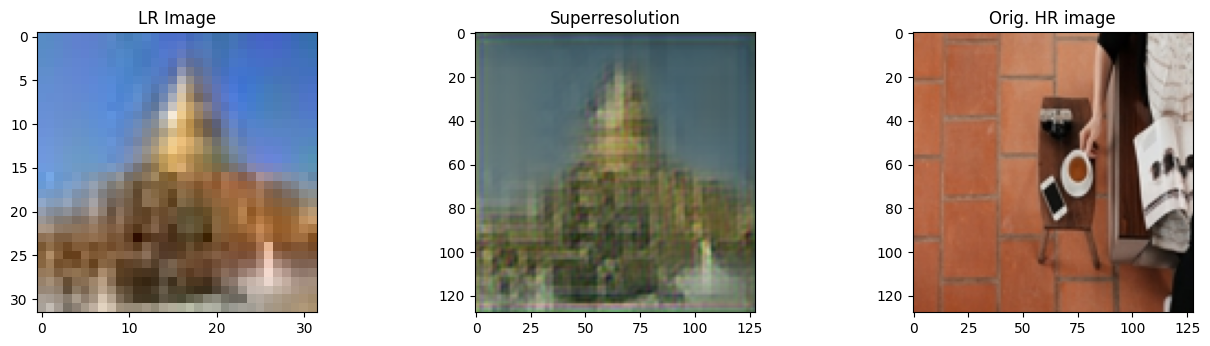

In [26]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_10.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()



1/1 [==============================] - 1s 506ms/step


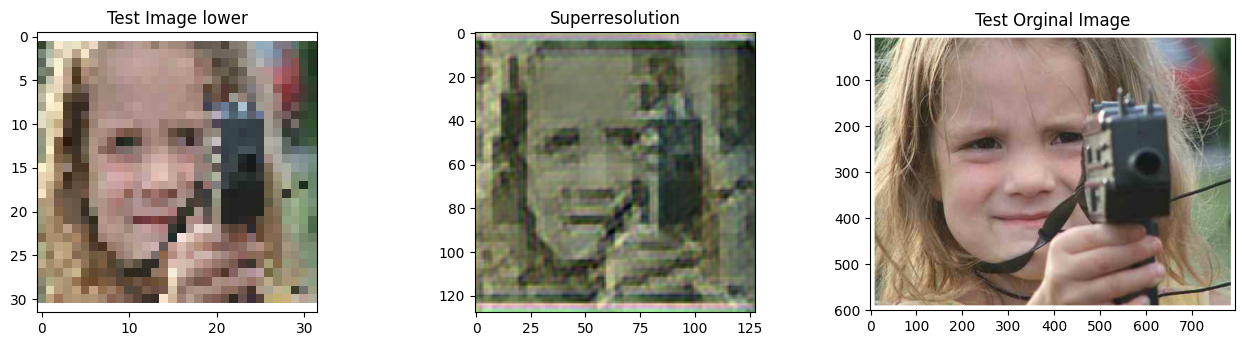

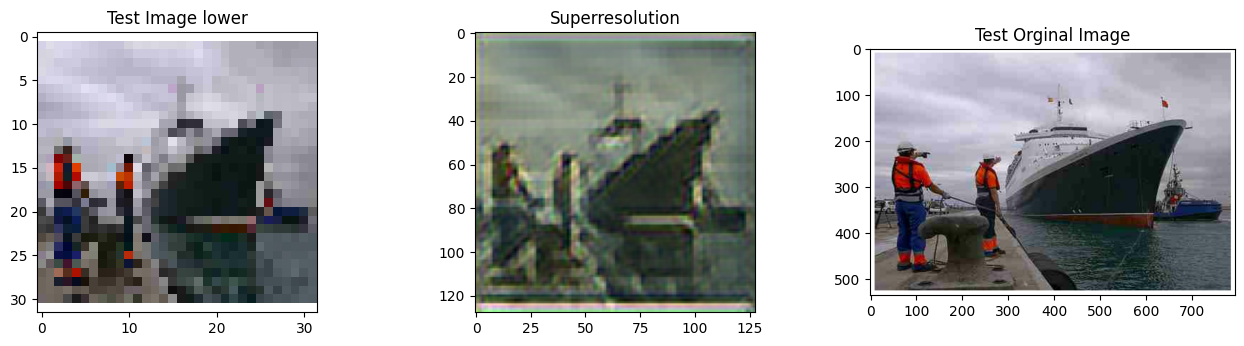

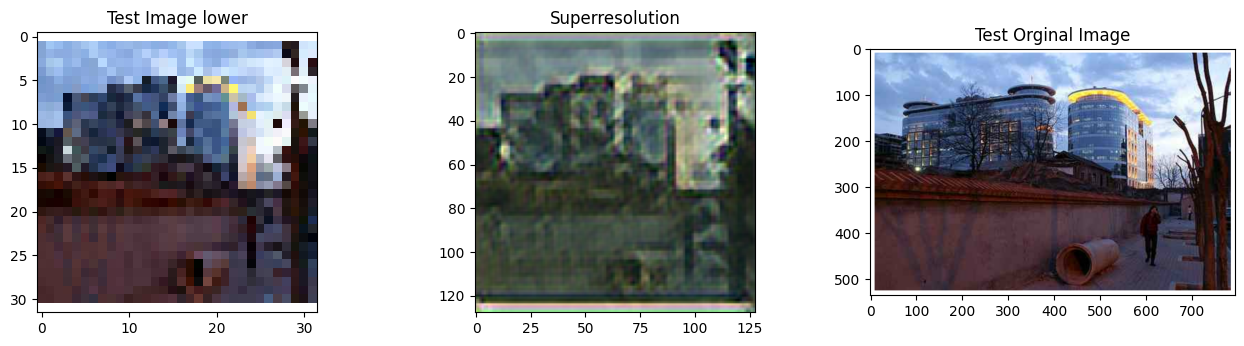

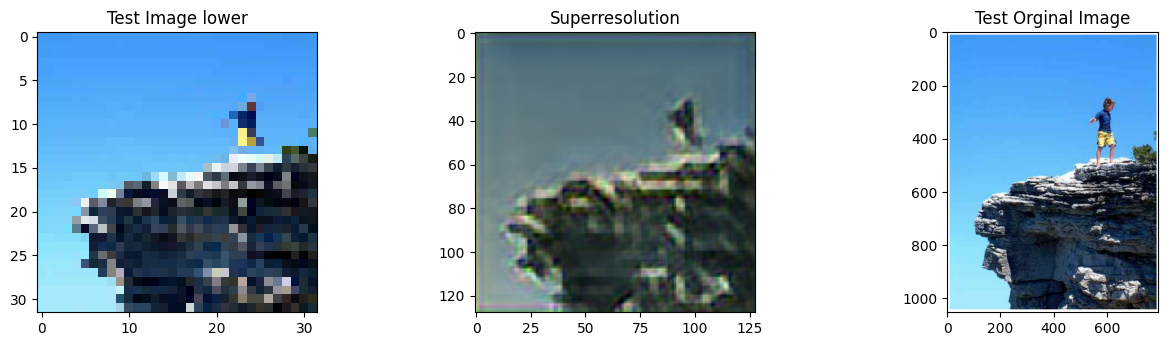

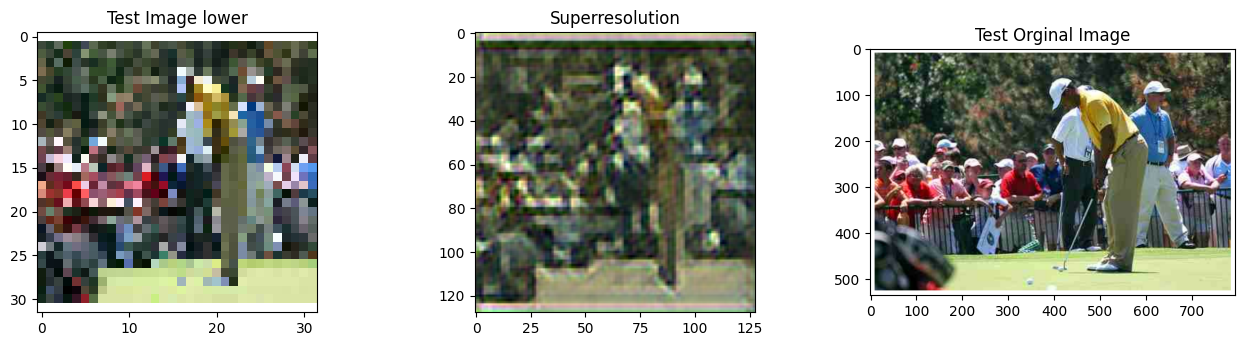

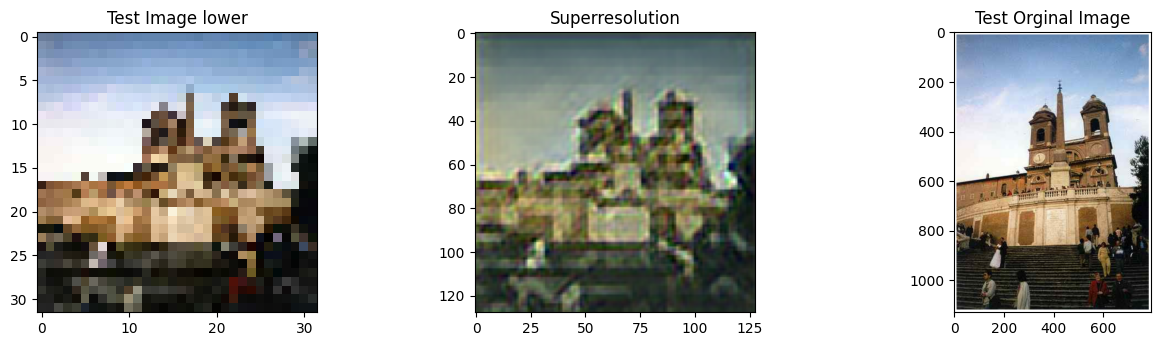

In [27]:
# Testing with the given sample pictures
test_image_path = os.path.join('/content/drive/MyDrive/gdrive/test')
generated_img = []
test_img_hr = []
test_img_lr = []
for img in os.listdir(test_image_path):
  try:

    img = cv2.imread(os.path.join(test_image_path, img))
    img_hr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_img_hr.append(img_hr)
    img_lr = cv2.resize(img, (32, 32))
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB) / 255
    img_lr = np.expand_dims(img_lr, axis=0)
    test_img_lr.append(img_lr)
    generated_img.append(generator.predict(img_lr))

  except Exception as e:
    print(f'Image failed to load {e}')

for i in range(len(generated_img)):
  plt.figure(figsize=(16, 8))
  plt.subplot(231)
  plt.title('Test Image lower')
  plt.imshow(test_img_lr[i][0,:,:,:])
  plt.subplot(232)
  plt.title('Superresolution')
  plt.imshow(generated_img[i][0,:,:,:])
  plt.subplot(233)
  plt.title('Test Orginal Image')
  plt.imshow(test_img_hr[i])



plt.show()


In [51]:
#Saving into output_image directory in png_format

os.makedirs('/content/drive/MyDrive/gdrive/output_images',exist_ok=True)

out_file = '/content/drive/MyDrive/gdrive/output_images'
i = 1
for img in test_img_hr:
  img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  png_img = Image.fromarray((img2))
  png_img.save(os.path.join(out_file, f'test_image_{i}'), 'PNG')
  i += 1
